# "A method for determining the accuracy of formulas for calculation of crack wdith and spacing in reinforced concrete elements"

This file contains the functions for the various CWFs and the plot functions. The working database is used.

This is related to the paper "A method for determining the performance of formulas for calculating the crack width and spacing in reinforced concrete elements".

## Info

This file generates the graphs of the paper "Crack width and crack spacing in reinforced and prestressed concrete elements: database". <br>

2025-08-04 <br>
(c) Anton van der Esch
-antonvanderesch@hotmail.com or i.a.v.d.esch@tue.nl \

Please read the licence.

For the calculation of variables is referred to a different Jupyter Notebook.

This notebook consist of several sections:\
00 - Import Packages \
01 - Settings \
02 - Import and prepare data \
03 - Set DF types and extract additional data types \
04 - Plot functions \
05 - Evaluation of crack width formulas

## 00 - Import packages

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.patches import ConnectionPatch
import numpy as np
import numpy.ma as ma
import math

from pathlib import Path
import ast

from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

from sklearn.metrics import r2_score 

from contextlib import suppress

from scipy.stats import norm
from scipy.stats import lognorm
from sklearn.metrics import root_mean_squared_error

import time

from scipy.stats import median_abs_deviation as madm
from scipy.stats import percentileofscore
import statistics
from scipy.stats import ks_2samp
from scipy.stats import wilcoxon
from scipy.stats import pearsonr
from scipy.stats import skew

import os
import subprocess

import matplotlib.patches as mpatches
import matplotlib.transforms as mtransforms

## 01 - Settings

In [3]:
Ncond = 15;
Nint = 100;
g = 9.81;
timecutoff = 100; # Transition from short to long term
Nrepcutoff = 2000; # Transition from static to repeated loading
chi = 0.8; # Aeging factor

importsigs = "no"; # Choice to import steel stress calculation from previous calculation --> save tremendous time
# Pas op! Als je Hordijk stress berekend, dan kan deze worden opgeslagen. Geldt dit ook voor staalspanningen die niet met Hordijk worden berekend?
importdat = "no";

exclude_secondary_cracks = "no";
uniformtargets = "yes";
hordijksigs = "no"; # In case yes, then the stress according to Hordijk is calculated
includeinitshrinkage = "no"; # Include initial shrinkage in the calculations

# no means: it is fully calculated
# yes means: it is not calculated but imported from a saved file

# Global constraints
globalfilterstress = "yes"; # Filters for the steel stress on the complete database!
sigslower = 150; # <-- eigenlijk vind ik dat dit 138 of 150 MPa moet zijn, komt ook overeen met ondergrens volgens Frosch?
sigsupper = 350;

filtercrackingplateau = "yes";

# Impute mean crack spacings based on known values?
targetimputation = "yes";
Ncracksub = 4; # 4 means: imputation by 5 cracks or more (in case target imputation is switched on)

# Transform wm and sm to wmax and smax, respectively

# Constraints
soft_constraints = "no";
hard_constraints = "yes";

tol = 0.001;

fitleroutliers = "yes";
wmaxU = 0.5; # Cut-off limiet gemiddelde en maximale scheurwijdte
smaxU = 400; # Cut-off limiet gemiddelde en maximale scheurafstand

ignorewarnings = "yes";

# Filter on the lengths
filter_length = 500; # Filter out considered lengths equal and smaller than .....

# Return crack spacings only at maximum load level?
crackmaxload = "yes";

# Impute negative predicted widths with zero (tolerance)
# --> this enable contributing neg. predicted widths to the stats (= meest negatieve voorspelling)
imputenegative = "no";

In [4]:
if ignorewarnings == "yes":

    import warnings
    warnings.filterwarnings('ignore');

In [5]:
# https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot

# 8, 10, 12
# 10, 12, 14

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

arrow_style="simple,head_length=10,head_width=10,tail_width=1"
rect_style="simple,tail_width=1"
line_style="simple,tail_width=0.5"

## 02 - Import and prepare data

In [6]:
motherpath = Path(r"C:\Users/20210065/OneDrive - TU Eindhoven/60_Publications/");

#### Export - with filtering secondary cracks and with uniform targets

In [7]:
if exclude_secondary_cracks == "yes" and uniformtargets == "yes":

    if hordijksigs == "yes" and includeinitshrinkage == "no":
        # Case: hordijk, no initial shrinkage
        df = pd.read_csv(Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Data_exported\filt_2nd\uniform\Working_database_hordijk_no_initshrink.csv"));
    
    elif hordijksigs == "no" and includeinitshrinkage == "no":
        # Case: no hordijk, no initial shrinkage
        df = pd.read_csv(Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Data_exported\filt_2nd\uniform\Working_database_no_hordijk_no_initshrink.csv"));

    elif hordijksigs == "yes" and includeinitshrinkage == "yes":
        # Case: hordijk, initial shrinkage
        df = pd.read_csv(Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Data_exported\filt_2nd\uniform\Working_database_hordijk_initshrink.csv"));

    elif hordijksigs == "no" and includeinitshrinkage == "yes":
        # Case: no hordijk, initial shrinkage
        df = pd.read_csv(Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Data_exported\filt_2nd\uniform\Working_database_no_hordijk_initshrink.csv"));

#### Export - with filtering secondary cracks and no uniform targets

In [8]:
if exclude_secondary_cracks == "yes" and uniformtargets == "no":

    if hordijksigs == "yes" and includeinitshrinkage == "no":
        # Case: hordijk, no initial shrinkage
        df = pd.read_csv(Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Data_exported\filt_2nd\no_uniform\Working_database_hordijk_no_initshrink.csv"));
    
    elif hordijksigs == "no" and includeinitshrinkage == "no":
        # Case: no hordijk, no initial shrinkage
        df = pd.read_csv(Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Data_exported\filt_2nd\no_uniform\Working_database_no_hordijk_no_initshrink.csv"));

    elif hordijksigs == "yes" and includeinitshrinkage == "yes":
        # Case: hordijk, initial shrinkage
        df = pd.read_csv(Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Data_exported\filt_2nd\no_uniform\Working_database_hordijk_initshrink.csv"));

    elif hordijksigs == "no" and includeinitshrinkage == "yes":
        # Case: no hordijk, initial shrinkage
        df = pd.read_csv(Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Data_exported\filt_2nd\no_uniform\Working_database_no_hordijk_initshrink.csv"));

#### Export - without filtering secondary cracks and with uniform targets

In [9]:
if exclude_secondary_cracks == "no" and uniformtargets == "yes":

    if hordijksigs == "yes" and includeinitshrinkage == "no":
        # Case: hordijk, no initial shrinkage
        df = pd.read_csv(Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Data_exported\no_filt_2nd\uniform\Working_database_hordijk_no_initshrink.csv"));
    
    elif hordijksigs == "no" and includeinitshrinkage == "no":
        # Case: no hordijk, no initial shrinkage
        df = pd.read_csv(Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Data_exported\no_filt_2nd\uniform\Working_database_no_hordijk_no_initshrink.csv"));

    elif hordijksigs == "yes" and includeinitshrinkage == "yes":
        # Case: hordijk, initial shrinkage
        df = pd.read_csv(Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Data_exported\no_filt_2nd\uniform\Working_database_hordijk_initshrink.csv"));

    elif hordijksigs == "no" and includeinitshrinkage == "yes":
        # Case: no hordijk, initial shrinkage
        df = pd.read_csv(Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Data_exported\no_filt_2nd\uniform\Working_database_no_hordijk_initshrink.csv"));

#### Export - without filtering secondary cracks and without uniform targets

In [10]:
if exclude_secondary_cracks == "no" and uniformtargets == "no":

    if hordijksigs == "yes" and includeinitshrinkage == "no":
        # Case: hordijk, no initial shrinkage
        df = pd.read_csv(Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Data_exported\no_filt_2nd\no_uniform\Working_database_hordijk_no_initshrink.csv"));
    
    elif hordijksigs == "no" and includeinitshrinkage == "no":
        # Case: no hordijk, no initial shrinkage
        df = pd.read_csv(Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Data_exported\no_filt_2nd\no_uniform\Working_database_no_hordijk_no_initshrink.csv"));

    elif hordijksigs == "yes" and includeinitshrinkage == "yes":
        # Case: hordijk, initial shrinkage
        df = pd.read_csv(Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Data_exported\no_filt_2nd\no_uniform\Working_database_hordijk_initshrink.csv"));

    elif hordijksigs == "no" and includeinitshrinkage == "yes":
        # Case: no hordijk, initial shrinkage
        df = pd.read_csv(Path(motherpath/r"1_st_Journal_Paper\Jupyter_Notebook\Data_exported\no_filt_2nd\no_uniform\Working_database_no_hordijk_initshrink.csv"));

### Summary of import

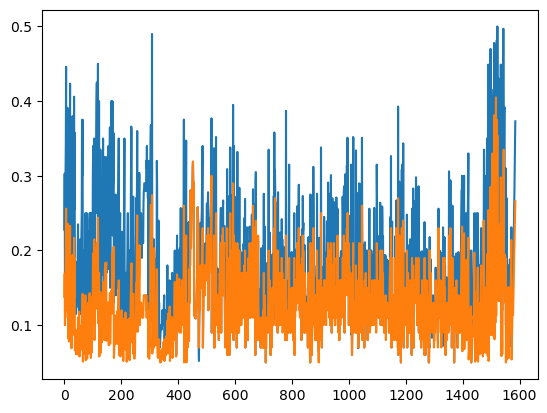

In [11]:
plt.plot(df["wmax"],label="wmax")
plt.plot(df["wm"],label="wm")

In [12]:
df = df[(df["wmax"] > tol)]

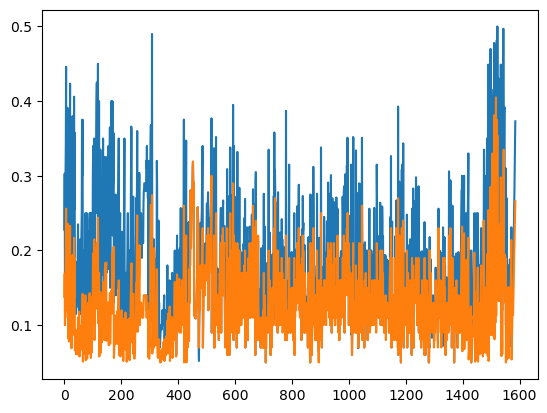

In [13]:
plt.plot(df["wmax"],label="wmax")
plt.plot(df["wm"],label="wm")

In [14]:
print("Number of datapoints",df.shape[0]);
print("Number of variables",df.shape[1]);

print("Number of unique elements",df["ELID"].nunique());

Number of datapoints 1586
Number of variables 213
Number of unique elements 256


In [15]:
print("Number of elements loaded in tension",df[df["epsin"] == str("1a")]["ELID"].nunique());
print("Number of elements loaded in tension",df[df["epsin"] == str("1b")]["ELID"].nunique());
print("Number of elements loaded in bending",df[df["epsin"] == str("2")]["ELID"].nunique());
print("Number of elements with prestressing",df[(df["epsin"] == str("3")) & (df["Ap"] != 0)]["ELID"].nunique());
print("Number of elements with eccentric tension",df[(df["epsin"] == str("3")) & (df["Ap"] == 0)]["ELID"].nunique());

Number of elements loaded in tension 155
Number of elements loaded in tension 0
Number of elements loaded in bending 92
Number of elements with prestressing 9
Number of elements with eccentric tension 0


In [17]:
df = df[(df["Astot"] > tol) & (df["Aptot"] < tol) & (df["fsr"] == 2) & (df["cy"] <= 75)]

#### Switch settings for output

In [18]:
# Switch settings to get also other output!
#df = df[df["CS"] == 1]; # CFS
#df = df[df["CS"] == 2]; # SCS

In [20]:
print("Number of datapoints",df.shape[0]);
print("Number of variables",df.shape[1]);

print("Number of unique elements",df["ELID"].nunique());

Number of datapoints 1504
Number of variables 213
Number of unique elements 231


#### Elements having too large hoh spacings for tension case

In [23]:
def filter_srmax(data):

    idxtemplocw1 = data.loc[(data["smax"] != 0) & (data["CS"] == 2) & (data["locw"] == 1)][::-1].groupby(['ELID'])['smax'].idxmin()
    idxtemplocw2 = data.loc[(data["smax"] != 0) & (data["CS"] == 2) & (data["locw"] == 2)][::-1].groupby(['ELID'])['smax'].idxmin()
    
    # Substitute values and store in temporary list
    dfsmaxtemplocw1 = data["smax"][idxtemplocw1]
    dfsmaxtemplocw2 = data["smax"][idxtemplocw2]
    
    dfsmtemplocw1 = data["sm"][idxtemplocw1]
    dfsmtemplocw2 = data["sm"][idxtemplocw2]

    data["smax"] = 0; data["sm"] = 0;
    data.loc[idxtemplocw1,"smax"] = dfsmaxtemplocw1;
    data.loc[idxtemplocw2,"smax"] = dfsmaxtemplocw2;
    
    data.loc[idxtemplocw1,"sm"] = dfsmtemplocw1;
    data.loc[idxtemplocw2,"sm"] = dfsmtemplocw2;

    return data

In [24]:
if crackmaxload == "yes":
    df = filter_srmax(df);

In [25]:
print("Number of datapoints",df.shape[0]);
print("Number of unique elements",df["ELID"].nunique());

Number of datapoints 1504
Number of unique elements 231


## 03 - Functions

#### Function to extract the section width of a string

In [44]:
def func_extract_width(z,bstr):

    # This function computes the widht of a cross-section, at a certain height
    bstr = str(bstr);
    tempstr = bstr.strip("[]");    
    nfunc = len(tempstr.split(","));
    
    # Create temparray to store different bounds, widths and heights
    if nfunc > 1:
        
        boundstore = np.zeros((2,nfunc)); # Lower resp. upper bound
        funcstore = [];
        
        for j in range(nfunc):
            boundstore[0,j] = float(tempstr.split(",")[j].split("if")[1].split("<z<")[0]);
            boundstore[1,j] = float(tempstr.split(",")[j].split("if")[1].split("<z<")[1]);
    
            def f(z):
                return float(eval(tempstr.split(",")[j].split("if")[0]));
            
            funcstore.append(f(z));
                    
        b = np.piecewise(
                        z,
                        [(z < boundstore[1,j]) & (z >= boundstore[0,j]) for j in range(nfunc)],funcstore);
  
    else:
        b = float(eval(bstr));

    return b

## 03 - Programming of formulas of crack width and spacing

### *CWF 001a* - EN 1992-1-1 (2005)

In [45]:
def func_cwf_001a(data):

    wm = np.zeros(data.shape[0]); wmax = np.zeros(data.shape[0]);
    smax = np.zeros(data.shape[0]); sm = np.zeros(data.shape[0]);

    beta = 1.7;

    rhoefftemp = np.zeros(data.shape[0]);
    
    for i in range(data.shape[0]):

        ae_001a = data["Es"].iloc[i]/data["Ecm0"].iloc[i];
        ap_001a = data["Ep"].iloc[i]/data["Ecm0"].iloc[i];
        
        # Extract of info
        zs = ast.literal_eval(data["zs"].iloc[i]);
        phi = ast.literal_eval(data["phi"].iloc[i]);
        nbl = ast.literal_eval(data["nbl"].iloc[i]);

        zp = ast.literal_eval(data["zp"].iloc[i]); 
        npl = ast.literal_eval(data["npl"].iloc[i]); 
        Ap = ast.literal_eval(data["Ap"].iloc[i]);
        
        # Calculation of coefficient k1
        if data["Aptot"].iloc[i] > 1 and data["Astot"].iloc[i] < 1: # Filter case with only prestressing steel
            k1 = 1.6;
        else:
            k1 = 0.8; # Ribbed surface of zachtstaal
        
        # Calculation of coefficient k2
        if data["epsin"].iloc[i] == str("1a"):
            k2 = 1; # Zuivere trek
        elif data["epsin"].iloc[i] == str(2) or data["epsin"].iloc[i] == str(3):
            k2 = 0.5; # Zuivere buiging óf voorspanning
            
        # Coefficient k3 and k4
        k3 = 3.4; k4 = 0.425;
        
        # Long-term or short-term behavior
        if data["t"].iloc[i] <= timecutoff:
            kt = 0.6; # Kortdurend
        elif data["t"].iloc[i] > timecutoff:
            kt = 0.4; # Langdurend      

        #heff1 = 2.5*(data["h"].iloc[i] - data["zstot"].iloc[i]);
        heff2 = (data["h"].iloc[i] - data["xc"].iloc[i])/3;
        heff3 = data["h"].iloc[i]/2;
        
        # Calculation of Aceff
        if data["epsin"].iloc[i] == str("1a"):
            heff1 = 2.5*data["ry"].iloc[i]; # (h-d)
            hceff = min(heff1,heff3) + tol; # To prevent singularities;
            
            Aceff1 = quad(func_extract_width,data["h"].iloc[i]-hceff,data["h"].iloc[i],args=(data["b"].iloc[i]))[0]; # Analyze bottom part
            Aceff2 = quad(func_extract_width,0,hceff,args=(data["b"].iloc[i]))[0]; # Analyze top part
            Aceff = Aceff1 + Aceff2;
        else:
            if data["Astot"].iloc[i] > tol:
                heff1 = 2.5*(data["h"].iloc[i] - data["zstottens"].iloc[i]);
            elif data["Astot"].iloc[i] < tol:
                heff1 = 2.5*(data["h"].iloc[i] - data["zptottens"].iloc[i]);
            
            hceff = min(heff1,heff2,heff3);
            Aceff = quad(func_extract_width,data["h"].iloc[i]-hceff,data["h"].iloc[i],args=(data["b"].iloc[i]))[0];
        
        # Calculation of the effective reinforcing area
        Asefftemp = np.zeros(len(zs));
        for j in range(len(zs)):
            if data["epsin"].iloc[i] == str("1a"):
                if data["indLR"].iloc[i] < tol: # Single layer, centric
                    Asefftemp[j] = (1/4)*np.pi*phi[j]**2;
                else:
                    if zs[j] < hceff and abs(zs[j] - data["h"].iloc[i]/2) > 10*tol:
                        Asefftemp[j] = 2*(phi[j]**2)*nbl[j]*(1/4)*np.pi; # Since there is symmetric reinforcement steel present
                    elif zs[j] < hceff and abs(zs[j] - data["h"].iloc[i]/2) < 10*tol:
                        Asefftemp[j] = (phi[j]**2)*nbl[j]*(1/4)*np.pi; # Middle layer; or layer with centrically located reinforcement
            else:
                if zs[j] > data["h"].iloc[i]-hceff:
                    Asefftemp[j] = (phi[j]**2)*nbl[j]*(1/4)*np.pi;
        Aseff = np.sum(Asefftemp);

        # Calculation of the equivalent diamater
        phieqtemp_ni_phi_sqrt = np.zeros(len(zs));
        phieqtemp_ni_phi = np.zeros(len(zs));

        press_phieqtemp_ni_phi_sqrt = np.zeros(len(zp));
        press_phieqtemp_ni_phi = np.zeros(len(zp));       

        if data["epsin"].iloc[i] == str("1a"):
            for j in range(len(zs)):
                if zs[j] < hceff: 
                    if zs[j] < hceff and abs(zs[j] - data["h"].iloc[i]/2) > 10*tol:
                        phieqtemp_ni_phi_sqrt[j] = 2*nbl[j]*phi[j]**2;
                        phieqtemp_ni_phi[j] = 2*nbl[j]*phi[j];
                    elif zs[j] < hceff and abs(zs[j] - data["h"].iloc[i]/2) < 10*tol:
                        phieqtemp_ni_phi_sqrt[j] = nbl[j]*phi[j]**2;
                        phieqtemp_ni_phi[j] = nbl[j]*phi[j];
        elif data["epsin"].iloc[i] == str("2"):
            for j in range(len(zs)):
                if zs[j] > data["h"].iloc[i]-hceff:
                    phieqtemp_ni_phi_sqrt[j] = nbl[j]*phi[j]**2;
                    phieqtemp_ni_phi[j] = nbl[j]*phi[j];
        elif data["epsin"].iloc[i] == str("3"):
            for j in range(len(zs)):
                if zs[j] > data["h"].iloc[i]-hceff:
                    phieqtemp_ni_phi_sqrt[j] = nbl[j]*phi[j]**2;
                    phieqtemp_ni_phi[j] = nbl[j]*phi[j];

        if data["epsin"].iloc[i] == str("3"):
            if data["Astot"].iloc[i] > tol: # Combination ordinary and prestressed reinforcing steel
                phi_eq = sum(phieqtemp_ni_phi_sqrt)/sum(phieqtemp_ni_phi);
            else: # Prestressed reinforcement only
                phi_eq = data["phi_peq"].iloc[i];
        else:
            phi_eq = sum(phieqtemp_ni_phi_sqrt)/sum(phieqtemp_ni_phi);
        
        # Calculation of the effective prestressing area
        Apefftemp = np.zeros(len(zp));
        for j in range(len(zp)):
            if data["epsin"].iloc[i] == str("1a"): # Is not evalutated, there are no elements loaded in tension with prestressing
                Apefftemp[j] = Ap[j]*npl[j];
            else:
                if zp[j] > data["h"].iloc[i]-hceff:
                    Apefftemp[j] = Ap[j]*npl[j];
        Apeff = np.sum(Apefftemp);      
        
        # Calculation of rhoeff
        if data["Astot"].iloc[i] < tol:
            rhoeff = (Aseff + np.sqrt(data["zeta"].iloc[i])*Apeff)/Aceff;
        else:
            rhoeff = (Aseff + data["zeta1"].iloc[i]*Apeff)/Aceff;

        if includeinitshrinkage == "yes":
            if data["Astot"].iloc[i] > tol:
                diff_eps1 = ((data["sigs"].iloc[i] - kt*(data["fctm"].iloc[i] / rhoeff)*(1 + ae_001a*rhoeff))/data["Es"].iloc[i]) - \
                    (1-kt)*data["shrinkage_init"].iloc[i];
                diff_eps2 = 0.6*data["sigs"].iloc[i]/data["Es"].iloc[i];
                diff_eps = max(diff_eps1,diff_eps2);
            elif data["Astot"].iloc[i] < tol:
                diff_eps1 = ((data["dpsigs"].iloc[i] - kt*(data["fctm"].iloc[i] / rhoeff)*(1 + ap_001a*rhoeff))/data["Ep"].iloc[i]) - \
                    (1-kt)*data["shrinkage_init"].iloc[i];
                diff_eps2 = 0.6*data["dpsigs"].iloc[i]/data["Ep"].iloc[i];
                diff_eps = max(diff_eps1,diff_eps2);
        else:
            if data["Astot"].iloc[i] > tol:
                diff_eps1 = (data["sigs"].iloc[i] - kt*(data["fctm"].iloc[i] / rhoeff)*(1 + ae_001a*rhoeff))/data["Es"].iloc[i];
                diff_eps2 = 0.6*data["sigs"].iloc[i]/data["Es"].iloc[i];
                diff_eps = max(diff_eps1,diff_eps2);
            elif data["Astot"].iloc[i] < tol:
                diff_eps1 = (data["dpsigs"].iloc[i] - kt*(data["fctm"].iloc[i] / rhoeff)*(1 + ap_001a*rhoeff))/data["Ep"].iloc[i];
                diff_eps2 = 0.6*data["dpsigs"].iloc[i]/data["Ep"].iloc[i];
                diff_eps = max(diff_eps1,diff_eps2);

        if data["epsin"].iloc[i] == str("1a") and data["sxLR"].iloc[i] <= 5*data["ry"].iloc[i]:
            srmax1 = k3*data["cy"].iloc[i] + k1*k2*k4*phi_eq/rhoeff;
        elif data["epsin"].iloc[i] == str("2"):
            if data["sxLR"].iloc[i] <= 5*data["ry"].iloc[i]:
                srmax1 = k3*data["cy"].iloc[i] + k1*k2*k4*phi_eq/rhoeff;
            else:
                srmax1 = 1.3*(data["h"].iloc[i]-data["xc"].iloc[i]);
        elif data["epsin"].iloc[i] == str("3"):
            if data["Astot"].iloc[i] > tol: # Combination of prestressing steel with reinforcing steel
                if data["sxLR"].iloc[i] <= 5*data["ry"].iloc[i]:
                    srmax1 = k3*data["cy"].iloc[i] + k1*k2*k4*phi_eq/rhoeff;
                else:
                    srmax1 = 1.3*(data["h"].iloc[i]-data["xc"].iloc[i]);
            elif data["Astot"].iloc[i] < tol: # Only prestressing steel
                if data["sxNP"].iloc[i] <= 5*data["ryp"].iloc[i]:
                    srmax1 = k3*data["cyp"].iloc[i] + k1*k2*k4*data["phi_peq"].iloc[i]/rhoeff;
                else:
                    srmax1 = 1.3*(data["h"].iloc[i]-data["xc"].iloc[i]);
        else:
            srmax1 = 0;

        wmax[i] = srmax1*diff_eps;
        wm[i] = wmax[i]/beta;
        
        if data["CS"].iloc[i] == 2:
            smax[i] = srmax1;
            sm[i] = smax[i]/beta;

        # Address negative crack widths
        if imputenegative == "yes":
            if wm[i] < 0:
                wm[i] = tol; # So it can contribute in the statistics
        
            if wmax[i] < 0:
                wmax[i] = tol; # So it can contribute in the statistics
    
    return wm, wmax, sm, smax

In [46]:
func_cwf_001a(df)

(array([0.08100755, 0.11819175, 0.08100755, ..., 0.18742043, 0.1948966 ,
        0.20237262]),
 array([0.13771284, 0.20092597, 0.13771284, ..., 0.31861472, 0.33132423,
        0.34403346]),
 array([123.31253434, 123.12294999, 123.31253434, ...,   0.        ,
          0.        ,   0.        ]),
 array([209.63130838, 209.30901499, 209.63130838, ...,   0.        ,
          0.        ,   0.        ]))

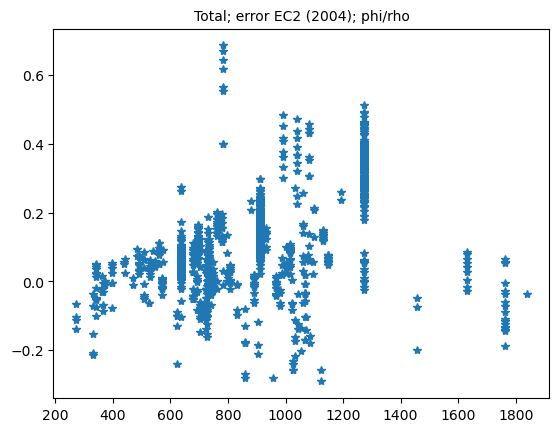

In [47]:
plt.title("Total; error EC2 (2004); phi/rho")
plt.plot(df["phi_eq_MC2020"]/df["rhoeff_MC2020"],func_cwf_001a(df)[1]-df["wmax"],"*")

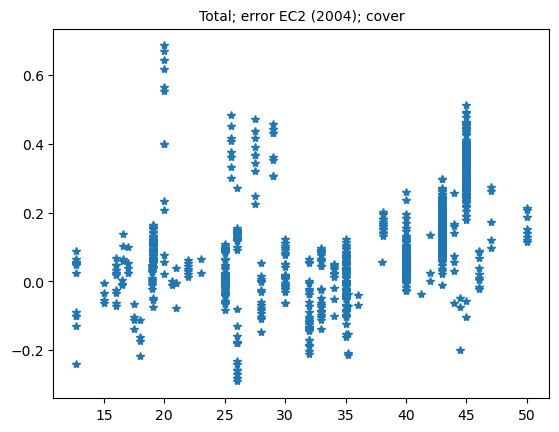

In [48]:
plt.title("Total; error EC2 (2004); cover")
plt.plot(df["cy"],func_cwf_001a(df)[1]-df["wmax"],"*")

### *CWF 001b* - NEN-EN 1992-1-1 (2020)

In [55]:
def func_cwf_001b(data):

    wm = np.zeros(data.shape[0]); wmax = np.zeros(data.shape[0]);
    smax = np.zeros(data.shape[0]); sm = np.zeros(data.shape[0]);

    beta = 1.7;
    
    for i in range(data.shape[0]):

        ae_001b = data["Es"].iloc[i]/data["Ecm0"].iloc[i];
        ap_001b = data["Ep"].iloc[i]/data["Ecm0"].iloc[i];

        # Extract of info
        zs = ast.literal_eval(data["zs"].iloc[i]);
        phi = ast.literal_eval(data["phi"].iloc[i]);
        nbl = ast.literal_eval(data["nbl"].iloc[i]);

        zp = ast.literal_eval(data["zp"].iloc[i]); 
        npl = ast.literal_eval(data["npl"].iloc[i]); 
        Ap = ast.literal_eval(data["Ap"].iloc[i]);
        
        # Calculation of coefficient k1
        if data["Aptot"].iloc[i] > 1 and data["Astot"].iloc[i] < 1: # Filter case with only prestressing steel
            k1 = 1.6; 
        else:
            k1 = 0.8; # Ribbed surface of zachtstaal
        
        # Calculation of coefficient k2
        if data["epsin"].iloc[i] == str("1a"):
            k2 = 1; # Zuivere trek
        elif data["epsin"].iloc[i] == str(2) or data["epsin"].iloc[i] == str(3):
            k2 = 0.5; # Zuivere buiging
            
        # Coefficient k3 and k4
        k3 = 3.4; k4 = 0.425;
        
        # Long-term or short-term behavior
        if data["t"].iloc[i] <= timecutoff:
            kt = 0.6; # Kortdurend
        elif data["t"].iloc[i] > timecutoff:
            kt = 0.4; # Langdurend
        
        #kt = data["kt"].iloc[i];

        heff2 = (data["h"].iloc[i] - data["xc"].iloc[i])/3;
        heff3 = data["h"].iloc[i]/2;
        
       # Calculation of Aceff
        if data["epsin"].iloc[i] == str("1a"):

            #heff1 = 2.5*(data["h"].iloc[i] - d);
            heff1 = 2.5*data["ry"].iloc[i];
            hceff = min(heff1,heff3)  + tol; # To prevent singularities;

            Aceff1 = quad(func_extract_width,data["h"].iloc[i]-hceff,data["h"].iloc[i],args=(data["b"].iloc[i]))[0]; # Analyze bottom part
            Aceff2 = quad(func_extract_width,0,hceff,args=(data["b"].iloc[i]))[0]; # Analyze top part
            Aceff = Aceff1 + Aceff2;
        else:
            if data["Astot"].iloc[i] > tol:
                heff1 = 2.5*(data["h"].iloc[i] - data["zstottens"].iloc[i])
            elif data["Astot"].iloc[i] < tol:
                heff1 = 2.5*(data["h"].iloc[i] - data["zptottens"].iloc[i]);
            
            hceff = min(heff1,heff2,heff3);
            Aceff = quad(func_extract_width,data["h"].iloc[i]-hceff,data["h"].iloc[i],args=(data["b"].iloc[i]))[0];
        
        # Calculation of the effective reinforcing area
        Asefftemp = np.zeros(len(zs));
        for j in range(len(zs)):
            if data["epsin"].iloc[i] == str("1a"):
                if data["indLR"].iloc[i] < 1: # Single layer, centric
                    Asefftemp[j] = (1/4)*np.pi*phi[j]**2;
                else:
                    if zs[j] < hceff and abs(zs[j] - data["h"].iloc[i]/2) > 10*tol:
                        Asefftemp[j] = 2*(phi[j]**2)*nbl[j]*(1/4)*np.pi; # Since there is symmetric reinforcement steel present
                    elif zs[j] < hceff and abs(zs[j] - data["h"].iloc[i]/2) < 10*tol:
                        Asefftemp[j] = (phi[j]**2)*nbl[j]*(1/4)*np.pi; # Middle layer
            else:
                if zs[j] > data["h"].iloc[i]-hceff:
                    Asefftemp[j] = (phi[j]**2)*nbl[j]*(1/4)*np.pi;
        Aseff = np.sum(Asefftemp);

        # Calculation of the equivalent diamater
        phieqtemp_ni_phi_sqrt = np.zeros(len(zs));
        phieqtemp_ni_phi = np.zeros(len(zs));

        press_phieqtemp_ni_phi_sqrt = np.zeros(len(zp));
        press_phieqtemp_ni_phi = np.zeros(len(zp));       
        
        for j in range(len(zs)):
            if data["epsin"].iloc[i] == str("1a"):
                if zs[j] < hceff: 
                    if zs[j] < hceff and abs(zs[j] - data["h"].iloc[i]/2) > 10*tol:
                        phieqtemp_ni_phi_sqrt[j] = 2*nbl[j]*phi[j]**2;
                        phieqtemp_ni_phi[j] = 2*nbl[j]*phi[j];
                    elif zs[j] < hceff and abs(zs[j] - data["h"].iloc[i]/2) < 10*tol:
                        phieqtemp_ni_phi_sqrt[j] = nbl[j]*phi[j]**2;
                        phieqtemp_ni_phi[j] = nbl[j]*phi[j];
            elif data["epsin"].iloc[i] == str("2"):
                if zs[j] > data["h"].iloc[i]-hceff:
                    phieqtemp_ni_phi_sqrt[j] = nbl[j]*phi[j]**2;
                    phieqtemp_ni_phi[j] = nbl[j]*phi[j];
            elif data["epsin"].iloc[i] == str("3"):
                for j in range(len(zs)):
                    if zs[j] > data["h"].iloc[i]-hceff:
                        phieqtemp_ni_phi_sqrt[j] = nbl[j]*phi[j]**2;
                        phieqtemp_ni_phi[j] = nbl[j]*phi[j];

        if data["epsin"].iloc[i] == str("3"):
            if data["Astot"].iloc[i] > tol: # Combination ordinary and prestressed reinforcing steel
                phi_eq = sum(phieqtemp_ni_phi_sqrt)/sum(phieqtemp_ni_phi);
            else: # Prestressed reinforcement only
                phi_eq = data["phi_peq"].iloc[i];
        else:
            phi_eq = sum(phieqtemp_ni_phi_sqrt)/sum(phieqtemp_ni_phi);

        # Calculation of the effective prestressing area
        Apefftemp = np.zeros(len(zp));
        for j in range(len(zp)):
            if data["epsin"].iloc[i] == str("1a"):
                Apefftemp[j] = Ap[j]*npl[j];
            else:
                if zp[j] > data["h"].iloc[i]-hceff:
                    Apefftemp[j] = Ap[j]*npl[j];
        Apeff = np.sum(Apefftemp);        
        
        # Calculation of rhoeff
        if data["Astot"].iloc[i] < tol:
            rhoeff = (Aseff + np.sqrt(data["zeta"].iloc[i])*Apeff)/Aceff;
        else:
            rhoeff = (Aseff + data["zeta1"].iloc[i]*Apeff)/Aceff;

        if includeinitshrinkage == "yes":
            if data["Astot"].iloc[i] > tol:
                diff_eps1 = ((data["sigs"].iloc[i] - kt*(data["fctm"].iloc[i] / rhoeff)*(1 + ae_001b*rhoeff))/data["Es"].iloc[i]) - \
                    (1-kt)*data["shrinkage_init"].iloc[i];
                diff_eps2 = 0.6*data["sigs"].iloc[i]/data["Es"].iloc[i];
                diff_eps = max(diff_eps1,diff_eps2);
            elif data["Astot"].iloc[i] < tol:
                diff_eps1 = ((data["dpsigs"].iloc[i] - kt*(data["fctm"].iloc[i] / rhoeff)*(1 + ap_001b*rhoeff))/data["Ep"].iloc[i]) - \
                    (1-kt)*data["shrinkage_init"].iloc[i];
                diff_eps2 = 0.6*data["dpsigs"].iloc[i]/data["Ep"].iloc[i];
                diff_eps = max(diff_eps1,diff_eps2);
        else:
            if data["Astot"].iloc[i] > tol:
                diff_eps1 = (data["sigs"].iloc[i] - kt*(data["fctm"].iloc[i] / rhoeff)*(1 + ae_001b*rhoeff))/data["Es"].iloc[i];
                diff_eps2 = 0.6*data["sigs"].iloc[i]/data["Es"].iloc[i];
                diff_eps = max(diff_eps1,diff_eps2);
            elif data["Astot"].iloc[i] < tol:
                diff_eps1 = (data["dpsigs"].iloc[i] - kt*(data["fctm"].iloc[i] / rhoeff)*(1 + ap_001b*rhoeff))/data["Ep"].iloc[i];
                diff_eps2 = 0.6*data["dpsigs"].iloc[i]/data["Ep"].iloc[i];
                diff_eps = max(diff_eps1,diff_eps2);
        
        if data["epsin"].iloc[i] == str("1a") and data["sxLR"].iloc[i] <= 5*data["ry"].iloc[i]:
            srmax1 = k3*data["cy"].iloc[i] + k1*k2*k4*phi_eq/rhoeff;
            srmax2 = max((50-0.8*(data["fcm"].iloc[i]-8))*phi_eq,15*phi_eq);
            srmax = min(srmax1,srmax2);
        
        elif data["epsin"].iloc[i] == str("2"):
            if data["sxLR"].iloc[i] <= 5*data["ry"].iloc[i]:
                srmax1 = k3*data["cy"].iloc[i] + k1*k2*k4*phi_eq/rhoeff;
                srmax2 = max((50-0.8*(data["fcm"].iloc[i]-8))*phi_eq,15*phi_eq);
                srmax = min(srmax1,srmax2);
            else:
                srmax = 1.3*(data["h"].iloc[i]-data["xc"].iloc[i]);
        elif data["epsin"].iloc[i] == str("3"):
            if data["Astot"].iloc[i] > tol: # Combination of prestressing steel with reinforcing steel
                if data["sxLR"].iloc[i] <= 5*data["ry"].iloc[i]:
                    srmax1 = k3*data["cy"].iloc[i] + k1*k2*k4*phi_eq/rhoeff;
                    srmax2 = max((50-0.8*(data["fcm"].iloc[i]-8))*phi_eq,15*phi_eq);
                    srmax = min(srmax1,srmax2);
                else:
                    srmax = 1.3*(data["h"].iloc[i]-data["xc"].iloc[i]);
            elif data["Astot"].iloc[i] < tol: # Only prestressing steel
                if data["sxNP"].iloc[i] <= 5*data["ryp"].iloc[i]:
                    srmax1 = k3*data["cyp"].iloc[i] + k1*k2*k4*data["phi_peq"].iloc[i]/rhoeff;
                    srmax2 = max((50-0.8*(data["fcm"].iloc[i]-8))*data["phi_peq"].iloc[i],15*data["phi_peq"].iloc[i]);
                    srmax = min(srmax1,srmax2);
                else:
                    srmax = 1.3*(data["h"].iloc[i]-data["xc"].iloc[i]);
        else:
            srmax = 0;

        srmaxtemp = srmax;

        wmax[i] = srmaxtemp*diff_eps;
        wm[i] = wmax[i]/beta;

        if data["CS"].iloc[i] == 2:
            smax[i] = srmaxtemp;
            sm[i] = smax[i]/beta;

        # Address negative crack widths
        if imputenegative == "yes":
            if wm[i] < 0:
                wm[i] = tol; # So it can contribute in the statistics
        
            if wmax[i] < 0:
                wmax[i] = tol; # So it can contribute in the statistics

    return wm, wmax, sm, smax

In [56]:
func_cwf_001b(df)

(array([0.08100755, 0.11819175, 0.08100755, ..., 0.16412964, 0.17069893,
        0.17726991]),
 array([0.13771284, 0.20092597, 0.13771284, ..., 0.27902038, 0.29018818,
        0.30135885]),
 array([123.31253434, 123.12294999, 123.31253434, ...,   0.        ,
          0.        ,   0.        ]),
 array([209.63130838, 209.30901499, 209.63130838, ...,   0.        ,
          0.        ,   0.        ]))

### *CWF 002* - EN 1992-1-1 (2023)

In [58]:
def func_cwf_002_ID_2(data):

    wm = np.zeros(data.shape[0]); wmax = np.zeros(data.shape[0]);
    smax = np.zeros(data.shape[0]); sm = np.zeros(data.shape[0]);

    kw = 1.7; # Factor to convert a mean crack width into a calculated crack width
    
    for i in range(data.shape[0]):

        ae_002 = data["Es"].iloc[i]/data["Ecm0"].iloc[i];
        ap_002 = data["Ep"].iloc[i]/data["Ecm0"].iloc[i];

        # Extract of info
        zs = ast.literal_eval(data["zs"].iloc[i]);
        phi = ast.literal_eval(data["phi"].iloc[i]);
        nbl = ast.literal_eval(data["nbl"].iloc[i]);
        clat = ast.literal_eval(data["clat"].iloc[i]);

        zp = ast.literal_eval(data["zp"].iloc[i]); 
        npl = ast.literal_eval(data["npl"].iloc[i]); 
        Ap = ast.literal_eval(data["Ap"].iloc[i]);
        cplat = ast.literal_eval(data["cplat"].iloc[i]);
        
        if data["Astot"].iloc[i] < tol:
            if data["locw"].iloc[i] == 2:
                c = data["cyp"].iloc[i];
            else:
                c = cplat[data["indNP"].iloc[i]];
        else:
            if data["locw"].iloc[i] == 2:
                #c = max(data["cy"].iloc[i] - data["phiw"].iloc[i],clat[data["indLR"].iloc[i]] - data["phiw"].iloc[i]);
                c = data["cy"].iloc[i] - data["phiw"].iloc[i];
            else:
                c = clat[data["indLR"].iloc[i]] - data["phiw"].iloc[i];
        
        # Curvature effect --> applies onlyy in case of pure bending, or combination of bending and tensions
        if data["epsin"].iloc[i] == str(2) or data["epsin"].iloc[i] == str(3):
            if data["locw"].iloc[i] == 2:
                if data["Astot"].iloc[i] < tol:
                    kr = (data["h"].iloc[i]-data["xc"].iloc[i])/(data["h"].iloc[i]-data["xc"].iloc[i]-data["ryp"].iloc[i]);
                else:
                    kr = (data["h"].iloc[i]-data["xc"].iloc[i])/(data["h"].iloc[i]-data["xc"].iloc[i]-data["ry"].iloc[i]);
            else:
                kr = 1;
        elif data["epsin"].iloc[i] == str("1a"): # Address the pure tensioned case --> since there is no curvature
            kr = 1;
        
        # Long-term or short-term behavior; also the various cracking stages are addressed
        if data["t"].iloc[i] <= timecutoff: # short-term loading
            kt = 0.6;
        elif data["Nrep"].iloc[i] <= Nrepcutoff: # instantaneous loading
            kt = 0.6;
        elif data["t"].iloc[i] > timecutoff and data["CS"].iloc[i] == 1: # short-term loading and CFS
            kt = 0.6;
        elif data["Nrep"].iloc[i] > Nrepcutoff and data["CS"].iloc[i] == 1: # repeated loading and CFS
            kt = 0.6;
        elif data["t"].iloc[i] > timecutoff and data["CS"].iloc[i] == 2: # long-term loading and SCS
            kt = 0.4;
        elif data["Nrep"].iloc[i] > Nrepcutoff and data["CS"].iloc[i] == 2: # repeated loading and SCS
            kt = 0.4;
        
        # Factor (analogue to the strain distribution in over the concrete, in the effective concrete area)
        if data["epsin"].iloc[i] == str("1a") or data["epsin"].iloc[i] == str("1b"):
            kfl = 1;
        else:
            kfl = (1/2)*(1 + ( data["h"].iloc[i] - data["cog"].iloc[i] - data["hceff_FPR"].iloc[i] ) / ( data["h"].iloc[i] - data["cog"].iloc[i] ));

        # Factor, considering the bond (1 = good, 2 = bad)
        if data["bondLR"].iloc[i] == 1: # Consider good bond conditions
            kb = 0.9;
        else:
            kb = 1.2;

        if includeinitshrinkage == "yes":
            if data["Astot"].iloc[i] > tol:
                diff_eps1 = ((data["sigs"].iloc[i] - kt*(data["fctm"].iloc[i] / \
                    data["rhoeff_FPR"].iloc[i])*(1 + ae_002*data["rhoeff_FPR"].iloc[i]))/data["Es"].iloc[i]) - (1-kt)*data["shrinkage_init"].iloc[i];
                diff_eps2 = (1-kt)*data["sigs"].iloc[i]/data["Es"].iloc[i];
                diff_eps = max(diff_eps1,diff_eps2);
            elif data["Astot"].iloc[i] < tol:
                diff_eps1 = ((data["dpsigs"].iloc[i] - kt*(data["fctm"].iloc[i] / \
                    data["rhoeff_FPR"].iloc[i])*(1 + ap_002*data["rhoeff_FPR"].iloc[i]))/data["Ep"].iloc[i]) - (1-kt)*data["shrinkage_init"].iloc[i];
                diff_eps2 = (1-kt)*data["dpsigs"].iloc[i]/data["Ep"].iloc[i];
                diff_eps = max(diff_eps1,diff_eps2);
        else:
            if data["Astot"].iloc[i] > tol:
                diff_eps1 = ((data["sigs"].iloc[i] - kt*(data["fctm"].iloc[i] / \
                    data["rhoeff_FPR"].iloc[i])*(1 + ae_002*data["rhoeff_FPR"].iloc[i]))/data["Es"].iloc[i]);
                diff_eps2 = (1-kt)*data["sigs"].iloc[i]/data["Es"].iloc[i];
                diff_eps = max(diff_eps1,diff_eps2);
            elif data["Astot"].iloc[i] < tol:
                diff_eps1 = ((data["dpsigs"].iloc[i] - kt*(data["fctm"].iloc[i] / \
                    data["rhoeff_FPR"].iloc[i])*(1 + ap_002*data["rhoeff_FPR"].iloc[i]))/data["Ep"].iloc[i]);
                diff_eps2 = (1-kt)*data["dpsigs"].iloc[i]/data["Ep"].iloc[i];
                diff_eps = max(diff_eps1,diff_eps2);

        sm1 = 1.5*c + (kb*kfl/7.2)*(data["phi_eq_FPR"].iloc[i]/data["rhoeff_FPR"].iloc[i]);
        
        if data["epsin"].iloc[i] == str("1a"):
            smtemp = sm1;
        elif data["epsin"].iloc[i] == str("2") or data["epsin"].iloc[i] == str("3"):
            sm2 = (1.3/kw)*(data["h"].iloc[i]-data["xc"].iloc[i]);
            smtemp = min(sm1,sm2);

        wmax[i] = kw*kr*smtemp*diff_eps;
        wm[i] = kr*smtemp*diff_eps;

        if data["CS"].iloc[i] == 2:               
            sm[i] = smtemp;

            #if uniformtargets == "yes":
            smax[i] = sm[i]*kw;

        # Address negative crack widths
        if imputenegative == "yes":
            if wm[i] < 0:
                wm[i] = tol; # So it can contribute in the statistics
        
            if wmax[i] < 0:
                wmax[i] = tol; # So it can contribute in the statistics
        
    
    return wm, wmax, sm, smax

In [59]:
func_cwf_002_ID_2(df);

### *CWF 006* - *fib* MC 2010

In [60]:
def func_cwf_006(data):

    wm = np.zeros(data.shape[0]); wmax = np.zeros(data.shape[0]);
    smax = np.zeros(data.shape[0]); sm = np.zeros(data.shape[0]);

    beta = 1.7;
    
    for i in range(data.shape[0]):

        # Extract of info
        zs = ast.literal_eval(data["zs"].iloc[i]);
        phi = ast.literal_eval(data["phi"].iloc[i]);
        nbl = ast.literal_eval(data["nbl"].iloc[i]);
        clat = ast.literal_eval(data["clat"].iloc[i]);

        zp = ast.literal_eval(data["zp"].iloc[i]); 
        npl = ast.literal_eval(data["npl"].iloc[i]); 
        Ap = ast.literal_eval(data["Ap"].iloc[i]);
    
        # Coefficient k3 and k4
        k3 = 1;

        if data["CS"].iloc[i] == 1: # Address CFS
            if data["Nrep"].iloc[i] <= Nrepcutoff and data["t"].iloc[i] <= timecutoff:
                kt = 0.6; eta = 0;
            if data["Nrep"].iloc[i] <= Nrepcutoff and data["t"].iloc[i] > timecutoff:
                kt = 0.6; eta = 0;
            if data["Nrep"].iloc[i] > Nrepcutoff and data["t"].iloc[i] <= timecutoff:
                kt = 0.6; eta = 0;
            if data["Nrep"].iloc[i] > Nrepcutoff and data["t"].iloc[i] > timecutoff:
                kt = 0.6; eta = 0;
        elif data["CS"].iloc[i] == 2: # Address SCS
            if data["Nrep"].iloc[i] <= Nrepcutoff and data["t"].iloc[i] <= timecutoff:
                kt = 0.6; eta = 0;
            if data["Nrep"].iloc[i] <= Nrepcutoff and data["t"].iloc[i] > timecutoff:
                kt = 0.4; eta = 1;
            if data["Nrep"].iloc[i] > Nrepcutoff and data["t"].iloc[i] <= timecutoff:
                kt = 0.4; eta = 1;
            if data["Nrep"].iloc[i] > Nrepcutoff and data["t"].iloc[i] > timecutoff:
                kt = 0.4; eta = 1;
        
        heff3 = data["h"].iloc[i]/2;
            
        # Calculation of Aceff
        if data["epsin"].iloc[i] == str("1a"):
            heff1 = 2.5*data["ry"].iloc[i];
            heff2 = data["h"].iloc[i] / 2 + tol; # + 0.1 to prevent singularities
            
            hceff = min(heff1,heff2)
            Aceff1 = quad(func_extract_width,data["h"].iloc[i]-hceff,data["h"].iloc[i],args=(data["b"].iloc[i]))[0]; # Analyze top part
            Aceff2 = quad(func_extract_width,0,hceff,args=(data["b"].iloc[i]))[0]; # Analyze bottom part
            Aceff = Aceff1 + Aceff2;
            
        else:
            # Beam
            #if data["h"].iloc[i] > 200:
            #heff1 = 2.5*(data["h"].iloc[i] - data["zstottens"].iloc[i]);
            if data["Astot"].iloc[i] > tol:
                #heff1 = 2.5*data["ry"].iloc[i];
                heff1 = 2.5*(data["h"].iloc[i] - data["zstottens"].iloc[i])
            elif data["Astot"].iloc[i] < tol:
                #heff1 = 2.5*data["ryp"].iloc[i];
                heff1 = 2.5*(data["h"].iloc[i] - data["zptottens"].iloc[i])
            
            heff2 = (data["h"].iloc[i] - data["xc"].iloc[i])/3;
            hceff = min(heff1,heff2);
            Aceff = quad(func_extract_width,data["h"].iloc[i]-hceff,data["h"].iloc[i],args=(data["b"].iloc[i]))[0];
        
                # Calculation of the effective reinforcing area
        Asefftemp = np.zeros(len(zs));
        for j in range(len(zs)):
            if data["epsin"].iloc[i] == str("1a"):
                if data["indLR"].iloc[i] < 1: # Single layer, centric
                    Asefftemp[j] = (1/4)*np.pi*phi[j]**2;
                else:
                    if zs[j] < hceff and abs(zs[j] - data["h"].iloc[i]/2) > 10*tol:
                        Asefftemp[j] = 2*(phi[j]**2)*nbl[j]*(1/4)*np.pi; # Since there is symmetric reinforcement steel present
                    elif zs[j] < hceff and abs(zs[j] - data["h"].iloc[i]/2) < 10*tol:
                        Asefftemp[j] = (phi[j]**2)*nbl[j]*(1/4)*np.pi; # Middle layer
            else:
                if zs[j] > data["h"].iloc[i]-hceff:
                    Asefftemp[j] = (phi[j]**2)*nbl[j]*(1/4)*np.pi;
        Aseff = np.sum(Asefftemp);

        # Calculation of the equivalent diamater
        phieqtemp_ni_phi_sqrt = np.zeros(len(zs));
        phieqtemp_ni_phi = np.zeros(len(zs));

        press_phieqtemp_ni_phi_sqrt = np.zeros(len(zp));
        press_phieqtemp_ni_phi = np.zeros(len(zp));       

        if data["epsin"].iloc[i] == str("1a"):
            for j in range(len(zs)):
                if zs[j] < hceff: 
                    if zs[j] < hceff and abs(zs[j] - data["h"].iloc[i]/2) > 10*tol:
                        phieqtemp_ni_phi_sqrt[j] = 2*nbl[j]*phi[j]**2;
                        phieqtemp_ni_phi[j] = 2*nbl[j]*phi[j];
                    elif zs[j] < hceff and abs(zs[j] - data["h"].iloc[i]/2) < 10*tol:
                        phieqtemp_ni_phi_sqrt[j] = nbl[j]*phi[j]**2;
                        phieqtemp_ni_phi[j] = nbl[j]*phi[j];
        elif data["epsin"].iloc[i] == str("2"):
            for j in range(len(zs)):
                if zs[j] > data["h"].iloc[i]-hceff:
                    phieqtemp_ni_phi_sqrt[j] = nbl[j]*phi[j]**2;
                    phieqtemp_ni_phi[j] = nbl[j]*phi[j];
        elif data["epsin"].iloc[i] == str("3"):
            for j in range(len(zs)):
                if zs[j] > data["h"].iloc[i]-hceff:
                    phieqtemp_ni_phi_sqrt[j] = nbl[j]*phi[j]**2;
                    phieqtemp_ni_phi[j] = nbl[j]*phi[j];

        if data["epsin"].iloc[i] == str("3"):
            if data["Astot"].iloc[i] > tol: # Combination ordinary and prestressed reinforcing steel
                phi_eq = sum(phieqtemp_ni_phi_sqrt)/sum(phieqtemp_ni_phi);
            else: # Prestressed reinforcement only
                phi_eq = data["phi_peq"].iloc[i];
        else:
            phi_eq = sum(phieqtemp_ni_phi_sqrt)/sum(phieqtemp_ni_phi);

        # Calculation of the effective prestressing area
        Apefftemp = np.zeros(len(zp));
        for j in range(len(zp)):
            if data["epsin"].iloc[i] == str("1a"): # Is not evalutated, there are no elements loaded in tension with prestressing
                Apefftemp[j] = Ap[j]*npl[j];
            else:
                if zp[j] > data["h"].iloc[i]-hceff:
                    Apefftemp[j] = Ap[j]*npl[j];
        Apeff = np.sum(Apefftemp);      
        
        # Calculation of rhoeff
        if data["Astot"].iloc[i] < tol:
            rhoeff = (Aseff + ((data["zeta"].iloc[i])**2)*Apeff)/Aceff; # This is my own interpretation, in analogy of FprEN1992 zeta 1 = zeta; but then squared
        else:
            rhoeff = (Aseff + ((data["zeta1"].iloc[i])**2)*Apeff)/Aceff;

        # - sign, since the initial shrinkage is considered as negative. -*- = +, including init. shrinkage leads to larger crack widths
        # Calculation of the strain difference
        if data["Astot"].iloc[i] < tol:
            sigsr = (data["fctm"].iloc[i]/rhoeff)*(1+data["ap"].iloc[i]*rhoeff);
        else:
            sigsr = (data["fctm"].iloc[i]/rhoeff)*(1+data["ae"].iloc[i]*rhoeff);
        
        if includeinitshrinkage == "yes":
            if data["Astot"].iloc[i] < tol:
                diff_eps1 = (data["dpsigs"].iloc[i] - kt*sigsr) /data["Ep"].iloc[i] - (1-kt)*data["shrinkage_init"].iloc[i] - \
                    eta*(data["shrinkage"].iloc[i] -data["shrinkage_init"].iloc[i]);
                diff_eps2 = (1-kt)*data["dpsigs"].iloc[i]/data["Ep"].iloc[i];
                diff_eps = max(diff_eps1,diff_eps2);
            else:
                diff_eps1 = (data["sigs"].iloc[i] - kt*sigsr) /data["Es"].iloc[i] - (1-kt)*data["shrinkage_init"].iloc[i] - \
                    eta*(data["shrinkage"].iloc[i] -data["shrinkage_init"].iloc[i]);
                diff_eps2 = (1-kt)*data["sigs"].iloc[i]/data["Es"].iloc[i];
                diff_eps = max(diff_eps1,diff_eps2);
        else:
            if data["Astot"].iloc[i] < tol:
                diff_eps1 = (data["dpsigs"].iloc[i] - kt*sigsr) /data["Ep"].iloc[i] - eta*(data["shrinkage"].iloc[i] -data["shrinkage_init"].iloc[i]);
                diff_eps2 = (1-kt)*data["dpsigs"].iloc[i]/data["Ep"].iloc[i];
                diff_eps = max(diff_eps1,diff_eps2);
            else:
                diff_eps1 = (data["sigs"].iloc[i] - kt*sigsr) /data["Es"].iloc[i] - eta*(data["shrinkage"].iloc[i] -data["shrinkage_init"].iloc[i]);
                diff_eps2 = (1-kt)*data["sigs"].iloc[i]/data["Es"].iloc[i];
                diff_eps = max(diff_eps1,diff_eps2);

        if data["Astot"].iloc[i] < tol:
            lsmax = k3*data["cyp"].iloc[i] + (1/4)*data["fctm"].iloc[i]/data["tau_bms"].iloc[i] * phi_eq/rhoeff;
        else:
            lsmax = k3*data["cy"].iloc[i] + (1/4)*data["fctm"].iloc[i]/data["tau_bms"].iloc[i] * phi_eq/rhoeff;

        if data["locw"].iloc[i] == 1 and data["epsin"].iloc[i] == str(2):
            wmax[i] = 2*lsmax*diff_eps;

        elif data["locw"].iloc[i] == 1 and data["epsin"].iloc[i] == str(3):
            wmax[i] = 2*lsmax*diff_eps;

        elif data["locw"].iloc[i] == 2 and data["epsin"].iloc[i] == str(2) or data["epsin"].iloc[i] == str(3):
            if data["Astot"].iloc[i] < tol:
                R = (data["h"].iloc[i] - data["xc"].iloc[i])/(data["zptottens"].iloc[i] - data["xc"].iloc[i]);
            else:
                R = (data["h"].iloc[i] - data["xc"].iloc[i])/(data["zstottens"].iloc[i] - data["xc"].iloc[i]);
            wmax[i] = 2*lsmax*diff_eps*R;

        elif data["epsin"].iloc[i] == str("1a"):
            wmax[i] = 2*lsmax*diff_eps;
        
        if data["CS"].iloc[i] == 2:
            smax[i] = 2*lsmax;
            #if uniformtargets == "yes":
            #    sm[i] = smax[i]*data["r"].iloc[i];

            sm[i] = smax[i] / beta;
        
        #if uniformtargets == "yes":
        #    wm[i] = wmax[i]*data["p"].iloc[i];

        wm[i] = wmax[i] / beta;

        # Address negative crack widths
        if imputenegative == "yes":
            if wm[i] < 0:
                wm[i] = tol; # So it can contribute in the statistics
        
            if wmax[i] < 0:
                wmax[i] = tol; # So it can contribute in the statistics
    
    return wm, wmax, sm, smax

In [61]:
func_cwf_006(df);

### *CWF 007* - *fib* MC 2020

In [62]:
def func_cwf_007(data):

    wm = np.zeros(data.shape[0]); wmax = np.zeros(data.shape[0]);
    smax = np.zeros(data.shape[0]); sm = np.zeros(data.shape[0]);
    
    for i in range(data.shape[0]):

         # Extract of info
        zs = ast.literal_eval(data["zs"].iloc[i]);
        phi = ast.literal_eval(data["phi"].iloc[i]);
        nbl = ast.literal_eval(data["nbl"].iloc[i]);
        clat = ast.literal_eval(data["clat"].iloc[i]);

        zp = ast.literal_eval(data["zp"].iloc[i]); 
        npl = ast.literal_eval(data["npl"].iloc[i]); 
        Ap = ast.literal_eval(data["Ap"].iloc[i]);
        cplat = ast.literal_eval(data["cplat"].iloc[i]);
        
        # factor to convert sm to srmax
        if data["CS"].iloc[i] == 1: # CFS
            kw = 2;
        else: # Address SCS
            kw = 1.7;
        
        # Curvature effect --> applies only in case of pure bending, or combination of bending and tension
        if data["epsin"].iloc[i] == str(2) or data["epsin"].iloc[i] == str(3):
            if data["locw"].iloc[i] == 2:
                if data["Astot"].iloc[i] < tol:
                    kr = (data["h"].iloc[i]-data["xc"].iloc[i])/(data["h"].iloc[i]-data["xc"].iloc[i]-data["ryp"].iloc[i]);
                else:
                    kr = (data["h"].iloc[i]-data["xc"].iloc[i])/(data["h"].iloc[i]-data["xc"].iloc[i]-data["ry"].iloc[i]);
            else:
                kr = 1;
        
        else: # Address the pure tensioned case --> since there is no curvature
            kr = 1;

        if data["CS"].iloc[i] == 1: # Address CFS
            if data["Nrep"].iloc[i] <= Nrepcutoff and data["t"].iloc[i] <= timecutoff:
                kt = 0.6;
            if data["Nrep"].iloc[i] <= Nrepcutoff and data["t"].iloc[i] > timecutoff:
                kt = 0.6;
            if data["Nrep"].iloc[i] > Nrepcutoff and data["t"].iloc[i] <= timecutoff:
                kt = 0.6;
            if data["Nrep"].iloc[i] > Nrepcutoff and data["t"].iloc[i] > timecutoff:
                kt = 0.6;
        elif data["CS"].iloc[i] == 2: # Address SCS
            if data["Nrep"].iloc[i] <= Nrepcutoff and data["t"].iloc[i] <= timecutoff:
                kt = 0.6;
            if data["Nrep"].iloc[i] <= Nrepcutoff and data["t"].iloc[i] > timecutoff:
                kt = 0.4;
            if data["Nrep"].iloc[i] > Nrepcutoff and data["t"].iloc[i] <= timecutoff:
                kt = 0.4;
            if data["Nrep"].iloc[i] > Nrepcutoff and data["t"].iloc[i] > timecutoff:
                kt = 0.4;
    
        # Factor (analogue to the strain distribution in over the concrete, in the effective concrete area)
        if data["epsin"].iloc[i] == str("1a") or data["epsin"].iloc[i] == str("1b"):
            kfl = 1;
        else:
            kfl = (1/2)*(1 + ( data["h"].iloc[i] - data["cog"].iloc[i] - data["hceff_MC2020"].iloc[i] ) / ( data["h"].iloc[i] - data["cog"].iloc[i] ));

        # Factor, considering the bond (1 = good, 2 = bad)
        if data["bondLR"].iloc[i] == 1: # Consider good bond conditions
            kb = 0.9;
        else:
            kb = 1.2;

        if includeinitshrinkage == "yes":
            if data["Astot"].iloc[i] > tol:
                diff_eps1 = ((data["sigs"].iloc[i] - kt*(data["fctm"].iloc[i] / \
                    data["rhoeff_MC2020"].iloc[i])*(1 + data["ae"].iloc[i]*data["rhoeff_MC2020"].iloc[i]))/data["Es"].iloc[i]) - (1-kt)*data["shrinkage_init"].iloc[i];
                diff_eps2 = (1-kt)*data["sigs"].iloc[i]/data["Es"].iloc[i];
                diff_eps = max(diff_eps1,diff_eps2);
            elif data["Astot"].iloc[i] < tol:
                diff_eps1 = ((data["dpsigs"].iloc[i] - kt*(data["fctm"].iloc[i] / \
                    data["rhoeff_MC2020"].iloc[i])*(1 + data["ap"].iloc[i]*data["rhoeff_MC2020"].iloc[i]))/data["Ep"].iloc[i]) - (1-kt)*data["shrinkage_init"].iloc[i];
                diff_eps2 = (1-kt)*data["dpsigs"].iloc[i]/data["Ep"].iloc[i];
                diff_eps = max(diff_eps1,diff_eps2);
        else:
            if data["Astot"].iloc[i] > tol:
                diff_eps1 = ((data["sigs"].iloc[i] - kt*(data["fctm"].iloc[i] / \
                    data["rhoeff_MC2020"].iloc[i])*(1 + data["ae"].iloc[i]*data["rhoeff_MC2020"].iloc[i]))/data["Es"].iloc[i]);
                diff_eps2 = (1-kt)*data["sigs"].iloc[i]/data["Es"].iloc[i];
                diff_eps = max(diff_eps1,diff_eps2);
            elif data["Astot"].iloc[i] < tol:
                diff_eps1 = ((data["dpsigs"].iloc[i] - kt*(data["fctm"].iloc[i] / \
                    data["rhoeff_MC2020"].iloc[i])*(1 + data["ap"].iloc[i]*data["rhoeff_MC2020"].iloc[i]))/data["Ep"].iloc[i]);
                diff_eps2 = (1-kt)*data["dpsigs"].iloc[i]/data["Ep"].iloc[i];
                diff_eps = max(diff_eps1,diff_eps2);

        if data["Astot"].iloc[i] < tol:
            c = max(data["cyp"].iloc[i],cplat[data["indNP"].iloc[i]]);
        else:
            c = max(data["cy"].iloc[i] - data["phiw"].iloc[i],clat[data["indLR"].iloc[i]] - data["phiw"].iloc[i]);
        
        # Calculation of the mean final crack spacing
        k_phi_rho = 0.25;

        smtemp = 1.5*c +\
            (kb*kfl*k_phi_rho)*( data["fctm"].iloc[i]*data["phi_eq_MC2020"].iloc[i]) / (data["tau_bms"].iloc[i]*data["rhoeff_MC2020"].iloc[i] );

        # Finally, calculate the final crack width
        wmax[i] = kw*kr*smtemp*diff_eps;
        wm[i] = kr*smtemp*diff_eps;

        if data["CS"].iloc[i] == 2: # Output only a crack spacing in the SCS
            sm[i] = smtemp;
            smax[i] = kw*smtemp;

        # Address negative crack widths
        if imputenegative == "yes":
            if wm[i] < 0:
                wm[i] = tol; # So it can contribute in the statistics
        
            if wmax[i] < 0:
                wmax[i] = tol; # So it can contribute in the statistics
        
    return wm, wmax, sm, smax

In [63]:
func_cwf_007(df);

### *CWF 012* - Noakowski

In [65]:
def func_cwf_012(data):

    wm = np.zeros(data.shape[0]); wmax = np.zeros(data.shape[0]);
    smax = np.zeros(data.shape[0]); sm = np.zeros(data.shape[0]);

    beta = 1.5;
    
    for i in range(data.shape[0]):

        # Extract of info
        zs = ast.literal_eval(data["zs"].iloc[i]);
        phi = ast.literal_eval(data["phi"].iloc[i]);
        nbl = ast.literal_eval(data["nbl"].iloc[i]);
        clat = ast.literal_eval(data["clat"].iloc[i]);

        zp = ast.literal_eval(data["zp"].iloc[i]); 
        npl = ast.literal_eval(data["npl"].iloc[i]); 
        Ap = ast.literal_eval(data["Ap"].iloc[i]);

        #rho_L = data["Astens"].iloc[i]/data["Ac"].iloc[i];

        phieqtemp_ni_phi_sqrt = np.zeros(len(zs));
        phieqtemp_ni_phi = np.zeros(len(zs));
        if data["epsin"].iloc[i] == str("1a"):
            for j in range(len(zs)):
                if zs[j] > tol:
                    phieqtemp_ni_phi_sqrt[j] = nbl[j]*phi[j]**2;
                    phieqtemp_ni_phi[j] = nbl[j]*phi[j];
            
            phi_eq = sum(phieqtemp_ni_phi_sqrt)/sum(phieqtemp_ni_phi); 
        
        elif data["epsin"].iloc[i] == str("2"):
            for j in range(len(zs)):
                if zs[j] > data["xc"].iloc[i]:
                    phieqtemp_ni_phi_sqrt[j] = nbl[j]*phi[j]**2;
                    phieqtemp_ni_phi[j] = nbl[j]*phi[j];
            
            phi_eq = sum(phieqtemp_ni_phi_sqrt)/sum(phieqtemp_ni_phi);

        #sig_s1 = k1*data["fctm"].iloc[i]/rho_L;
        sig_s1 = data["sigsr"].iloc[i];

        if data["CS"].iloc[i] == 1: # Address the crack formation stage
            # Crack formation stage - pure tension
            CE = 1;
        elif data["CS"].iloc[i] == 2:
            CE = 0.75;
        
        a1 = 3.1*(((((sig_s1)**0.88) * phi_eq) / (data["fcm_cube_150"].iloc[i]**0.66))**0.89);
        
        if includeinitshrinkage == "yes":
            wmax[i] = beta*CE*a1*(((data["sigs"].iloc[i]-CE*0.56*(sig_s1))/data["Es"].iloc[i]) - CE*0.56*data["shrinkage_init"].iloc[i]);
            wm[i] = CE*a1*((data["sigs"].iloc[i]-CE*0.56*(sig_s1))/data["Es"].iloc[i] - CE*0.56*data["shrinkage_init"].iloc[i]);
        elif includeinitshrinkage == "no":
            wmax[i] = beta*CE*a1*((data["sigs"].iloc[i]-CE*0.56*(sig_s1))/data["Es"].iloc[i]);
            wm[i] = CE*a1*((data["sigs"].iloc[i]-CE*0.56*(sig_s1))/data["Es"].iloc[i]);
        
        if data["CS"].iloc[i] == 2:
            sm[i] = a1*CE;
            smax[i] = a1;
            #if uniformtargets == "yes":
                #smax[i] = sm[i]/data["r"].iloc[i];

        # Address negative crack widths
        if imputenegative == "yes":
            if wm[i] < 0:
                wm[i] = tol; # So it can contribute in the statistics
        
            if wmax[i] < 0:
                wmax[i] = tol; # So it can contribute in the statistics
        
    return wm, wmax, sm, smax

In [66]:
func_cwf_012(df);

### CWF 019 - Menn

In [67]:
def func_cwf_019(data):

    wm = np.zeros(data.shape[0]); wmax = np.zeros(data.shape[0]);
    smax = np.zeros(data.shape[0]); sm = np.zeros(data.shape[0]);

    for i in range(data.shape[0]):

        # Extract of info
        zs = ast.literal_eval(data["zs"].iloc[i]);
        phi = ast.literal_eval(data["phi"].iloc[i]);
        nbl = ast.literal_eval(data["nbl"].iloc[i]);
        clat = ast.literal_eval(data["clat"].iloc[i]);

        zp = ast.literal_eval(data["zp"].iloc[i]); 
        npl = ast.literal_eval(data["npl"].iloc[i]); 
        Ap = ast.literal_eval(data["Ap"].iloc[i]);
        
        # Calculation of Aceff
        if data["epsin"].iloc[i] == str("1a"):
            if data["h"].iloc[i]/2 <= 250:
                hceff = data["h"].iloc[i]/2 + tol; # To avoid singularities
            else:
                hceff = 250;

            Aceff1 = quad(func_extract_width,data["h"].iloc[i]-hceff,data["h"].iloc[i],args=(data["b"].iloc[i]))[0]; # Analyze bottom part
            Aceff2 = quad(func_extract_width,0,hceff,args=(data["b"].iloc[i]))[0]; # Analyze top part
            Aceff = Aceff1 + Aceff2;
        
        elif data["epsin"].iloc[i] == str(2):
            
            if data["h"].iloc[i] - data["xc"].iloc[i] <= 0.75*data["h"].iloc[i]:
                
                if data["h"].iloc[i] - data["xc"].iloc[i] <= 250:
                    hceff = data["h"].iloc[i] - data["xc"].iloc[i];
                else:
                    hceff = 250;

            else:
                hceff = 0;
            
            Aceff = quad(func_extract_width,data["h"].iloc[i]-hceff,data["h"].iloc[i],args=(data["b"].iloc[i]))[0];


         #Calculation of the effective reinforcing area
        Asefftemp = np.zeros(len(zs));
        for j in range(len(zs)):
            if data["epsin"].iloc[i] == str("1a"):
                if data["indLR"].iloc[i] < tol: # Single layer, centric
                    Asefftemp[j] = (1/4)*np.pi*phi[j]**2;
                else:
                    if zs[j] < hceff and abs(zs[j] - data["h"].iloc[i]/2) > 10*tol:
                        Asefftemp[j] = 2*(phi[j]**2)*nbl[j]*(1/4)*np.pi; # Since there is symmetric reinforcement steel present
                    elif zs[j] < hceff and abs(zs[j] - data["h"].iloc[i]/2) < 10*tol:
                        Asefftemp[j] = (phi[j]**2)*nbl[j]*(1/4)*np.pi; # Middle layer; or layer with centrically located reinforcement
            else:
                if zs[j] > data["h"].iloc[i]-hceff:
                    Asefftemp[j] = (phi[j]**2)*nbl[j]*(1/4)*np.pi;
        Aseff = np.sum(Asefftemp);

        rhoeff = Aseff/Aceff;
        
        # Calculation of the equivalent diamater
        phieqtemp_ni_phi_sqrt = np.zeros(len(zs));
        phieqtemp_ni_phi = np.zeros(len(zs));      

        if data["epsin"].iloc[i] == str("1a"):
            for j in range(len(zs)):
                if zs[j] < hceff: 
                    if zs[j] < hceff and abs(zs[j] - data["h"].iloc[i]/2) > 10*tol:
                        phieqtemp_ni_phi_sqrt[j] = 2*nbl[j]*phi[j]**2;
                        phieqtemp_ni_phi[j] = 2*nbl[j]*phi[j];
                    elif zs[j] < hceff and abs(zs[j] - data["h"].iloc[i]/2) < 10*tol:
                        phieqtemp_ni_phi_sqrt[j] = nbl[j]*phi[j]**2;
                        phieqtemp_ni_phi[j] = nbl[j]*phi[j];
        elif data["epsin"].iloc[i] == str("2"):
            for j in range(len(zs)):
                if zs[j] > data["h"].iloc[i]-hceff:
                    phieqtemp_ni_phi_sqrt[j] = nbl[j]*phi[j]**2;
                    phieqtemp_ni_phi[j] = nbl[j]*phi[j];

        phi_eq = sum(phieqtemp_ni_phi_sqrt) / sum(phieqtemp_ni_phi);

        # Factor k
        if data["epsin"].iloc[i] == str("1a"):
            k = 1;
        elif data["epsin"].iloc[i] == str("2"):
            k = 0.5;

        # Calculation of the mean crack spacing
        sm_temp = 2*(data["cy"].iloc[i] + data["sxLR"].iloc[i]/10) + k*phi_eq/(10*rhoeff);
        if data["CS"].iloc[i] == 2:
            sm[i] = sm_temp;
            if uniformtargets == "yes":
                smax[i] = sm[i]/data["r"].iloc[i];

        # Calculation of beta
        # E.e.a. sluit trouwens ook beter aan bij Noakowski
        if data["CS"].iloc[i] == 1: # in CFS; 'im bereich der RiBschnittkraft'
            beta = 0.7; # Average value of 0.6 and 0.8 taken
        else: # in SCS; 'wesentlich uber der RiBschnittkraft'
            beta = 0.95; # Average value of 0.9 and 1.0 taken
        
        # Calculation of the mean steel strain
        if includeinitshrinkage == "yes":
            eps_sm = beta*data["sigs"].iloc[i]/data["Es"].iloc[i] - beta*data["shrinkage_init"].iloc[i];
        else:
            eps_sm = beta*data["sigs"].iloc[i]/data["Es"].iloc[i];

        # Calculation of the mean crack width
        wm[i] = sm_temp*eps_sm;
        if uniformtargets == "yes":
            wmax[i] = wm[i]/data["p"].iloc[i];

        # Address negative crack widths
        if imputenegative == "yes":
            if wm[i] < 0:
                wm[i] = tol; # So it can contribute in the statistics
        
            if wmax[i] < 0:
                wmax[i] = tol; # So it can contribute in the statistics

    return wm, wmax, sm, smax   

In [68]:
func_cwf_019(df);

### *CWF 038* - JSCE

In [70]:
# It is not needed to evaluate elements with only prestressing steel, as JSCE is not valid...

In [71]:
def func_cwf_038(data):

    wm = np.zeros(data.shape[0]); wmax = np.zeros(data.shape[0]);
    smax = np.zeros(data.shape[0]); sm = np.zeros(data.shape[0]);

    for i in range(data.shape[0]):
        if data["epsin"].iloc[i] == str(2) or data["epsin"].iloc[i] == str(3):
            # Extract of info
            zs = ast.literal_eval(data["zs"].iloc[i]);
            phi = ast.literal_eval(data["phi"].iloc[i]);
            nbl = ast.literal_eval(data["nbl"].iloc[i]);
            clat = ast.literal_eval(data["clat"].iloc[i]);
    
            zp = ast.literal_eval(data["zp"].iloc[i]); 
            npl = ast.literal_eval(data["npl"].iloc[i]); 
            Ap = ast.literal_eval(data["Ap"].iloc[i]);
    
            # Calculation of k1
            if data["fsr"].iloc[i] == 1: # Plain steel
                k1 = 1.3;
            elif data["fsr"].iloc[i] == 2: # Ribbed steel:
                k1 = 1;
            elif data["fsr"].iloc[i] == 0 and data["Astot"].iloc[i] < tol: # Only prestressing steel available
                k1 = 1.3;
    
            # Calculation of k2
            fcd = (data["fcm"].iloc[i]-8)/1.5;
            k2 = 15/(fcd+20) + 0.7;
    
            # Calculation of k3 (number of layers within tension zone)
            layerind = np.zeros(len(zs));
            phieqtemp_ni_phi_sqrt = np.zeros(len(zs));
            phieqtemp_ni_phi = np.zeros(len(zs));

            press_layerind = np.zeros(len(zp));
            press_phieqtemp_ni_phi_sqrt = np.zeros(len(zp));
            press_phieqtemp_ni_phi = np.zeros(len(zp));   
            
            for j in range(len(zs)):
                if zs[j] > data["xc"].iloc[i]:
                    layerind[j] = 1; # Count 1 in case layer is within tensile zone            
                    phieqtemp_ni_phi[j] = nbl[j]*phi[j];
                    phieqtemp_ni_phi_sqrt[j] = nbl[j]*phi[j]**2;

            for k in range(len(zp)):
                if zp[k] > data["xc"].iloc[i]:
                    press_layerind[k] = 1; # Count 1 in case layer is within tensile zone            
                    press_phieqtemp_ni_phi[k] = npl[k]*data["phi_peq"].iloc[i];
                    press_phieqtemp_ni_phi_sqrt[k] = npl[k]*data["phi_peq"].iloc[i]**2;   
        
            nlayer = np.sum(layerind) + np.sum(press_layerind);
            k3 = 5*(nlayer + 2)/(7*nlayer + 8);

            if data["epsin"].iloc[i] == str("3"):
                phi_eq = (sum(phieqtemp_ni_phi_sqrt) + sum(press_phieqtemp_ni_phi_sqrt))/(sum(phieqtemp_ni_phi) + sum(press_phieqtemp_ni_phi));
            else:
                phi_eq = sum(phieqtemp_ni_phi_sqrt)/sum(phieqtemp_ni_phi);
                            
            smaxtemp = 1.1*k1*k2*k3*(4*data["cy"].iloc[i] + 0.7*(data["sxLR"].iloc[i]-phi_eq));
            if includeinitshrinkage == "yes":
                wmax[i] = smaxtemp*(data["sigs"].iloc[i]/data["Es"].iloc[i] - data["shrinkage_init"].iloc[i] - \
                                   (data["shrinkage"].iloc[i] -data["shrinkage_init"].iloc[i]));
            else:
                wmax[i] = smaxtemp*(data["sigs"].iloc[i]/data["Es"].iloc[i] - (data["shrinkage"].iloc[i] -data["shrinkage_init"].iloc[i]));

            if data["CS"].iloc[i] == 2:
                smax[i] = smaxtemp;

            if uniformtargets == "yes":
                wm[i] = wmax[i]*data["p"].iloc[i];
                sm[i] = smax[i]*data["r"].iloc[i];

            # Address negative crack widths
            if imputenegative == "yes":
                if wm[i] < 0:
                    wm[i] = tol; # So it can contribute in the statistics
            
                if wmax[i] < 0:
                    wmax[i] = tol; # So it can contribute in the statistics

    return wm, wmax, sm, smax 

In [72]:
func_cwf_038(df);

### *CWF 047* - Oh & Kang

In [73]:
def func_cwf_047(data):

    wm = np.zeros(data.shape[0]); wmax = np.zeros(data.shape[0]);
    smax = np.zeros(data.shape[0]); sm = np.zeros(data.shape[0]);
    
    for i in range(data.shape[0]):

        if data["Aptot"].iloc[i] < tol and data["epsin"].iloc[i] == str("2") and data["fsr"].iloc[i] == 2 and data["Astot"].iloc[i] > tol:
            # Extract of info
            zs = ast.literal_eval(data["zs"].iloc[i]);
            phi = ast.literal_eval(data["phi"].iloc[i]);
            nbl = ast.literal_eval(data["nbl"].iloc[i]);
            clat = ast.literal_eval(data["clat"].iloc[i]);
    
            zp = ast.literal_eval(data["zp"].iloc[i]); 
            npl = ast.literal_eval(data["npl"].iloc[i]); 
            Ap = ast.literal_eval(data["Ap"].iloc[i]);             
    
            # Curvature effect
            if data["locw"].iloc[i] == 2:
                R = (data["h"].iloc[i] - data["xc"].iloc[i])/(data["zstottens"].iloc[i] - data["xc"].iloc[i] );
            else: # Doesn't actually matter; since Oh and Kang are only allowed to analyse the most tensioned fibre
                R = 1;
            # Calculation of Aceff
            #bim = data["Ac"].iloc[i]/data["h"].iloc[i];
            b = func_extract_width(data["h"].iloc[i]-tol,data["b"].iloc[i]);
            #heff = ((data["h"].iloc[i]-data["xc"].iloc[i])**3)/(3*(data["h"].iloc[i]-data["ry"].iloc[i]-data["xc"].iloc[i])**2);
            heff = ((data["h"].iloc[i]-data["xc"].iloc[i])**3)/(3*(data["zstottens"].iloc[i]-data["xc"].iloc[i])**2);
            Aceff = quad(func_extract_width,data["h"].iloc[i]-heff,data["h"].iloc[i],args=(data["b"].iloc[i]))[0];
    
            # Calculation of the number of bars in the effective concrete area
            ntemp = np.zeros(len(zs));
            Astemp = np.zeros(len(zs));
            for j in range(len(zs)):
                if zs[j] > data["h"].iloc[i] - heff:
                    ntemp[j] = nbl[j];
                    Astemp[j] = nbl[j]*(1/4)*np.pi*phi[j]**2;
            nbars = np.sum(ntemp);
            As = np.sum(Astemp);

            # Calculation of the equivalent diameter
            phieqtemp_ni_phi_sqrt = np.zeros(len(zs));
            phieqtemp_ni_phi = np.zeros(len(zs));
            for j in range(len(zs)):
                if zs[j] > data["h"].iloc[i] - heff:
                    phieqtemp_ni_phi_sqrt[j] = nbl[j]*phi[j]**2;
                    phieqtemp_ni_phi[j] = nbl[j]*phi[j];
            
            phi_eq = sum(phieqtemp_ni_phi_sqrt)/sum(phieqtemp_ni_phi);

            rhoeff = As/Aceff;
                
            # Calculation of the crack width
            if includeinitshrinkage == "yes":
                wmax[i] = phi_eq * ((159*((data["ry"].iloc[i])/(data["h"].iloc[i]-data["xc"].iloc[i]))**4.5) +\
                                  2.83*(Aceff/(As))**(1/3))*((data["sigs"].iloc[i]/data["Es"].iloc[i])-0.0002-data["shrinkage_init"].iloc[i])*R;
            else:
                wmax[i] = phi_eq * ((159*((data["ry"].iloc[i])/(data["h"].iloc[i]-data["xc"].iloc[i]))**4.5) +\
                                  2.83*(Aceff/(As))**(1/3))*((data["sigs"].iloc[i]/data["Es"].iloc[i])-0.0002)*R;
            
            if uniformtargets == "yes":
                wm[i] = wmax[i]*data["p"].iloc[i];
            
            # Calculation of the mean crack spacing
            c0 = 25.7*((data["ry"].iloc[i]/(data["h"].iloc[i]-data["xc"].iloc[i]))**4.5) +\
                1.66*(Aceff/(As))**(1/3);
            eps_s = data["sigs"].iloc[i] / data["Es"].iloc[i];

            if data["CS"].iloc[i] == 2:
                sm[i] = phi_eq*(c0 + (0.236*10**(-6))/(eps_s**2));

                if uniformtargets == "yes":
                    smax[i] = sm[i]/data["r"].iloc[i];

            # Address negative crack widths
            if imputenegative == "yes":
                if wm[i] < 0:
                    wm[i] = tol; # So it can contribute in the statistics
            
                if wmax[i] < 0:
                    wmax[i] = tol; # So it can contribute in the statistics
        
    return wm, wmax, sm, smax   

In [74]:
func_cwf_047(df);

### *CWF 053* - Gergely & Lutz

In [76]:
# Gebaseerd op formule (4) in de conclusie - bottom crack width

In [77]:
def func_cwf_053(data):
    
    wm = np.zeros(data.shape[0]); wmax = np.zeros(data.shape[0]);
    smax = np.zeros(data.shape[0]); sm = np.zeros(data.shape[0]);
    
    for i in range(data.shape[0]):

        # The formula is only valid for elements loaded in pure bending and no prestressing
        if data["Aptot"].iloc[i] < tol and data["epsin"].iloc[i] == str("2"):

            # First, extract information from strings
            zs = ast.literal_eval(data["zs"].iloc[i]);
            phi = ast.literal_eval(data["phi"].iloc[i]);
            nbl = ast.literal_eval(data["nbl"].iloc[i]);
                
            # Calculation of effective concrete area
            hceff = 2*(data["h"].iloc[i]-data["zstottens"].iloc[i]);
            Aceff = quad(func_extract_width,data["h"].iloc[i]-hceff,data["h"].iloc[i],args=(data["b"].iloc[i]))[0];
            
            # Calculation of the number of bars in the effective concrete area + equivalent diameter
            phieqtemp_ni_phi_sqrt = np.zeros(Ncond);
            phieqtemp_ni_phi = np.zeros(Ncond);
            
            ntemp = np.zeros(len(zs));
            for j in range(len(zs)):
                if zs[j] > data["h"].iloc[i]-hceff:
                    ntemp[j] = nbl[j];
                    phieqtemp_ni_phi_sqrt[j] = nbl[j]*phi[j]**2;
                    phieqtemp_ni_phi[j] = nbl[j]*phi[j];
            nbars = np.sum(ntemp);
            phi_eq = sum(phieqtemp_ni_phi_sqrt)/sum(phieqtemp_ni_phi);

            # Curvature effect (from lowest layer to most tensioned surface)
            if data["locw"].iloc[i] == 2:
                R = (data["h"].iloc[i] - data["xc"].iloc[i])/(data["zstottens"].iloc[i] - data["xc"].iloc[i] )
            else:
                R = 1;
                
            # Calculation of the crack width
            if data["locw"].iloc[i] == 1:
                # Neutral axis is based on cracked analysis!
                h1 = data["zstottens"].iloc[i] - data["xc"].iloc[i];
                wmax[i] = 1.1*(10**(-5))*(( ((data["rx"].iloc[i])*(Aceff/nbars)  )**(1/3)) * data["sigs"].iloc[i])/ \
                    (1+ (2/3)*data["rx"].iloc[i]/h1);
            elif data["locw"].iloc[i] == 2:
                wmax[i] = 1.1*(10**(-5))*( ((data["ry"].iloc[i])*(Aceff/nbars)  )**(1/3)) * data["sigs"].iloc[i] * R;

            if uniformtargets == "yes":
                wm[i] = wmax[i]*data["p"].iloc[i];

            # Address negative crack widths
            if imputenegative == "yes":
                if wm[i] < 0:
                    wm[i] = tol; # So it can contribute in the statistics
            
                if wmax[i] < 0:
                    wmax[i] = tol; # So it can contribute in the statistics
            
    return wm, wmax, sm, smax   

In [78]:
func_cwf_053(df);

### *CWF 058* - Frosch

In [79]:
def func_cwf_058(data):

    wm = np.zeros(data.shape[0]); wmax = np.zeros(data.shape[0]);
    smax = np.zeros(data.shape[0]); sm = np.zeros(data.shape[0]);

    for i in range(data.shape[0]):
        if data["Aptot"].iloc[i] < tol and data["epsin"].iloc[i] == str("2"): # The formula is only valid for reinforcing steel and pure bending

            zs = ast.literal_eval(data["zs"].iloc[i]);
            phi = ast.literal_eval(data["phi"].iloc[i]);
            nbl = ast.literal_eval(data["nbl"].iloc[i]);
            
            if nbl[data["indLR"].iloc[i]] < 2: # Enkel 1 staaf aanwezig in onderste laag
                te = data["ry"].iloc[i]; # Own interpretation!
            else:
                te = np.sqrt( (data["sxLR"].iloc[i]/2)**2  +  data["ry"].iloc[i]**2 )
            
            if includeinitshrinkage == "yes":
                wmax[i] = 2*((data["sigs"].iloc[i]/data["Es"].iloc[i] - data["shrinkage_init"].iloc[i]))*(1+0.0031*data["ry"].iloc[i])*te;
            else:
                wmax[i] = 2*(data["sigs"].iloc[i]/data["Es"].iloc[i])*(1+0.0031*data["ry"].iloc[i])*te;

            if uniformtargets == "yes":
                wm[i] = wmax[i]*data["p"].iloc[i];
            
            if data["CS"].iloc[i] == 2:
                sm[i] = 1.5*te*(1+0.0031*data["ry"].iloc[i]);
                smax[i] = 2*te*(1+0.0031*data["ry"].iloc[i]);

            # Address negative crack widths
            if imputenegative == "yes":
                if wm[i] < 0:
                    wm[i] = tol; # So it can contribute in the statistics
            
                if wmax[i] < 0:
                    wmax[i] = tol; # So it can contribute in the statistics
    
    return wm, wmax, sm, smax

In [80]:
func_cwf_058(df);

### *CWF 095* - SMTCM

In [81]:
def func_cwf_095(data):
    
    wm = np.zeros(data.shape[0]); wmax = np.zeros(data.shape[0]);
    smax = np.zeros(data.shape[0]); sm = np.zeros(data.shape[0]);

    # Input for the bond-stress slip relationship
    alpha = 0.35;
    beta = 1 + alpha;
    u1 = 0.1;
    tau_bmax = 5;
    delta = (1-alpha)/2;
    psi = 0.7;
    chi_factor = 1;

        
    for i in range(data.shape[0]):

        zs = ast.literal_eval(data["zs"].iloc[i]);
        phi = ast.literal_eval(data["phi"].iloc[i]);
        nbl = ast.literal_eval(data["nbl"].iloc[i]);
        
        zeta = data["ae"].iloc[i]*data["rhoeff_SMTCM"].iloc[i] / psi;

        if data["sumcirc_SMTCM"].iloc[i] > 0:
            X = (chi_factor*data["sumcirc_SMTCM"].iloc[i]/(data["Aseff_SMTCM"].iloc[i]*data["Es"].iloc[i])) * (1 + zeta);
            
            gam = tau_bmax*X/(beta*(u1**alpha));

            eps_s = data["sigs"].iloc[i]/data["Es"].iloc[i];

            sr_0 = (1/delta)*((eps_s*((1/(2*gam))**(1/(2*delta))))**(2*delta/beta));
            
            # Crack formation stage
            if data["CS"].iloc[i] == 1:
                
                eps_s_cr = (data["fctm"].iloc[i]/data["Ecm"].iloc[i])*(1+zeta)/(psi*zeta);
                        
                sr = 2*sr_0;
                    
                eps_sm = (1/(sr/2))*(zeta*eps_s*(sr/2) + ((eps_s**2)/(2*gam))**(1/beta))/(1+zeta);
                eps_cm = (psi*zeta/(sr/2)) * ((eps_s*sr/2) - ((eps_s**2)/(2*gam))**(1/beta))/(1+zeta);

                srupper = (1/delta)*(eps_s_cr*(1/(2*gam))**(1/(2*delta)))**(2*delta/beta);
                
                eps_sm_upper = 1/(srupper)*(zeta*eps_s_cr*(srupper) + ((eps_s_cr**2)/(2*gam))**(1/beta))/(1+zeta);
                eps_cm_upper = (psi*zeta/(srupper)) * ((eps_s_cr*srupper) - ((eps_s_cr**2)/(2*gam))**(1/beta))/(1+zeta);

                wmaxupper = 2*srupper*(eps_sm_upper - eps_cm_upper);

                kt = data["Ecm"].iloc[i]*zeta*psi*(sr*data["sigs"].iloc[i] - \
                                               (2*data["Es"].iloc[i]*(data["sigs"].iloc[i]/data["Es"].iloc[i])**(2/beta))/ \
                                                  ((2**(1/beta))*gam**(1/beta))) / \
                                                    (data["Es"].iloc[i]*sr*data["fctm"].iloc[i]*(zeta + 1)**2);
                #print("ktCS1",kt)
                
                if includeinitshrinkage == "yes":
                    wmax[i] = min(sr*(eps_sm - eps_cm - (1-kt)*data["shrinkage_init"].iloc[i]),wmaxupper);
                else:
                    wmax[i] = min(sr*(eps_sm - eps_cm),wmaxupper);

                if uniformtargets == "yes":
                    wm[i] = wmax[i]*data["p"].iloc[i];

                # Address negative crack widths
                if imputenegative == "yes":
                    if wm[i] < 0:
                        wm[i] = tol; # So it can contribute in the statistics
                
                    if wmax[i] < 0:
                        wmax[i] = tol; # So it can contribute in the statistics
            
            # Stabilized cracking stage
            elif data["CS"].iloc[i] == 2:
                
                eps_s_cr = (data["fctm"].iloc[i]/data["Ecm"].iloc[i])*(1+zeta)/(psi*zeta);
                
                sr = (1/delta)*(eps_s_cr*(1/(2*gam))**(1/(2*delta)))**(2*delta/beta);
                s_cr0 = sr;
    
                eps_s_y = data["fy"].iloc[i]/data["Es"].iloc[i];
                
                eps_s_S = (2*gam)**(1/(2*delta))*((s_cr0/2)*delta)**(beta/(2*delta));
                
                eps_sm_cr = (1/s_cr0)*(zeta*eps_s_cr*s_cr0 + ((eps_s_cr**2)/(2*gam))**(1/beta))/(1+zeta);

                eps_sm_S = (1/(s_cr0/2))*( (zeta*eps_s_S*s_cr0/2) + ((eps_s_S**2)/(2*gam))**(1/beta))/(1+zeta);
                
                eps_sm_y = data["fy"].iloc[i]/data["Es"].iloc[i] - eps_s_S + eps_sm_S;
                
                eps_cm = (psi*zeta/(s_cr0/2))*((eps_s_S*s_cr0/2) - ((eps_s_S**2)/(2*gam))**(1/beta))/(1+zeta);
                
                eps_sm = (eps_s - eps_s_cr)/( (eps_s_y-eps_s_cr) / (eps_sm_y - eps_sm_cr) ) + eps_sm_cr;
                #wmax[i] = min(2*s_cr0*(eps_sm - eps_cm),10);

            # check if the calculated crack width is exceeding the lower bound

                eps_cm_cr = (psi*zeta/s_cr0)*((eps_s_cr*s_cr0) - ((eps_s_cr**2)/(2*gam))**(1/beta))/(1+zeta);

                kt = ((data["sigs"].iloc[i]/data["Es"].iloc[i]) - eps_sm_cr + 
                        ((eps_s_cr - (data["sigs"].iloc[i]/data["Es"].iloc[i]))*(eps_sm_y - eps_sm_cr))/((data["fy"].iloc[i]/data["Es"].iloc[i])-eps_s_cr))/eps_s_cr
                    
                
                if includeinitshrinkage == "yes":

                    meandiffeps = eps_sm_cr - eps_cm_cr - (1-kt)*data["shrinkage_init"].iloc[i];
                    wlower = 2*s_cr0*meandiffeps;
    
                    wmax[i] = max(wlower, sr*(eps_sm - eps_cm - (1-kt)*data["shrinkage_init"].iloc[i]));
                    #wmax[i] = sr*(eps_sm - eps_cm);
                    smax[i] = sr;
        
                else:
                    meandiffeps = eps_sm_cr - eps_cm_cr;
                    wlower = 2*s_cr0*meandiffeps;
    
                    wmax[i] = max(wlower, sr*(eps_sm - eps_cm));
                    #wmax[i] = sr*(eps_sm - eps_cm);
                    smax[i] = sr;

                if uniformtargets == "yes":
                    wm[i] = wmax[i]*data["p"].iloc[i];
                    sm[i] = smax[i]*data["r"].iloc[i];

                # Address negative crack widths
                if imputenegative == "yes":
                    if wm[i] < 0:
                        wm[i] = tol; # So it can contribute in the statistics
                
                    if wmax[i] < 0:
                        wmax[i] = tol; # So it can contribute in the statistics

    return wm, wmax, sm, smax 

In [82]:
temp = func_cwf_095(df);

In [83]:
func_cwf_095(df);

## 04 - Plot functions

### Functions needed to plot performance

#### Binchoice

In [84]:
binchoice_w = [0.1,0.2,0.3,0.4];
binchoice_s = [100,200,300];

#### Filter-and-combine function

In [87]:
def func_filter_results_cwf(data,meas_wm,meas_wmax,meas_sm,meas_smax,cwf_wm,cwf_wmax,cwf_sm,cwf_smax):

    print("meas_wmax.shape",meas_wmax.shape)
    
    # cutoff
    cutoff = tol;
    
    # Summarize results
    summary = np.zeros((data.shape[0],8));
       
    summary[:,0] = meas_wm;
    summary[:,1] = meas_wmax;
    summary[:,2] = meas_sm;
    summary[:,3] = meas_smax;
    summary[:,4] = cwf_wm;
    summary[:,5] = cwf_wmax;
    summary[:,6] = cwf_sm;
    summary[:,7] = cwf_smax;
        
    # Create a dataframe
    dfwm = pd.DataFrame({"meas_wm": summary[:,0],"cwf_wm": summary[:,4]});
    dfwmax = pd.DataFrame({"meas_wmax": summary[:,1],"cwf_wmax": summary[:,5]});
    dfsm = pd.DataFrame({"meas_sm": summary[:,2],"cwf_sm": summary[:,6]});
    dfsmax = pd.DataFrame({"meas_smax": summary[:,3],"cwf_smax": summary[:,7]});

    # Add some columns
    dfwm["EPID"] = data["EPID"].to_numpy();
    dfwm["ELID"] = data["ELID"].to_numpy();
    dfwm["LOADID"] = data["LOADID"].to_numpy();
    dfwm["locw"] = data["locw"].to_numpy();
    dfwm["k1"] = data["k1"].to_numpy();
    dfwm["cy"] = data["cy"].to_numpy();
    dfwm["sigs"] = data["sigs"].to_numpy();
    dfwm["phi_eq_MC2020"] = data["phi_eq_MC2020"].to_numpy();
    dfwm["rhoeff_MC2020"] = data["rhoeff_MC2020"].to_numpy();
    dfwm["CS"] = data["CS"].to_numpy();
    dfwm["epsin"] = data["epsin"].to_numpy();
    dfwm["Nrep"] = data["Nrep"].to_numpy();
    dfwm["t"] = data["t"].to_numpy();

    dfwmax["EPID"] = data["EPID"].to_numpy();
    dfwmax["ELID"] = data["ELID"].to_numpy();
    dfwmax["LOADID"] = data["LOADID"].to_numpy();
    dfwmax["locw"] = data["locw"].to_numpy();
    dfwmax["k1"] = data["k1"].to_numpy();
    dfwmax["cy"] = data["cy"].to_numpy();
    dfwmax["sigs"] = data["sigs"].to_numpy();
    dfwmax["phi_eq_MC2020"] = data["phi_eq_MC2020"].to_numpy();
    dfwmax["rhoeff_MC2020"] = data["rhoeff_MC2020"].to_numpy();
    dfwmax["CS"] = data["CS"].to_numpy();
    dfwmax["epsin"] = data["epsin"].to_numpy();
    dfwmax["Nrep"] = data["Nrep"].to_numpy();
    dfwmax["t"] = data["t"].to_numpy();

    dfsm["EPID"] = data["EPID"].to_numpy();
    dfsm["ELID"] = data["ELID"].to_numpy();
    dfsm["LOADID"] = data["LOADID"].to_numpy();
    dfsm["locw"] = data["locw"].to_numpy();
    dfsm["k1"] = data["k1"].to_numpy();
    dfsm["cy"] = data["cy"].to_numpy();
    dfsm["sigs"] = data["sigs"].to_numpy();
    dfsm["phi_eq_MC2020"] = data["phi_eq_MC2020"].to_numpy();
    dfsm["rhoeff_MC2020"] = data["rhoeff_MC2020"].to_numpy();
    dfsm["CS"] = data["CS"].to_numpy();
    dfsm["epsin"] = data["epsin"].to_numpy();
    dfsm["Nrep"] = data["Nrep"].to_numpy();
    dfsm["t"] = data["t"].to_numpy();

    dfsmax["EPID"] = data["EPID"].to_numpy();
    dfsmax["ELID"] = data["ELID"].to_numpy();
    dfsmax["LOADID"] = data["LOADID"].to_numpy();
    dfsmax["locw"] = data["locw"].to_numpy();
    dfsmax["k1"] = data["k1"].to_numpy();
    dfsmax["cy"] = data["cy"].to_numpy();
    dfsmax["sigs"] = data["sigs"].to_numpy();
    dfsmax["phi_eq_MC2020"] = data["phi_eq_MC2020"].to_numpy();
    dfsmax["rhoeff_MC2020"] = data["rhoeff_MC2020"].to_numpy();
    dfsmax["CS"] = data["CS"].to_numpy();
    dfsmax["epsin"] = data["epsin"].to_numpy();
    dfsmax["Nrep"] = data["Nrep"].to_numpy();
    dfsmax["t"] = data["t"].to_numpy();
    
    # Filter - wm
    dfwm.drop(dfwm[(dfwm["meas_wm"] < cutoff)].index, inplace=True);
    dfwm.drop(dfwm[(dfwm["cwf_wm"] < cutoff)].index, inplace=True);
    dfwm.replace([np.inf, -np.inf], np.nan, inplace=True);
    dfwm.dropna(subset=["meas_wm"], inplace=True);
    dfwm.dropna(subset=["cwf_wm"], inplace=True);

    # Filter - wmax
    dfwmax.drop(dfwmax[(dfwmax["meas_wmax"] < cutoff)].index, inplace=True);
    #print("dfwaxfiltered1",dfwmax.shape)
    dfwmax.drop(dfwmax[(dfwmax["cwf_wmax"] < cutoff)].index, inplace=True);
    #print("dfwaxfiltered2",dfwmax.shape)
    #plt.figure();
    #plt.plot(dfwmax["meas_wmax"],"*")
    #plt.figure();
    #plt.plot(dfwmax["cwf_wmax"],"*")
    dfwmax.replace([np.inf, -np.inf], np.nan, inplace=True);
    #print("dfwaxfiltered3",dfwmax.shape)
    #print(df[df.isnull().any(axis=1)])
    #print("number of nans",dfwmax.isna().sum())
    
    
    dfwmax.dropna(subset=["meas_wmax"], inplace=True);
    #print("dfwaxfiltered4",dfwmax.shape)
    dfwmax.dropna(subset=["cwf_wmax"], inplace=True);

    print("dfwaxfiltered",dfwmax.shape)
    # Filter - sm
    dfsm.drop(dfsm[(dfsm["meas_sm"] < cutoff)].index, inplace=True);
    dfsm.drop(dfsm[(dfsm["cwf_sm"] < cutoff)].index, inplace=True);
    dfsm.replace([np.inf, -np.inf], np.nan, inplace=True);
    dfsm.dropna(subset=["meas_sm"], inplace=True);
    dfsm.dropna(subset=["cwf_sm"], inplace=True);

    # Filter - smax
    dfsmax.drop(dfsmax[(dfsmax["meas_smax"] < cutoff)].index, inplace=True);
    dfsmax.drop(dfsmax[(dfsmax["cwf_smax"] < cutoff)].index, inplace=True);
    dfsmax.replace([np.inf, -np.inf], np.nan, inplace=True);
    dfsmax.dropna(subset=["meas_smax"], inplace=True);
    dfsmax.dropna(subset=["cwf_smax"], inplace=True);
    
    # You cannot output a dataframe containing all results, since missing values differ for each variable
    #return dfwm, dfwk, dfwmax, dfsm, dfsmax
    
    return dfwm, dfwmax, dfsm, dfsmax

#### Plot functions

##### Filtering

In [88]:
def func_compute_filtered_output_multiple(data,CWFlist):

    print("data_shape",data.shape)
    
    wm = [];
    wmax = [];
    sm = [];
    smax = [];

    colors = [];

    for i in range(len(CWFlist)):
    
        if CWFlist[i] == "EN 1992-1-1":
            cwf_wm,cwf_wmax,cwf_sm,cwf_smax = func_cwf_001a(data);
            color = "salmon";
            
        elif CWFlist[i] == "NEN-EN 1992-1-1":
            cwf_wm,cwf_wmax,cwf_sm,cwf_smax = func_cwf_001b(data);
            color = "sienna";
            
        elif CWFlist[i] == "FprEN 1992-1-1":
            cwf_wm,cwf_wmax,cwf_sm,cwf_smax = func_cwf_002_ID_2(data);
            color = "sandybrown";
        
        elif CWFlist[i] == "MC 2010":
            cwf_wm,cwf_wmax,cwf_sm,cwf_smax = func_cwf_006(data);
            color = "olive";
        
        elif CWFlist[i] == "MC 2020":
            cwf_wm,cwf_wmax,cwf_sm,cwf_smax = func_cwf_007(data);
            color = "lawngreen";
    
        elif CWFlist[i] == "Noakowski":
            cwf_wm,cwf_wmax,cwf_sm,cwf_smax = func_cwf_012(data);
            color = "turquoise";

        elif CWFlist[i] == "Menn":
            cwf_wm,cwf_wmax,cwf_sm,cwf_smax = func_cwf_019(data);
            color = "coral";
        
        elif CWFlist[i] == "JSCE":
            cwf_wm,cwf_wmax,cwf_sm,cwf_smax = func_cwf_038(data);
            color = "teal";
        
        elif CWFlist[i] == "Oh + Kang":
            cwf_wm,cwf_wmax,cwf_sm,cwf_smax = func_cwf_047(data);
            color = "dodgerblue";
        
        elif CWFlist[i] == "Gergely + Lutz":
            cwf_wm,cwf_wmax,cwf_sm,cwf_smax = func_cwf_053(data);
            color = "navy";
        
        elif CWFlist[i] == "Frosch":
            cwf_wm,cwf_wmax,cwf_sm,cwf_smax = func_cwf_058(data);
            color = "blueviolet";
        
        elif CWFlist[i] == "SMTCM":
            cwf_wm,cwf_wmax,cwf_sm,cwf_smax = func_cwf_095(data);
            color = "deeppink";
            print(cwf_wmax.shape)

        elif CWFlist[i] == "":
            cwf_wm,cwf_wmax,cwf_sm,cwf_smax = np.zeros(4);
            color = "black";
        
        # Finally, compute the filtered output
        wm_add, wmax_add, sm_add, smax_add = func_filter_results_cwf(data,data["wm"],data["wmax"],data["sm"],data["smax"],
                                     cwf_wm,cwf_wmax,cwf_sm,cwf_smax);

        wm.append(wm_add);
        wmax.append(wmax_add);
        sm.append(sm_add);
        smax.append(smax_add);

        colors.append(color);

        print("wmax_add.shape",wmax_add.shape)
        
    return wm, wmax, sm, smax, colors

##### Scatterplots

In [89]:
def func_plot_scatterplot(res,var,name_CWF):

    XLw = 0; XUw = 1;
    YLw = 0; YUw = 1;

    XLs = 0; XUs = 500;
    YLs = 0; YUs = 500;
        
    # "Normal scatter plots"
    # ==========================================================================================
    plt.figure();
    if var == "wm":
        plt.plot(res["meas_wm"],res["cwf_wm"],"*");
        plt.ylabel("$w_{m,cwf}$ [mm]");
        plt.xlabel("$w_{m,exp}$ [mm]");
        xlower = XLw; xupper = XUw; ylower = YLw; yupper = YUw;
        r2 = r2_score(res["meas_wm"],res["cwf_wm"]);
    elif var == "wmax":
        plt.plot(res["meas_wmax"],res["cwf_wmax"],"*");
        plt.ylabel("$w_{max,cwf}$ [mm]");
        plt.xlabel("$w_{max,exp}$ [mm]");
        xlower = XLw; xupper = XUw; ylower = YLw; yupper = YUw;
        r2 = r2_score(res["meas_wmax"],res["cwf_wmax"]);
    elif var == "sm":
        plt.plot(res["meas_sm"],res["cwf_sm"],"*");
        plt.ylabel("$s_{m,cwf}$ [mm]");
        plt.xlabel("$s_{m,exp}$ [mm]");
        xlower = XLs; xupper = XUs; ylower = YLs; yupper = YUs;
        r2 = r2_score(res["meas_sm"],res["cwf_sm"]);
    elif var == "smax":
        plt.plot(res["meas_smax"],res["cwf_smax"],"*");
        plt.ylabel("$s_{max,cwf}$ [mm]");
        plt.xlabel("$s_{max,exp}$ [mm]");
        xlower = XLs; xupper = XUs; ylower = YLs; yupper = YUs;
        r2 = r2_score(res["meas_smax"],res["cwf_smax"]);
    plt.title("Scatterplot - "+str(name_CWF)+"("+str(var)+")");
    #plt.xlim([xlower,xupper]);
    #plt.ylim([ylower,yupper]);
    plt.plot([xlower,xupper],[ylower,yupper],"k");

    # Plot the R2-score (is only score that is NOT based on ratio's!)
    print("R2-score",round(r2,3));

    # Scatter plot of error vs K1
    # ==========================================================================================
    plt.figure();
    if var == "wm":
        plt.plot(res["k1"],res["cwf_wm"]-res["meas_wm"],"*");
        plt.ylabel("$w_{m,cwf}$ - $w_{m,meas}$ [mm]");
        plt.xlabel("$k1$ [mm]");
    elif var == "wmax":
        plt.plot(res["k1"],res["cwf_wmax"]-res["meas_wmax"],"*");
        plt.ylabel("$w_{max,cwf}$ - $w_{max,meas}$ [mm]");
        plt.xlabel("$k1$ [mm]");
    elif var == "sm":
        plt.plot(res["k1"],res["cwf_sm"]-res["meas_sm"],"*");
        plt.ylabel("$s_{m,cwf}$ - $s_{m,meas}$ [mm]");
        plt.xlabel("$k1$ [mm]");
    elif var == "smax":
        plt.plot(res["k1"],res["cwf_smax"]-res["meas_smax"],"*");
        plt.ylabel("$s_{max,cwf} - $s_{max,meas}$ [mm]");
        plt.xlabel("$k1$ [mm]");

    plt.figure();
    if var == "wm":
        plt.plot(res["k1"],res["meas_wm"],"*");
        plt.ylabel("$w_{m,meas}$ [mm]");
        plt.xlabel("$k1$ [mm]");
    elif var == "wmax":
        plt.plot(res["k1"],res["meas_wmax"],"*");
        plt.ylabel("$w_{max,meas}$ [mm]");
        plt.xlabel("$k1$ [mm]");
    elif var == "sm":
        plt.plot(res["k1"],res["meas_sm"],"*");
        plt.ylabel("$s_{m,meas}$ [mm]");
        plt.xlabel("$k1$ [mm]");
    elif var == "smax":
        plt.plot(res["k1"],res["meas_smax"],"*");
        plt.ylabel("$s_{max,meas}$ [mm]");
        plt.xlabel("$k1$ [mm]");

    # Scatter plot cover vs measured crack width
    # ==========================================================================================
    plt.figure();
    if var == "wm":
        plt.plot(res["cy"],res["cwf_wm"]-res["meas_wm"],"*");
        plt.ylabel("$w_{m,cwf}$ - $w_{m,meas}$ [mm]");
        plt.xlabel("$cy$ [mm]");
    elif var == "wmax":
        plt.plot(res["cy"],res["cwf_wmax"]-res["meas_wmax"],"*");
        plt.ylabel("$w_{max,cwf}$ - $w_{max,meas}$ [mm]");
        plt.xlabel("$cy$ [mm]");
    elif var == "sm":
        plt.plot(res["cy"],res["cwf_sm"]-res["meas_sm"],"*");
        plt.ylabel("$s_{m,cwf}$ - $s_{m,meas}$ [mm]");
        plt.xlabel("$cy$ [mm]");
    elif var == "smax":
        plt.plot(res["cy"],res["cwf_smax"]-res["meas_smax"],"*");
        plt.ylabel("$s_{max,cwf} - $s_{max,meas}$ [mm]");
        plt.xlabel("$cy$ [mm]");

    plt.figure();
    if var == "wm":
        plt.plot(res["cy"],res["meas_wm"],"*");
        plt.ylabel("$w_{m,meas}$ [mm]");
        plt.xlabel("$cy$ [mm]");
    elif var == "wmax":
        plt.plot(res["cy"],res["meas_wmax"],"*");
        plt.ylabel("$w_{max,meas}$ [mm]");
        plt.xlabel("$cy$ [mm]");
    elif var == "sm":
        plt.plot(res["cy"],res["meas_sm"],"*");
        plt.ylabel("$s_{m,meas}$ [mm]");
        plt.xlabel("$cy$ [mm]");
    elif var == "smax":
        plt.plot(res["cy"],res["meas_smax"],"*");
        plt.ylabel("$s_{max,meas}$ [mm]");
        plt.xlabel("$cy$ [mm]");

    # Scatter plot phi/rho vs measured crack width
    # ==========================================================================================
    plt.figure();
    if var == "wm":
        plt.plot(res["phi_eq_MC2020"]/res["rhoeff_MC2020"],res["cwf_wm"]-res["meas_wm"],"*");
        plt.ylabel("$w_{m,cwf}$ - $w_{m,meas}$ [mm]");
        plt.xlabel("$phi/rhoeff$ [mm]");
    elif var == "wmax":
        plt.plot(res["phi_eq_MC2020"]/res["rhoeff_MC2020"],res["cwf_wmax"]-res["meas_wmax"],"*");
        plt.ylabel("$w_{max,cwf}$ - $w_{max,meas}$ [mm]");
        plt.xlabel("$phi/rhoeff$ [mm]");
    elif var == "sm":
        plt.plot(res["phi_eq_MC2020"]/res["rhoeff_MC2020"],res["cwf_sm"]-res["meas_sm"],"*");
        plt.ylabel("$s_{m,cwf}$ - $s_{m,meas}$ [mm]");
        plt.xlabel("$phi/rhoeff$ [mm]");
    elif var == "smax":
        plt.plot(res["phi_eq_MC2020"]/res["rhoeff_MC2020"],res["cwf_smax"]-res["meas_smax"],"*");
        plt.ylabel("$s_{max,cwf} - $s_{max,meas}$ [mm]");
        plt.xlabel("$phi/rhoeff$ [mm]");

    plt.figure();
    if var == "wm":
        plt.plot(res["phi_eq_MC2020"]/res["rhoeff_MC2020"],res["meas_wm"],"*");
        plt.ylabel("$w_{m,meas}$ [mm]");
        plt.xlabel("$phi/rhoeff$ [mm]");
    elif var == "wmax":
        plt.plot(res["phi_eq_MC2020"]/res["rhoeff_MC2020"],res["meas_wmax"],"*");
        plt.ylabel("$w_{max,meas}$ [mm]");
        plt.xlabel("$phi/rhoeff$ [mm]");
    elif var == "sm":
        plt.plot(res["phi_eq_MC2020"]/res["rhoeff_MC2020"],res["meas_sm"],"*");
        plt.ylabel("$s_{m,meas}$ [mm]");
        plt.xlabel("$phi/rhoeff$ [mm]");
    elif var == "smax":
        plt.plot(res["phi_eq_MC2020"]/res["rhoeff_MC2020"],res["meas_smax"],"*");
        plt.ylabel("$s_{max,meas}$ [mm]");
        plt.xlabel("$phi/rhoeff$ [mm]");

In [90]:
def func_plot_scatterplot_diff_multiple(res,var,CWFlist,colors,xmin,xmax):

    fig,ax = plt.subplots(len(CWFlist),figsize=(10,len(CWFlist)*2));

    err = [];
    Npoints = [];

    for i in range(len(CWFlist)):

        if var == "wm":
            diff = res[i]["cwf_wm"] - res[i]["meas_wm"];
            ax[i].plot(res[i]["meas_wm"],diff,"*");
            ax[i].set_ylabel("$w_{m,cwf}$ - $w_{m,exp}$");
            ax[i].set_xlabel("$w_{m,exp}$");
            z = np.polyfit(res[i]["meas_wm"],diff, 1);

        elif var == "wmax":
            diff = res[i]["cwf_wmax"] - res[i]["meas_wmax"];
            ax[i].plot(res[i]["meas_wmax"],diff,"*");
            ax[i].set_ylabel("$w_{max,cwf}$ - $w_{max,exp}$");
            ax[i].set_xlabel("$w_{max,exp}$");
            z = np.polyfit(res[i]["meas_wmax"],diff, 1);
            
        elif var == "sm":
            diff = res["cwf_sm"] - res["meas_sm"];
            ax[i].plot(res[i]["meas_sm"],diff,"*");
            ax[i].set_ylabel("$s_{m,cwf}$ - $s_{m,exp}$");
            ax[i].set_xlabel("$s_{m,exp}$");
            z = np.polyfit(res[i]["meas_sm"],diff, 1);
        
        elif var == "smax":
            diff = res[i]["cwf_smax"] - res[i]["meas_smax"];
            ax[i].plot(res[i]["meas_smax"],diff,"*");
            ax[i].set_ylabel("$s_{max,cwf}$ - $s_{max,exp}$");
            ax[i].set_xlabel("$s_{max,exp}$");
            z = np.polyfit(res[i]["meas_smax"],diff, 1);

        # Main plot
        
        ax[i].title.set_text("Scatterplot - ("+str(CWFlist[i])+")");

        # Plot the trendlines
        p = np.poly1d(z);
        xtemp = np.linspace(xmin,xmax,100);
        ax[i].plot(xtemp,p(xtemp),linestyle="--",dashes=(5,5));
        
        ax[i].axhline(y=0,c="r",linestyle="--");

        fig.subplots_adjust(hspace=1);

##### Boxplots

In [91]:
def func_plot_boxplot_diff_multiple(res,var,CWFlist,colors):
    
    fig,ax = plt.subplots();

    err = [];
    Npoints = [];

    for i in range(len(CWFlist)):

        if var == "wm":
            diff = res[i]["cwf_wm"] - res[i]["meas_wm"];
            plt.ylabel("$w_{m,cwf}$ - $w_{m,exp}$")
    
            err.append(diff);
            Npoints.append(len(diff)); 
    
        elif var == "wmax":
            diff = res[i]["cwf_wmax"] - res[i]["meas_wmax"];
            plt.ylabel("$w_{max,cwf}$ - $w_{max,exp}$")
    
            err.append(diff);
            Npoints.append(len(diff)); 
            
        elif var == "sm":
            diff = res[i]["cwf_sm"] - res[i]["meas_sm"];
            plt.ylabel("$s_{m,cwf}$ - $s_{m,exp}$")
    
            err.append(diff);
            Npoints.append(len(diff));
            
        elif var == "smax":
            diff = res[i]["cwf_smax"] - res[i]["meas_smax"];
            plt.ylabel("$s_{max,cwf}$ - $s_{max,exp}$")
    
            err.append(diff);
            Npoints.append(len(diff)); 
        
        # Plot the figure
        #ax.boxplot(err[i],positions=[i+1]);

    bplot = ax.boxplot(err,patch_artist=True);
    for patch,col in zip(bplot["boxes"], colors):
        patch.set_facecolor(col);

    ax.set_xticks(np.linspace(1,len(CWFlist),len(CWFlist)),CWFlist,rotation=60);
    ax.axhline(y=0,c="r",linestyle="--");

In [92]:
def func_plot_boxplot_diff_zoom_multiple(res,var,CWFlist,colors,bounds,group):
    from functools import reduce
    fig,ax = plt.subplots(nrows = 1, ncols = 2, gridspec_kw = {"width_ratios": [3,1]}, figsize=(round(1.3*len(CWFlist)),4));
    ax2 = ax[0].twiny();
    
    if var == "wm":
        tempvar = "meas_wm";
        ax[0].set_ylabel("$w_{m,cwf}$-$w_{m,exp}$");
        #ax[0].set_xlabel("$w_{m,exp}$");
        ax[0].set_ylim(-0.5,0.5);
    
    elif var == "wmax":
        tempvar = "meas_wmax";
        ax[0].set_ylabel("$w_{max,cwf}$-$w_{max,exp}$");
        #ax[0].set_xlabel("$w_{max,exp}$");
        ax[0].set_ylim(-0.5,0.5);
        
    elif var == "sm":
        tempvar = "meas_sm";
        ax[0].set_ylabel("$s_{m,cwf}$-$s_{m,exp}$");
        #ax[0].set_xlabel("$s_{m,exp}$");
        ax[0].set_ylim(-500,500);
    
    elif var == "smax":
        tempvar = "meas_smax";
        ax[0].set_ylabel("$s_{max,cwf}$-$s_{max,exp}$");
        #ax[0].set_xlabel("$s_{max,exp}$");
        ax[0].set_ylim(-500,500);

    err = [];
    col = [];
    xlabel = [];
    tablecoll_wmax = [];
    tablecoll_smax = [];

    table_overall_wmax = pd.DataFrame(index=range(0,len(CWFlist))); table_overall_smax = pd.DataFrame(index=range(0,len(CWFlist)));
    table_overall_wmax["CWFname"] = 0; table_overall_smax["CWFname"] = 0;
    table_overall_wmax["Ndat"] = 0; table_overall_smax["Ndat"] = 0;
    table_overall_wmax["min"] = 0; table_overall_smax["min"] = 0;
    table_overall_wmax["Q1_IQR"] = 0; table_overall_smax["Q1_IQR"] = 0;
    table_overall_wmax["Q1"] = 0; table_overall_smax["Q1"] = 0;
    table_overall_wmax["Med"] = 0; table_overall_smax["Med"] = 0;
    table_overall_wmax["Q3"] = 0; table_overall_smax["Q3"] = 0;
    table_overall_wmax["Q3_IQR"] = 0; table_overall_smax["Q3_IQR"] = 0;
    table_overall_wmax["max"] = 0; table_overall_smax["max"] = 0;
    table_overall_wmax["IQR"] = 0; table_overall_smax["IQR"] = 0;
    table_overall_wmax["RMSE"] = 0; table_overall_smax["RMSE"] = 0;
                
    #for j in range(len(CWFlist)):
    for i in range(len(bounds)+1):
        
        datastore = [];
        namestore = [];

        table_wmax = pd.DataFrame(index=range(0,len(CWFlist)));
        table_smax = pd.DataFrame(index=range(0,len(CWFlist)));
        
        if i == 0:
            xlabel.append("≤"+str(bounds[0]));
        elif i == len(bounds):
            xlabel.append(">"+str(bounds[len(bounds)-1]));
        else:
            xlabel.append(str(bounds[i-1])+"-≤"+str(bounds[i]));

        table_wmax["CWFname"] = 0; table_smax["CWFname"] = 0;
        table_wmax["Ndat"+str(xlabel[i])] = 0; table_smax["Ndat"+str(xlabel[i])] = 0;
        table_wmax["min"+str(xlabel[i])] = 0; table_smax["min"+str(xlabel[i])] = 0;
        table_wmax["Q1_IQR"+str(xlabel[i])] = 0; table_smax["Q1_IQR"+str(xlabel[i])] = 0;
        table_wmax["Q1"+str(xlabel[i])] = 0; table_smax["Q1"+str(xlabel[i])] = 0;
        table_wmax["Med"+str(xlabel[i])] = 0; table_smax["Med"+str(xlabel[i])] = 0;
        table_wmax["Q3"+str(xlabel[i])] = 0; table_smax["Q3"+str(xlabel[i])] = 0;
        table_wmax["Q3_IQR"+str(xlabel[i])] = 0; table_smax["Q3_IQR"+str(xlabel[i])] = 0;
        table_wmax["max"+str(xlabel[i])] = 0; table_smax["max"+str(xlabel[i])] = 0;
        table_wmax["IQR"+str(xlabel[i])] = 0; table_smax["IQR"+str(xlabel[i])] = 0; 
        table_wmax["RMSE"+str(xlabel[i])] = 0; table_smax["RMSE"+str(xlabel[i])] = 0; 
        
        #for i in range(len(bounds)+1): 
        for j in range(len(CWFlist)):
            
            if i == 0:
                temp = res[j][(res[j][tempvar] <= bounds[0])];
            elif i == len(bounds):
                temp = res[j][(res[j][tempvar] > bounds[len(bounds)-1])];
            else:
                temp = res[j][((res[j][tempvar] > bounds[i-1]) & (res[j][tempvar] <= bounds[i]))];
    
            name = str(var+"dataset"+str(i));
            datastore.append(temp);
            namestore.append(name);

            #print("Ndat: ",temp.shape);

            col.append(colors[j]);
            
            if var == "wm":
                err.append(datastore[j]["cwf_wm"]- datastore[j]["meas_wm"]);

            elif var == "wmax":
                err.append(datastore[j]["cwf_wmax"] - datastore[j]["meas_wmax"]);
                temperr = datastore[j]["cwf_wmax"] - datastore[j]["meas_wmax"];

                # Temporary programming
                # =========================
                #print("=======================================");
                #print("CWF",CWFlist[j]);
                #print("Bound",xlabel[i]);
                if temperr.shape[0] > tol:
                    tempdat = datastore[j];
                    tempdat.replace([np.inf, -np.inf], np.nan, inplace=True);
                    tempdat.dropna(axis=0,inplace=True);
                    if tempdat.shape[0] > tol:
                        R2_comp = r2_score(tempdat["meas_wmax"],tempdat["cwf_wmax"]);
                        RMSE_comp = root_mean_squared_error(tempdat["meas_wmax"],tempdat["cwf_wmax"]);
                        Q1 = round(np.percentile(temperr,25),3); med = round(np.median(temperr),3); Q3 = round(np.percentile(temperr,75),3);

                        mintemperr = min(temperr);
                        maxtemperr = max(temperr);
                    
                    else:
                        R2_comp = 0;
                        RMSE_comp = 0;
                        Q1 = 0; med = 0; Q3 = 0;

                        mintemperr = 0;
                        maxtemperr = 0;
                        
                else:
                    R2_comp = 0;
                    RMSE_comp = 0;
                    Q1 = 0; med = 0; Q3 = 0;

                    mintemperr = 0;
                    maxtemperr = 0;
    
                table_wmax["CWFname"].iloc[j] = CWFlist[j];
                table_wmax["Ndat"+str(xlabel[i])].iloc[j] = temperr.shape[0];
                table_wmax["Q1"+str(xlabel[i])].iloc[j] = Q1;
                table_wmax["Med"+str(xlabel[i])].iloc[j] = med;
                table_wmax["Q3"+str(xlabel[i])].iloc[j] = Q3;
                table_wmax["IQR"+str(xlabel[i])].iloc[j] = Q3-Q1;
                table_wmax["RMSE"+str(xlabel[i])].iloc[j] = RMSE_comp;

                #if temperr.shape[0] > tol:
                table_wmax["Q1_IQR"+str(xlabel[i])].iloc[j] = max(Q1-1.5*(Q3-Q1),mintemperr);
                table_wmax["Q3_IQR"+str(xlabel[i])].iloc[j] = min(Q3+1.5*(Q3-Q1),maxtemperr);

                table_wmax["min"+str(xlabel[i])].iloc[j] = mintemperr;
                table_wmax["max"+str(xlabel[i])].iloc[j] = maxtemperr;
            
                # ===========================================
            
            elif var == "sm":
                err.append(datastore[j]["cwf_sm"] - datastore[j]["meas_sm"]);
            
            elif var == "smax":
                err.append(datastore[j]["cwf_smax"]- datastore[j]["meas_smax"]);
                temperr = datastore[j]["cwf_smax"] - datastore[j]["meas_smax"];
                
                # Temporary programming
                # =========================
                #print("=======================================");
                #print("CWF",CWFlist[j]);
                #print("Bound",xlabel[i]);
                if temperr.shape[0] > tol:
                    tempdat = datastore[j];
                    tempdat.replace([np.inf, -np.inf], np.nan, inplace=True);
                    tempdat.dropna(axis=0,inplace=True);
                    if tempdat.shape[0] > tol:
                        R2_comp = r2_score(tempdat["meas_smax"],tempdat["cwf_smax"]);
                        RMSE_comp = root_mean_squared_error(tempdat["meas_smax"],tempdat["cwf_smax"]);
                        Q1 = round(np.percentile(temperr,25),3); med = round(np.median(temperr),3); Q3 = round(np.percentile(temperr,75),3);

                        mintemperr = min(temperr);
                        maxtemperr = max(temperr);

                    else:
                        R2_comp = 0;
                        RMSE_comp = 0;
                        Q1 = 0; med = 0; Q3 = 0;

                        mintemperr = 0;
                        maxtemperr = 0;
                
                else:
                    R2_comp = 0;
                    RMSE_comp = 0;
                    Q1 = 0; med = 0; Q3 = 0;

                    mintemperr = 0;
                    maxtemperr = 0;
    
                table_smax["CWFname"].iloc[j] = CWFlist[j];
                table_smax["Ndat"+str(xlabel[i])].iloc[j] = temperr.shape[0];
                table_smax["Q1"+str(xlabel[i])].iloc[j] = Q1;
                table_smax["Med"+str(xlabel[i])].iloc[j] = med;
                table_smax["Q3"+str(xlabel[i])].iloc[j] = Q3;
                table_smax["IQR"+str(xlabel[i])].iloc[j] = Q3-Q1;
                table_smax["RMSE"+str(xlabel[i])].iloc[j] = RMSE_comp;

                table_smax["Q1_IQR"+str(xlabel[i])].iloc[j] = max(Q1-1.5*(Q3-Q1),mintemperr);
                table_smax["Q3_IQR"+str(xlabel[i])].iloc[j] = min(Q3+1.5*(Q3-Q1),maxtemperr);

                table_smax["min"+str(xlabel[i])].iloc[j] = mintemperr;
                table_smax["max"+str(xlabel[i])].iloc[j] = maxtemperr;
        
                # ===========================================
        
        # Print table
        # ===================================
        tablecoll_wmax.append(table_wmax);
        tablecoll_smax.append(table_smax);
    
    bplot = ax[0].boxplot(err,patch_artist=True);
    for patch,col in zip(bplot["boxes"], col):
        patch.set_facecolor(col);
    
    # Plot the remainder of the figure
    ax[0].set_title("Boxplot - "+"("+str(var)+")");
    ax[0].axhline(y=0,c="r",linestyle="--");

    Ndatpoints = (len(bounds)+1)*(len(CWFlist));
    #ax[0].set_xticks(np.linspace(1,Ndatpoints,Ndatpoints),(len(bounds)+1)*CWFlist,rotation=60,ha="right");
    ax[0].set_xticks(np.linspace(1,Ndatpoints,Ndatpoints),(len(bounds)+1)*[]*len(CWFlist),rotation=60,ha="right");

    loc_xtick = np.linspace(0.5/(len(bounds)+1),1-(0.5/(len(bounds)+1)),len(bounds)+1);
    diff = loc_xtick[1] - loc_xtick[0];

    ax2.set_xticks(loc_xtick);
    ax2.set_xticklabels(xlabel);

    loc_ax = np.linspace(0.5/(len(bounds)+1) + diff/2,1-(0.5/(len(bounds)+1)) - diff/2,len(bounds));
    for xc in loc_ax:
        ax2.axvline(x=xc,color="k");
    
    #ax.spines['bottom'].set_color('white')
    ax[0].spines['top'].set_color('white') 
    ax[0].spines['right'].set_color('white')
    #ax.spines['left'].set_color('white')
    
    # ===============================

    err = [];
    Npoints = [];

    #"""
    Overall_ndatpoints = np.zeros(len(CWFlist));
    Overall_mean_err = np.zeros(len(CWFlist));
    Overall_median_err = np.zeros(len(CWFlist));
    Overall_min_err = np.zeros(len(CWFlist));
    Overall_Q1_err = np.zeros(len(CWFlist));
    Overall_Q3_err = np.zeros(len(CWFlist));
    Overall_max_err = np.zeros(len(CWFlist));
    Overall_IQR_err = np.zeros(len(CWFlist));
    R2 = np.zeros(len(CWFlist));
    RMSE = np.zeros(len(CWFlist));
    #"""
    
    for i in range(len(CWFlist)):
    
        if var == "wm":
            diff = res[i]["cwf_wm"] - res[i]["meas_wm"];
            #"""
            if diff.shape[0] > tol:
                R2_comp = r2_score(res[i]["meas_wm"],res[i]["cwf_wm"]);
                RMSE_comp = root_mean_squared_error(res[i]["meas_wm"],res[i]["cwf_wm"]);
            else:
                R2_comp = 0;
                RMSE_comp = 0;
            #"""
            tempvar = "meas_wm";
            ax[1].set_ylabel("$w_{m,cwf}$-$w_{m,exp}$");
            #ax[1].set_xlabel("$w_{m,exp}$");
            ax[1].set_ylim(-0.5,0.5);
        
        elif var == "wmax":
            tempdat = res[i];
            tempdat.replace([np.inf, -np.inf], np.nan, inplace=True);
            tempdat.dropna(axis=0,inplace=True);
            diff = res[i]["cwf_wmax"] - res[i]["meas_wmax"];
            if tempdat.shape[0] > tol:
                diff = tempdat["cwf_wmax"] - tempdat["meas_wmax"];
                R2_comp = r2_score(tempdat["meas_wmax"],tempdat["cwf_wmax"]);
                RMSE_comp = root_mean_squared_error(tempdat["meas_wmax"],tempdat["cwf_wmax"]);
            else:
                R2_comp = 0;
                RMSE_comp = 0;
            #"""
            tempvar = "meas_wmax";
            ax[1].set_ylabel("$w_{max,cwf}$-$w_{max,exp}$");
            #ax[1].set_xlabel("$w_{max,exp}$");
            ax[1].set_ylim(-0.5,0.5);
            
        elif var == "sm":
            diff = res[i]["cwf_sm"] - res[i]["meas_sm"];
            #"""
            if diff.shape[0] > tol:
                R2_comp = r2_score(res[i]["meas_sm"],res[i]["cwf_sm"]);
                RMSE_comp = root_mean_squared_error(res[i]["meas_sm"],res[i]["cwf_sm"]);
            else:
                R2_comp = 0;
                RMSE_comp = 0;
            #"""
            tempvar = "meas_sm";
            ax[1].set_ylabel("$s_{m,cwf}$-$s_{m,exp}$");
            #ax[1].set_xlabel("$s_{m,exp}$");
            ax[1].set_ylim(-500,500);
        
        elif var == "smax":
            tempdat = res[i];
            tempdat.replace([np.inf, -np.inf], np.nan, inplace=True);
            tempdat.dropna(axis=0,inplace=True);
            if tempdat.shape[0] > tol:
                diff = tempdat["cwf_smax"] - tempdat["meas_smax"];
                R2_comp = r2_score(tempdat["meas_smax"],tempdat["cwf_smax"]);
                RMSE_comp = root_mean_squared_error(tempdat["meas_smax"],tempdat["cwf_smax"]);
            else:
                diff = tempdat["cwf_smax"] - tempdat["meas_smax"];
                R2_comp = 0;
                RMSE_comp = 0;
            #"""
            tempvar = "meas_smax";
            ax[1].set_ylabel("$s_{max,cwf}$-$s_{max,exp}$");
            #ax[1].set_xlabel("$s_{max,exp}$");
            ax[1].set_ylim(-500,500);

        err.append(diff);
        Npoints.append(len(diff)); 

        #"""
        if diff.shape[0] > tol:
            Overall_ndatpoints[i] = diff.shape[0];
            Overall_mean_err[i] = round(np.mean(diff),3);
            Overall_median_err[i] = round(np.median(diff),3);
            Overall_min_err[i] = round(min(diff),3);
            Overall_Q1_err[i] = round(np.percentile(diff,25),3);
            Overall_Q3_err[i] = round(np.percentile(diff,75),3);
            Overall_max_err[i] = round(max(diff),3);
            Overall_IQR_err[i] = round(Overall_Q3_err[i] - Overall_Q1_err[i],3);
            R2[i] = round(R2_comp,3);
            RMSE[i] = round(RMSE_comp,3);
        #"""    
        print("----------------------------------------------");
        print("Overall results");
        print("Stats CWF: " +str(CWFlist[i]),"Var: " +str(var));        
        print("Ndatpoints: ",Overall_ndatpoints[i]);
        print("Mean diff: ",Overall_mean_err[i]);
        print("Median diff: ",Overall_median_err[i]);
        print("Q1 :",Overall_Q1_err[i]);
        print("Q3 :",Overall_Q3_err[i]);
        print("IQR :",Overall_IQR_err[i]);
        print("R2 :",R2[i]);
        print("RMSE :",RMSE[i]);
       #"""

        if var == "wmax":
            print(Overall_ndatpoints)
            table_overall_wmax["CWFname"].iloc[i] = str(CWFlist[i]);
            table_overall_wmax["Ndat"].iloc[i] = Overall_ndatpoints[i];
            table_overall_wmax["min"].iloc[i] = Overall_min_err[i];
            table_overall_wmax["Q1_IQR"].iloc[i] = max(Overall_Q1_err[i] - 1.5*Overall_IQR_err[i],Overall_min_err[i]);
            table_overall_wmax["Q1"].iloc[i] = Overall_Q1_err[i];
            table_overall_wmax["Med"].iloc[i] = Overall_median_err[i];
            table_overall_wmax["Q3"].iloc[i] = Overall_Q3_err[i];
            table_overall_wmax["Q3_IQR"].iloc[i] = min(Overall_Q3_err[i] + 1.5*Overall_IQR_err[i],Overall_max_err[i]);
            table_overall_wmax["max"].iloc[i] = Overall_max_err[i];
            table_overall_wmax["IQR"].iloc[i] = Overall_IQR_err[i];
            table_overall_wmax["RMSE"].iloc[i] = RMSE[i];

        if var == "smax":
    
            table_overall_smax["CWFname"].iloc[i] = str(CWFlist[i]);
            table_overall_smax["Ndat"].iloc[i] = Overall_ndatpoints[i];
            table_overall_smax["min"].iloc[i] = Overall_min_err[i];
            table_overall_smax["Q1_IQR"].iloc[i] = max(Overall_Q1_err[i] - 1.5*Overall_IQR_err[i],Overall_min_err[i]);
            table_overall_smax["Q1"].iloc[i] = Overall_Q1_err[i];
            table_overall_smax["Med"].iloc[i] = Overall_median_err[i];
            table_overall_smax["Q3"].iloc[i] = Overall_Q3_err[i];
            table_overall_smax["Q3_IQR"].iloc[i] = min(Overall_Q3_err[i] + 1.5*Overall_IQR_err[i],Overall_max_err[i]);
            table_overall_smax["max"].iloc[i] = Overall_max_err[i];
            table_overall_smax["IQR"].iloc[i] = Overall_IQR_err[i];
            table_overall_smax["RMSE"].iloc[i] = RMSE[i];
    
    bplot = ax[1].boxplot(err,patch_artist=True);
    for patch,col in zip(bplot["boxes"], colors):
        patch.set_facecolor(col);

    ax[1].set_xticks(np.linspace(1,len(CWFlist),len(CWFlist)),CWFlist,rotation=60,ha="right");
    ax[1].axhline(y=0,c="r",linestyle="--");

    fig.tight_layout();

    # Export table with results per bin
    # =================================

    temppath = Path(motherpath/r"1_st_Journal_Paper/Jupyter_Notebook/Data_exported");
    
    if var == "wmax":
        
        
        exporttab_wmax = pd.concat(tablecoll_wmax,axis=1,ignore_index=True);

        # Export - with filtering secondary cracks and uniform targets
        # ---------------------------------------------------------------------------
        if exclude_secondary_cracks == "yes" and uniformtargets == "yes":
            if hordijksigs == "yes" and includeinitshrinkage == "no":
                exporttab_wmax.to_csv(Path.joinpath(temppath,"filt_2nd","uniform","tab_wmax_hordijk_no_initshrink"+str(group)+".csv"));
                table_overall_wmax.to_csv(Path.joinpath(temppath,"filt_2nd","uniform","tab_wmax_hordijk_no_initshrink_overall"+str(group)+".csv"));
            elif hordijksigs == "no" and includeinitshrinkage == "no":
                exporttab_wmax.to_csv(Path.joinpath(temppath,"filt_2nd","uniform","tab_wmax_no_hordijk_no_initshrink"+str(group)+".csv"));
                table_overall_wmax.to_csv(Path.joinpath(temppath,"filt_2nd","uniform","tab_wmax_no_hordijk_no_initshrink_overall"+str(group)+".csv"));
            elif hordijksigs == "yes" and includeinitshrinkage == "yes":
                exporttab_wmax.to_csv(Path.joinpath(temppath,"filt_2nd","uniform","tab_wmax_hordijk_initshrink"+str(group)+".csv"));
                table_overall_wmax.to_csv(Path.joinpath(temppath,"filt_2nd","uniform","tab_wmax_hordijk_initshrink_overall"+str(group)+".csv"));
            elif hordijksigs == "no" and includeinitshrinkage == "yes":
                exporttab_wmax.to_csv(Path.joinpath(temppath,"filt_2nd","uniform","tab_wmax_no_hordijk_initshrink"+str(group)+".csv"));
                table_overall_wmax.to_csv(Path.joinpath(temppath,"filt_2nd","uniform","tab_wmax_no_hordijk_initshrink_overall"+str(group)+".csv"));
    
        # Export - with filtering secondary cracks and no uniform targets
        # ---------------------------------------------------------------------------
        if exclude_secondary_cracks == "yes" and uniformtargets == "no":
            if hordijksigs == "yes" and includeinitshrinkage == "no":
                exporttab_wmax.to_csv(Path.joinpath(temppath,"filt_2nd","no_uniform","tab_wmax_hordijk_no_initshrink"+str(group)+".csv"));
                table_overall_wmax.to_csv(Path.joinpath(temppath,"filt_2nd","no_uniform","tab_wmax_hordijk_no_initshrink_overall"+str(group)+".csv"));
            elif hordijksigs == "no" and includeinitshrinkage == "no":
                exporttab_wmax.to_csv(Path.joinpath(temppath,"filt_2nd","no_uniform","tab_wmax_no_hordijk_no_initshrink"+str(group)+".csv"));
                table_overall_wmax.to_csv(Path.joinpath(temppath,"filt_2nd","no_uniform","tab_wmax_no_hordijk_no_initshrink_overall"+str(group)+".csv"));
            elif hordijksigs == "yes" and includeinitshrinkage == "yes":
                exporttab_wmax.to_csv(Path.joinpath(temppath,"filt_2nd","no_uniform","tab_wmax_hordijk_initshrink"+str(group)+".csv"));
                table_overall_wmax.to_csv(Path.joinpath(temppath,"filt_2nd","no_uniform","tab_wmax_hordijk_initshrink_overall"+str(group)+".csv"));
            elif hordijksigs == "no" and includeinitshrinkage == "yes":
                exporttab_wmax.to_csv(Path.joinpath(temppath,"filt_2nd","no_uniform","tab_wmax_no_hordijk_initshrink"+str(group)+".csv"));
                table_overall_wmax.to_csv(Path.joinpath(temppath,"filt_2nd","no_uniform","tab_wmax_no_hordijk_initshrink_overall"+str(group)+".csv"));

        # Export - without filtering secondary cracks and with uniform targets
        # ---------------------------------------------------------------------------
        if exclude_secondary_cracks == "no" and uniformtargets == "yes":
            if hordijksigs == "yes" and includeinitshrinkage == "no":
                exporttab_wmax.to_csv(Path.joinpath(temppath,"no_filt_2nd","uniform","tab_wmax_hordijk_no_initshrink"+str(group)+".csv"));
                table_overall_wmax.to_csv(Path.joinpath(temppath,"no_filt_2nd","uniform","tab_wmax_hordijk_no_initshrink_overall"+str(group)+".csv"));
            elif hordijksigs == "no" and includeinitshrinkage == "no":
                exporttab_wmax.to_csv(Path.joinpath(temppath,"no_filt_2nd","uniform","tab_wmax_no_hordijk_no_initshrink"+str(group)+".csv"));
                table_overall_wmax.to_csv(Path.joinpath(temppath,"no_filt_2nd","uniform","tab_wmax_no_hordijk_no_initshrink_overall"+str(group)+".csv"));
            elif hordijksigs == "yes" and includeinitshrinkage == "yes":
                exporttab_wmax.to_csv(Path.joinpath(temppath,"no_filt_2nd","uniform","tab_wmax_hordijk_initshrink"+str(group)+".csv"));
                table_overall_wmax.to_csv(Path.joinpath(temppath,"no_filt_2nd","uniform","tab_wmax_hordijk_initshrink_overall"+str(group)+".csv"));
            elif hordijksigs == "no" and includeinitshrinkage == "yes":
                exporttab_wmax.to_csv(Path.joinpath(temppath,"no_filt_2nd","uniform","tab_wmax_no_hordijk_initshrink"+str(group)+".csv"));
                table_overall_wmax.to_csv(Path.joinpath(temppath,"no_filt_2nd","uniform","tab_wmax_no_hordijk_initshrink_overall"+str(group)+".csv"));

        # Export - without filtering secondary cracks and without uniform targets
        # ---------------------------------------------------------------------------
        if exclude_secondary_cracks == "no" and uniformtargets == "no":
            if hordijksigs == "yes" and includeinitshrinkage == "no":
                exporttab_wmax.to_csv(Path.joinpath(temppath,"no_filt_2nd","no_uniform","tab_wmax_hordijk_no_initshrink"+str(group)+".csv"));
                table_overall_wmax.to_csv(Path.joinpath(temppath,"no_filt_2nd","no_uniform","tab_wmax_hordijk_no_initshrink_overall"+str(group)+".csv"));
            elif hordijksigs == "no" and includeinitshrinkage == "no":
                exporttab_wmax.to_csv(Path.joinpath(temppath,"no_filt_2nd","no_uniform","tab_wmax_no_hordijk_no_initshrink"+str(group)+".csv"));
                table_overall_wmax.to_csv(Path.joinpath(temppath,"no_filt_2nd","no_uniform","tab_wmax_no_hordijk_no_initshrink_overall"+str(group)+".csv"));
            elif hordijksigs == "yes" and includeinitshrinkage == "yes":
                exporttab_wmax.to_csv(Path.joinpath(temppath,"no_filt_2nd","no_uniform","tab_wmax_hordijk_initshrink"+str(group)+".csv"));
                table_overall_wmax.to_csv(Path.joinpath(temppath,"no_filt_2nd","no_uniform","tab_wmax_hordijk_initshrink_overall"+str(group)+".csv"));
            elif hordijksigs == "no" and includeinitshrinkage == "yes":
                exporttab_wmax.to_csv(Path.joinpath(temppath,"no_filt_2nd","no_uniform","tab_wmax_no_hordijk_initshrink"+str(group)+".csv"));
                table_overall_wmax.to_csv(Path.joinpath(temppath,"no_filt_2nd","no_uniform","tab_wmax_no_hordijk_initshrink_overall"+str(group)+".csv"));
    
    elif var == "smax":
        exporttab_smax = pd.concat(tablecoll_smax,axis=1,ignore_index=True);

        # Export - with filtering secondary cracks and uniform targets
        # ---------------------------------------------------------------------------
        if exclude_secondary_cracks == "yes" and uniformtargets == "yes":
            if hordijksigs == "yes" and includeinitshrinkage == "no":
                exporttab_smax.to_csv(Path.joinpath(temppath,"filt_2nd","uniform","tab_smax_hordijk_no_initshrink"+str(group)+".csv"));
                table_overall_smax.to_csv(Path.joinpath(temppath,"filt_2nd","uniform","tab_smax_hordijk_no_initshrink_overall"+str(group)+".csv"));
            elif hordijksigs == "no" and includeinitshrinkage == "no":
                exporttab_smax.to_csv(Path.joinpath(temppath,"filt_2nd","uniform","tab_smax_no_hordijk_no_initshrink"+str(group)+".csv"));
                table_overall_smax.to_csv(Path.joinpath(temppath,"filt_2nd","uniform","tab_smax_no_hordijk_no_initshrink_overall"+str(group)+".csv"));
            elif hordijksigs == "yes" and includeinitshrinkage == "yes":
                exporttab_smax.to_csv(Path.joinpath(temppath,"filt_2nd","uniform","tab_smax_hordijk_initshrink"+str(group)+".csv"));
                table_overall_smax.to_csv(Path.joinpath(temppath,"filt_2nd","uniform","tab_smax_hordijk_initshrink_overall"+str(group)+".csv"));
            elif hordijksigs == "no" and includeinitshrinkage == "yes":
                exporttab_smax.to_csv(Path.joinpath(temppath,"filt_2nd","uniform","tab_smax_no_hordijk_initshrink"+str(group)+".csv"));
                table_overall_smax.to_csv(Path.joinpath(temppath,"filt_2nd","uniform","tab_smax_no_hordijk_initshrink_overall"+str(group)+".csv"));
    
        # Export - with filtering secondary cracks and no uniform targets
        # ---------------------------------------------------------------------------
        if exclude_secondary_cracks == "yes" and uniformtargets == "no":
            if hordijksigs == "yes" and includeinitshrinkage == "no":
                exporttab_smax.to_csv(Path.joinpath(temppath,"filt_2nd","no_uniform","tab_smax_hordijk_no_initshrink"+str(group)+".csv"));
                table_overall_smax.to_csv(Path.joinpath(temppath,"filt_2nd","no_uniform","tab_smax_hordijk_no_initshrink_overall"+str(group)+".csv"));
            elif hordijksigs == "no" and includeinitshrinkage == "no":
                exporttab_smax.to_csv(Path.joinpath(temppath,"filt_2nd","no_uniform","tab_smax_no_hordijk_no_initshrink"+str(group)+".csv"));
                table_overall_smax.to_csv(Path.joinpath(temppath,"filt_2nd","no_uniform","tab_smax_no_hordijk_no_initshrink_overall"+str(group)+".csv"));
            elif hordijksigs == "yes" and includeinitshrinkage == "yes":
                exporttab_smax.to_csv(Path.joinpath(temppath,"filt_2nd","no_uniform","tab_smax_hordijk_initshrink"+str(group)+".csv"));
                table_overall_smax.to_csv(Path.joinpath(temppath,"filt_2nd","no_uniform","tab_smax_hordijk_initshrink_overall"+str(group)+".csv"));
            elif hordijksigs == "no" and includeinitshrinkage == "yes":
                exporttab_smax.to_csv(Path.joinpath(temppath,"filt_2nd","no_uniform","tab_smax_no_hordijk_initshrink"+str(group)+".csv"));
                table_overall_smax.to_csv(Path.joinpath(temppath,"filt_2nd","no_uniform","tab_smax_no_hordijk_initshrink_overall"+str(group)+".csv"));

        # Export - without filtering secondary cracks and with uniform targets
        # ---------------------------------------------------------------------------
        if exclude_secondary_cracks == "no" and uniformtargets == "yes":
            if hordijksigs == "yes" and includeinitshrinkage == "no":
                exporttab_smax.to_csv(Path.joinpath(temppath,"no_filt_2nd","uniform","tab_smax_hordijk_no_initshrink"+str(group)+".csv"));
                table_overall_smax.to_csv(Path.joinpath(temppath,"no_filt_2nd","uniform","tab_smax_hordijk_no_initshrink_overall"+str(group)+".csv"));
            elif hordijksigs == "no" and includeinitshrinkage == "no":
                exporttab_smax.to_csv(Path.joinpath(temppath,"no_filt_2nd","uniform","tab_smax_no_hordijk_no_initshrink"+str(group)+".csv"));
                table_overall_smax.to_csv(Path.joinpath(temppath,"no_filt_2nd","uniform","tab_smax_no_hordijk_no_initshrink_overall"+str(group)+".csv"));
            elif hordijksigs == "yes" and includeinitshrinkage == "yes":
                exporttab_smax.to_csv(Path.joinpath(temppath,"no_filt_2nd","uniform","tab_smax_hordijk_initshrink"+str(group)+".csv"));
                table_overall_smax.to_csv(Path.joinpath(temppath,"no_filt_2nd","uniform","tab_smax_hordijk_initshrink_overall"+str(group)+".csv"));
            elif hordijksigs == "no" and includeinitshrinkage == "yes":
                exporttab_smax.to_csv(Path.joinpath(temppath,"no_filt_2nd","uniform","tab_smax_no_hordijk_initshrink"+str(group)+".csv"));
                table_overall_smax.to_csv(Path.joinpath(temppath,"no_filt_2nd","uniform","tab_smax_no_hordijk_initshrink_overall"+str(group)+".csv"));

        # Export - without filtering secondary cracks and without uniform targets
        # ---------------------------------------------------------------------------
        if exclude_secondary_cracks == "no" and uniformtargets == "no":
            if hordijksigs == "yes" and includeinitshrinkage == "no":
                exporttab_smax.to_csv(Path.joinpath(temppath,"no_filt_2nd","no_uniform","tab_smax_hordijk_no_initshrink"+str(group)+".csv"));
                table_overall_smax.to_csv(Path.joinpath(temppath,"no_filt_2nd","no_uniform","tab_smax_hordijk_no_initshrink_overall"+str(group)+".csv"));
            elif hordijksigs == "no" and includeinitshrinkage == "no":
                exporttab_smax.to_csv(Path.joinpath(temppath,"no_filt_2nd","no_uniform","tab_smax_no_hordijk_no_initshrink"+str(group)+".csv"));
                table_overall_smax.to_csv(Path.joinpath(temppath,"no_filt_2nd","no_uniform","tab_smax_no_hordijk_no_initshrink_overall"+str(group)+".csv"));
            elif hordijksigs == "yes" and includeinitshrinkage == "yes":
                exporttab_smax.to_csv(Path.joinpath(temppath,"no_filt_2nd","no_uniform","tab_smax_hordijk_initshrink"+str(group)+".csv"));
                table_overall_smax.to_csv(Path.joinpath(temppath,"no_filt_2nd","no_uniform","tab_smax_hordijk_initshrink_overall"+str(group)+".csv"));
            elif hordijksigs == "no" and includeinitshrinkage == "yes":
                exporttab_smax.to_csv(Path.joinpath(temppath,"no_filt_2nd","no_uniform","tab_smax_no_hordijk_initshrink"+str(group)+".csv"));
                table_overall_smax.to_csv(Path.joinpath(temppath,"no_filt_2nd","no_uniform","tab_smax_no_hordijk_initshrink_overall"+str(group)+".csv"));

In [93]:
def func_plot_results_per_group(data_t,group,CWFlist):

    # Outputs
    print("data_t",data_t)
    wm, wmax, sm, smax, colors = func_compute_filtered_output_multiple(data_t,CWFlist);

    # Boxplots
    if uniformtargets == "yes":
        func_plot_boxplot_diff_zoom_multiple(wmax,"wmax",CWFlist,colors,binchoice_w,group);
        func_plot_boxplot_diff_zoom_multiple(smax,"smax",CWFlist,colors,binchoice_s,group);

    else:
        func_plot_boxplot_diff_zoom_multiple(wm,"wm",CWFlist,colors,binchoice_w,group);
        func_plot_boxplot_diff_zoom_multiple(wmax,"wmax",CWFlist,colors,binchoice_w,group);
        func_plot_boxplot_diff_zoom_multiple(sm,"sm",CWFlist,colors,binchoice_s,group);
        func_plot_boxplot_diff_zoom_multiple(smax,"smax",CWFlist,colors,binchoice_s,group);

    # CDF / PDF
    if uniformtargets == "yes":
        func_plot_err_dist_multiple(wmax,"wmax",CWFlist,colors,"CDF",50);
        func_plot_err_dist_multiple(wmax,"wmax",CWFlist,colors,"PDF",50);
    
        func_plot_err_dist_multiple(smax,"smax",CWFlist,colors,"CDF",50);
        func_plot_err_dist_multiple(smax,"smax",CWFlist,colors,"PDF",50);

    else:
        func_plot_err_dist_multiple(wm,"wm",CWFlist,colors,"CDF",50);
        func_plot_err_dist_multiple(wm,"wm",CWFlist,colors,"PDF",50);

        func_plot_err_dist_multiple(wmax,"wmax",CWFlist,colors,"CDF",50);
        func_plot_err_dist_multiple(wmax,"wmax",CWFlist,colors,"PDF",50);

        func_plot_err_dist_multiple(sm,"sm",CWFlist,colors,"CDF",50);
        func_plot_err_dist_multiple(sm,"sm",CWFlist,colors,"PDF",50);   

        func_plot_err_dist_multiple(smax,"smax",CWFlist,colors,"CDF",50);
        func_plot_err_dist_multiple(smax,"smax",CWFlist,colors,"PDF",50);   

##### Distribution plots

In [94]:
def func_plot_err_dist(res,var,name_CWF,colors,type,nbins,xmin,xmax):
    
    plt.figure();
    
    if var == "wm":
        diff = res["cwf_wm"] - res["meas_wm"];
        plt.xlabel("$w_{m,cwf}$ - $w_{m,exp}$");

    elif var == "wmax":
        diff = res["cwf_wmax"] - res["meas_wmax"];
        plt.xlabel("$w_{max,cwf}$ - $w_{max,exp}$");

    elif var == "sm":
        diff = res["cwf_sm"] - res["meas_sm"];
        plt.xlabel("$s_{m,cwf}$ - $s_{m,exp}$");

    elif var == "smax":
        diff = res["cwf_smax"] - res["meas_smax"];
        plt.xlabel("$s_{max,cwf}$ - $s_{max,exp}$");
    
    locn, scalen = norm.fit(diff);
    
    if type == "CDF":
        plt.ylabel("CDF");
        plt.hist(diff,density=True,cumulative=True,histtype="step",bins=nbins);
        
        #cdfn = norm.cdf(diff,locn,scalen);
        #plt.plot(diff,cdfn,"*");
        
    elif type == "PDF":
        plt.ylabel("PDF");
        plt.hist(diff,density=True,cumulative=False,histtype="step",bins=nbins);

        #pdfn = norm.pdf(diff,locn,scalen);
        #plt.plot(diff,pdfn,"*");
    
    plt.title("Scatterplot - "+str(name_CWF)+"("+str(var)+")");

In [95]:
def func_plot_err_dist_multiple(res,var,CWFlist,colors,type,nbins):

    # Plot separate figures
    # =====================================================================
    fig,ax = plt.subplots(len(CWFlist),figsize=(10,len(CWFlist)*2));

    err = [];
    Npoints = [];
    
    for i in range(len(CWFlist)):
    
        if var == "wm":
            diff = res[i]["cwf_wm"] - res[i]["meas_wm"];
            ax[i].set_xlabel("$w_{m,cwf}$ - $w_{m,exp}$");
    
        elif var == "wmax":
            diff = res[i]["cwf_wmax"] - res[i]["meas_wmax"];
            ax[i].set_xlabel("$w_{max,cwf}$ - $w_{max,exp}$");
    
        elif var == "sm":
            diff = res[i]["cwf_sm"] - res[i]["meas_sm"];
            ax[i].set_xlabel("$s_{m,cwf}$ - $s_{m,exp}$");
    
        elif var == "smax":
            diff = res[i]["cwf_smax"] - res[i]["meas_smax"];
            ax[i].set_xlabel("$s_{max,cwf}$ - $s_{max,exp}$");

        err.append(diff);
        Npoints.append(len(diff));
        
        locn,scalen = norm.fit(diff);
        cdfn = norm.cdf(diff,locn,scalen);
        
        if type == "CDF":
            ax[i].set_ylabel("CDF");
            ax[i].hist(diff,density=True,cumulative=True,histtype="step",bins=nbins,color=colors[i]);
            
            #cdfn = norm.cdf(diff,locn,scalen);
            #ax[i].plot(diff,cdfn,"*",color=colors[i]);
            
        elif type == "PDF":
            ax[i].set_ylabel("PDF");
            ax[i].hist(diff,density=True,cumulative=False,histtype="step",bins=nbins,color=colors[i]);
    
            #pdfn = norm.pdf(diff,locn,scalen);
            #ax[i].plot(diff,pdfn,"*",color=colors[i]);

        # Plotinfo
        # ========================
        ax[i].title.set_text("Scatterplot - ("+str(CWFlist[i])+")");
        fig.subplots_adjust(hspace=1);

    # Cobmine figures into a single plot
    # =====================================================================

    fig,ax = plt.subplots();

    if var == "wm":
        ax.set_xlabel("$w_{m,cwf}$ - $w_{m,exp}$");

    elif var == "wmax":
        ax.set_xlabel("$w_{max,cwf}$ - $w_{max,exp}$");

    elif var == "sm":
        ax.set_xlabel("$s_{m,cwf}$ - $s_{m,exp}$");

    elif var == "smax":
        ax.set_xlabel("$s_{max,cwf}$ - $s_{max,exp}$");
        
    if type == "CDF":
        for i in range(len(CWFlist)):
            
            ax.hist(err[i],density=True,cumulative=True,histtype="step",bins=nbins,color=colors[i],label=CWFlist[i]);
            ax.set_ylabel("CDF");
            
        ax.legend();
        
    elif type == "PDF":
        for i in range(len(CWFlist)):
            
            ax.hist(err[i],density=True,cumulative=False,histtype="step",bins=nbins,color=colors[i],label=CWFlist[i]);
            ax.set_ylabel("PDF");
            
        ax.legend();

##### Polar plots

In [96]:
def func_plot_polar(data,parlist,CWFlist,colors):

    # First, filter the list containing the soft boundaries for the relevant CWFs
    # https://stackoverflow.com/questions/27965295/dropping-rows-from-dataframe-based-on-a-not-in-condition
    
    data = data[data["CWF"].isin(CWFlist)];

    varlower = np.zeros(len(parlist));
    varupper = np.zeros(len(parlist));

    #fig, ax = plt.subplots(nrows = int(len(parlist)/2), ncols = 2, subplot_kw={"projection": "polar"});
    fig, ax = plt.subplots(nrows = len(parlist),figsize=(7.5,3*len(parlist)),subplot_kw={"projection": "polar"})

    for i in range(len(parlist)):
        varlower[i] = min(data[parlist[i]+"_L"]);
        varupper[i] = max(data[parlist[i]+"_U"]);
    
        ANGLES = np.linspace(0.05, 2 * np.pi - 0.05, len(CWFlist), endpoint=False)
        #fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={"projection": "polar"})
        ax[i].set_theta_offset(1.2 * np.pi / 2)
        ax[i].set_ylim(0, varupper[i])
    
        ax[i].bar(ANGLES, data[parlist[i]+"_U"]-data[parlist[i]+"_L"], bottom=data[parlist[i]+"_L"], color=colors, alpha=0.5, width=0.52, zorder=5);
        ax[i].vlines(ANGLES, 0, data[parlist[i]+"_U"], color="k", ls=(0, (4, 4)), zorder=6);
        ax[i].set_xticks(ANGLES);
        ax[i].set_xticklabels(CWFlist);
        ax[i].set_title(parlist[i]);

    fig.tight_layout();

#### Plots for paper - method of comparison

In [97]:
def plot_fig_paper_boxplot(target,cons_CWF,cons_bin,target_col):

    fig = plt.figure(layout="constrained",figsize=(4*3,3*3));
    gs = GridSpec(3, 4, figure=fig, wspace = 0.5, hspace = 0.5);

    ax1 = fig.add_subplot(gs[0,0]);
    ax2 = fig.add_subplot(gs[0,1]);
    ax3 = fig.add_subplot(gs[0,2]);
    ax4 = fig.add_subplot(gs[0,3]);
    #ax5 = fig.add_subplot(gs[2,0:2]);
    #ax6 = fig.add_subplot(gs[2,2:4]);

    ax7 = fig.add_subplot(gs[1,1]);
    ax8 = fig.add_subplot(gs[1,3]);

    # Figure - overall behavior
    # ========================================================================
    
    xlabel = [];
    
    # =====================================================================
    #fig,ax = plt.subplots(nrows = 2,ncols = 4,figsize=(4*5,2*3));
    
    diff = target[cons_CWF]["cwf_wmax"] - target[cons_CWF]["meas_wmax"];
    ax1.set_title("Dataset B2 - all",fontsize=10);
    ax1.set_xlabel("$w_{\\rm max,cal}$ - $w_{\\rm max,exp}$ [mm]");
    ax1.set_xlim(-0.5,0.8);
    ax1.set_ylim(0,6);

    ax1.text(-0.9,-0.6,"(a1)");
    
    print("Number of datapoints - analyzed in total for EN 1992",diff.shape[0]);

    locn,scalen = norm.fit(diff);
    cdfn = norm.cdf(diff,locn,scalen);
    
    ax1.set_ylabel("PDF");
    ax1.hist(diff,density=True,cumulative=False,histtype="step",bins=25,color=target_col[cons_CWF],lw=2);

    print("The skewness of the -in total- error distribution equals",skew(diff));
    
    pdfn = norm.pdf(diff,locn,scalen);
    ax1.plot(diff,pdfn,"ob",mfc="none",zorder=-10,alpha=0.3);
    ax2.set_title("Dataset B2 - all",fontsize=10);
    ax2.set_ylabel("CDF");
    #ax2.set_xlabel("$w_{\\rm max,cwf}$ - $w_{\\rm max,exp}$");
    ax2.hist(diff,density=True,cumulative=True,histtype="step",bins=25,color=target_col[cons_CWF],lw=2);

    cdfn = norm.cdf(diff,locn,scalen);
    ax2.plot(diff,cdfn,"ob",mfc="none",zorder=-10,alpha=0.3);

    ax2.text(-1,-0.1,"(a2)");
    
    Overall_Q1_err = round(np.percentile(diff,25),3);
    med = round(np.percentile(diff,50),3);
    Overall_Q3_err = round(np.percentile(diff,75),3);

    IQR = Overall_Q3_err - Overall_Q1_err;

    ax2.hlines(percentileofscore(diff, Overall_Q1_err-1.5*IQR)/100,-0.5,Overall_Q1_err-1.5*IQR,colors="k",linestyles="dashed");
    ax2.hlines(0.25,-0.5,Overall_Q1_err,colors="k",linestyles="dashed");
    ax2.hlines(0.5,-0.5,med,colors="k",linestyles="dashed");
    ax2.hlines(0.75,-0.5,Overall_Q3_err,colors="k",linestyles="dashed");
    ax2.hlines(percentileofscore(diff, Overall_Q3_err+1.5*IQR)/100,-0.5,Overall_Q3_err+1.5*IQR,colors="k",linestyles="dashed");

    #ax2.vlines(Overall_Q1_err,0,0.25,colors="k",linestyles="dashed");
    #ax2.vlines(med,0,0.5,colors="k",linestyles="dashed");
    #ax2.vlines(Overall_Q3_err,0,0.75,colors="k",linestyles="dashed");

    ax2.annotate("$Q_{1} - 1.5 IQR$",xy=(-0.4,0),xytext=(-0.8,-0.2),arrowprops=dict(arrowstyle="->"));
    #ax2.text(-0.7,-0.05,"$Q_{1} - 1.5 IQR$",horizontalalignment="left",verticalalignment="top");
    ax2.text(-0.45,0.24,"$Q_{1}$",horizontalalignment="left",verticalalignment="top");
    ax2.text(-0.45,0.49,"$MED$",horizontalalignment="left",verticalalignment="top");
    ax2.text(-0.45,0.74,"$Q_{3}$",horizontalalignment="left",verticalalignment="top");
    ax2.text(-0.45,-0.01+percentileofscore(diff, Overall_Q3_err+1.5*IQR)/100,"$Q_{3} + 1.5 IQR$",horizontalalignment="left",verticalalignment="top");

    ax2.tick_params(labelbottom = False, bottom = False);
    
    ax2.set_xlim(-0.5,0.8);
    fig.tight_layout()

    # Boxplots - overall behavior (directly below CDF)
    box1 = ax7.boxplot(diff,patch_artist = True,vert=False);
    
    for patch_box,patch_med,patch_flier,col in zip(box1["boxes"],box1["medians"],box1["fliers"],target_col[cons_CWF]):
        patch_box.set_facecolor(target_col[cons_CWF]);
        patch_med.set_color("k");
        patch_flier.set_markerfacecolor(target_col[cons_CWF]);

    ax7.set_xlabel("$w_{\\rm max,cal}$ - $w_{\\rm max,exp}$ [mm]");
    ax7.set_xlim(-0.5,0.8);
    ax7.set_ylim(0.8,1.2);
    ax7.text(0.1,0.84,"("+str(len(diff))+")",horizontalalignment="center",verticalalignment="top");

    ax7.plot([1, 1], [0.7, 1.85], color='k', lw=2,
          clip_on=False)

    ax7.text(-1,0.7,"(a3)");

    # ==============

    y0 = 1.22
    trans = mtransforms.blended_transform_factory(ax7.transAxes, ax7.transData)
    x_tail = 0.4
    x_head = 1
    arrow1 = mpatches.FancyArrowPatch((x_tail, y0), (x_head, y0), arrowstyle=arrow_style, transform=trans,color="k")
    arrow1.set_clip_on(False)
    ax7.add_patch(arrow1)
    ax7.text(0.7,1.24,"Overestimation",transform=trans,rotation=0,horizontalalignment="center",verticalalignment="bottom",fontsize=9);

    y0 = 1.22
    trans = mtransforms.blended_transform_factory(ax7.transAxes, ax7.transData)
    x_tail = 0.4
    x_head = 0
    arrow1 = mpatches.FancyArrowPatch((x_tail, y0), (x_head, y0), arrowstyle=arrow_style, transform=trans,color="k")
    arrow1.set_clip_on(False)
    ax7.add_patch(arrow1)
    ax7.text(0,1.24,"Underestimation",transform=trans,rotation=0,horizontalalignment="center",verticalalignment="bottom",fontsize=9);

    # ==============

    con0 = ConnectionPatch(xyA = (Overall_Q1_err-1.5*IQR,percentileofscore(diff, Overall_Q1_err-1.5*IQR)/100),\
                           xyB = (Overall_Q1_err-1.5*IQR,1.05), \
                           coordsA = "data", coordsB = "data", axesA = ax2, axesB = ax7,color="k",\
                          linestyle="dashed")
    ax7.add_artist(con0);
    con1 = ConnectionPatch(xyA = (Overall_Q1_err,0.25), xyB = (Overall_Q1_err,1), coordsA = "data", coordsB = "data", axesA = ax2, axesB = ax7,color="k",\
                          linestyle="dashed")
    ax7.add_artist(con1);
    con2 = ConnectionPatch(xyA = (med,0.5), xyB = (med,1), coordsA = "data", coordsB = "data", axesA = ax2, axesB = ax7,color="k",\
                          linestyle="dashed")
    ax7.add_artist(con2);
    con3 = ConnectionPatch(xyA = (Overall_Q3_err,0.75), xyB = (Overall_Q3_err,1), coordsA = "data", coordsB = "data", axesA = ax2, axesB = ax7,color="k",\
                      linestyle="dashed")
    ax7.add_artist(con3);
    con4 = ConnectionPatch(xyA = (Overall_Q3_err+1.5*IQR,percentileofscore(diff, Overall_Q3_err+1.5*IQR)/100),\
                       xyB = (Overall_Q3_err+1.5*IQR,1.05), \
                       coordsA = "data", coordsB = "data", axesA = ax2, axesB = ax7,color="k",\
                      linestyle="dashed")
    ax7.add_artist(con4);
    ax7.tick_params(left = False, labelleft = False) 


    # Kolgomorov Smirnov test
    from scipy import stats
    print("P-value (all) according to Kolgomorov-Smirnov test (H0: comres from normal distribution)",stats.kstest(diff, stats.norm.cdf));

    # Figure - detailed behavior
    # ========================================================================
    datastore = []

    for i in range(0,len(binchoice_w)):
        if i == 0:
            temp = target[cons_CWF][(target[cons_CWF]["meas_wmax"] <= binchoice_w[0])];
        elif i == len(bounds):
            temp = target[cons_CWF][(target[cons_CWF]["meas_wmax"] > binchoice_w[len(binchoice_w)-1])];
        else:
            temp = target[cons_CWF][((target[cons_CWF]["meas_wmax"] > binchoice_w[i-1]) & (target[cons_CWF]["meas_wmax"] <= binchoice_w[i]))];
    
        datastore.append(temp);

# =====================================================================
    #fig,ax = plt.subplots(1,2,figsize=(5,3));
    
    diff = datastore[cons_bin]["cwf_wmax"] - datastore[cons_bin]["meas_wmax"];
    ax3.set_xlabel("$w_{\\rm max,cal}$ - $w_{\\rm max,exp}$ [mm]");
    ax3.set_xlim(-0.5,0.8);
    ax3.set_ylim(0,6);
    ax3.set_title("Dataset B2 - 0.1-≤ 0.2mm",fontsize=10)

    ax3.text(-0.9,-0.6,"(b1)");

    print("Number of datapoints - analyzed in total for EN 1992",diff.shape[0])
    
    locn,scalen = norm.fit(diff);
    cdfn = norm.cdf(diff,locn,scalen);
    
    ax3.set_ylabel("PDF");
    ax3.hist(diff,density=True,cumulative=False,histtype="step",bins=9,color=target_col[cons_CWF],lw=2);

    print("The skewness of the -in detailed- error distribution equals",skew(diff));
    
    pdfn = norm.pdf(diff,locn,scalen);
    ax3.plot(diff,pdfn,"ob",mfc="none",zorder=-10,alpha=0.3);

    ax4.set_title("Dataset B2 - 0.1-≤ 0.2mm",fontsize=10)
    ax4.set_ylabel("CDF");
    #ax4.set_xlabel("$w_{\\rm max,cwf}$ - $w_{\\rm max,exp}$");
    ax4.hist(diff,density=True,cumulative=True,histtype="step",bins=9,color=colors_D[cons_CWF],lw=2);

    cdfn = norm.cdf(diff,locn,scalen);
    
    ax4.plot(diff,cdfn,"ob",mfc="none",zorder=-10,alpha=0.3);
    
    Overall_Q1_err = round(np.percentile(diff,25),3);
    med = round(np.percentile(diff,50),3);
    Overall_Q3_err = round(np.percentile(diff,75),3);

    IQR = Overall_Q3_err - Overall_Q1_err;

    ax4.hlines(0,-0.5,min(diff),colors="k",linestyles="dashed");
    ax4.hlines(0.25,-0.5,Overall_Q1_err,colors="k",linestyles="dashed");
    ax4.hlines(0.5,-0.5,med,colors="k",linestyles="dashed");
    ax4.hlines(0.75,-0.5,Overall_Q3_err,colors="k",linestyles="dashed");
    ax4.hlines(percentileofscore(diff, Overall_Q3_err+1.5*IQR)/100,-0.5,Overall_Q3_err+1.5*IQR,colors="k",linestyles="dashed");
    
    #ax4.vlines(Overall_Q1_err,0,0.25,colors="k",linestyles="dashed");
    #ax4.vlines(med,0,0.5,colors="k",linestyles="dashed");
    #ax4.vlines(Overall_Q3_err,0,0.75,colors="k",linestyles="dashed");

    ax4.annotate("$min (w_{\\rm max,cal}$ - $w_{\\rm max,exp})$",xy=(-0.4,0),xytext=(-1.9,-0.5),arrowprops=dict(arrowstyle="->"));
    ax4.text(-0.45,0.24,"$Q_{1}$",horizontalalignment="left",verticalalignment="top");
    ax4.text(-0.45,0.49,"$MED$",horizontalalignment="left",verticalalignment="top");
    ax4.text(-0.45,0.74,"$Q_{3}$",horizontalalignment="left",verticalalignment="top");
    ax4.text(-0.45,-0.01+percentileofscore(diff, Overall_Q3_err+1.5*IQR)/100,"$Q_{3} + 1.5 IQR$",horizontalalignment="left",verticalalignment="top");

    ax4.set_xlim(-0.5,0.8);
    ax4.tick_params(labelbottom = False, bottom = False);
    
    fig.tight_layout()

    ax4.text(-1,-0.1,"(b2)");
    

    # Boxplots - overall behavior (directly below CDF)
    box2 = ax8.boxplot(diff,patch_artist = True,vert=False);
    
    for patch_box,patch_med,patch_flier,col in zip(box2["boxes"],box2["medians"],box2["fliers"],target_col[cons_CWF]):
        patch_box.set_facecolor(target_col[cons_CWF]);
        patch_med.set_color("k");
        patch_flier.set_markerfacecolor(target_col[cons_CWF]);

    ax8.set_xlabel("$w_{\\rm max,cal}$ - $w_{\\rm max,exp}$ [mm]");
    ax8.set_xlim(-0.5,0.8);
    ax8.set_ylim(0.8,1.2);
    ax8.text(0.1,0.84,"("+str(len(diff))+")",horizontalalignment="center",verticalalignment="top");

    ax8.text(-1,0.7,"(b3)")

    # ==============

    y0 = 1.22
    trans = mtransforms.blended_transform_factory(ax8.transAxes, ax8.transData)
    x_tail = 0.4
    x_head = 1
    arrow1 = mpatches.FancyArrowPatch((x_tail, y0), (x_head, y0), arrowstyle=arrow_style, transform=trans,color="k")
    arrow1.set_clip_on(False)
    ax8.add_patch(arrow1)
    ax8.text(0.7,1.24,"Overestimation",transform=trans,rotation=0,horizontalalignment="center",verticalalignment="bottom",fontsize=9);

    y0 = 1.22
    trans = mtransforms.blended_transform_factory(ax8.transAxes, ax8.transData)
    x_tail = 0.4
    x_head = 0
    arrow1 = mpatches.FancyArrowPatch((x_tail, y0), (x_head, y0), arrowstyle=arrow_style, transform=trans,color="k")
    arrow1.set_clip_on(False)
    ax8.add_patch(arrow1)
    ax8.text(0,1.24,"Underestimation",transform=trans,rotation=0,horizontalalignment="center",verticalalignment="bottom",fontsize=9);

    # ==============
    
    #ax8.text(-2.8,0.7,"(b)");
    
    #ax7.vlines(Overall_Q1_err - 1.5*IQR,1,1.2,colors="k",linestyles="dashed");
    #ax7.vlines(Overall_Q1_err,1,1.2,colors="k",linestyles="dashed");
    #ax7.vlines(med,1,1.2,colors="k",linestyles="dashed");
    #ax7.vlines(Overall_Q3_err,1,1.2,colors="k",linestyles="dashed");
    #ax7.vlines(Overall_Q3_err + 1.5*IQR,1,1.2,colors="k",linestyles="dashed");

    #con0 = ConnectionPatch(xyA = (Overall_Q1_err-1.5*IQR,percentileofscore(diff+tol, Overall_Q1_err-1.5*IQR)/100),\
    #                       xyB = (Overall_Q1_err-1.5*IQR,1.05), \
    #                       coordsA = "data", coordsB = "data", axesA = ax4, axesB = ax8,color="k",\
    #                      linestyle="dashed")
    #ax8.add_artist(con0);
    con0 = ConnectionPatch(xyA = (min(diff),0),\
                           xyB = (min(diff),1.05), \
                           coordsA = "data", coordsB = "data", axesA = ax4, axesB = ax8,color="k",\
                          linestyle="dashed")
    ax8.add_artist(con0);
    con1 = ConnectionPatch(xyA = (Overall_Q1_err,0.25), xyB = (Overall_Q1_err,1), coordsA = "data", coordsB = "data", axesA = ax4, axesB = ax8,color="k",\
                          linestyle="dashed")
    ax8.add_artist(con1);
    con2 = ConnectionPatch(xyA = (med,0.5), xyB = (med,1), coordsA = "data", coordsB = "data", axesA = ax4, axesB = ax8,color="k",\
                          linestyle="dashed")
    ax8.add_artist(con2);
    con3 = ConnectionPatch(xyA = (Overall_Q3_err,0.75), xyB = (Overall_Q3_err,1), coordsA = "data", coordsB = "data", axesA = ax4, axesB = ax8,color="k",\
                      linestyle="dashed")
    ax8.add_artist(con3);
    con4 = ConnectionPatch(xyA = (Overall_Q3_err+1.5*IQR,percentileofscore(diff, Overall_Q3_err+1.5*IQR)/100),\
                       xyB = (Overall_Q3_err+1.5*IQR,1.05), \
                       coordsA = "data", coordsB = "data", axesA = ax4, axesB = ax8,color="k",\
                      linestyle="dashed")
    ax8.add_artist(con4);
    ax8.tick_params(left = False, labelleft = False) 
    
    # Plotinfo
    # ========================

    # Plotinfo
    # ========================
    """
    ax6.set_xlim(-0.5,0.8)
    
    import statsmodels.api as sm
    #fig,ax = plt.subplots(1,figsize=(5,2));
    sm.qqplot(diff, line='q',marker=".",markerfacecolor=target_col[cons_CWF],fmt='k--',markeredgecolor='k',ax=ax6);
    ax6.grid();
    ax6.get_lines()[1].set_color("k");
    ax6.set_xlim(-3,3);
    ax6.set_ylim(-0.4,0.8);
    """
    # Kolgomorov Smirnov test
    from scipy import stats
    print("P-value",binchoice_w[cons_bin],"according to Kolgomorov-Smirnov test (H0: comres from normal distribution)",stats.kstest(diff, stats.norm.cdf));

    # Add vertical line
    # ===========================================================================
    #vertline = plt.Line2D((0.49,0.49),(0.05,0.95),color="k",linewidth=1);
    #fig.add_artist(vertline);

    # Create a legend
    # ===========================================================================
    legend_elements = [Line2D([0], [0], color=colors_D[cons_CWF], label = "Error distribution - Based on data"),
                       Line2D([],[], color='b',marker='o',linestyle='none',label = "Error distribution - Underlying normal distribution")
    ];

    #fig.legend(handles=legend_elements, loc="lower center",ncol=2,bbox_to_anchor=(0.5,-0.0));
    fig.legend(handles=legend_elements, loc="lower center",ncol=2,bbox_to_anchor=(0.5,0.28));

In [98]:
def plot_fig_paper_boxplot_V2(target,cons_CWF,cons_bin,target_col):

    fig,ax = plt.subplots(layout="constrained",nrows = 1, ncols = 4,figsize=(1.3*9,5),width_ratios=[2,2,1,1]);

    fig.suptitle("MC 2020; Group B2");
    
    ax1 = ax[0];
    ax2 = ax[1];
    ax3 = ax[2];
    ax4 = ax[3];

    diff = target[cons_CWF]["cwf_wmax"] - target[cons_CWF]["meas_wmax"];

    # ========================================================================
    ax1.set_title("$\\bf{(a)}$ Scatterplot predicted",fontsize=10);
    ax1.set_xlabel("$w_{\\rm max,exp}$ [mm]");
    ax1.set_ylabel("$w_{\\rm max,cal}$ [mm]"); 

    ax1.scatter(target[cons_CWF]["meas_wmax"],target[cons_CWF]["cwf_wmax"],c = target_col[cons_CWF],edgecolors="k");
    ax1.set_xlim(0,0.6);
    ax1.set_ylim(0,0.6);
    ax1.plot([0,0.6],[0,0.6],"k");

    #ax1.text(0,-0.1,"(a)");
    ax1.text(0.42,0.40,"Underestimation",rotation=55);
    ax1.text(0.37,0.42,"Overestimation",rotation=55);
    ax1.grid();

    # ========================================================================
    ax2.set_title("$\\bf{(b)}$ Scatterplot error",fontsize=10);
    ax2.set_xlabel("$w_{\\rm max,exp}$ [mm]");
    ax2.set_ylabel("$w_{\\rm max,cal}$ - $w_{\\rm max,exp}$ [mm]");
    ax2.set_ylim(-0.3,0.3);

    ax2.scatter(target[cons_CWF]["meas_wmax"],target[cons_CWF]["cwf_wmax"]-target[cons_CWF]["meas_wmax"],c = target_col[cons_CWF],edgecolors="k");

    #ax2.text(0,-0.4,"(b)");
    ax2.axhline(y=0,c="r",linestyle="--");
    
    x0 = 1.1
    trans = mtransforms.blended_transform_factory(ax2.transAxes, ax2.transData)
    y_tail = 0
    y_head = 0.3
    arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
    arrow1.set_clip_on(False)
    ax2.add_patch(arrow1)
    ax2.text(1.05,0.05,"Overestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="bottom");
    y_tail = 0
    y_head = -0.3
    arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
    arrow1.set_clip_on(False)
    ax2.add_patch(arrow1)
    ax2.text(1.05,-0.05,"Underestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="top");
    ax2.grid(axis="y");

    # ========================================================================
    ax3.set_title("$\\bf{(c)}$ Box and whiskers plot",fontsize=10);    
    ax3.set_ylabel("$w_{\\rm max,cal}$ - $w_{\\rm max,exp}$ [mm]");
    box1 = ax3.boxplot(diff,patch_artist=True);
    
    for patch_box,patch_med,patch_flier,col in zip(box1["boxes"],box1["medians"],box1["fliers"],target_col[cons_CWF]):
        patch_box.set_facecolor(target_col[cons_CWF]);
        patch_med.set_color("k");
        patch_flier.set_markerfacecolor(target_col[cons_CWF]);
    
    ax3.set_ylim(-0.3,0.3);

    #ax3.text(0.5,-0.4,"(c)");
    ax3.set_xticks([1], ['']);
    ax3.grid(axis="y");
    ax3.axhline(y=0,c="r",linestyle="--");

    x0 = 1.2
    trans = mtransforms.blended_transform_factory(ax3.transAxes, ax3.transData)
    y_tail = 0
    y_head = 0.3
    arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
    arrow1.set_clip_on(False)
    ax3.add_patch(arrow1)
    ax3.text(1.1,0.05,"Overestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="bottom");
    y_tail = 0
    y_head = -0.3
    arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
    arrow1.set_clip_on(False)
    ax3.add_patch(arrow1)
    ax3.text(1.1,-0.05,"Underestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="top");
    
    # ========================================================================
    ax4.set_title("$\\bf{(d)}$ Violinplot",fontsize=10);
    ax4.set_xlabel("Probability Density");
    ax4.set_ylabel("$w_{\\rm max,cal}$ - $w_{\\rm max,exp}$ [mm]");
    viol = ax4.violinplot(diff,showmeans=False,showmedians=False,showextrema=False);
    
    for patch_viol,col in zip(viol["bodies"],target_col[cons_CWF]):
        patch_viol.set_facecolor(target_col[cons_CWF]);
        patch_viol.set_edgecolor("k");
        patch_viol.set_alpha(1);

    #ax4.text(0.75,-0.4,"(d)");
    ax4.set_ylim(-0.3,0.3);
    ax4.grid(axis="y");
    ax4.axhline(y=0,c="r",linestyle="--");

    x0 = 1.2
    trans = mtransforms.blended_transform_factory(ax4.transAxes, ax4.transData)
    y_tail = 0
    y_head = 0.3
    arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
    arrow1.set_clip_on(False)
    ax4.add_patch(arrow1)
    ax4.text(1.1,0.05,"Overestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="bottom");
    y_tail = 0
    y_head = -0.3
    arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
    arrow1.set_clip_on(False)
    ax4.add_patch(arrow1)
    ax4.text(1.1,-0.05,"Underestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="top");

    # Create a legend
    # ===========================================================================
    legend_elements = [Line2D([0], [0], color="k", label = "Identity line"),
                       Line2D([],[], color=colors_D[cons_CWF],marker='o',markeredgecolor="k",linestyle='none',label = "Error related to datapoint"),
                       Line2D([],[], color="r",label="Zero error line")
    ];

    #fig.legend(handles=legend_elements, loc="lower center",ncol=2,bbox_to_anchor=(0.5,-0.0));
    fig.legend(handles=legend_elements, loc="lower center",ncol=3,bbox_to_anchor=(0.5,-0.075));

    plt.savefig(Path(motherpath/r"1_st_Journal_Paper\Figures\SVG\interpret_metrics.svg"),bbox_inches='tight');


## 05 - Evaluation of crack width formulas

### Rough analysis of complete dataframe (just for testing functions; boundaries not considered)

#### EN 1992-1-1

data_shape (1504, 213)
meas_wmax.shape (1504,)
dfwaxfiltered (1483, 15)
wmax_add.shape (1483, 15)
R2-score -4.237


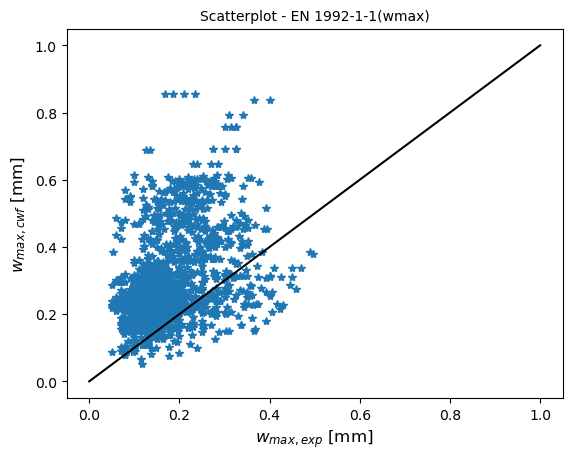

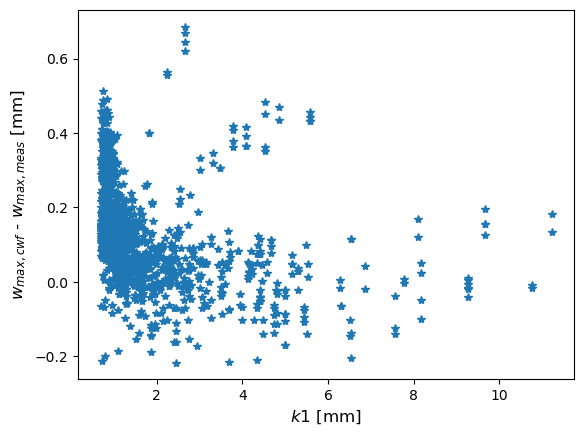

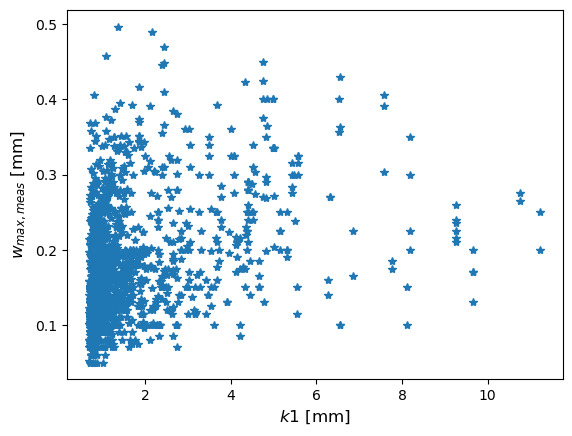

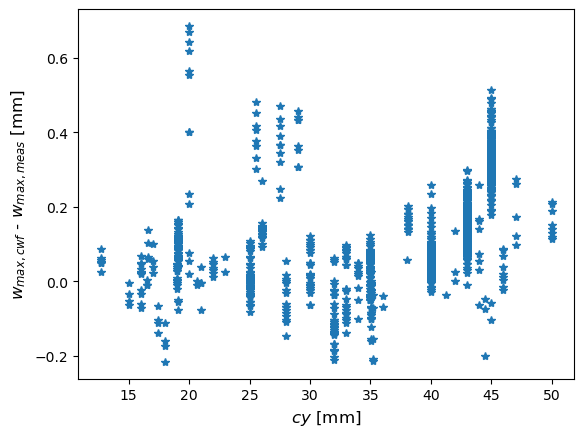

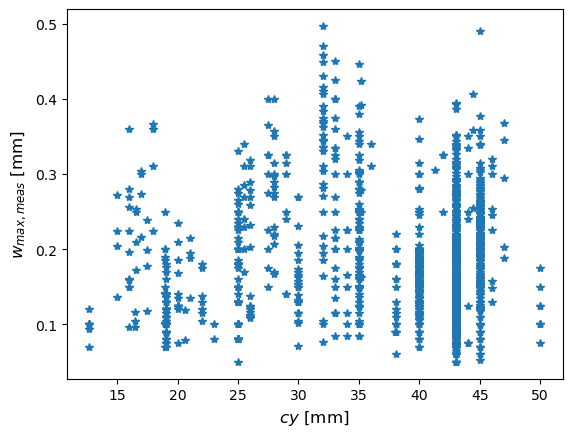

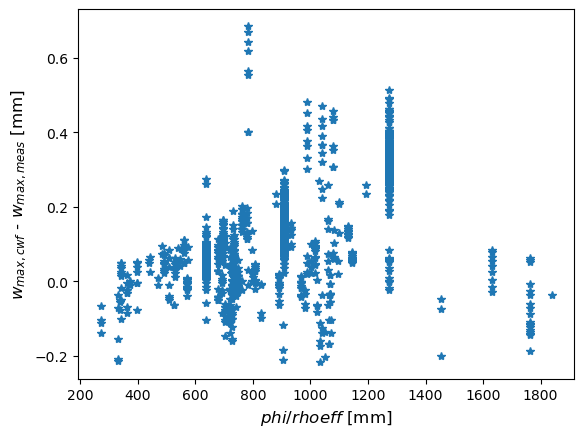

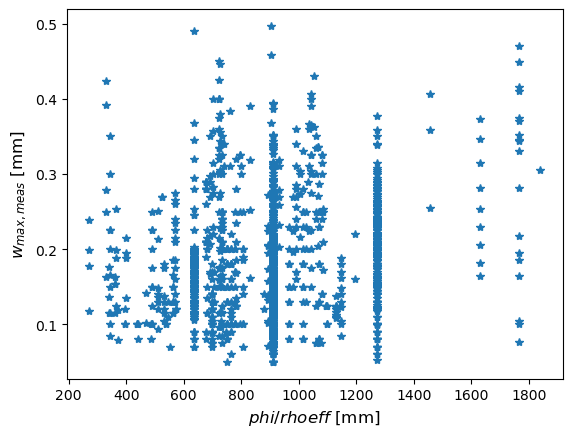

In [100]:
wm_001a, wmax_001a, sm_001a, smax_001a, colors = func_compute_filtered_output_multiple(df,["EN 1992-1-1"]);
func_plot_scatterplot(wmax_001a[0],"wmax","EN 1992-1-1");

#### NEN-EN 1992-1-1

data_shape (1504, 213)
meas_wmax.shape (1504,)
dfwaxfiltered (1483, 15)
wmax_add.shape (1483, 15)
R2-score -0.575


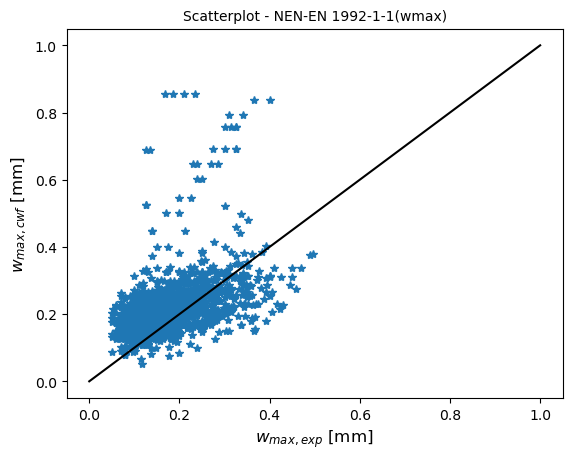

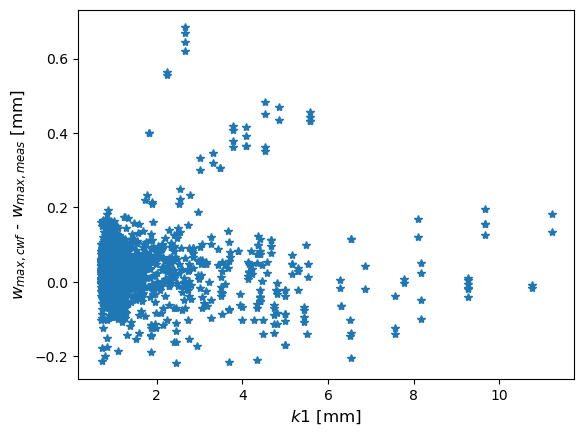

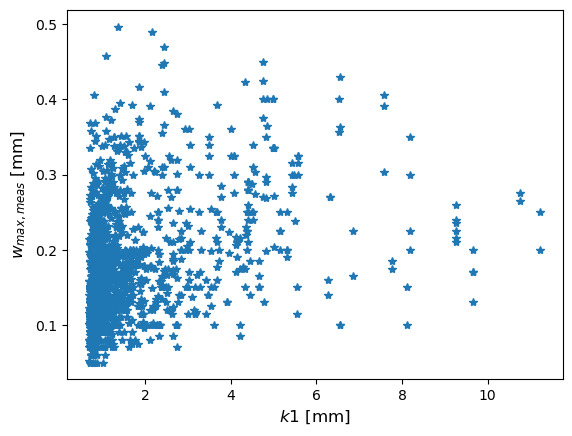

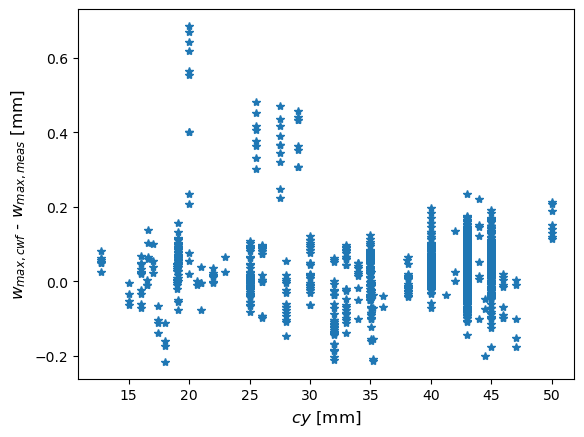

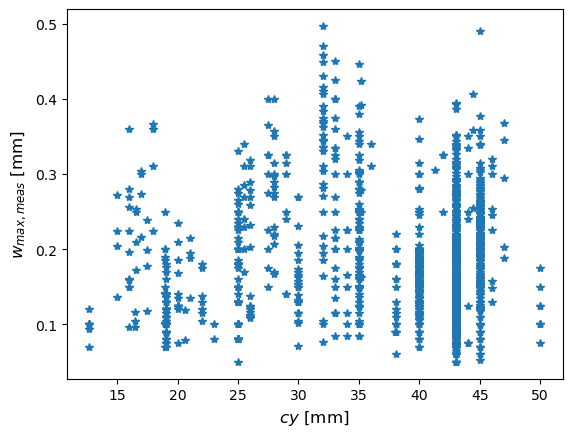

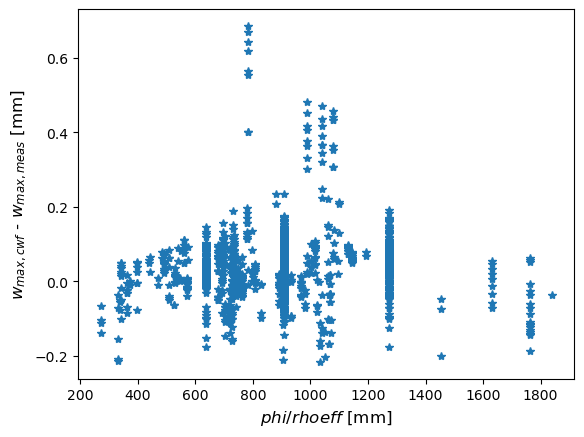

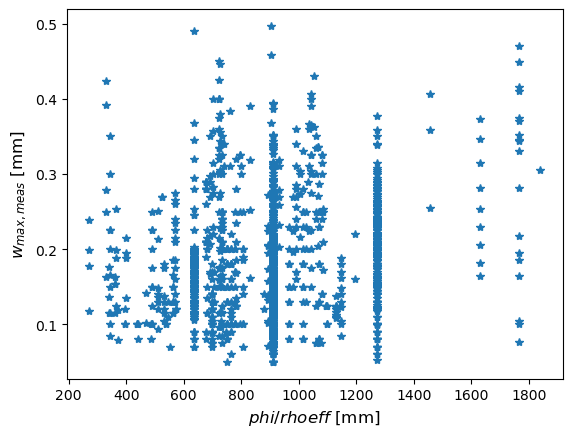

In [104]:
wm_001b, wmax_001b, sm_001b, smax_001b, colors = func_compute_filtered_output_multiple(df,["NEN-EN 1992-1-1"]);
func_plot_scatterplot(wmax_001b[0],"wmax","NEN-EN 1992-1-1");

#### FprEN 1992-1-1

data_shape (1504, 213)
meas_wmax.shape (1504,)
dfwaxfiltered (1504, 15)
wmax_add.shape (1504, 15)
R2-score 0.397


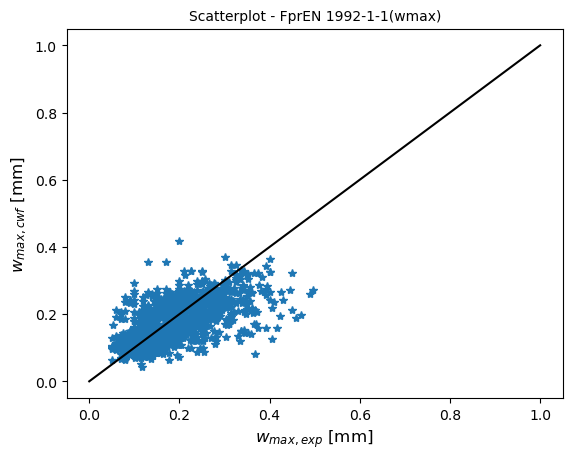

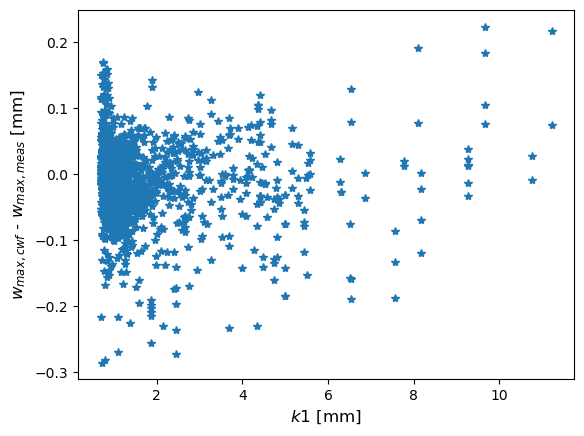

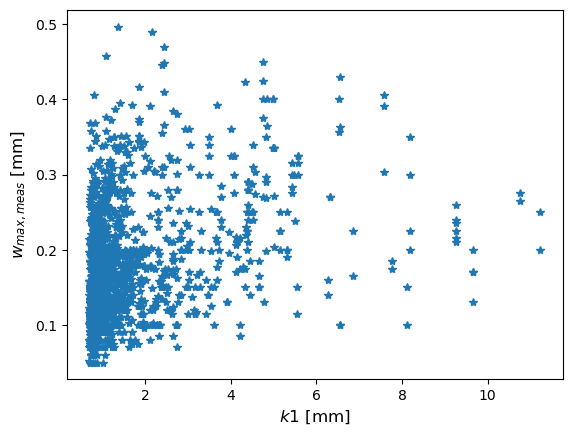

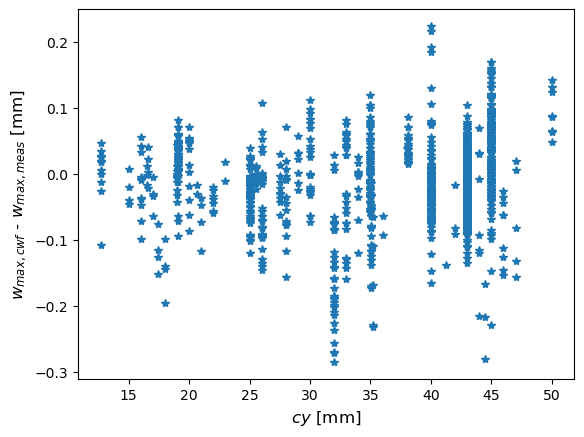

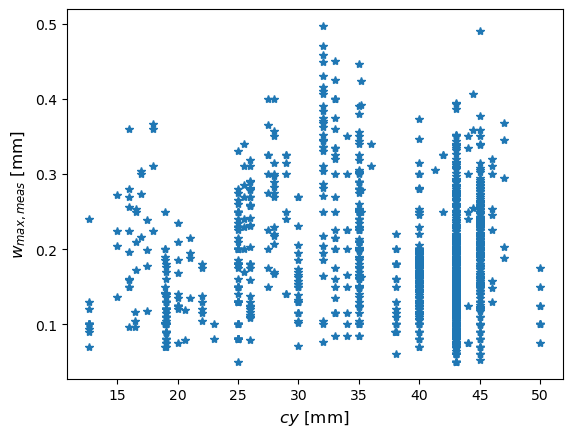

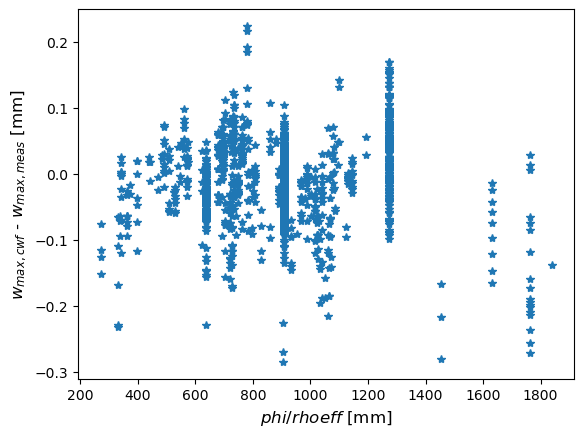

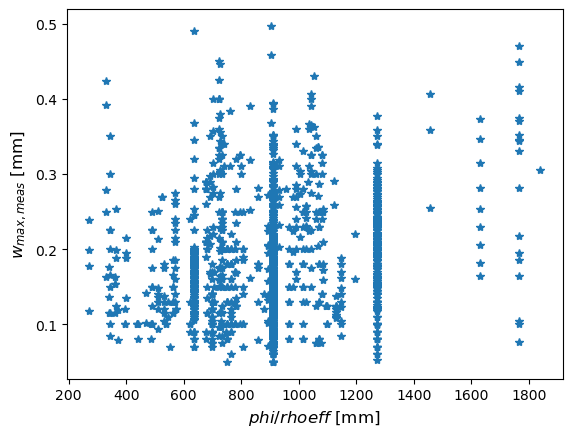

In [106]:
wm_002, wmax_002, sm_002, smax_002, colors = func_compute_filtered_output_multiple(df,["FprEN 1992-1-1"]);
func_plot_scatterplot(wmax_002[0],"wmax","FprEN 1992-1-1");

#### *fib* MC 2010

data_shape (1504, 213)
meas_wmax.shape (1504,)
dfwaxfiltered (1504, 15)
wmax_add.shape (1504, 15)
R2-score 0.321


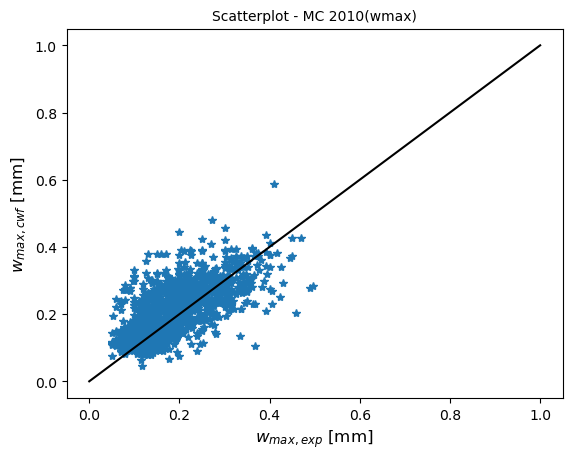

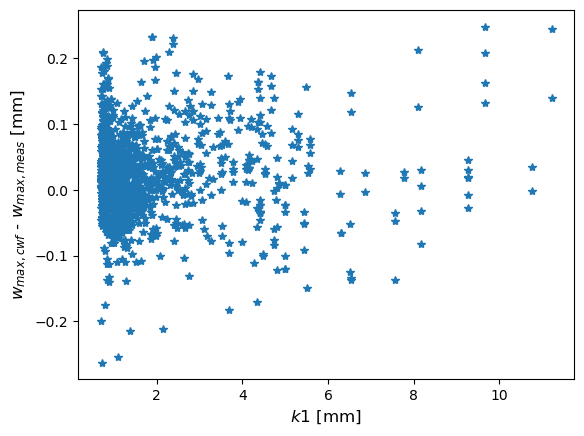

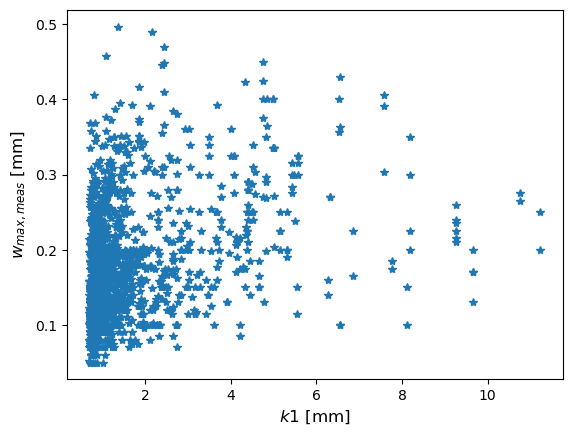

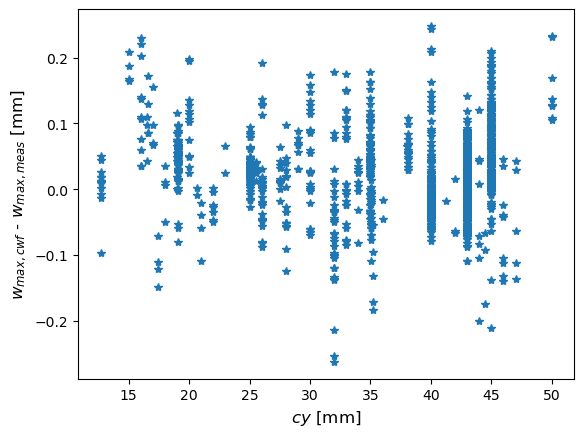

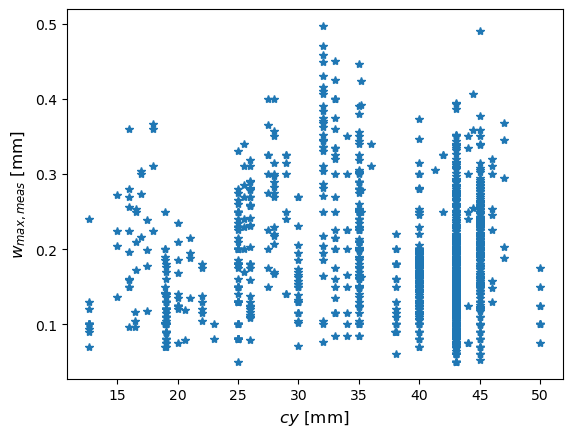

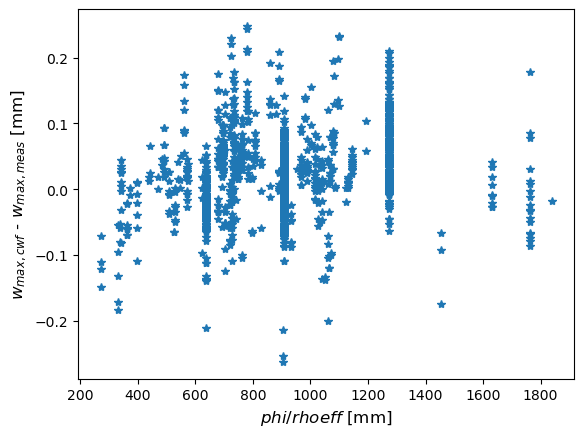

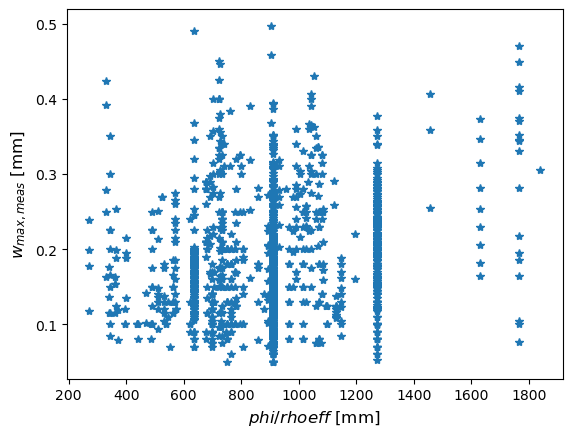

In [108]:
wm_006, wmax_006, sm_006, smax_006, colors = func_compute_filtered_output_multiple(df,["MC 2010"]);
func_plot_scatterplot(wmax_006[0],"wmax","MC 2010");

#### *fib* MC 2020

data_shape (1504, 213)
meas_wmax.shape (1504,)
dfwaxfiltered (1504, 15)
wmax_add.shape (1504, 15)
R2-score 0.261


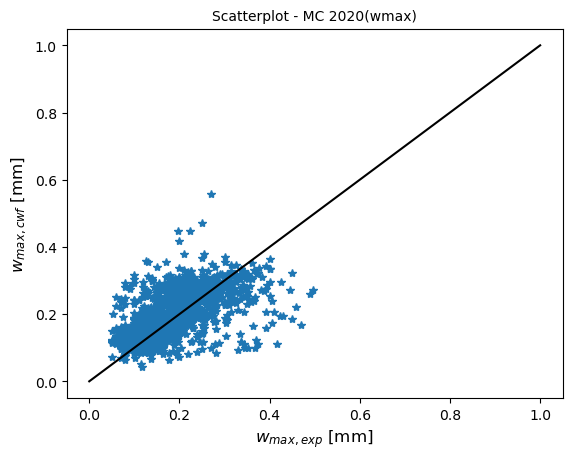

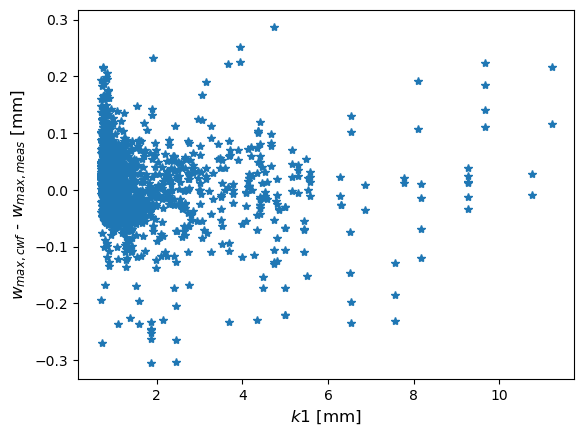

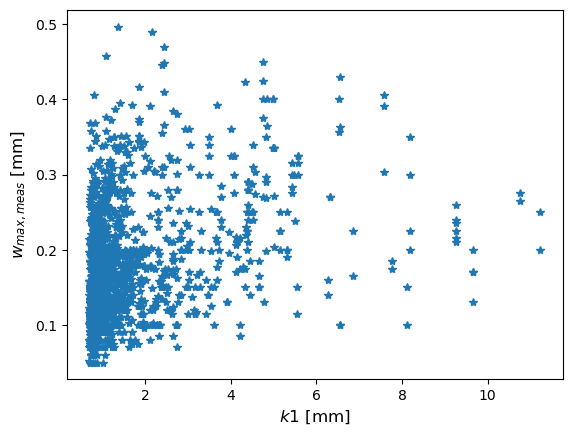

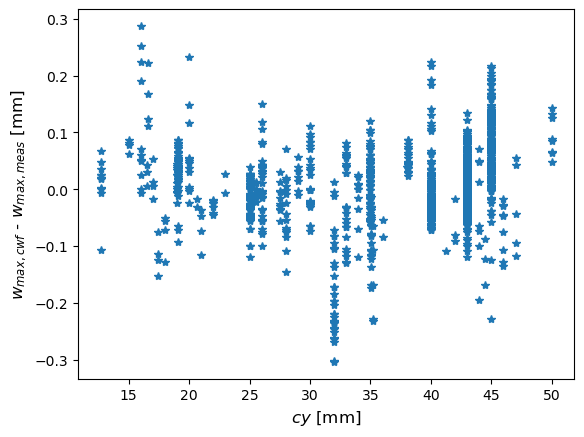

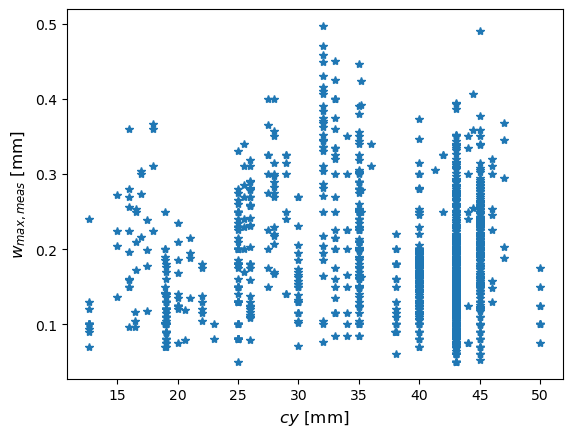

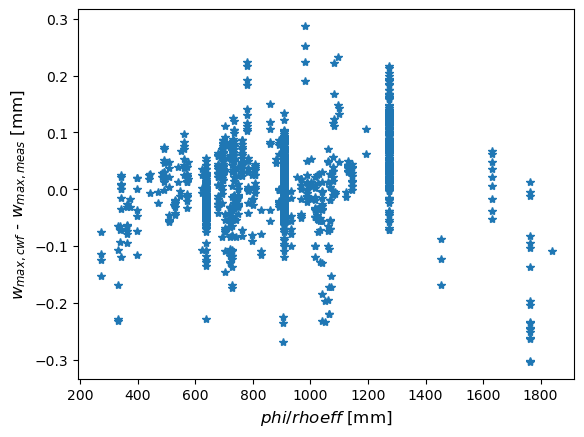

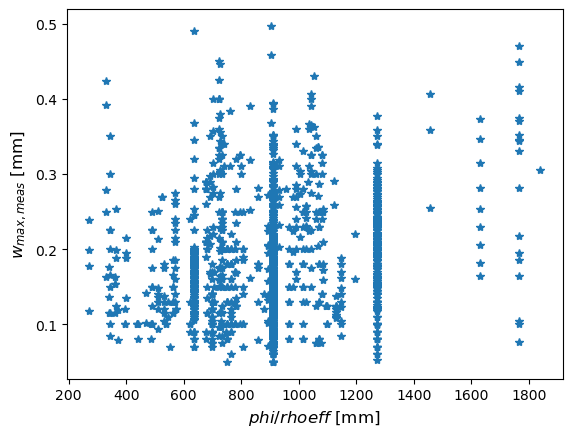

In [111]:
wm_007, wmax_007, sm_007, smax_007, colors = func_compute_filtered_output_multiple(df,["MC 2020"]);
func_plot_scatterplot(wmax_007[0],"wmax","MC 2020");

#### Noakowski

data_shape (1504, 213)
meas_wmax.shape (1504,)
dfwaxfiltered (1504, 15)
wmax_add.shape (1504, 15)
R2-score 0.414


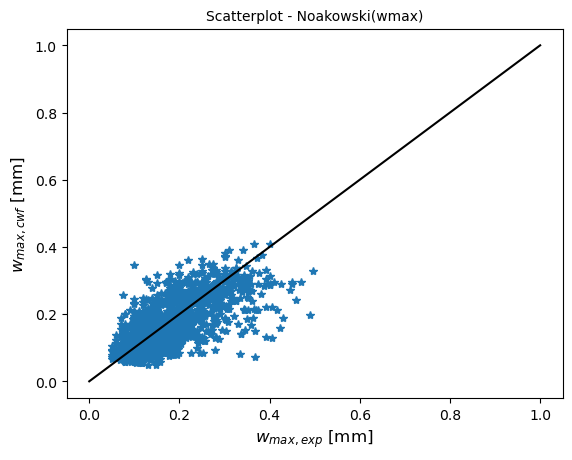

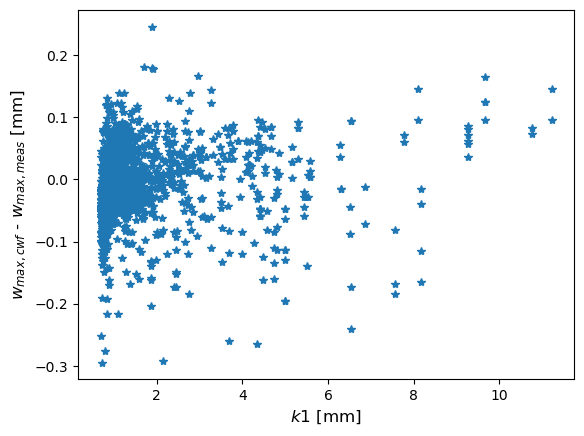

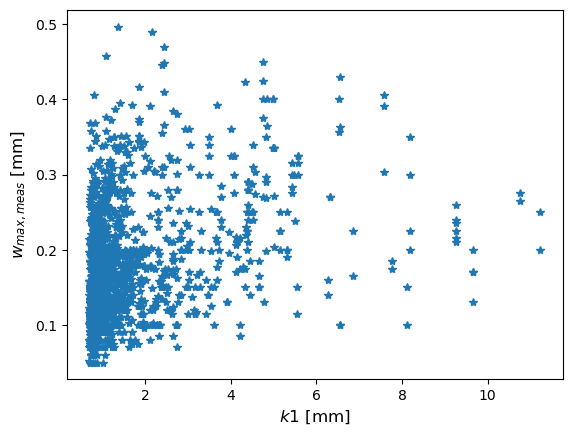

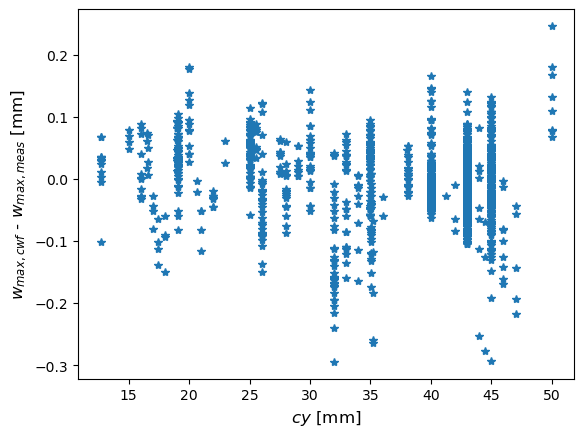

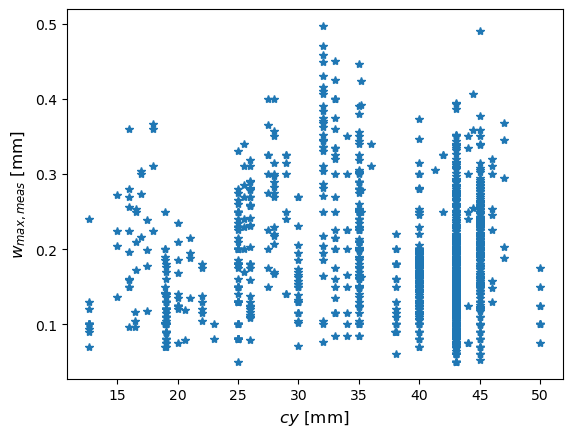

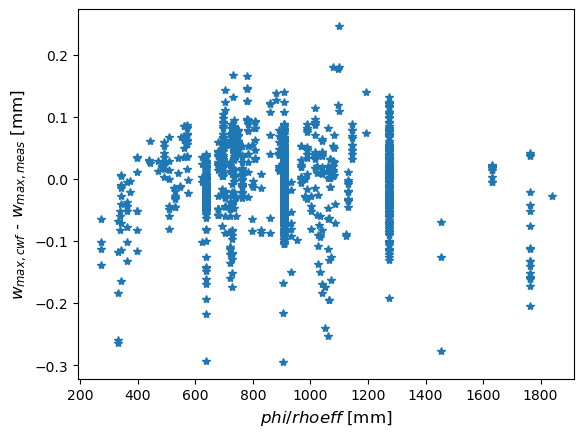

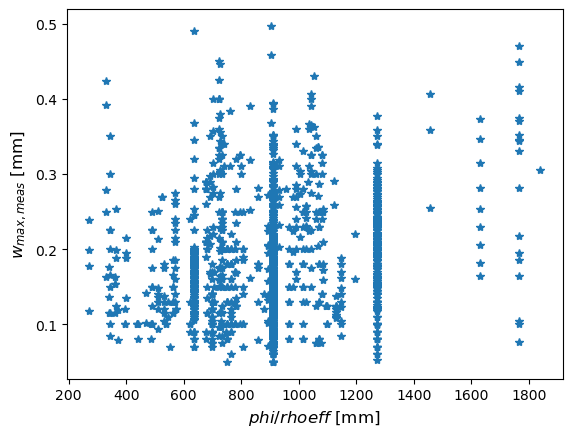

In [113]:
wm_012, wmax_012, sm_012, smax_012, colors = func_compute_filtered_output_multiple(df,["Noakowski"]);
func_plot_scatterplot(wmax_012[0],"wmax","Noakowski");

#### Menn

data_shape (1504, 213)
meas_wmax.shape (1504,)
dfwaxfiltered (1243, 15)
wmax_add.shape (1243, 15)
R2-score -0.542


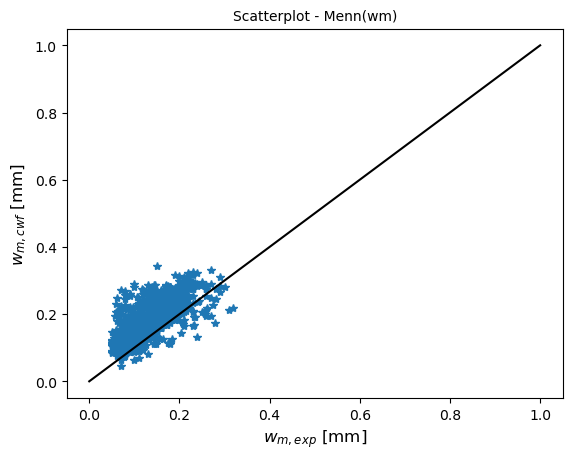

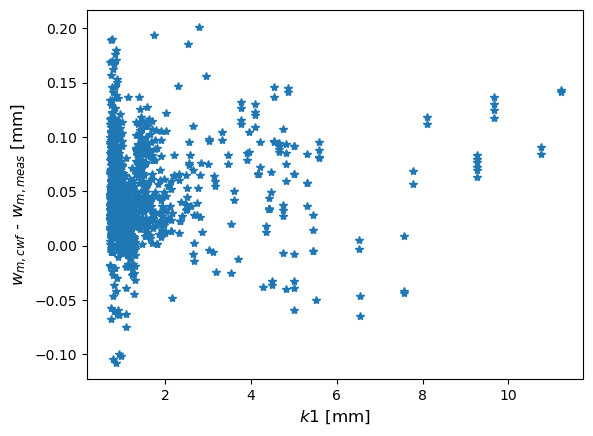

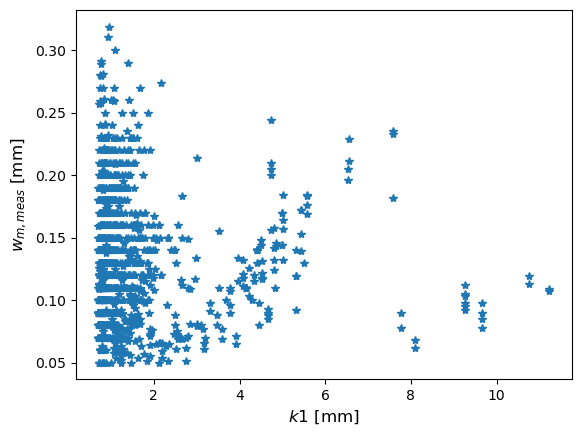

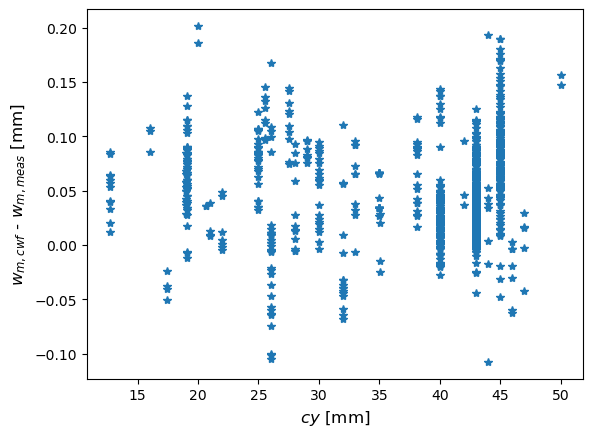

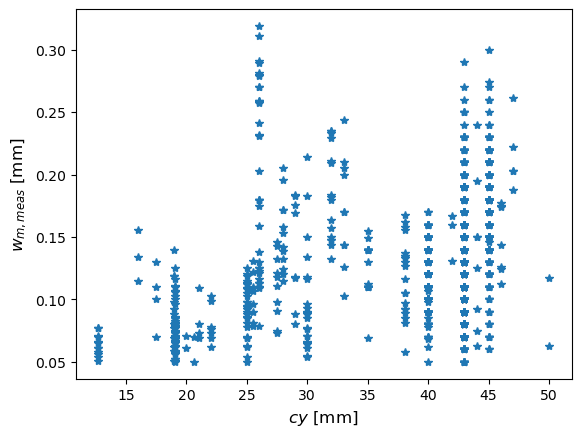

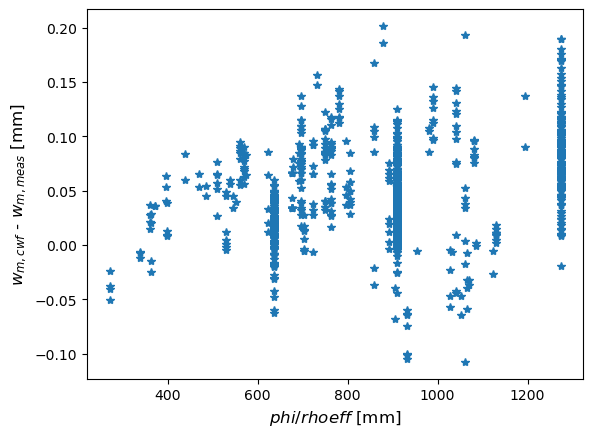

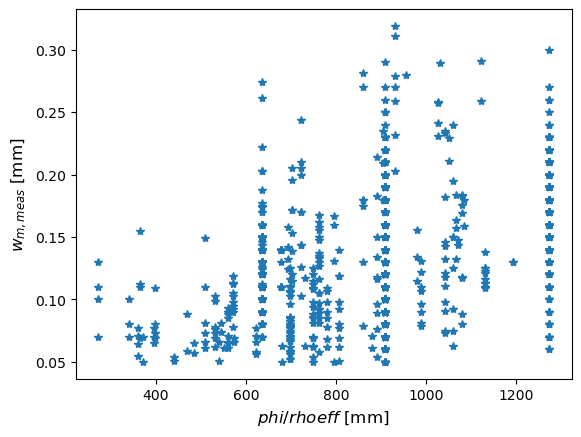

In [115]:
wm_019, wmax_019, sm_019, smax_019, colors = func_compute_filtered_output_multiple(df,["Menn"]);
func_plot_scatterplot(wm_019[0],"wm","Menn");

#### JSCE

data_shape (1504, 213)
meas_wmax.shape (1504,)
dfwaxfiltered (424, 15)
wmax_add.shape (424, 15)
R2-score -1.337


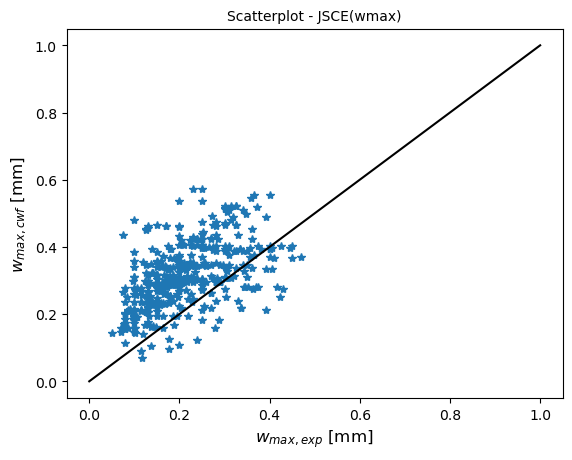

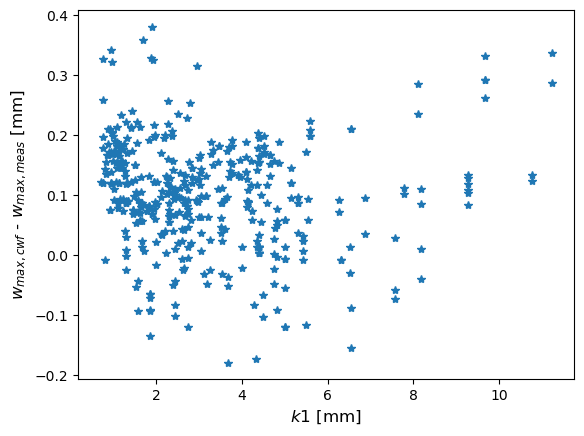

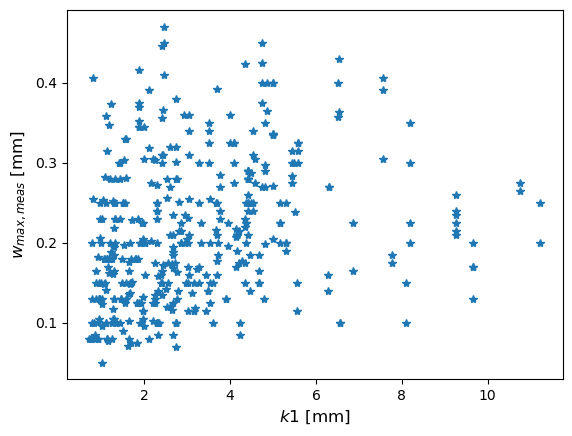

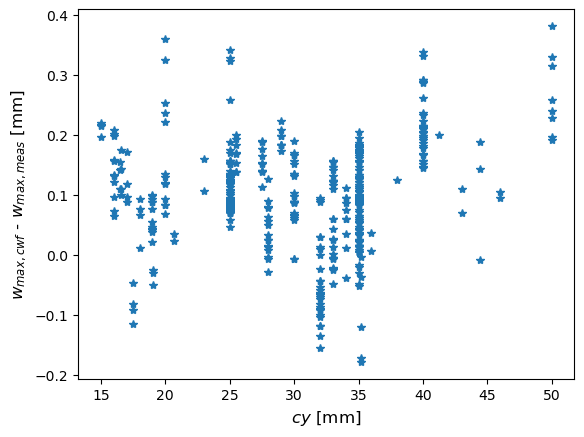

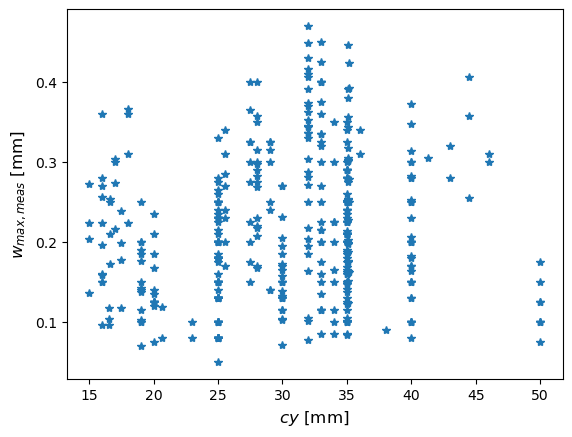

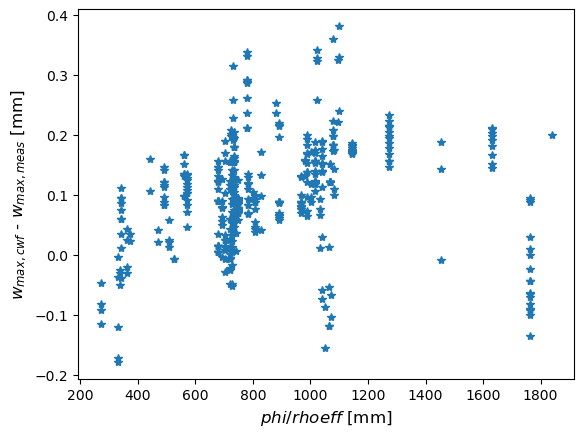

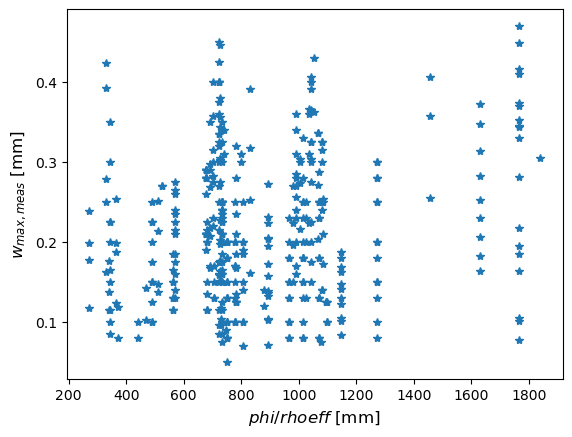

In [117]:
wm_038, wmax_038, sm_038, smax_038, colors = func_compute_filtered_output_multiple(df,["JSCE"]);
func_plot_scatterplot(wmax_038[0],"wmax","JSCE");

#### Oh & Kang

data_shape (1504, 213)
meas_wmax.shape (1504,)
dfwaxfiltered (424, 15)
wmax_add.shape (424, 15)
R2-score 0.238


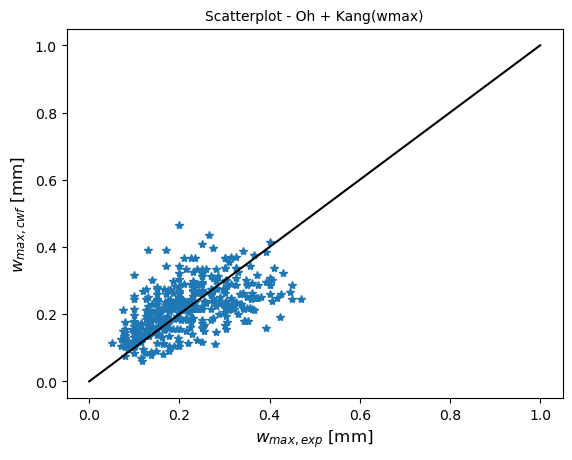

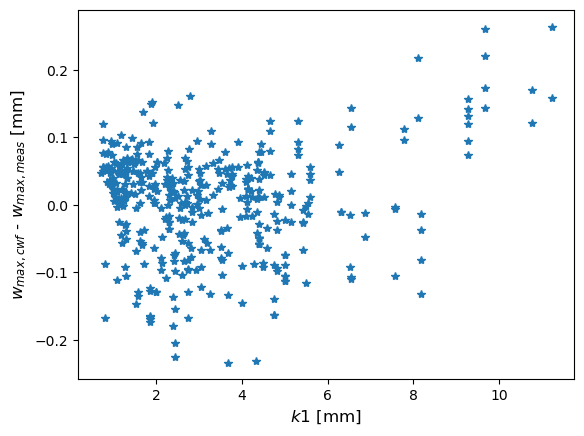

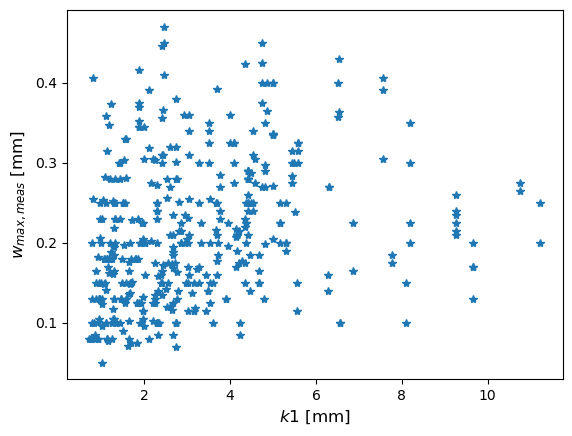

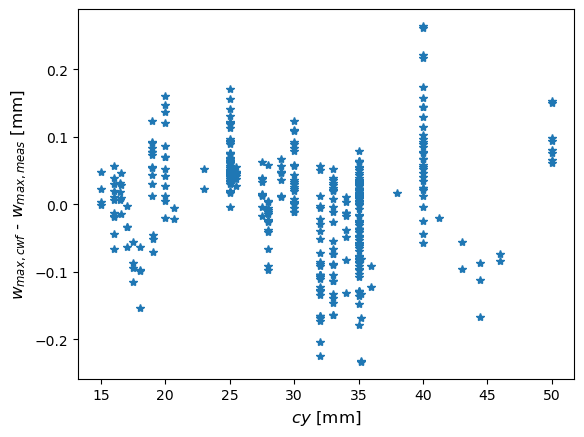

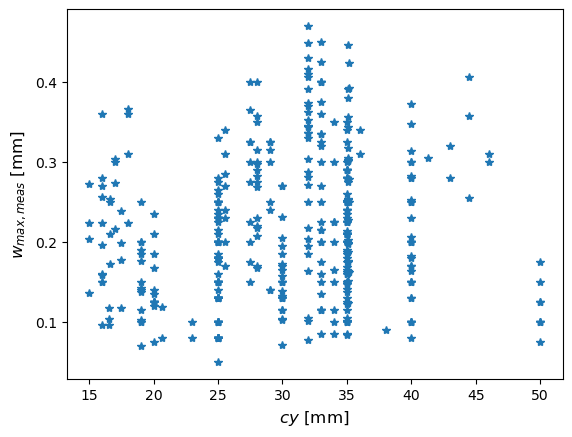

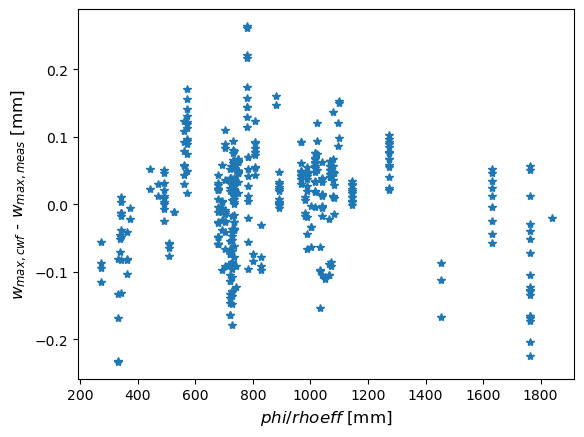

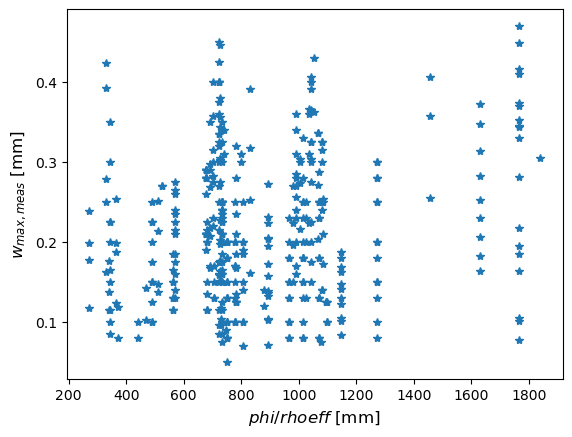

In [119]:
wm_047, wmax_047, sm_047, smax_047, colors = func_compute_filtered_output_multiple(df,["Oh + Kang"]);
func_plot_scatterplot(wmax_047[0],"wmax","Oh + Kang");

#### Gergely and Lutz

data_shape (1504, 213)
meas_wmax.shape (1504,)
dfwaxfiltered (424, 15)
wmax_add.shape (424, 15)
R2-score 0.261


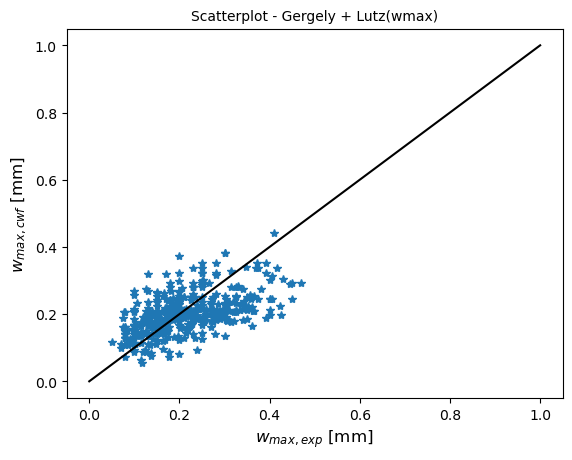

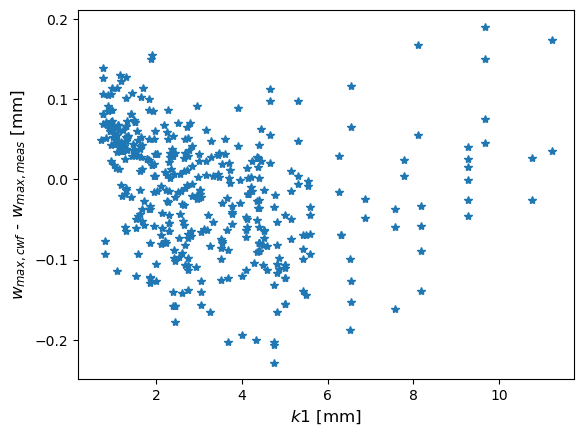

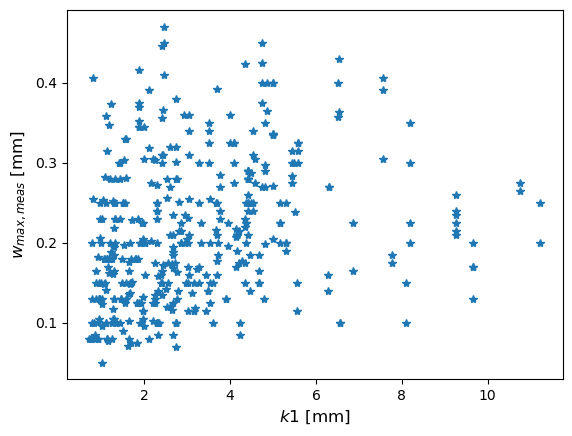

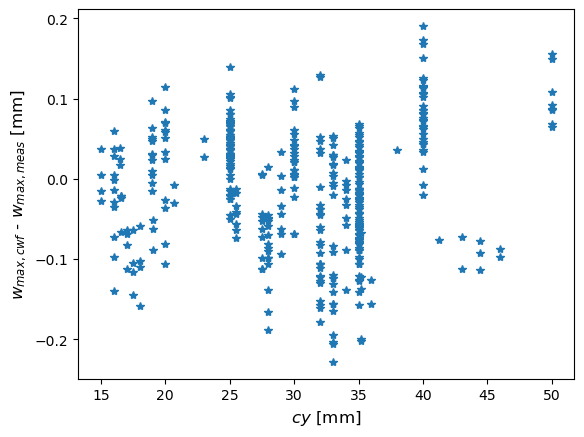

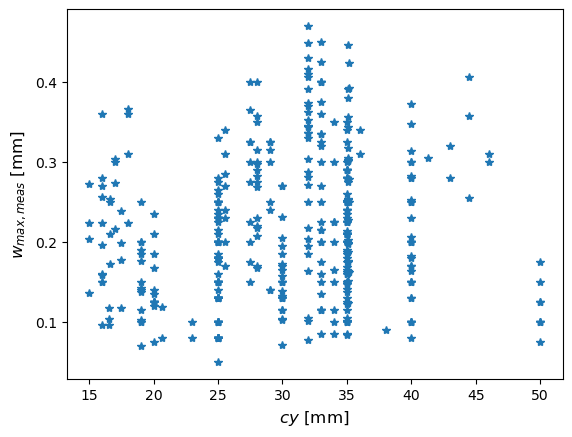

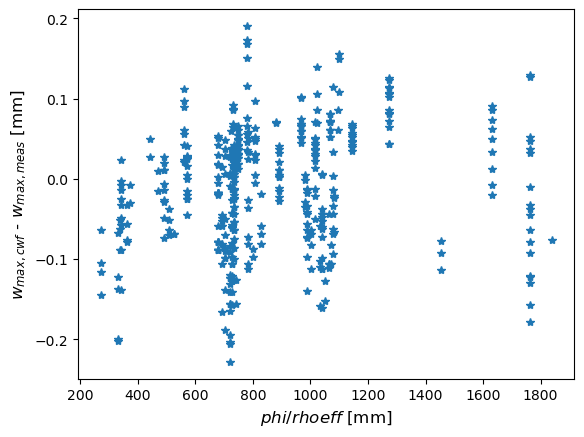

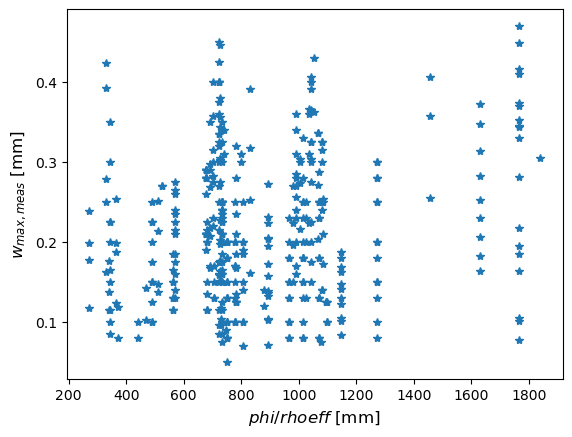

In [121]:
wm_053, wmax_053, sm_053, smax_053, colors = func_compute_filtered_output_multiple(df,["Gergely + Lutz"]);
func_plot_scatterplot(wmax_053[0],"wmax","Gergely + Lutz");

#### Frosch

data_shape (1504, 213)
meas_wmax.shape (1504,)
dfwaxfiltered (424, 15)
wmax_add.shape (424, 15)
R2-score -0.215


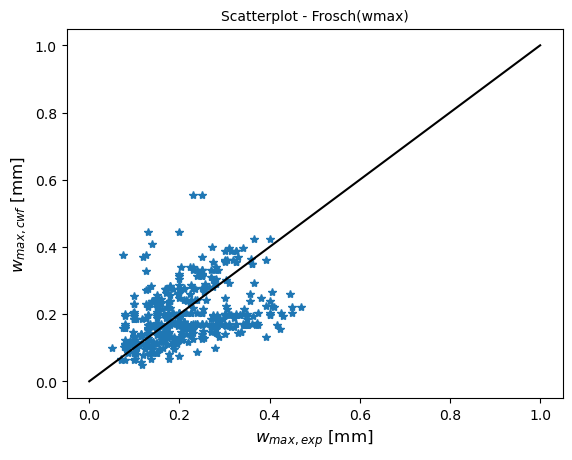

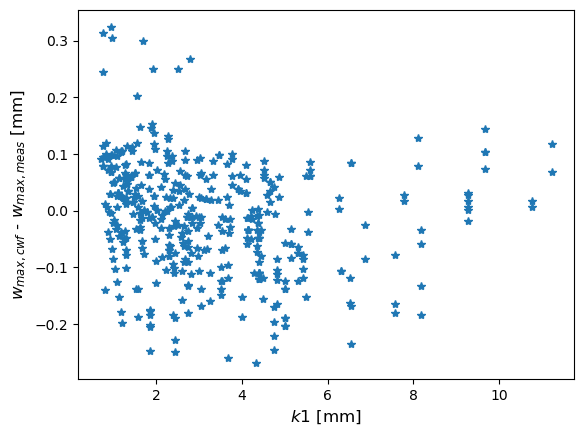

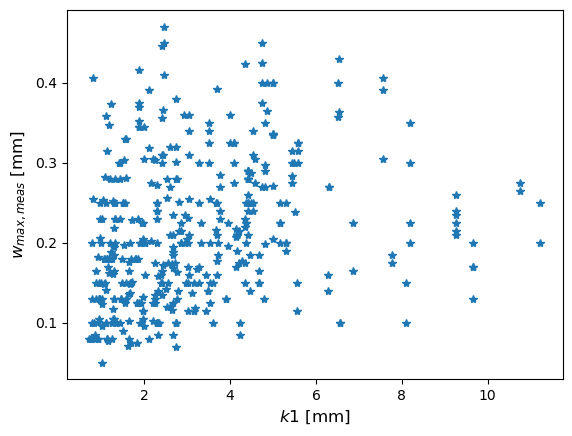

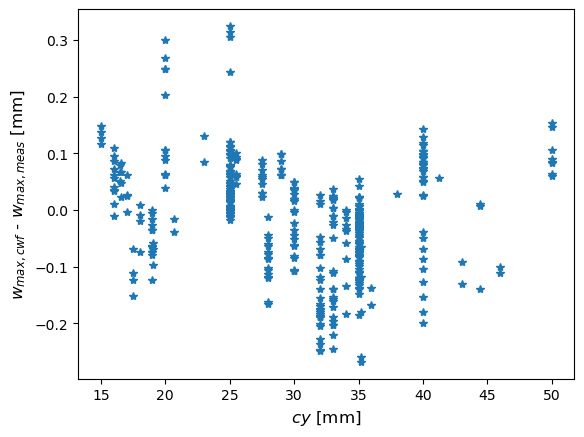

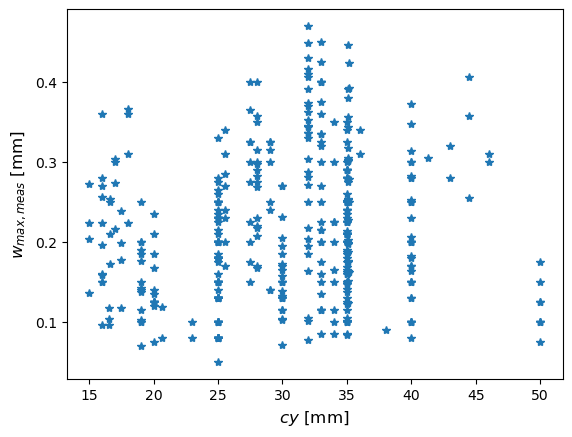

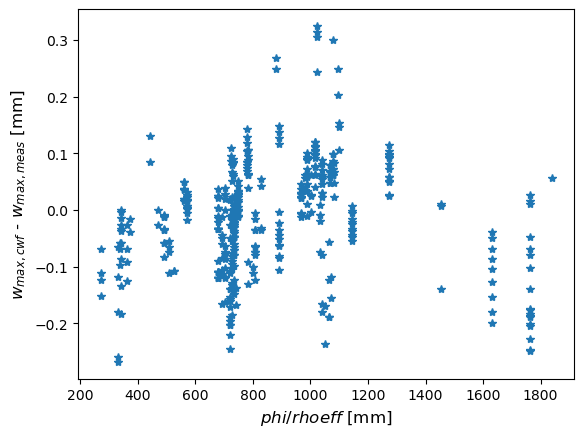

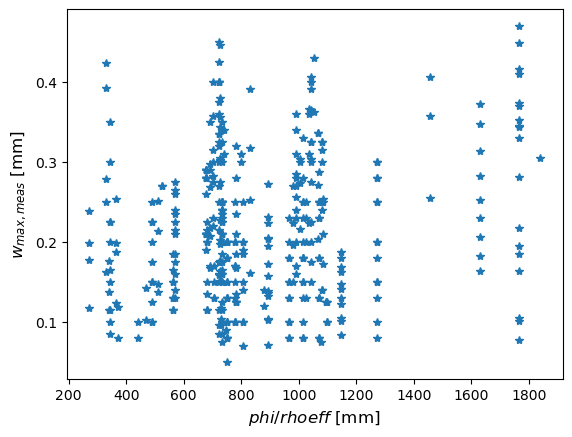

In [123]:
wm_058, wmax_058, sm_058, smax_058, colors = func_compute_filtered_output_multiple(df,["Frosch"]);
func_plot_scatterplot(wmax_058[0],"wmax","Frosch");

#### SMTCM

data_shape (1504, 213)
(1504,)
meas_wmax.shape (1504,)
dfwaxfiltered (1504, 15)
wmax_add.shape (1504, 15)
R2-score -0.01


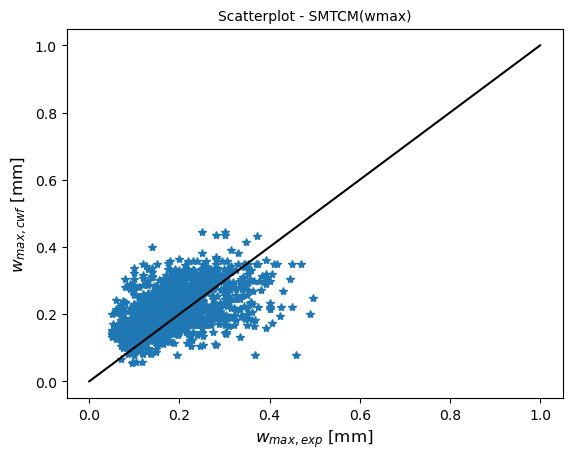

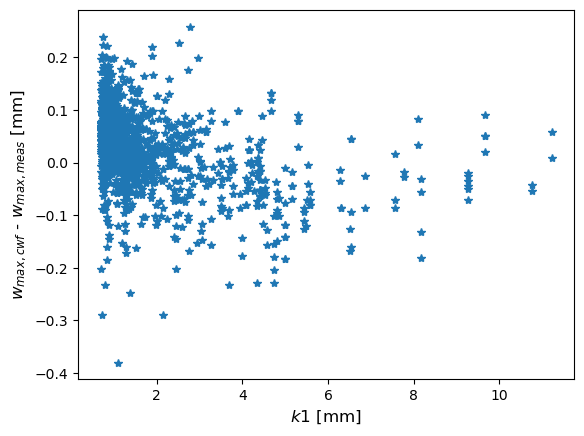

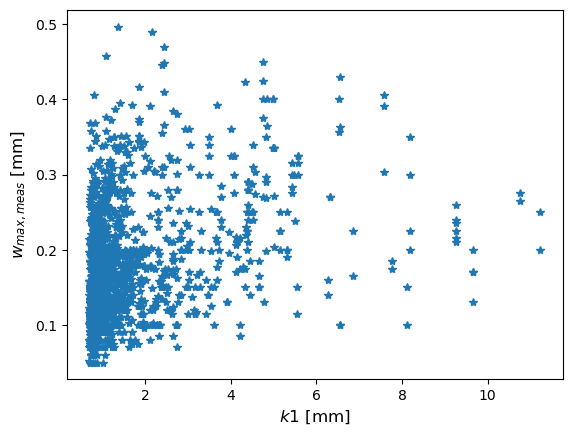

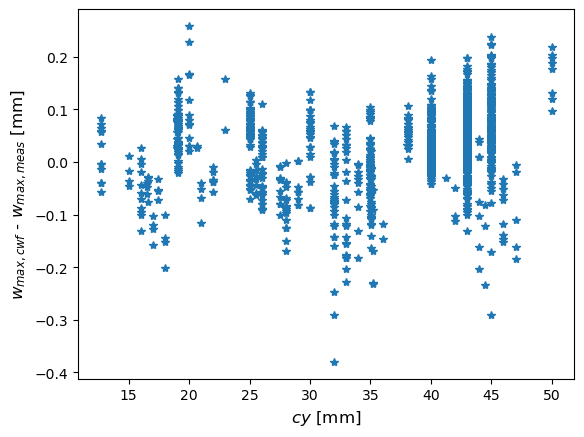

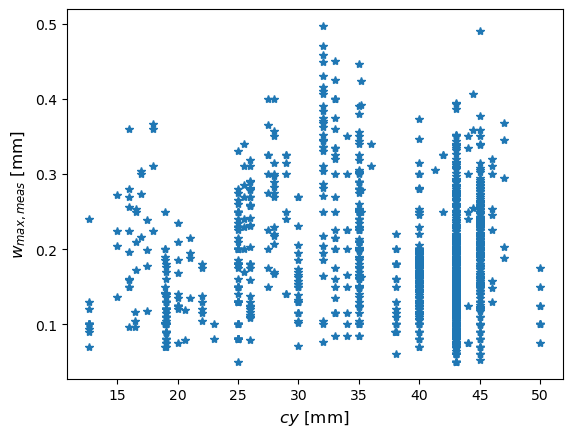

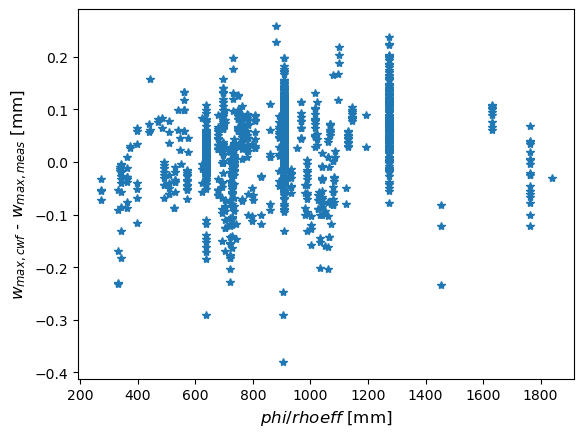

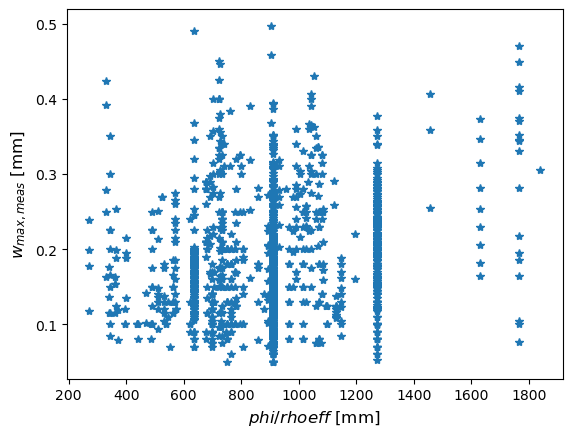

In [125]:
wm_095, wmax_095, sm_095, smax_095, colors = func_compute_filtered_output_multiple(df,["SMTCM"]);
func_plot_scatterplot(wmax_095[0],"wmax","SMTCM");

In [129]:
from scipy import stats
stats.kstest(wmax_001a[0]["cwf_wmax"], wmax_001b[0]["cwf_wmax"])

KstestResult(statistic=0.38165879973027644, pvalue=1.2522976184163645e-96, statistic_location=0.2268003769953075, statistic_sign=-1)

### Refined analysis

#### Defintion of bounds

In [135]:
basepath = Path(r"C:\Users/20210065/OneDrive - TU Eindhoven/60_Publications/1_st_Journal_Paper/");
softbounds = pd.read_excel(Path(basepath/r"List_of_CWFs_boundaries\List_of_CWF_boundaries.xlsx"),"Export_soft_bounds");

In [137]:
list_A0 = ["MC 2010","MC 2020","Noakowski","Menn","SMTCM"];
hardfilter_A0 = "epsin == '1a' and cy <= 75 and Astot > @tol and Aptot < @tol and fsr ==2";
softfilter_A0 = "wmax < tol and smax < 300 and cy < 80";

list_C = ["MC 2010","Noakowski","Gergely + Lutz","SMTCM"];
hardfilter_C = "epsin == '2' and cy <= 75 and Astot > @tol and Aptot < @tol and locw == 1 and fsr == 2";
softfilter_C = "cy < 110 and wmax < 1.2 and smax < 800";

list_D = ["MC 2010","MC 2020","Oh + Kang","Noakowski","JSCE","Gergely + Lutz","SMTCM"];
hardfilter_D = "epsin == '2' and cy <= 75 and Astot > @tol and Aptot < @tol and locw == 2 and fsr == 2";
softfilter_D = "wmax < 1.6 and smax < 803";

list_C_star = ["MC 2010","Noakowski","Menn","Gergely + Lutz","SMTCM"];
hardfilter_C_star = "epsin == '2' and cy <= 75 and Astot > @tol and Aptot < @tol and locw == 1 and fsr == 2 and h-xc <=0.75*h";
softfilter_C_star = "cy < 110 and wmax < 1.2 and smax < 800";

list_D_star = ["MC 2010","MC 2020","Oh + Kang","Noakowski","Menn","JSCE","Gergely + Lutz","SMTCM"];
hardfilter_D_star = "epsin == '2' and cy <= 75 and Astot > @tol and Aptot < @tol and locw == 2 and fsr == 2 and h-xc <=0.75*h";
softfilter_D_star = "wmax < 1.6 and smax < 803";


In [138]:
def func_apply_group_filter(data,hardfilter,softfilter):
    datafiltered = data.copy();
    if hard_constraints == "yes":
        datafiltered = datafiltered.query(hardfilter);
    if soft_constraints == "yes":
        datafiltered = datafiltered.query(softfilter);
        
    print("Number of datapoints",datafiltered.shape[0]);
    print("Number of tested elements",datafiltered['ELID'].nunique());

    return datafiltered

#### Group A0: tension

In [139]:
df_A0 = func_apply_group_filter(df,hardfilter_A0,softfilter_A0);
wm_A0, wmax_A0, sm_A0, smax_A0, colors_A0 = func_compute_filtered_output_multiple(df_A0,list_A0);

Number of datapoints 1080
Number of tested elements 150
data_shape (1080, 213)
meas_wmax.shape (1080,)
dfwaxfiltered (1080, 15)
wmax_add.shape (1080, 15)
meas_wmax.shape (1080,)
dfwaxfiltered (1080, 15)
wmax_add.shape (1080, 15)
meas_wmax.shape (1080,)
dfwaxfiltered (1080, 15)
wmax_add.shape (1080, 15)
meas_wmax.shape (1080,)
dfwaxfiltered (1080, 15)
wmax_add.shape (1080, 15)
(1080,)
meas_wmax.shape (1080,)
dfwaxfiltered (1080, 15)
wmax_add.shape (1080, 15)


#### Group C: bending, side face

In [152]:
df_C = func_apply_group_filter(df,hardfilter_C,softfilter_C);
wm_C, wmax_C, sm_C, smax_C, colors_C = func_compute_filtered_output_multiple(df_C,list_C);

Number of datapoints 210
Number of tested elements 61
data_shape (210, 213)
meas_wmax.shape (210,)
dfwaxfiltered (210, 15)
wmax_add.shape (210, 15)
meas_wmax.shape (210,)
dfwaxfiltered (210, 15)
wmax_add.shape (210, 15)
meas_wmax.shape (210,)
dfwaxfiltered (210, 15)
wmax_add.shape (210, 15)
(210,)
meas_wmax.shape (210,)
dfwaxfiltered (210, 15)
wmax_add.shape (210, 15)


#### Group D: bending, bottom face

In [163]:
df_D = func_apply_group_filter(df,hardfilter_D,softfilter_D);
wm_D, wmax_D, sm_D, smax_D, colors_D = func_compute_filtered_output_multiple(df_D,list_D);

Number of datapoints 214
Number of tested elements 52
data_shape (214, 213)
meas_wmax.shape (214,)
dfwaxfiltered (214, 15)
wmax_add.shape (214, 15)
meas_wmax.shape (214,)
dfwaxfiltered (214, 15)
wmax_add.shape (214, 15)
meas_wmax.shape (214,)
dfwaxfiltered (214, 15)
wmax_add.shape (214, 15)
meas_wmax.shape (214,)
dfwaxfiltered (214, 15)
wmax_add.shape (214, 15)
meas_wmax.shape (214,)
dfwaxfiltered (214, 15)
wmax_add.shape (214, 15)
meas_wmax.shape (214,)
dfwaxfiltered (214, 15)
wmax_add.shape (214, 15)
(214,)
meas_wmax.shape (214,)
dfwaxfiltered (214, 15)
wmax_add.shape (214, 15)


### Group C-star

In [173]:
df_C_star = func_apply_group_filter(df,hardfilter_C_star,softfilter_C_star);
#wm_C_star, wmax_C_star, sm_C_star, smax_C_star, colors_C_star = func_compute_filtered_output_multiple(df_C_star,list_C_star);

Number of datapoints 91
Number of tested elements 26


In [175]:
# ==================

### Group D-star

In [176]:
df_D_star = func_apply_group_filter(df,hardfilter_D_star,softfilter_D_star);
#wm_D_star, wmax_D_star, sm_D_star, smax_D_star, colors_D_star = func_compute_filtered_output_multiple(df_D_star,list_D_star);

Number of datapoints 72
Number of tested elements 19


#### Combined plot - to be incorporated in paper $w_{max}$

In [178]:
plotcutoff_overall = 10;
plotcutoff_detail = 10;

Number of datapoints 1080
Number of tested elements 150
data_shape (1080, 213)
meas_wmax.shape (1080,)
dfwaxfiltered (1080, 15)
wmax_add.shape (1080, 15)
meas_wmax.shape (1080,)
dfwaxfiltered (1080, 15)
wmax_add.shape (1080, 15)
meas_wmax.shape (1080,)
dfwaxfiltered (0, 15)
wmax_add.shape (0, 15)
meas_wmax.shape (1080,)
dfwaxfiltered (1080, 15)
wmax_add.shape (1080, 15)
meas_wmax.shape (1080,)
dfwaxfiltered (1080, 15)
wmax_add.shape (1080, 15)
meas_wmax.shape (1080,)
dfwaxfiltered (0, 15)
wmax_add.shape (0, 15)
meas_wmax.shape (1080,)
dfwaxfiltered (0, 15)
wmax_add.shape (0, 15)
(1080,)
meas_wmax.shape (1080,)
dfwaxfiltered (1080, 15)
wmax_add.shape (1080, 15)
150
150
0
150
150
0
0
150
Number of datapoints 210
Number of tested elements 61
data_shape (210, 213)
meas_wmax.shape (210,)
dfwaxfiltered (210, 15)
wmax_add.shape (210, 15)
meas_wmax.shape (210,)
dfwaxfiltered (0, 15)
wmax_add.shape (0, 15)
meas_wmax.shape (210,)
dfwaxfiltered (0, 15)
wmax_add.shape (0, 15)
meas_wmax.shape (210,

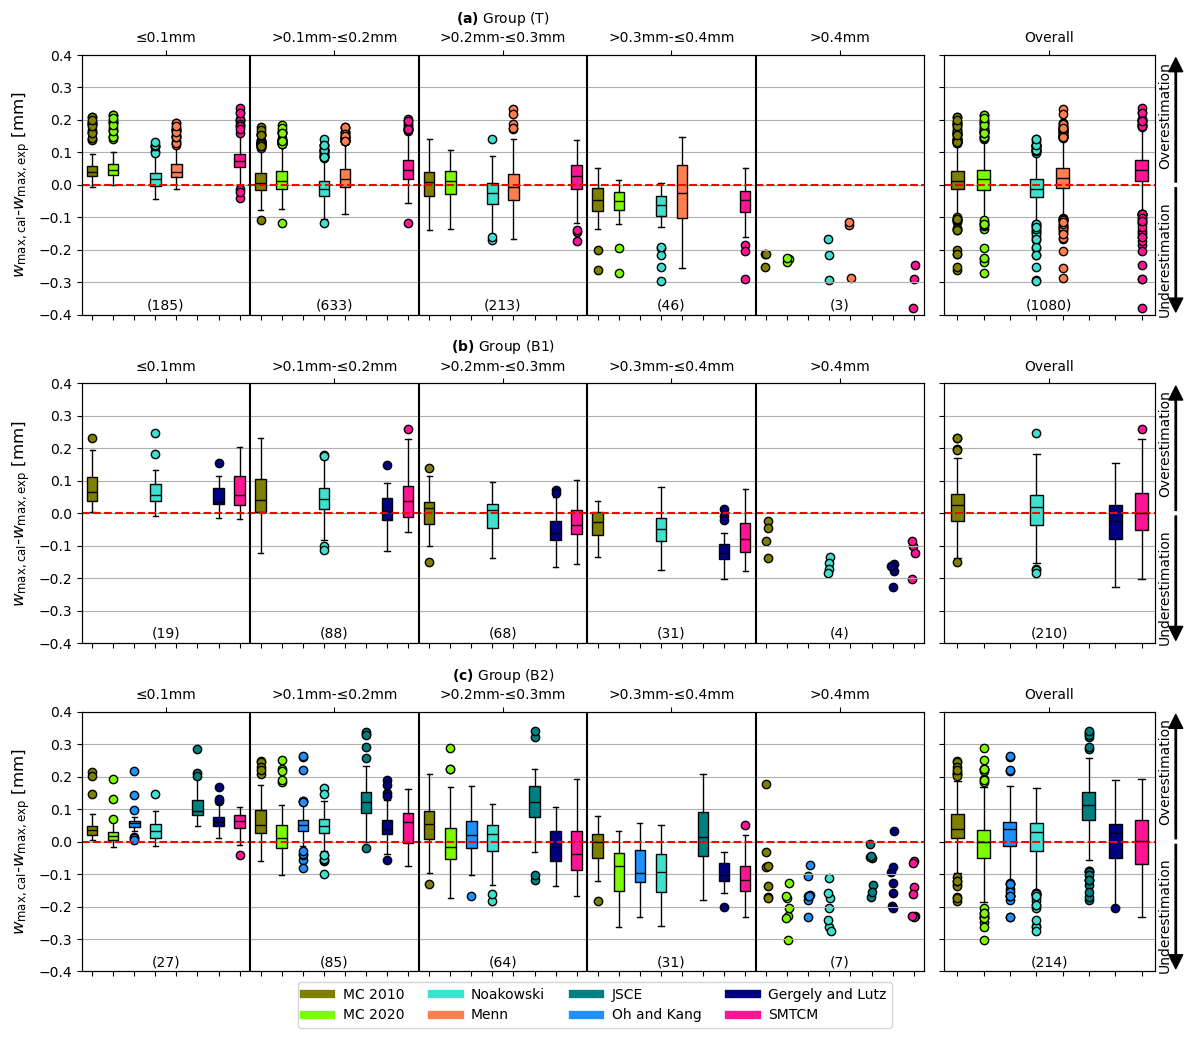

In [183]:
fig,ax = plt.subplots(nrows = 3, ncols = 2, gridspec_kw = {"width_ratios": [4,1]}, figsize=(round(1.3*9),10));
ax2_0 = ax[0,0].twiny();
ax2_1 = ax[1,0].twiny();
ax2_2 = ax[2,0].twiny();

bounds = binchoice_w;
tempvar = "meas_wmax";

# Group A
# ==============================================================================================================================
# Overall error - Group A
# --------------------------------------------------------
ax[0,1].set_ylim(-0.4,0.4);
ax[0,1].yaxis.set_ticklabels([]);

err_A0 = [];
Npoints_A0 = [];
err_A0_art = []; col_A0_art = [];

#list_A0 = ["EN 1992-1-1","NEN-EN 1992-1-1","FprEN 1992-1-1","MC 2010","MC 2020","","Noakowski","","","SMTCM"];
list_A0 = ["MC 2010","MC 2020","","Noakowski","Menn","","","SMTCM"];

df_A0 = func_apply_group_filter(df,hardfilter_A0,softfilter_A0);
wm_A0, wmax_A0, sm_A0, smax_A0, colors_A0 = func_compute_filtered_output_multiple(df_A0,list_A0);

for i in range(len(list_A0)):
    diff = wmax_A0[i]["cwf_wmax"] - wmax_A0[i]["meas_wmax"];
    print(wmax_A0[i]["ELID"].nunique())

    err_A0.append(diff); Npoints_A0.append(len(diff)); 
    err_A0_art.append(diff); err_A0_art.append(diff);
    col_A0_art.append(colors_A0); col_A0_art.append(colors_A0);

bplot = ax[0,1].boxplot(err_A0,patch_artist=True);
#bplot = ax[0,1].boxplot(err_A0,patch_artist=True,positions = [1,2,3,4,5,7,10]);
#viol = ax[0,1].violinplot(err_A0);

for err,patch_box,patch_flier,patch_med,col in \
    zip(err_A0,bplot["boxes"],bplot["fliers"],bplot["medians"],colors_A0):
    #zip(err_A0,bplot["boxes"],bplot["fliers"],bplot["medians"],viol["bodies"],colors_A0):
    if err.shape[0] < plotcutoff_overall:
        patch_box.set_visible(False);
        patch_med.set_visible(False)
        patch_flier.set_visible(False)

        #pc.set_visible(False);
    
    else:
        patch_box.set_facecolor(col);
        patch_med.set_color("k");
        patch_flier.set_markerfacecolor(col);

        #pc.set_facecolor(col);
        
        #for pc in viol["bodies"]:
            #pc.set_edgecolor("k");
            #pc.set_facecolor(col);

for err_A0_art,patch_whis,patch_cap,col in \
    zip(err_A0_art,bplot["whiskers"],bplot["caps"],col_A0_art):
        if err_A0_art.shape[0] < plotcutoff_overall:
            patch_whis.set_visible(False)
            patch_cap.set_visible(False)
    
for i in range(len(list_A0)):
    if err_A0[i].shape[0] < plotcutoff_overall:
        ax[0,1].scatter(1 + i + np.random.uniform(-0.1,0.1,len(err_A0[i])),err_A0[i],zorder=10,c=colors_A0[i],\
                           edgecolors="k");

ax[0,1].set_xticks(np.linspace(1,len(list_A0),len(list_A0)),[],rotation=60,ha="right");
#ax[0,1].set_xticks(np.linspace(1,10,10),[],rotation=60,ha="right");
ax[0,1].axhline(y=0,c="r",linestyle="--");

ax[0,1].text((len(list_A0)+1)/2,-0.35,"("+str(len(err_A0[-1]))+")",horizontalalignment="center",verticalalignment="top");
#ax[0,1].text(10/2,-0.45,len(err_A0[-1]),horizontalalignment="center",verticalalignment="top");

ax0_2_overall = ax[0,1].twiny();
ax0_2_overall.set_xticks([0.5]);
ax0_2_overall.set_xticklabels(["Overall"]);

x0 = 1.1
trans = mtransforms.blended_transform_factory(ax[0,1].transAxes, ax[0,1].transData)
y_tail = 0
y_head = 0.4
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax[0,1].add_patch(arrow1)
ax[0,1].text(1.05,0.05,"Overestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="bottom");
y_tail = 0
y_head = -0.4
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax[0,1].add_patch(arrow1)
ax[0,1].text(1.05,-0.05,"Underestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="top");
ax[0,1].grid(axis="y");

fig.tight_layout();

# Detailed
# --------------------------------------------------------
xlabel = [];
col = []; col_A0_art = [];
err_detailed_A0 = []; err_detailed_A0_art = [];

for i in range(0,len(bounds)+1):
    if i == 0:
        xlabel.append("≤"+str(bounds[0])+"mm");
    elif i == len(bounds):
        xlabel.append(">"+str(bounds[len(bounds)-1])+"mm");
    else:
        xlabel.append(">"+str(bounds[i-1])+"mm-≤"+str(bounds[i])+"mm");

    datastore = [];
    namestore = [];
    
    for j in range(len(list_A0)):
        if i == 0:
            temp = wmax_A0[j][(wmax_A0[j][tempvar] <= bounds[0])];
        elif i == len(bounds):
            temp = wmax_A0[j][(wmax_A0[j][tempvar] > bounds[len(bounds)-1])];
        else:
            temp = wmax_A0[j][((wmax_A0[j][tempvar] > bounds[i-1]) & (wmax_A0[j][tempvar] <= bounds[i]))];
    
        name = str("wmax"+"dataset"+str(i));
        datastore.append(temp);
        namestore.append(name);
    
        col.append(colors_A0[j]);

        err_detailed_A0.append(datastore[j]["cwf_wmax"] - datastore[j]["meas_wmax"]);
        err_detailed_A0_art.append(datastore[j]["cwf_wmax"] - datastore[j]["meas_wmax"]);
        err_detailed_A0_art.append(datastore[j]["cwf_wmax"] - datastore[j]["meas_wmax"]);

        col_A0_art.append(colors_A0[j]); col_A0_art.append(colors_A0[j]);

colcopy = col;



bplot = ax[0,0].boxplot(err_detailed_A0,patch_artist=True,positions=np.linspace(1,40,40));


# positions = [1,2,3,4,5,7,10]
#bplot = ax[0,0].boxplot(err_detailed_A0,patch_artist=True,positions=
#                        [1,2,3,4,5,7,10,
#                         11,12,13,14,15,17,20,
#                         21,22,23,24,25,27,30,
#                         31,32,33,34,35,37,40,
#                         41,42,43,44,45,47,50]);
#viol = ax[0,0].violinplot(err_detailed_A0);

for err,patch_box,patch_flier,patch_med,col in zip(err_detailed_A0,bplot["boxes"],bplot["fliers"],bplot["medians"], col):
    if err.shape[0] < plotcutoff_detail:
        patch_box.set_visible(False);
        patch_flier.set_visible(False);
        patch_med.set_visible(False);
    else:
        patch_box.set_facecolor(col);
        patch_flier.set_markerfacecolor(col);
        patch_med.set_color("k");

for err,patch_whis,patch_cap,col in zip(err_detailed_A0_art,bplot["whiskers"],bplot["caps"], col_A0_art):
    if err.shape[0] < plotcutoff_detail:
        patch_whis.set_visible(False);
        patch_cap.set_visible(False);

ax[0,0].set_ylim(-0.4,0.4);
ax[0,0].set_title("$\\bf{(a)}$ Group (T)");
ax[0,0].axhline(y=0,c="r",linestyle="--");
ax[0,0].set_ylabel("$w_{\\rm{max,cal}}$-$w_{\\rm{max,exp}}$ [mm]");

Ndatpoints = (len(bounds)+1)*(len(list_A0)+1);
ax[0,0].set_xticks(np.linspace(1,Ndatpoints,Ndatpoints),(len(bounds))*[]*(len(list_A0)),rotation=60,ha="right");
ax[0,0].grid(axis="y");

loc_xtick = np.linspace(0.5/(len(bounds)+1),1-(0.5/(len(bounds)+1)),len(bounds)+1);
diff = loc_xtick[1] - loc_xtick[0];

ax2_0.set_xticks(loc_xtick);
ax2_0.set_xticklabels(xlabel);

loc_ax = np.linspace(0.5/(len(bounds)+1) + diff/2,1-(0.5/(len(bounds)+1)) - diff/2,len(bounds));
for xc in loc_ax:
    ax2_0.axvline(x=xc,color="k");

for i in range((len(bounds)+1)*(len(list_A0))):
    if len(err_detailed_A0[i]) < plotcutoff_detail:
        ax[0,0].scatter(1 + i + np.random.uniform(-0.1,0.1,len(err_detailed_A0[i])),err_detailed_A0[i],c=colcopy[i],\
                       edgecolors="k");

for i in range(len(loc_xtick)):
    ax[0,0].text(loc_xtick[i]*(len(bounds)+1)*(len(list_A0)) + 0.5,-0.35,"("+str(len(err_detailed_A0[(i+1)*(len(list_A0))-1]))+")",\
                     horizontalalignment="center",verticalalignment="top");

# Group C
# ==============================================================================================================================
# Overall error - Group C
# --------------------------------------------------------
ax[1,1].set_ylim(-0.4,0.4);
ax[1,1].yaxis.set_ticklabels([]);

err_C = [];
Npoints_C = [];
err_C_art = []; col_C_art = [];


#list_C = ["","","FprEN 1992-1-1","MC 2010","","Oh + Kang","Noakowski","","Gergely + Lutz","SMTCM"];
#list_C = ["","","FprEN 1992-1-1","MC 2010","","","Noakowski","","Gergely + Lutz","SMTCM"];
list_C = ["MC 2010","","","Noakowski","","","Gergely + Lutz","SMTCM"];
df_C = func_apply_group_filter(df,hardfilter_C,softfilter_C);
wm_C, wmax_C, sm_C, smax_C, colors_C = func_compute_filtered_output_multiple(df_C,list_C);

for i in range(len(list_C)):
    diff = wmax_C[i]["cwf_wmax"] - wmax_C[i]["meas_wmax"];
    
    err_C.append(diff); Npoints_C.append(len(diff)); 
    err_C_art.append(diff); err_C_art.append(diff);
    col_C_art.append(colors_C); col_C_art.append(colors_C);

bplot = ax[1,1].boxplot(err_C,patch_artist=True);
#bplot = ax[1,1].boxplot(err_C,patch_artist=True,positions = [3.5,4.4,6.3,7.2,9.1,10]);
#viol = ax[1,1].violinplot(err_C);

for err,patch_box,patch_flier,patch_med,col in \
    zip(err_C,bplot["boxes"],bplot["fliers"],bplot["medians"],colors_C):
    if err.shape[0] < plotcutoff_overall:
        patch_box.set_visible(False);
        patch_med.set_visible(False)
        patch_flier.set_visible(False)
    else:
        patch_box.set_facecolor(col);
        patch_med.set_color("k");
        patch_flier.set_markerfacecolor(col);

for err_C_art,patch_whis,patch_cap,col in \
    zip(err_C_art,bplot["whiskers"],bplot["caps"],col_C_art):
        if err_C_art.shape[0] < plotcutoff_overall:
            patch_whis.set_visible(False)
            patch_cap.set_visible(False)
    
for i in range(len(list_C)):
    if err_C[i].shape[0] < plotcutoff_overall:
        ax[1,1].scatter(1 + i + np.random.uniform(-0.1,0.1,len(err_C[i])),err_C[i],zorder=10,c=colors_C[i],\
                       edgecolors="k");

ax[1,1].set_xticks(np.linspace(1,len(list_C),len(list_C)),[],rotation=60,ha="right");
#ax[1,1].set_xticks([1.5,2.5,3.5,4.4,5.4,6.3,7.2,8.1,9.1,10],[],rotation=60,ha="right");
ax[1,1].axhline(y=0,c="r",linestyle="--");

ax[1,1].text((len(list_C)+1)/2,-0.35,"("+str(len(err_C[-1]))+")",horizontalalignment="center",verticalalignment="top");
#ax[1,1].text(10/2,-0.45,len(err_C[-1]),horizontalalignment="center",verticalalignment="top");

ax1_2_overall = ax[1,1].twiny();
ax1_2_overall.set_xticks([0.5]);
ax1_2_overall.set_xticklabels(["Overall"]);


x0 = 1.1
trans = mtransforms.blended_transform_factory(ax[1,1].transAxes, ax[1,1].transData)
y_tail = 0
y_head = 0.4
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax[1,1].add_patch(arrow1)
ax[1,1].text(1.05,0.05,"Overestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="bottom");
y_tail = 0
y_head = -0.4
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax[1,1].add_patch(arrow1)
ax[1,1].text(1.05,-0.05,"Underestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="top");
ax[1,1].grid(axis="y");


fig.tight_layout();

# Detailed
# --------------------------------------------------------
xlabel = [];
col = [];
err_detailed_C = []; err_detailed_C_art = []; col_C_art = [];

#for i in range(len(bounds)+1):
#for i in range(1,len(bounds)+1):
for i in range(0,len(bounds)+1):
    if i == 0:
        xlabel.append("≤"+str(bounds[0])+"mm");
    elif i == len(bounds):
        xlabel.append(">"+str(bounds[len(bounds)-1])+"mm");
    else:
        xlabel.append(">"+str(bounds[i-1])+"mm-≤"+str(bounds[i])+"mm");

    datastore = [];
    namestore = [];
    
    for j in range(len(list_C)):
        if i == 0:
            temp = wmax_C[j][(wmax_C[j][tempvar] <= bounds[0])];
        elif i == len(bounds):
            temp = wmax_C[j][(wmax_C[j][tempvar] > bounds[len(bounds)-1])];
        else:
            temp = wmax_C[j][((wmax_C[j][tempvar] > bounds[i-1]) & (wmax_C[j][tempvar] <= bounds[i]))];
    
        name = str("wmax"+"dataset"+str(i));
        datastore.append(temp);
        namestore.append(name);
    
        col.append(colors_C[j]);

        err_detailed_C.append(datastore[j]["cwf_wmax"] - datastore[j]["meas_wmax"]);
        err_detailed_C_art.append(datastore[j]["cwf_wmax"] - datastore[j]["meas_wmax"]);
        err_detailed_C_art.append(datastore[j]["cwf_wmax"] - datastore[j]["meas_wmax"]);

        col_C_art.append(colors_C[j]); col_C_art.append(colors_C[j]);

colcopy = col;

bplot = ax[1,0].boxplot(err_detailed_C,patch_artist=True);

#viol = ax[1,0].violinplot(err_detailed_C);
for err,patch_box,patch_flier,patch_med,col in zip(err_detailed_C,bplot["boxes"],bplot["fliers"],bplot["medians"], col):
    if err.shape[0] < plotcutoff_detail:
        patch_box.set_visible(False);
        patch_flier.set_visible(False);
        patch_med.set_visible(False);
    else:
        patch_box.set_facecolor(col);
        patch_med.set_color("k");
        patch_flier.set_markerfacecolor(col);

for err,patch_whis,patch_cap,col in zip(err_detailed_C_art,bplot["whiskers"],bplot["caps"], col_C_art):
    if err.shape[0] < plotcutoff_detail:
        patch_whis.set_visible(False);
        patch_cap.set_visible(False);

ax[1,0].set_title("$\\bf{(b)}$ Group (B1)");
ax[1,0].axhline(y=0,c="r",linestyle="--");
ax[1,0].set_ylim(-0.4,0.4);
ax[1,0].set_ylabel("$w_{\\rm{max,cal}}$-$w_{\\rm{max,exp}}$ [mm]");
ax[1,0].grid(axis="y");

Ndatpoints = (len(bounds)+1)*(len(list_C));
ax[1,0].set_xticks(np.linspace(1,Ndatpoints,Ndatpoints),(len(bounds))*[]*len(list_C),rotation=60,ha="right");

loc_xtick = np.linspace(0.5/(len(bounds)+1),1-(0.5/(len(bounds)+1)),len(bounds)+1);
diff = loc_xtick[1] - loc_xtick[0];

ax2_1.set_xticks(loc_xtick);
ax2_1.set_xticklabels(xlabel);

loc_ax = np.linspace(0.5/(len(bounds)+1) + diff/2,1-(0.5/(len(bounds)+1)) - diff/2,len(bounds));
for xc in loc_ax:
    ax2_1.axvline(x=xc,color="k");

for i in range((len(bounds)+1)*(len(list_C))):
    if len(err_detailed_C[i]) < plotcutoff_detail:
        ax[1,0].scatter(1 + i + np.random.uniform(-0.1,0.1,len(err_detailed_C[i])),err_detailed_C[i],c=colcopy[i],\
                       edgecolors="k");

for i in range(len(loc_xtick)):
    ax[1,0].text(loc_xtick[i]*(len(bounds)+1)*(len(list_C)) + 0.5,-0.35,"("+str(len(err_detailed_C[(i+1)*(len(list_C))-1]))+")",\
                     horizontalalignment="center",verticalalignment="top");

# Group D
# ==============================================================================================================================
# Overall error - Group D
ax[2,1].set_ylim(-0.4,0.4);
ax[2,1].yaxis.set_ticklabels([]);

err_D = [];
Npoints_D = [];
err_D_art = []; col_D_art = [];

list_D = ["MC 2010","MC 2020","Oh + Kang","Noakowski","","JSCE","Gergely + Lutz","SMTCM"];
df_D = func_apply_group_filter(df,hardfilter_D,softfilter_D);
wm_D, wmax_D, sm_D, smax_D, colors_D = func_compute_filtered_output_multiple(df_D,list_D);

for i in range(len(list_D)):
    diff = wmax_D[i]["cwf_wmax"] - wmax_D[i]["meas_wmax"];
    
    err_D.append(diff); Npoints_D.append(len(diff)); 
    err_D_art.append(diff); err_D_art.append(diff);
    col_D_art.append(colors_D); col_D_art.append(colors_D);

bplot = ax[2,1].boxplot(err_D,patch_artist=True);
#viol = ax[2,1].violinplot(err_D);

for err,patch_box,patch_flier,patch_med,col in \
    zip(err_D,bplot["boxes"],bplot["fliers"],bplot["medians"],colors_D):
    if err.shape[0] < plotcutoff_overall:
        patch_box.set_visible(False);
        patch_med.set_visible(False)
        patch_flier.set_visible(False)
    else:
        patch_box.set_facecolor(col);
        patch_med.set_color("k");
        patch_flier.set_markerfacecolor(col);

for err_D_art,patch_whis,patch_cap,col in \
    zip(err_D_art,bplot["whiskers"],bplot["caps"],col_D_art):
        if err_D_art.shape[0] < plotcutoff_overall:
            patch_whis.set_visible(False)
            patch_cap.set_visible(False)
    
for i in range(len(list_D)):
    if err_D[i].shape[0] < plotcutoff_overall:
        ax[2,1].scatter(1 + i + np.random.uniform(-0.1,0.1,len(err_D[i])),err_D[i],zorder=10,c=colors_D[i],edgecolors="k");

ax[2,1].set_xticks(np.linspace(1,len(list_D),len(list_D)),[],rotation=60,ha="right");
ax[2,1].axhline(y=0,c="r",linestyle="--");

ax[2,1].text((len(list_D)+1)/2,-0.35,"("+str(len(err_D[-1]))+")",horizontalalignment="center",verticalalignment="top");

ax2_2_overall = ax[2,1].twiny();
ax2_2_overall.set_xticks([0.5]);
ax2_2_overall.set_xticklabels(["Overall"]);

x0 = 1.1
trans = mtransforms.blended_transform_factory(ax[2,1].transAxes, ax[2,1].transData)
y_tail = 0
y_head = 0.4
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax[2,1].add_patch(arrow1)
ax[2,1].text(1.05,0.05,"Overestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="bottom");
y_tail = 0
y_head = -0.4
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax[2,1].add_patch(arrow1)
ax[2,1].text(1.05,-0.05,"Underestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="top");
ax[2,1].grid(axis="y");

# Detailed
# --------------------------------------------------------
xlabel = [];
col = []; col_D_art = [];
err_detailed_D = []; err_detailed_D_art = [];

for i in range(0,len(bounds)+1):
    if i == 0:
        xlabel.append("≤"+str(bounds[0])+"mm");
    elif i == len(bounds):
        xlabel.append(">"+str(bounds[len(bounds)-1])+"mm");
    else:
        xlabel.append(">"+str(bounds[i-1])+"mm-≤"+str(bounds[i])+"mm");

    datastore = [];
    namestore = [];
    
    for j in range(len(list_D)):
        if i == 0:
            temp = wmax_D[j][(wmax_D[j][tempvar] <= bounds[0])];
        elif i == len(bounds):
            temp = wmax_D[j][(wmax_D[j][tempvar] > bounds[len(bounds)-1])];
        else:
            temp = wmax_D[j][((wmax_D[j][tempvar] > bounds[i-1]) & (wmax_D[j][tempvar] <= bounds[i]))];
    
        name = str("wmax"+"dataset"+str(i));
        datastore.append(temp);
        namestore.append(name);
    
        col.append(colors_D[j]);

        err_detailed_D.append(datastore[j]["cwf_wmax"] - datastore[j]["meas_wmax"]);
        err_detailed_D_art.append(datastore[j]["cwf_wmax"] - datastore[j]["meas_wmax"]);
        err_detailed_D_art.append(datastore[j]["cwf_wmax"] - datastore[j]["meas_wmax"]);

        col_D_art.append(colors_D[j]); col_D_art.append(colors_D[j]);

colcopy = col;

bplot = ax[2,0].boxplot(err_detailed_D,patch_artist=True);
#viol = ax[2,0].violinplot(err_detailed_D);

for err,patch_box,patch_flier,patch_med,col in zip(err_detailed_D,bplot["boxes"], bplot["fliers"],bplot["medians"], col):
    if err.shape[0] < plotcutoff_detail:
        patch_box.set_visible(False);
        patch_flier.set_visible(False);
        patch_med.set_visible(False);
    else:
        patch_box.set_facecolor(col);
        patch_med.set_color("k");
        patch_flier.set_markerfacecolor(col);

for err,patch_whis,patch_cap,col in zip(err_detailed_D_art,bplot["whiskers"],bplot["caps"], col_D_art):
    if err.shape[0] < plotcutoff_detail:
        patch_whis.set_visible(False);
        patch_cap.set_visible(False);

ax[2,0].set_title("$\\bf{(c)}$ Group (B2)");
ax[2,0].axhline(y=0,c="r",linestyle="--");
ax[2,0].set_ylim(-0.4,0.4);
ax[2,0].set_ylabel("$w_{\\rm{max,cal}}$-$w_{\\rm{max,exp}}$ [mm]");
ax[2,0].grid(axis="y");

Ndatpoints = (len(bounds)+1)*(len(list_D));
ax[2,0].set_xticks(np.linspace(1,Ndatpoints,Ndatpoints),(len(bounds))*[]*len(list_D),rotation=60,ha="right");

loc_xtick = np.linspace(0.5/(len(bounds)+1),1-(0.5/(len(bounds)+1)),len(bounds)+1);
diff = loc_xtick[1] - loc_xtick[0];

ax2_2.set_xticks(loc_xtick);
ax2_2.set_xticklabels(xlabel);

loc_ax = np.linspace(0.5/(len(bounds)+1) + diff/2,1-(0.5/(len(bounds)+1)) - diff/2,len(bounds));
for xc in loc_ax:
    ax2_2.axvline(x=xc,color="k");

for i in range((len(bounds)+1)*(len(list_D))):
    if len(err_detailed_D[i]) < plotcutoff_detail:
        ax[2,0].scatter(1 + i + np.random.uniform(-0.1,0.1,len(err_detailed_D[i])),err_detailed_D[i],c=colcopy[i],edgecolors="k");

#for i in range((len(bounds)+1)*(len(list_D))):
#    ax[2,0].text(1 + diff/2 + diff*i*(len(bounds)+1),-0.45,len(err_detailed_D[i]),horizontalalignment="center",verticalalignment="top");

for i in range(len(loc_xtick)):
    ax[2,0].text(loc_xtick[i]*(len(bounds)+1)*(len(list_D)) + 0.5,-0.35,"("+str(len(err_detailed_D[(i+1)*(len(list_D))-1]))+")",\
                     horizontalalignment="center",verticalalignment="top");

fig.tight_layout();

#ax[0,0].text(-2.5,-0.55,"(a)")
#ax[1,0].text(-2.5*(7/7),-0.55,"(b)")
#ax[2,0].text(-2.5*(10/10),-0.55,"(c)")

# Create legend
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
legend_elements = [
                   Line2D([0], [0], color='olive', lw=6, label='MC 2010'),
                   Line2D([0], [0], color='lawngreen', lw=6, label='MC 2020'),
                   Line2D([0], [0], color='turquoise', lw=6, label='Noakowski'),
                    Line2D([0], [0], color='coral', lw=6, label='Menn'),
                   Line2D([0], [0], color='teal', lw=6, label='JSCE'),
                   Line2D([0], [0], color='dodgerblue', lw=6, label='Oh and Kang'),
                   Line2D([0], [0], color='navy', lw=6, label='Gergely and Lutz'),
                   #Line2D([0], [0], color='blueviolet', lw=6, label='Frosch'),
                   Line2D([0], [0], color='deeppink', lw=6, label='SMTCM')
                  ];
fig.legend(handles=legend_elements, loc="lower center",ncol=4,bbox_to_anchor=(0.5,-0.04));
#plt.savefig(Path(motherpath/r"1_st_Journal_Paper\Figures\Python\w_summarized.svg"));
plt.savefig(Path(motherpath/r"1_st_Journal_Paper\Figures\SVG\w_summarized_total.svg"),bbox_inches='tight');

print("Number of unique elements",df_A0["ELID"].nunique());
print(df_A0.shape)
print("Number of unique elements",df_C["ELID"].nunique());
print(df_C.shape)
print("Number of unique elements",df_D["ELID"].nunique());
print(df_D.shape)

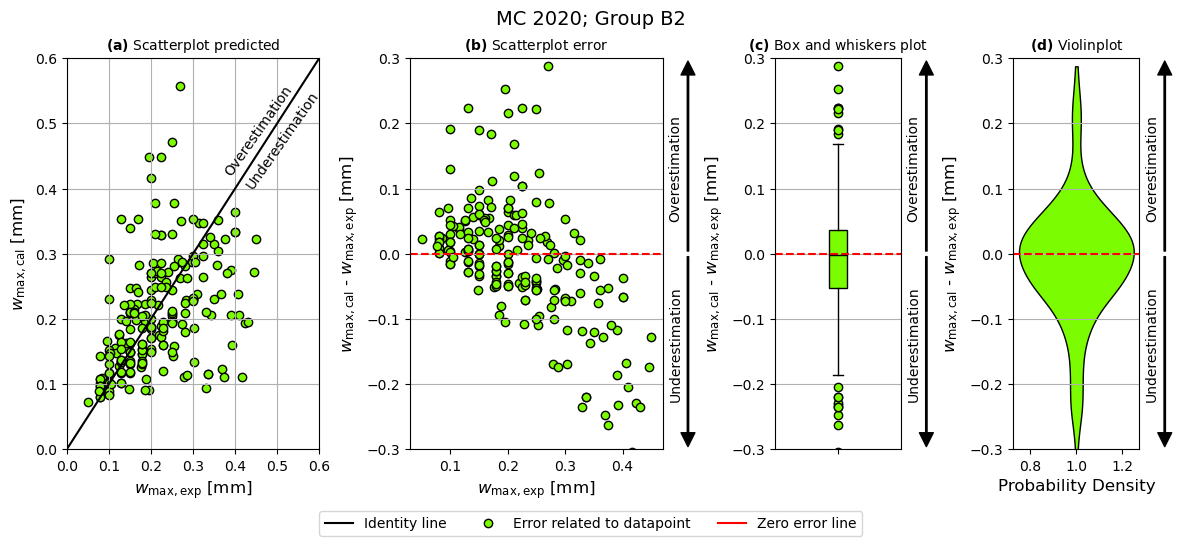

In [184]:
plot_fig_paper_boxplot_V2(wmax_D,1,1,colors_D);

#### Add figure; aangepaste dataset tgv Menn

Number of datapoints 91
Number of tested elements 26
data_shape (91, 213)
meas_wmax.shape (91,)
dfwaxfiltered (91, 15)
wmax_add.shape (91, 15)
meas_wmax.shape (91,)
dfwaxfiltered (0, 15)
wmax_add.shape (0, 15)
meas_wmax.shape (91,)
dfwaxfiltered (0, 15)
wmax_add.shape (0, 15)
meas_wmax.shape (91,)
dfwaxfiltered (91, 15)
wmax_add.shape (91, 15)
meas_wmax.shape (91,)
dfwaxfiltered (91, 15)
wmax_add.shape (91, 15)
meas_wmax.shape (91,)
dfwaxfiltered (0, 15)
wmax_add.shape (0, 15)
meas_wmax.shape (91,)
dfwaxfiltered (91, 15)
wmax_add.shape (91, 15)
(91,)
meas_wmax.shape (91,)
dfwaxfiltered (91, 15)
wmax_add.shape (91, 15)
Number of datapoints 72
Number of tested elements 19
data_shape (72, 213)
meas_wmax.shape (72,)
dfwaxfiltered (72, 15)
wmax_add.shape (72, 15)
meas_wmax.shape (72,)
dfwaxfiltered (72, 15)
wmax_add.shape (72, 15)
meas_wmax.shape (72,)
dfwaxfiltered (72, 15)
wmax_add.shape (72, 15)
meas_wmax.shape (72,)
dfwaxfiltered (72, 15)
wmax_add.shape (72, 15)
meas_wmax.shape (72,)
df

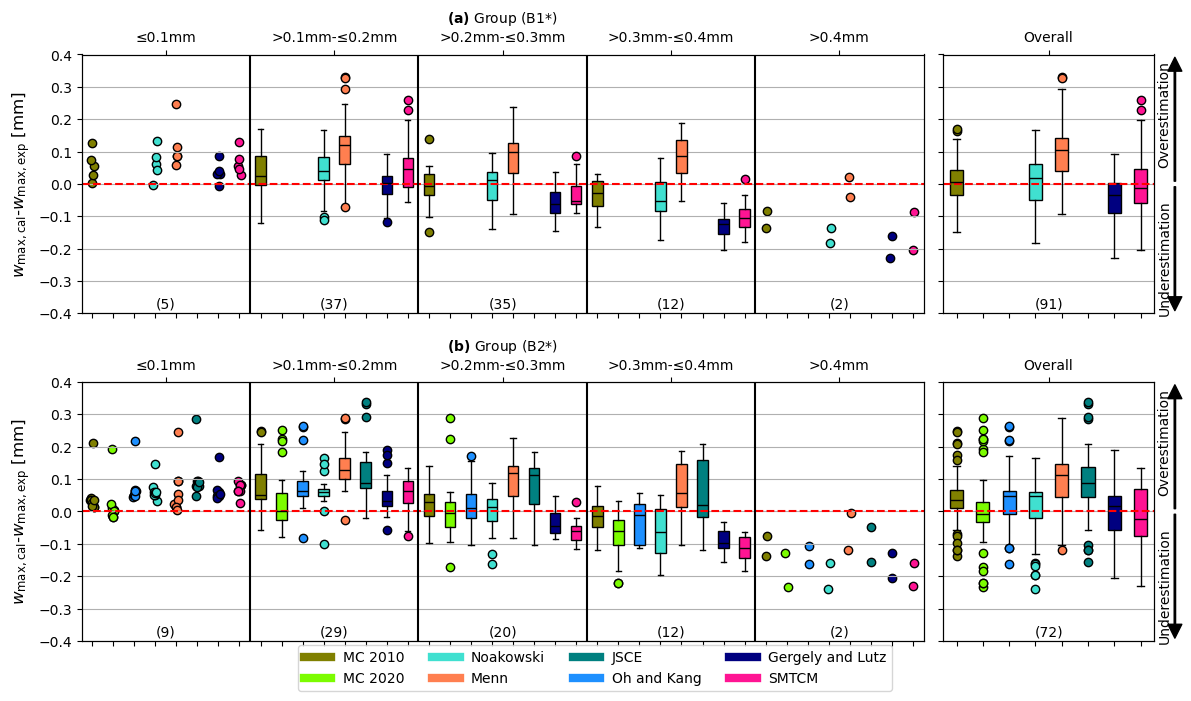

In [185]:
fig,ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw = {"width_ratios": [4,1]}, figsize=(round(1.3*9),6.7));
#ax2_0 = ax[0,0].twiny();
ax2_1 = ax[0,0].twiny();
ax2_2 = ax[1,0].twiny();

bounds = binchoice_w;
tempvar = "meas_wmax";

# Group C
# ==============================================================================================================================
# Overall error - Group C
# --------------------------------------------------------
ax[0,1].set_ylim(-0.4,0.4);
ax[0,1].yaxis.set_ticklabels([]);

err_C = [];
Npoints_C = [];
err_C_art = []; col_C_art = [];


#list_C = ["","","FprEN 1992-1-1","MC 2010","","Oh + Kang","Noakowski","","Gergely + Lutz","SMTCM"];
#list_C = ["","","FprEN 1992-1-1","MC 2010","","","Noakowski","","Gergely + Lutz","SMTCM"];
list_C = ["MC 2010","","","Noakowski","Menn","","Gergely + Lutz","SMTCM"];
df_C = func_apply_group_filter(df,hardfilter_C_star,softfilter_C_star);
wm_C, wmax_C, sm_C, smax_C, colors_C = func_compute_filtered_output_multiple(df_C,list_C);

for i in range(len(list_C)):
    diff = wmax_C[i]["cwf_wmax"] - wmax_C[i]["meas_wmax"];
    
    err_C.append(diff); Npoints_C.append(len(diff)); 
    err_C_art.append(diff); err_C_art.append(diff);
    col_C_art.append(colors_C); col_C_art.append(colors_C);

bplot = ax[0,1].boxplot(err_C,patch_artist=True);
#bplot = ax[1,1].boxplot(err_C,patch_artist=True,positions = [3.5,4.4,6.3,7.2,9.1,10]);
#viol = ax[1,1].violinplot(err_C);

for err,patch_box,patch_flier,patch_med,col in \
    zip(err_C,bplot["boxes"],bplot["fliers"],bplot["medians"],colors_C):
    if err.shape[0] < plotcutoff_overall:
        patch_box.set_visible(False);
        patch_med.set_visible(False)
        patch_flier.set_visible(False)
    else:
        patch_box.set_facecolor(col);
        patch_med.set_color("k");
        patch_flier.set_markerfacecolor(col);

for err_C_art,patch_whis,patch_cap,col in \
    zip(err_C_art,bplot["whiskers"],bplot["caps"],col_C_art):
        if err_C_art.shape[0] < plotcutoff_overall:
            patch_whis.set_visible(False)
            patch_cap.set_visible(False)
    
for i in range(len(list_C)):
    if err_C[i].shape[0] < plotcutoff_overall:
        ax[0,1].scatter(1 + i + np.random.uniform(-0.1,0.1,len(err_C[i])),err_C[i],zorder=10,c=colors_C[i],\
                       edgecolors="k");

ax[0,1].set_xticks(np.linspace(1,len(list_C),len(list_C)),[],rotation=60,ha="right");
#ax[1,1].set_xticks([1.5,2.5,3.5,4.4,5.4,6.3,7.2,8.1,9.1,10],[],rotation=60,ha="right");
ax[0,1].axhline(y=0,c="r",linestyle="--");

ax[0,1].text((len(list_C)+1)/2,-0.35,"("+str(len(err_C[-1]))+")",horizontalalignment="center",verticalalignment="top");
#ax[1,1].text(10/2,-0.45,len(err_C[-1]),horizontalalignment="center",verticalalignment="top");

ax1_2_overall = ax[0,1].twiny();
ax1_2_overall.set_xticks([0.5]);
ax1_2_overall.set_xticklabels(["Overall"]);


x0 = 1.1
trans = mtransforms.blended_transform_factory(ax[0,1].transAxes, ax[0,1].transData)
y_tail = 0
y_head = 0.4
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax[0,1].add_patch(arrow1)
ax[0,1].text(1.05,0.05,"Overestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="bottom");
y_tail = 0
y_head = -0.4
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax[0,1].add_patch(arrow1)
ax[0,1].text(1.05,-0.05,"Underestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="top");
ax[0,1].grid(axis="y");


fig.tight_layout();

# Detailed
# --------------------------------------------------------
xlabel = [];
col = [];
err_detailed_C = []; err_detailed_C_art = []; col_C_art = [];

#for i in range(len(bounds)+1):
#for i in range(1,len(bounds)+1):
for i in range(0,len(bounds)+1):
    if i == 0:
        xlabel.append("≤"+str(bounds[0])+"mm");
    elif i == len(bounds):
        xlabel.append(">"+str(bounds[len(bounds)-1])+"mm");
    else:
        xlabel.append(">"+str(bounds[i-1])+"mm-≤"+str(bounds[i])+"mm");

    datastore = [];
    namestore = [];
    
    for j in range(len(list_C)):
        if i == 0:
            temp = wmax_C[j][(wmax_C[j][tempvar] <= bounds[0])];
        elif i == len(bounds):
            temp = wmax_C[j][(wmax_C[j][tempvar] > bounds[len(bounds)-1])];
        else:
            temp = wmax_C[j][((wmax_C[j][tempvar] > bounds[i-1]) & (wmax_C[j][tempvar] <= bounds[i]))];
    
        name = str("wmax"+"dataset"+str(i));
        datastore.append(temp);
        namestore.append(name);
    
        col.append(colors_C[j]);

        err_detailed_C.append(datastore[j]["cwf_wmax"] - datastore[j]["meas_wmax"]);
        err_detailed_C_art.append(datastore[j]["cwf_wmax"] - datastore[j]["meas_wmax"]);
        err_detailed_C_art.append(datastore[j]["cwf_wmax"] - datastore[j]["meas_wmax"]);

        col_C_art.append(colors_C[j]); col_C_art.append(colors_C[j]);

colcopy = col;

bplot = ax[0,0].boxplot(err_detailed_C,patch_artist=True);

#bplot = ax[1,0].boxplot(err_detailed_C,patch_artist=True,positions = [
#     3.5,4.4,6.3,7.2,9.1,10,
#     13.5,14.4,16.3,17.2,19.1,20,
#     23.5,24.4,26.3,27.2,29.1,30,
#     33.5,34.4,36.3,37.2,39.1,40,
#     43.5,44.4,46.3,47.2,49.1,50
#]);


#positions = [3.5,4.4,6.3,7.2,9.1,10]);

#viol = ax[1,0].violinplot(err_detailed_C);
for err,patch_box,patch_flier,patch_med,col in zip(err_detailed_C,bplot["boxes"],bplot["fliers"],bplot["medians"], col):
    if err.shape[0] < plotcutoff_detail:
        patch_box.set_visible(False);
        patch_flier.set_visible(False);
        patch_med.set_visible(False);
    else:
        patch_box.set_facecolor(col);
        patch_med.set_color("k");
        patch_flier.set_markerfacecolor(col);

for err,patch_whis,patch_cap,col in zip(err_detailed_C_art,bplot["whiskers"],bplot["caps"], col_C_art):
    if err.shape[0] < plotcutoff_detail:
        patch_whis.set_visible(False);
        patch_cap.set_visible(False);

ax[0,0].set_title("$\\bf{(a)}$ Group (B1*)");
ax[0,0].axhline(y=0,c="r",linestyle="--");
ax[0,0].set_ylim(-0.4,0.4);
ax[0,0].set_ylabel("$w_{\\rm{max,cal}}$-$w_{\\rm{max,exp}}$ [mm]");
ax[0,0].grid(axis="y");

Ndatpoints = (len(bounds)+1)*(len(list_C));
ax[0,0].set_xticks(np.linspace(1,Ndatpoints,Ndatpoints),(len(bounds))*[]*len(list_C),rotation=60,ha="right");

loc_xtick = np.linspace(0.5/(len(bounds)+1),1-(0.5/(len(bounds)+1)),len(bounds)+1);
diff = loc_xtick[1] - loc_xtick[0];

ax2_1.set_xticks(loc_xtick);
ax2_1.set_xticklabels(xlabel);

loc_ax = np.linspace(0.5/(len(bounds)+1) + diff/2,1-(0.5/(len(bounds)+1)) - diff/2,len(bounds));
for xc in loc_ax:
    ax2_1.axvline(x=xc,color="k");

for i in range((len(bounds)+1)*(len(list_C))):
    if len(err_detailed_C[i]) < plotcutoff_detail:
        ax[0,0].scatter(1 + i + np.random.uniform(-0.1,0.1,len(err_detailed_C[i])),err_detailed_C[i],c=colcopy[i],\
                       edgecolors="k");

for i in range(len(loc_xtick)):
    ax[0,0].text(loc_xtick[i]*(len(bounds)+1)*(len(list_C)) + 0.5,-0.35,"("+str(len(err_detailed_C[(i+1)*(len(list_C))-1]))+")",\
                     horizontalalignment="center",verticalalignment="top");

# Group D
# ==============================================================================================================================
# Overall error - Group D
ax[1,1].set_ylim(-0.4,0.4);
ax[1,1].yaxis.set_ticklabels([]);

err_D = [];
Npoints_D = [];
err_D_art = []; col_D_art = [];

list_D = ["MC 2010","MC 2020","Oh + Kang","Noakowski","Menn","JSCE","Gergely + Lutz","SMTCM"];
df_D = func_apply_group_filter(df,hardfilter_D_star,softfilter_D_star);
wm_D, wmax_D, sm_D, smax_D, colors_D = func_compute_filtered_output_multiple(df_D,list_D);

for i in range(len(list_D)):
    diff = wmax_D[i]["cwf_wmax"] - wmax_D[i]["meas_wmax"];
    
    err_D.append(diff); Npoints_D.append(len(diff)); 
    err_D_art.append(diff); err_D_art.append(diff);
    col_D_art.append(colors_D); col_D_art.append(colors_D);

bplot = ax[1,1].boxplot(err_D,patch_artist=True);
#viol = ax[2,1].violinplot(err_D);

for err,patch_box,patch_flier,patch_med,col in \
    zip(err_D,bplot["boxes"],bplot["fliers"],bplot["medians"],colors_D):
    if err.shape[0] < plotcutoff_overall:
        patch_box.set_visible(False);
        patch_med.set_visible(False)
        patch_flier.set_visible(False)
    else:
        patch_box.set_facecolor(col);
        patch_med.set_color("k");
        patch_flier.set_markerfacecolor(col);

for err_D_art,patch_whis,patch_cap,col in \
    zip(err_D_art,bplot["whiskers"],bplot["caps"],col_D_art):
        if err_D_art.shape[0] < plotcutoff_overall:
            patch_whis.set_visible(False)
            patch_cap.set_visible(False)
    
for i in range(len(list_D)):
    if err_D[i].shape[0] < plotcutoff_overall:
        ax[1,1].scatter(1 + i + np.random.uniform(-0.1,0.1,len(err_D[i])),err_D[i],zorder=10,c=colors_D[i],edgecolors="k");

ax[1,1].set_xticks(np.linspace(1,len(list_D),len(list_D)),[],rotation=60,ha="right");
ax[1,1].axhline(y=0,c="r",linestyle="--");

ax[1,1].text((len(list_D)+1)/2,-0.35,"("+str(len(err_D[-1]))+")",horizontalalignment="center",verticalalignment="top");

ax2_2_overall = ax[1,1].twiny();
ax2_2_overall.set_xticks([0.5]);
ax2_2_overall.set_xticklabels(["Overall"]);

x0 = 1.1
trans = mtransforms.blended_transform_factory(ax[1,1].transAxes, ax[1,1].transData)
y_tail = 0
y_head = 0.4
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax[1,1].add_patch(arrow1)
ax[1,1].text(1.05,0.05,"Overestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="bottom");
y_tail = 0
y_head = -0.4
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax[1,1].add_patch(arrow1)
ax[1,1].text(1.05,-0.05,"Underestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="top");
ax[1,1].grid(axis="y");

# Detailed
# --------------------------------------------------------
xlabel = [];
col = []; col_D_art = [];
err_detailed_D = []; err_detailed_D_art = [];

for i in range(0,len(bounds)+1):
    if i == 0:
        xlabel.append("≤"+str(bounds[0])+"mm");
    elif i == len(bounds):
        xlabel.append(">"+str(bounds[len(bounds)-1])+"mm");
    else:
        xlabel.append(">"+str(bounds[i-1])+"mm-≤"+str(bounds[i])+"mm");

    datastore = [];
    namestore = [];
    
    for j in range(len(list_D)):
        if i == 0:
            temp = wmax_D[j][(wmax_D[j][tempvar] <= bounds[0])];
        elif i == len(bounds):
            temp = wmax_D[j][(wmax_D[j][tempvar] > bounds[len(bounds)-1])];
        else:
            temp = wmax_D[j][((wmax_D[j][tempvar] > bounds[i-1]) & (wmax_D[j][tempvar] <= bounds[i]))];
    
        name = str("wmax"+"dataset"+str(i));
        datastore.append(temp);
        namestore.append(name);
    
        col.append(colors_D[j]);

        err_detailed_D.append(datastore[j]["cwf_wmax"] - datastore[j]["meas_wmax"]);
        err_detailed_D_art.append(datastore[j]["cwf_wmax"] - datastore[j]["meas_wmax"]);
        err_detailed_D_art.append(datastore[j]["cwf_wmax"] - datastore[j]["meas_wmax"]);

        col_D_art.append(colors_D[j]); col_D_art.append(colors_D[j]);

colcopy = col;

bplot = ax[1,0].boxplot(err_detailed_D,patch_artist=True);
#viol = ax[2,0].violinplot(err_detailed_D);

for err,patch_box,patch_flier,patch_med,col in zip(err_detailed_D,bplot["boxes"], bplot["fliers"],bplot["medians"], col):
    if err.shape[0] < plotcutoff_detail:
        patch_box.set_visible(False);
        patch_flier.set_visible(False);
        patch_med.set_visible(False);
    else:
        patch_box.set_facecolor(col);
        patch_med.set_color("k");
        patch_flier.set_markerfacecolor(col);

for err,patch_whis,patch_cap,col in zip(err_detailed_D_art,bplot["whiskers"],bplot["caps"], col_D_art):
    if err.shape[0] < plotcutoff_detail:
        patch_whis.set_visible(False);
        patch_cap.set_visible(False);

ax[1,0].set_title("$\\bf{(b)}$ Group (B2*)");
ax[1,0].axhline(y=0,c="r",linestyle="--");
ax[1,0].set_ylim(-0.4,0.4);
ax[1,0].set_ylabel("$w_{\\rm{max,cal}}$-$w_{\\rm{max,exp}}$ [mm]");
ax[1,0].grid(axis="y");

Ndatpoints = (len(bounds)+1)*(len(list_D));
ax[1,0].set_xticks(np.linspace(1,Ndatpoints,Ndatpoints),(len(bounds))*[]*len(list_D),rotation=60,ha="right");

loc_xtick = np.linspace(0.5/(len(bounds)+1),1-(0.5/(len(bounds)+1)),len(bounds)+1);
diff = loc_xtick[1] - loc_xtick[0];

ax2_2.set_xticks(loc_xtick);
ax2_2.set_xticklabels(xlabel);

loc_ax = np.linspace(0.5/(len(bounds)+1) + diff/2,1-(0.5/(len(bounds)+1)) - diff/2,len(bounds));
for xc in loc_ax:
    ax2_2.axvline(x=xc,color="k");

for i in range((len(bounds)+1)*(len(list_D))):
    if len(err_detailed_D[i]) < plotcutoff_detail:
        ax[1,0].scatter(1 + i + np.random.uniform(-0.1,0.1,len(err_detailed_D[i])),err_detailed_D[i],c=colcopy[i],edgecolors="k");

#for i in range((len(bounds)+1)*(len(list_D))):
#    ax[2,0].text(1 + diff/2 + diff*i*(len(bounds)+1),-0.45,len(err_detailed_D[i]),horizontalalignment="center",verticalalignment="top");

for i in range(len(loc_xtick)):
    ax[1,0].text(loc_xtick[i]*(len(bounds)+1)*(len(list_D)) + 0.5,-0.35,"("+str(len(err_detailed_D[(i+1)*(len(list_D))-1]))+")",\
                     horizontalalignment="center",verticalalignment="top");

fig.tight_layout();

#ax[0,0].text(-2.5,-0.55,"(a)")
#ax[1,0].text(-2.5*(7/7),-0.55,"(b)")
#ax[2,0].text(-2.5*(10/10),-0.55,"(c)")

# Create legend
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
legend_elements = [
                   Line2D([0], [0], color='olive', lw=6, label='MC 2010'),
                   Line2D([0], [0], color='lawngreen', lw=6, label='MC 2020'),
                   Line2D([0], [0], color='turquoise', lw=6, label='Noakowski'),
                   Line2D([0], [0], color='coral', lw=6, label='Menn'),
                   Line2D([0], [0], color='teal', lw=6, label='JSCE'),
                   Line2D([0], [0], color='dodgerblue', lw=6, label='Oh and Kang'),
                   Line2D([0], [0], color='navy', lw=6, label='Gergely and Lutz'),
                   #Line2D([0], [0], color='blueviolet', lw=6, label='Frosch'),
                   Line2D([0], [0], color='deeppink', lw=6, label='SMTCM')
                  ];
fig.legend(handles=legend_elements, loc="lower center",ncol=4,bbox_to_anchor=(0.5,-0.05));
#plt.savefig(Path(motherpath/r"1_st_Journal_Paper\Figures\Python\w_summarized.svg"));
plt.savefig(Path(motherpath/r"1_st_Journal_Paper\Figures\SVG\w_summarized_total_add_Menn.svg"),bbox_inches='tight');

print("Number of unique elements",df_A0["ELID"].nunique());
print(df_A0.shape)
print("Number of unique elements",df_C["ELID"].nunique());
print(df_C.shape)
print("Number of unique elements",df_D["ELID"].nunique());
print(df_D.shape)

### Figure paper - crack spacings

Number of datapoints 1080
Number of tested elements 150
data_shape (1080, 213)
meas_wmax.shape (1080,)
dfwaxfiltered (1080, 15)
wmax_add.shape (1080, 15)
meas_wmax.shape (1080,)
dfwaxfiltered (1080, 15)
wmax_add.shape (1080, 15)
meas_wmax.shape (1080,)
dfwaxfiltered (0, 15)
wmax_add.shape (0, 15)
meas_wmax.shape (1080,)
dfwaxfiltered (1080, 15)
wmax_add.shape (1080, 15)
meas_wmax.shape (1080,)
dfwaxfiltered (1080, 15)
wmax_add.shape (1080, 15)
meas_wmax.shape (1080,)
dfwaxfiltered (0, 15)
wmax_add.shape (0, 15)
meas_wmax.shape (1080,)
dfwaxfiltered (0, 15)
wmax_add.shape (0, 15)
(1080,)
meas_wmax.shape (1080,)
dfwaxfiltered (1080, 15)
wmax_add.shape (1080, 15)
Number of datapoints 210
Number of tested elements 61
data_shape (210, 213)
meas_wmax.shape (210,)
dfwaxfiltered (210, 15)
wmax_add.shape (210, 15)
meas_wmax.shape (210,)
dfwaxfiltered (0, 15)
wmax_add.shape (0, 15)
meas_wmax.shape (210,)
dfwaxfiltered (0, 15)
wmax_add.shape (0, 15)
meas_wmax.shape (210,)
dfwaxfiltered (210, 15)


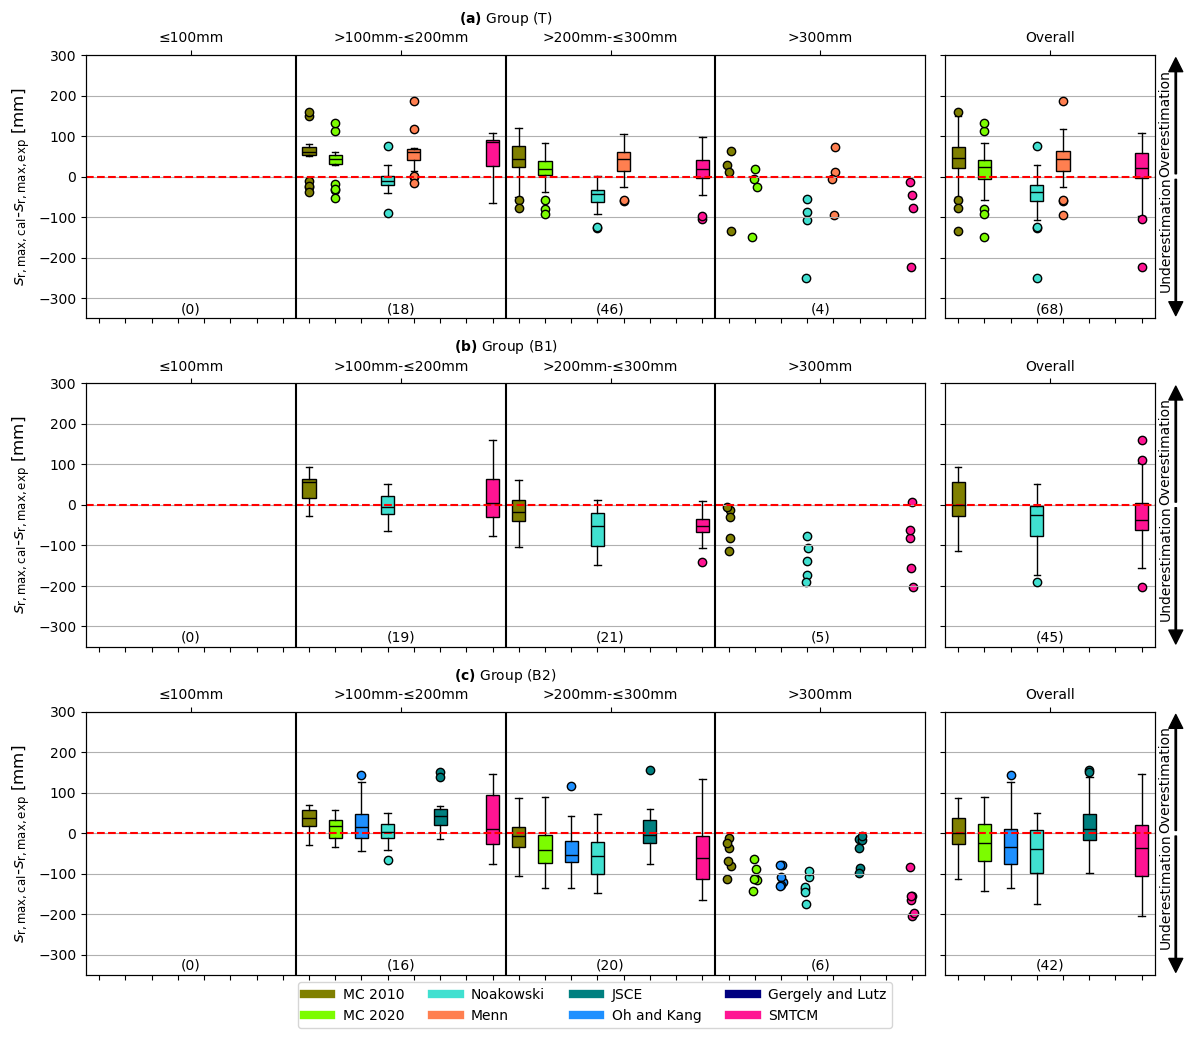

In [186]:
fig,ax = plt.subplots(nrows = 3, ncols = 2, gridspec_kw = {"width_ratios": [4,1]}, figsize=(round(1.3*9),10));
ax2_0 = ax[0,0].twiny();
ax2_1 = ax[1,0].twiny();
ax2_2 = ax[2,0].twiny();

bounds = binchoice_s;
tempvar = "meas_smax";

# Group A
# ==============================================================================================================================
# Overall error - Group A
# --------------------------------------------------------
ax[0,1].set_ylim(-350,300);
ax[0,1].yaxis.set_ticklabels([]);

err_A0 = [];
Npoints_A0 = [];
err_A0_art = []; col_A0_art = [];

list_A0 = ["MC 2010","MC 2020","","Noakowski","Menn","","","SMTCM"];
df_A0 = func_apply_group_filter(df,hardfilter_A0,softfilter_A0);
wm_A0, wmax_A0, sm_A0, smax_A0, colors_A0 = func_compute_filtered_output_multiple(df_A0,list_A0);

for i in range(len(list_A0)):
    diff = smax_A0[i]["cwf_smax"] - smax_A0[i]["meas_smax"];
    
    err_A0.append(diff); Npoints_A0.append(len(diff)); 
    err_A0_art.append(diff); err_A0_art.append(diff);
    col_A0_art.append(colors_A0); col_A0_art.append(colors_A0);

bplot = ax[0,1].boxplot(err_A0,patch_artist=True);

for err,patch_box,patch_flier,patch_med,col in \
    zip(err_A0,bplot["boxes"],bplot["fliers"],bplot["medians"],colors_A0):
    if err.shape[0] < plotcutoff_overall:
        patch_box.set_visible(False);
        patch_med.set_visible(False)
        patch_flier.set_visible(False)
    else:
        patch_box.set_facecolor(col);
        patch_med.set_color("k");
        patch_flier.set_markerfacecolor(col);

for err_A0_art,patch_whis,patch_cap,col in \
    zip(err_A0_art,bplot["whiskers"],bplot["caps"],col_A0_art):
        if err_A0_art.shape[0] < plotcutoff_overall:
            patch_whis.set_visible(False)
            patch_cap.set_visible(False)
    
for i in range(len(list_A0)):
    if err_A0[i].shape[0] < plotcutoff_overall:
        ax[0,1].scatter(1 + i + np.random.uniform(-0.1,0.1,len(err_A0[i])),err_A0[i],zorder=10,c=colors_A0[i],edgecolors="k");

ax[0,1].set_xticks(np.linspace(1,len(list_A0),len(list_A0)),[],rotation=60,ha="right");
ax[0,1].axhline(y=0,c="r",linestyle="--");

ax[0,1].text((len(list_A0)+1)/2,-310,"("+str(len(err_A0[-1]))+")",horizontalalignment="center",verticalalignment="top");

ax0_2_overall = ax[0,1].twiny();
ax0_2_overall.set_xticks([0.5]);
ax0_2_overall.set_xticklabels(["Overall"]);

x0 = 1.1
trans = mtransforms.blended_transform_factory(ax[0,1].transAxes, ax[0,1].transData)
y_tail = 0
y_head = 300
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax[0,1].add_patch(arrow1)
ax[0,1].text(1.05,0.05,"Overestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="bottom");
y_tail = 0
y_head = -350
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax[0,1].add_patch(arrow1)
ax[0,1].text(1.05,-0.05,"Underestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="top");
ax[0,1].grid(axis="y");

fig.tight_layout();

# Detailed
# --------------------------------------------------------
xlabel = [];
col = []; col_A0_art = [];
err_detailed_A0 = []; err_detailed_A0_art = [];

for i in range(0,len(bounds)+1):
    if i == 0:
        xlabel.append("≤"+str(bounds[0])+"mm");
    elif i == len(bounds):
        xlabel.append(">"+str(bounds[len(bounds)-1])+"mm");
    else:
        xlabel.append(">"+str(bounds[i-1])+"mm-≤"+str(bounds[i])+"mm");

    datastore = [];
    namestore = [];
    
    for j in range(len(list_A0)):
        if i == 0:
            temp = smax_A0[j][(smax_A0[j][tempvar] <= bounds[0])];
        elif i == len(bounds):
            temp = smax_A0[j][(smax_A0[j][tempvar] > bounds[len(bounds)-1])];
        else:
            temp = smax_A0[j][((smax_A0[j][tempvar] > bounds[i-1]) & (smax_A0[j][tempvar] <= bounds[i]))];
    
        name = str("smax"+"dataset"+str(i));
        datastore.append(temp);
        namestore.append(name);
    
        col.append(colors_A0[j]);

        err_detailed_A0.append(datastore[j]["cwf_smax"] - datastore[j]["meas_smax"]);
        err_detailed_A0_art.append(datastore[j]["cwf_smax"] - datastore[j]["meas_smax"]);
        err_detailed_A0_art.append(datastore[j]["cwf_smax"] - datastore[j]["meas_smax"]);

        col_A0_art.append(colors_A0[j]); col_A0_art.append(colors_A0[j]);

colcopy = col;

bplot = ax[0,0].boxplot(err_detailed_A0,patch_artist=True);
for err,patch_box,patch_flier,patch_med,col in zip(err_detailed_A0,bplot["boxes"],bplot["fliers"],bplot["medians"], col):
    if err.shape[0] < plotcutoff_detail:
        patch_box.set_visible(False);
        patch_flier.set_visible(False);
        patch_med.set_visible(False);
    else:
        patch_box.set_facecolor(col);
        patch_med.set_color("k");
        patch_flier.set_markerfacecolor(col);

for err,patch_whis,patch_cap,col in zip(err_detailed_A0_art,bplot["whiskers"],bplot["caps"], col_A0_art):
    if err.shape[0] < plotcutoff_detail:
        patch_whis.set_visible(False);
        patch_cap.set_visible(False);

ax[0,0].set_ylim(-350,300);
ax[0,0].set_title("$\\bf{(a)}$ Group (T)");
ax[0,0].axhline(y=0,c="r",linestyle="--");
ax[0,0].set_ylabel("$s_{\\rm{r,max,cal}}$-$s_{\\rm{r,max,exp}}$ [mm]");
ax[0,0].grid(axis="y");

Ndatpoints = (len(bounds)+1)*(len(list_A0)+1);
ax[0,0].set_xticks(np.linspace(1,Ndatpoints,Ndatpoints),(len(bounds))*[]*(len(list_A0)),rotation=60,ha="right");

loc_xtick = np.linspace(0.5/(len(bounds)+1),1-(0.5/(len(bounds)+1)),len(bounds)+1);
diff = loc_xtick[1] - loc_xtick[0];

ax2_0.set_xticks(loc_xtick);
ax2_0.set_xticklabels(xlabel);

loc_ax = np.linspace(0.5/(len(bounds)+1) + diff/2,1-(0.5/(len(bounds)+1)) - diff/2,len(bounds));
for xc in loc_ax:
    ax2_0.axvline(x=xc,color="k");

for i in range((len(bounds)+1)*(len(list_A0))):
    if len(err_detailed_A0[i]) < plotcutoff_detail:
        ax[0,0].scatter(1 + i + np.random.uniform(-0.1,0.1,len(err_detailed_A0[i])),err_detailed_A0[i],c=colcopy[i],edgecolors="k");

for i in range(len(loc_xtick)):
    ax[0,0].text(loc_xtick[i]*(len(bounds)+1)*(len(list_A0)) + 0.5,-310,"("+str(len(err_detailed_A0[(i+1)*(len(list_A0))-1]))+")",\
                     horizontalalignment="center",verticalalignment="top");

# Group C
# ==============================================================================================================================
# Overall error - Group C
# --------------------------------------------------------
ax[1,1].set_ylim(-350,300);
ax[1,1].yaxis.set_ticklabels([]);

err_C = [];
Npoints_C = [];
err_C_art = []; col_C_art = [];

list_C = ["MC 2010","","","Noakowski","","","Gergely + Lutz","SMTCM"];
df_C = func_apply_group_filter(df,hardfilter_C,softfilter_C);
wm_C, wmax_C, sm_C, smax_C, colors_C = func_compute_filtered_output_multiple(df_C,list_C);

for i in range(len(list_C)):
    diff = smax_C[i]["cwf_smax"] - smax_C[i]["meas_smax"];
    
    err_C.append(diff); Npoints_C.append(len(diff)); 
    err_C_art.append(diff); err_C_art.append(diff);
    col_C_art.append(colors_C); col_C_art.append(colors_C);

bplot = ax[1,1].boxplot(err_C,patch_artist=True);

for err,patch_box,patch_flier,patch_med,col in \
    zip(err_C,bplot["boxes"],bplot["fliers"],bplot["medians"],colors_C):
    if err.shape[0] < plotcutoff_overall:
        patch_box.set_visible(False);
        patch_med.set_visible(False)
        patch_flier.set_visible(False)
    else:
        patch_box.set_facecolor(col);
        patch_med.set_color("k");
        patch_flier.set_markerfacecolor(col);

for err_C_art,patch_whis,patch_cap,col in \
    zip(err_C_art,bplot["whiskers"],bplot["caps"],col_C_art):
        if err_C_art.shape[0] < plotcutoff_overall:
            patch_whis.set_visible(False)
            patch_cap.set_visible(False)
    
for i in range(len(list_C)):
    if err_C[i].shape[0] < plotcutoff_overall:
        ax[1,1].scatter(1 + i + np.random.uniform(-0.1,0.1,len(err_C[i])),err_C[i],alpha=0.2,zorder=10,c=colors_C[i],edgecolors="k");

ax[1,1].set_xticks(np.linspace(1,len(list_C),len(list_C)),[],rotation=60,ha="right");
ax[1,1].axhline(y=0,c="r",linestyle="--");

ax[1,1].text((len(list_C)+1)/2,-310,"("+str(len(err_C[-1]))+")",horizontalalignment="center",verticalalignment="top");


ax1_2_overall = ax[1,1].twiny();
ax1_2_overall.set_xticks([0.5]);
ax1_2_overall.set_xticklabels(["Overall"]);

x0 = 1.1
trans = mtransforms.blended_transform_factory(ax[1,1].transAxes, ax[1,1].transData)
y_tail = 0
y_head = 300
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax[1,1].add_patch(arrow1)
ax[1,1].text(1.05,0.05,"Overestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="bottom");
y_tail = 0
y_head = -350
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax[1,1].add_patch(arrow1)
ax[1,1].text(1.05,-0.05,"Underestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="top");
ax[1,1].grid(axis="y");

fig.tight_layout();

# Detailed
# --------------------------------------------------------
xlabel = [];
col = [];
err_detailed_C = []; err_detailed_C_art = []; col_C_art = [];

#for i in range(len(bounds)+1):
#for i in range(1,len(bounds)+1):
for i in range(0,len(bounds)+1):
    if i == 0:
        xlabel.append("≤"+str(bounds[0])+"mm");
    elif i == len(bounds):
        xlabel.append(">"+str(bounds[len(bounds)-1])+"mm");
    else:
        xlabel.append(">"+str(bounds[i-1])+"mm-≤"+str(bounds[i])+"mm");

    datastore = [];
    namestore = [];
    
    for j in range(len(list_C)):
        if i == 0:
            temp = smax_C[j][(smax_C[j][tempvar] <= bounds[0])];
        elif i == len(bounds):
            temp = smax_C[j][(smax_C[j][tempvar] > bounds[len(bounds)-1])];
        else:
            temp = smax_C[j][((smax_C[j][tempvar] > bounds[i-1]) & (smax_C[j][tempvar] <= bounds[i]))];
    
        name = str("smax"+"dataset"+str(i));
        datastore.append(temp);
        namestore.append(name);
    
        col.append(colors_C[j]);

        err_detailed_C.append(datastore[j]["cwf_smax"] - datastore[j]["meas_smax"]);
        err_detailed_C_art.append(datastore[j]["cwf_smax"] - datastore[j]["meas_smax"]);
        err_detailed_C_art.append(datastore[j]["cwf_smax"] - datastore[j]["meas_smax"]);

        col_C_art.append(colors_C[j]); col_C_art.append(colors_C[j]);

colcopy = col;

bplot = ax[1,0].boxplot(err_detailed_C,patch_artist=True);
for err,patch_box,patch_flier,patch_med,col in zip(err_detailed_C,bplot["boxes"],bplot["fliers"],bplot["medians"], col):
    if err.shape[0] < plotcutoff_detail:
        patch_box.set_visible(False);
        patch_flier.set_visible(False);
        patch_med.set_visible(False);
    else:
        patch_box.set_facecolor(col);
        patch_med.set_color("k");
        patch_flier.set_markerfacecolor(col);

for err,patch_whis,patch_cap,col in zip(err_detailed_C_art,bplot["whiskers"],bplot["caps"], col_C_art):
    if err.shape[0] < plotcutoff_detail:
        patch_whis.set_visible(False);
        patch_cap.set_visible(False);

ax[1,0].set_title("$\\bf{(b)}$ Group (B1)");
ax[1,0].axhline(y=0,c="r",linestyle="--");
ax[1,0].set_ylim(-350,300);
ax[1,0].set_ylabel("$s_{\\rm{r,max,cal}}$-$s_{\\rm{r,max,exp}}$ [mm]");
ax[1,0].grid(axis="y");

Ndatpoints = (len(bounds)+1)*(len(list_C));
ax[1,0].set_xticks(np.linspace(1,Ndatpoints,Ndatpoints),(len(bounds))*[]*len(list_C),rotation=60,ha="right");

loc_xtick = np.linspace(0.5/(len(bounds)+1),1-(0.5/(len(bounds)+1)),len(bounds)+1);
diff = loc_xtick[1] - loc_xtick[0];

ax2_1.set_xticks(loc_xtick);
ax2_1.set_xticklabels(xlabel);

loc_ax = np.linspace(0.5/(len(bounds)+1) + diff/2,1-(0.5/(len(bounds)+1)) - diff/2,len(bounds));
for xc in loc_ax:
    ax2_1.axvline(x=xc,color="k");

for i in range((len(bounds)+1)*(len(list_C))):
    if len(err_detailed_C[i]) < plotcutoff_detail:
        ax[1,0].scatter(1 + i + np.random.uniform(-0.1,0.1,len(err_detailed_C[i])),err_detailed_C[i],c=colcopy[i],edgecolors="k");

for i in range(len(loc_xtick)):
    ax[1,0].text(loc_xtick[i]*(len(bounds)+1)*(len(list_C)) + 0.5,-310,"("+str(len(err_detailed_C[(i+1)*(len(list_C))-1]))+")",\
                     horizontalalignment="center",verticalalignment="top");

# Group D
# ==============================================================================================================================
# Overall error - Group D
ax[2,1].set_ylim(-350,300);
ax[2,1].yaxis.set_ticklabels([]);

err_D = [];
Npoints_D = [];
err_D_art = []; col_D_art = [];

list_D = ["MC 2010","MC 2020","Oh + Kang","Noakowski","","JSCE","Gergely + Lutz","SMTCM"];
df_D = func_apply_group_filter(df,hardfilter_D,softfilter_D);
wm_D, wmax_D, sm_D, smax_D, colors_D = func_compute_filtered_output_multiple(df_D,list_D);

for i in range(len(list_D)):
    diff = smax_D[i]["cwf_smax"] - smax_D[i]["meas_smax"];
    
    err_D.append(diff); Npoints_D.append(len(diff)); 
    err_D_art.append(diff); err_D_art.append(diff);
    col_D_art.append(colors_D); col_D_art.append(colors_D);

bplot = ax[2,1].boxplot(err_D,patch_artist=True);

for err,patch_box,patch_flier,patch_med,col in \
    zip(err_D,bplot["boxes"],bplot["fliers"],bplot["medians"],colors_D):
    if err.shape[0] < plotcutoff_overall:
        patch_box.set_visible(False);
        patch_med.set_visible(False)
        patch_flier.set_visible(False)
    else:
        patch_box.set_facecolor(col);
        patch_med.set_color("k");
        patch_flier.set_markerfacecolor(col);

for err_D_art,patch_whis,patch_cap,col in \
    zip(err_D_art,bplot["whiskers"],bplot["caps"],col_D_art):
        if err_D_art.shape[0] < plotcutoff_overall:
            patch_whis.set_visible(False)
            patch_cap.set_visible(False)
    
for i in range(len(list_D)):
    if err_D[i].shape[0] < plotcutoff_overall:
        ax[2,1].scatter(1 + i + np.random.uniform(-0.1,0.1,len(err_D[i])),err_D[i],zorder=10,c=colors_D[i],edgecolors="k");

ax[2,1].set_xticks(np.linspace(1,len(list_D),len(list_D)),[],rotation=60,ha="right");
ax[2,1].axhline(y=0,c="r",linestyle="--");

ax[2,1].text((len(list_D)+1)/2,-310,"("+str(len(err_D[-1]))+")",horizontalalignment="center",verticalalignment="top");

ax2_2_overall = ax[2,1].twiny();
ax2_2_overall.set_xticks([0.5]);
ax2_2_overall.set_xticklabels(["Overall"]);


x0 = 1.1
trans = mtransforms.blended_transform_factory(ax[2,1].transAxes, ax[2,1].transData)
y_tail = 0
y_head = 300
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax[2,1].add_patch(arrow1)
ax[2,1].text(1.05,0.05,"Overestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="bottom");
y_tail = 0
y_head = -350
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax[2,1].add_patch(arrow1)
ax[2,1].text(1.05,-0.05,"Underestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="top");
ax[2,1].grid(axis="y");

# Detailed
# --------------------------------------------------------
xlabel = [];
col = []; col_D_art = [];
err_detailed_D = []; err_detailed_D_art = [];

for i in range(0,len(bounds)+1):
    if i == 0:
        xlabel.append("≤"+str(bounds[0])+"mm");
    elif i == len(bounds):
        xlabel.append(">"+str(bounds[len(bounds)-1])+"mm");
    else:
        xlabel.append(">"+str(bounds[i-1])+"mm-≤"+str(bounds[i])+"mm");

    datastore = [];
    namestore = [];
    
    for j in range(len(list_D)):
        if i == 0:
            temp = smax_D[j][(smax_D[j][tempvar] <= bounds[0])];
        elif i == len(bounds):
            temp = smax_D[j][(smax_D[j][tempvar] > bounds[len(bounds)-1])];
        else:
            temp = smax_D[j][((smax_D[j][tempvar] > bounds[i-1]) & (smax_D[j][tempvar] <= bounds[i]))];
    
        name = str("smax"+"dataset"+str(i));
        datastore.append(temp);
        namestore.append(name);
    
        col.append(colors_D[j]);

        err_detailed_D.append(datastore[j]["cwf_smax"] - datastore[j]["meas_smax"]);
        err_detailed_D_art.append(datastore[j]["cwf_smax"] - datastore[j]["meas_smax"]);
        err_detailed_D_art.append(datastore[j]["cwf_smax"] - datastore[j]["meas_smax"]);

        col_D_art.append(colors_D[j]); col_D_art.append(colors_D[j]);

colcopy = col;

bplot = ax[2,0].boxplot(err_detailed_D,patch_artist=True);
for err,patch_box,patch_flier,patch_med,col in zip(err_detailed_D,bplot["boxes"], bplot["fliers"],bplot["medians"], col):
    if err.shape[0] < plotcutoff_detail:
        patch_box.set_visible(False);
        patch_flier.set_visible(False);
        patch_med.set_visible(False);
    else:
        patch_box.set_facecolor(col);
        patch_med.set_color("k");
        patch_flier.set_markerfacecolor(col);

for err,patch_whis,patch_cap,col in zip(err_detailed_D_art,bplot["whiskers"],bplot["caps"], col_D_art):
    if err.shape[0] < plotcutoff_detail:
        patch_whis.set_visible(False);
        patch_cap.set_visible(False);

ax[2,0].set_title("$\\bf{(c)}$ Group (B2)");
ax[2,0].axhline(y=0,c="r",linestyle="--");
ax[2,0].set_ylim(-350,300);
ax[2,0].set_ylabel("$s_{\\rm{r,max,cal}}$-$s_{\\rm{r,max,exp}}$ [mm]");
ax[2,0].grid(axis="y");

Ndatpoints = (len(bounds)+1)*(len(list_D));
ax[2,0].set_xticks(np.linspace(1,Ndatpoints,Ndatpoints),(len(bounds))*[]*len(list_D),rotation=60,ha="right");

loc_xtick = np.linspace(0.5/(len(bounds)+1),1-(0.5/(len(bounds)+1)),len(bounds)+1);
diff = loc_xtick[1] - loc_xtick[0];

ax2_2.set_xticks(loc_xtick);
ax2_2.set_xticklabels(xlabel);

loc_ax = np.linspace(0.5/(len(bounds)+1) + diff/2,1-(0.5/(len(bounds)+1)) - diff/2,len(bounds));
for xc in loc_ax:
    ax2_2.axvline(x=xc,color="k");

for i in range((len(bounds)+1)*(len(list_D))):
    if len(err_detailed_D[i]) < plotcutoff_detail:
        ax[2,0].scatter(1 + i + np.random.uniform(-0.1,0.1,len(err_detailed_D[i])),err_detailed_D[i],c=colcopy[i],edgecolors="k");

#for i in range((len(bounds)+1)*(len(list_D))):
#    ax[2,0].text(1 + diff/2 + diff*i*(len(bounds)+1),-0.45,len(err_detailed_D[i]),horizontalalignment="center",verticalalignment="top");

for i in range(len(loc_xtick)):
    ax[2,0].text(loc_xtick[i]*(len(bounds)+1)*(len(list_D)) + 0.5,-310,"("+str(len(err_detailed_D[(i+1)*(len(list_D))-1]))+")",\
                     horizontalalignment="center",verticalalignment="top");

fig.tight_layout();

#ax[0,0].text(-2.5,-475,"(a)")
#ax[1,0].text(-2.5*(7/7),-475,"(b)")
#ax[2,0].text(-2.5*(10/10),-475,"(c)")

# Create legend
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
legend_elements = [
                   Line2D([0], [0], color='olive', lw=6, label='MC 2010'),
                   Line2D([0], [0], color='lawngreen', lw=6, label='MC 2020'),
                   Line2D([0], [0], color='turquoise', lw=6, label='Noakowski'),
                   Line2D([0], [0], color='coral', lw=6, label='Menn'),
                   Line2D([0], [0], color='teal', lw=6, label='JSCE'),
                   Line2D([0], [0], color='dodgerblue', lw=6, label='Oh and Kang'),
                   Line2D([0], [0], color='navy', lw=6, label='Gergely and Lutz'),
                   #Line2D([0], [0], color='blueviolet', lw=6, label='Frosch'),
                   Line2D([0], [0], color='deeppink', lw=6, label='SMTCM')
                  ];
fig.legend(handles=legend_elements, loc="lower center",ncol=4,bbox_to_anchor=(0.5,-0.04));
#plt.savefig(Path(motherpath/r"1_st_Journal_Paper\Figures\Python\s_summarized.svg"));

#plt.savefig(Path(motherpath/r"1_st_Journal_Paper\Figures\Python\s_summarized.svg"),bbox_inches='tight');
plt.savefig(Path(motherpath/r"1_st_Journal_Paper\Figures\SVG\s_summarized_total.svg"),bbox_inches='tight');

### Figure paper - External forces

Number of datapoints 112
Number of tested elements 45
data_shape (112, 213)
meas_wmax.shape (112,)
dfwaxfiltered (112, 15)
wmax_add.shape (112, 15)
meas_wmax.shape (112,)
dfwaxfiltered (112, 15)
wmax_add.shape (112, 15)
meas_wmax.shape (112,)
dfwaxfiltered (0, 15)
wmax_add.shape (0, 15)
meas_wmax.shape (112,)
dfwaxfiltered (112, 15)
wmax_add.shape (112, 15)
meas_wmax.shape (112,)
dfwaxfiltered (112, 15)
wmax_add.shape (112, 15)
meas_wmax.shape (112,)
dfwaxfiltered (0, 15)
wmax_add.shape (0, 15)
meas_wmax.shape (112,)
dfwaxfiltered (0, 15)
wmax_add.shape (0, 15)
(112,)
meas_wmax.shape (112,)
dfwaxfiltered (112, 15)
wmax_add.shape (112, 15)
45
45
0
45
45
0
0
45
Number of datapoints 169
Number of tested elements 49
data_shape (169, 213)
meas_wmax.shape (169,)
dfwaxfiltered (169, 15)
wmax_add.shape (169, 15)
meas_wmax.shape (169,)
dfwaxfiltered (0, 15)
wmax_add.shape (0, 15)
meas_wmax.shape (169,)
dfwaxfiltered (169, 15)
wmax_add.shape (169, 15)
meas_wmax.shape (169,)
dfwaxfiltered (0, 15)

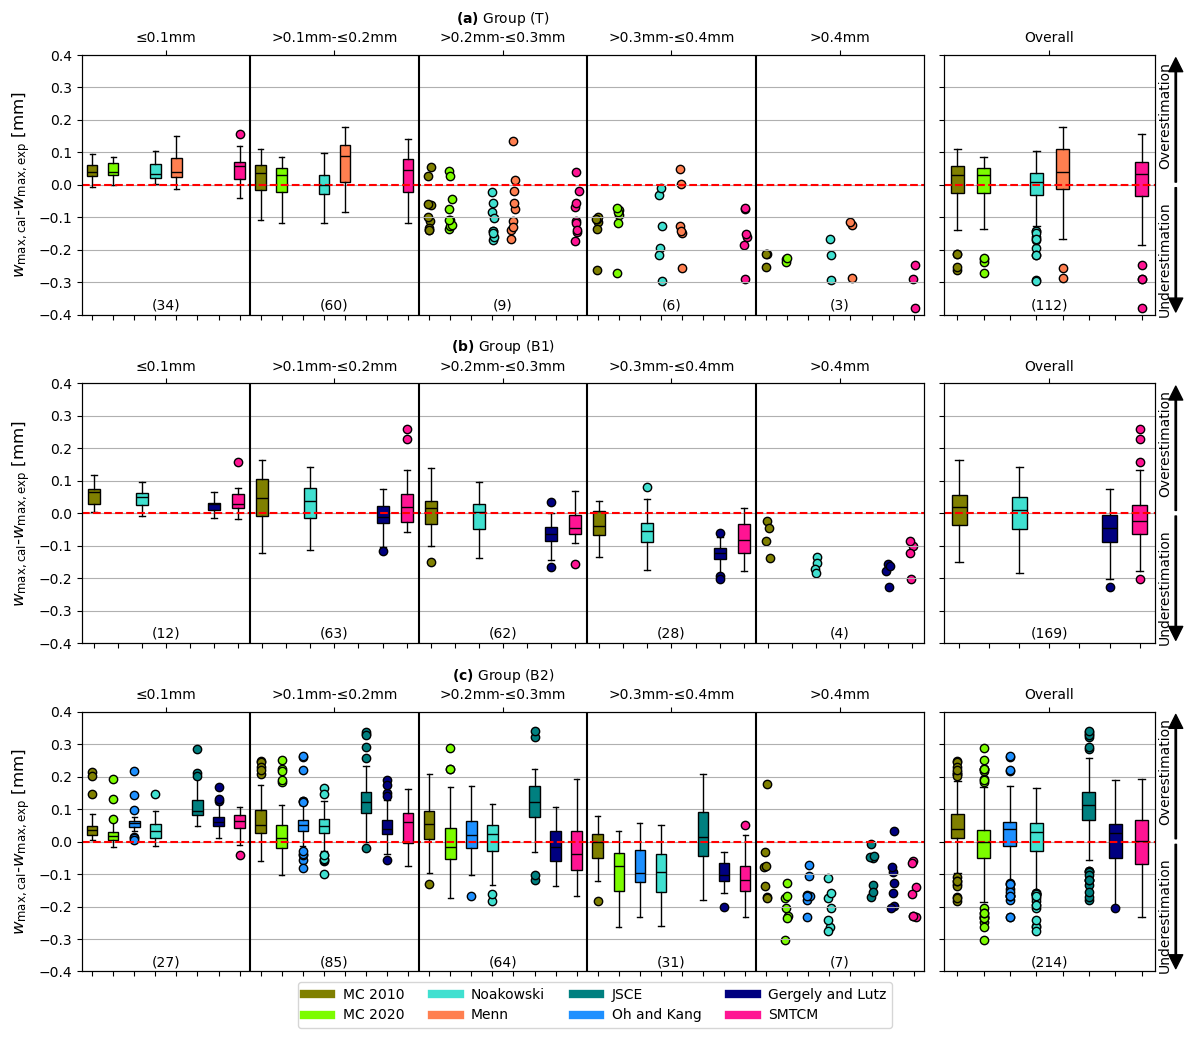

In [187]:
fig,ax = plt.subplots(nrows = 3, ncols = 2, gridspec_kw = {"width_ratios": [4,1]}, figsize=(round(1.3*9),10));
ax2_0 = ax[0,0].twiny();
ax2_1 = ax[1,0].twiny();
ax2_2 = ax[2,0].twiny();

bounds = binchoice_w;
tempvar = "meas_wmax";

# Group A
# ==============================================================================================================================
# Overall error - Group A
# --------------------------------------------------------
ax[0,1].set_ylim(-0.4,0.4);
ax[0,1].yaxis.set_ticklabels([]);

err_A0 = [];
Npoints_A0 = [];
err_A0_art = []; col_A0_art = [];

#list_A0 = ["EN 1992-1-1","NEN-EN 1992-1-1","FprEN 1992-1-1","MC 2010","MC 2020","","Noakowski","","","SMTCM"];
list_A0 = ["MC 2010","MC 2020","","Noakowski","Menn","","","SMTCM"];
df_A0 = func_apply_group_filter(df[df["catf"]==1],hardfilter_A0,softfilter_A0);
wm_A0, wmax_A0, sm_A0, smax_A0, colors_A0 = func_compute_filtered_output_multiple(df_A0,list_A0);

for i in range(len(list_A0)):
    diff = wmax_A0[i]["cwf_wmax"] - wmax_A0[i]["meas_wmax"];
    print(wmax_A0[i]["ELID"].nunique())

    err_A0.append(diff); Npoints_A0.append(len(diff)); 
    err_A0_art.append(diff); err_A0_art.append(diff);
    col_A0_art.append(colors_A0); col_A0_art.append(colors_A0);

bplot = ax[0,1].boxplot(err_A0,patch_artist=True);
#bplot = ax[0,1].boxplot(err_A0,patch_artist=True,positions = [1,2,3,4,5,7,10]);
#viol = ax[0,1].violinplot(err_A0);

for err,patch_box,patch_flier,patch_med,col in \
    zip(err_A0,bplot["boxes"],bplot["fliers"],bplot["medians"],colors_A0):
    #zip(err_A0,bplot["boxes"],bplot["fliers"],bplot["medians"],viol["bodies"],colors_A0):
    if err.shape[0] < plotcutoff_overall:
        patch_box.set_visible(False);
        patch_med.set_visible(False)
        patch_flier.set_visible(False)

        #pc.set_visible(False);
    
    else:
        patch_box.set_facecolor(col);
        patch_med.set_color("k");
        patch_flier.set_markerfacecolor(col);

        #pc.set_facecolor(col);
        
        #for pc in viol["bodies"]:
            #pc.set_edgecolor("k");
            #pc.set_facecolor(col);

for err_A0_art,patch_whis,patch_cap,col in \
    zip(err_A0_art,bplot["whiskers"],bplot["caps"],col_A0_art):
        if err_A0_art.shape[0] < plotcutoff_overall:
            patch_whis.set_visible(False)
            patch_cap.set_visible(False)
    
for i in range(len(list_A0)):
    if err_A0[i].shape[0] < plotcutoff_overall:
        ax[0,1].scatter(1 + i + np.random.uniform(-0.1,0.1,len(err_A0[i])),err_A0[i],zorder=10,c=colors_A0[i],\
                           edgecolors="k");

ax[0,1].set_xticks(np.linspace(1,len(list_A0),len(list_A0)),[],rotation=60,ha="right");
#ax[0,1].set_xticks(np.linspace(1,10,10),[],rotation=60,ha="right");
ax[0,1].axhline(y=0,c="r",linestyle="--");

ax[0,1].text((len(list_A0)+1)/2,-0.35,"("+str(len(err_A0[-1]))+")",horizontalalignment="center",verticalalignment="top");
#ax[0,1].text(10/2,-0.45,len(err_A0[-1]),horizontalalignment="center",verticalalignment="top");

ax0_2_overall = ax[0,1].twiny();
ax0_2_overall.set_xticks([0.5]);
ax0_2_overall.set_xticklabels(["Overall"]);

x0 = 1.1
trans = mtransforms.blended_transform_factory(ax[0,1].transAxes, ax[0,1].transData)
y_tail = 0
y_head = 0.4
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax[0,1].add_patch(arrow1)
ax[0,1].text(1.05,0.05,"Overestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="bottom");
y_tail = 0
y_head = -0.4
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax[0,1].add_patch(arrow1)
ax[0,1].text(1.05,-0.05,"Underestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="top");
ax[0,1].grid(axis="y");

fig.tight_layout();

# Detailed
# --------------------------------------------------------
xlabel = [];
col = []; col_A0_art = [];
err_detailed_A0 = []; err_detailed_A0_art = [];

for i in range(0,len(bounds)+1):
    if i == 0:
        xlabel.append("≤"+str(bounds[0])+"mm");
    elif i == len(bounds):
        xlabel.append(">"+str(bounds[len(bounds)-1])+"mm");
    else:
        xlabel.append(">"+str(bounds[i-1])+"mm-≤"+str(bounds[i])+"mm");

    datastore = [];
    namestore = [];
    
    for j in range(len(list_A0)):
        if i == 0:
            temp = wmax_A0[j][(wmax_A0[j][tempvar] <= bounds[0])];
        elif i == len(bounds):
            temp = wmax_A0[j][(wmax_A0[j][tempvar] > bounds[len(bounds)-1])];
        else:
            temp = wmax_A0[j][((wmax_A0[j][tempvar] > bounds[i-1]) & (wmax_A0[j][tempvar] <= bounds[i]))];
    
        name = str("wmax"+"dataset"+str(i));
        datastore.append(temp);
        namestore.append(name);
    
        col.append(colors_A0[j]);

        err_detailed_A0.append(datastore[j]["cwf_wmax"] - datastore[j]["meas_wmax"]);
        err_detailed_A0_art.append(datastore[j]["cwf_wmax"] - datastore[j]["meas_wmax"]);
        err_detailed_A0_art.append(datastore[j]["cwf_wmax"] - datastore[j]["meas_wmax"]);

        col_A0_art.append(colors_A0[j]); col_A0_art.append(colors_A0[j]);

colcopy = col;



bplot = ax[0,0].boxplot(err_detailed_A0,patch_artist=True,positions=np.linspace(1,40,40));


# positions = [1,2,3,4,5,7,10]
#bplot = ax[0,0].boxplot(err_detailed_A0,patch_artist=True,positions=
#                        [1,2,3,4,5,7,10,
#                         11,12,13,14,15,17,20,
#                         21,22,23,24,25,27,30,
#                         31,32,33,34,35,37,40,
#                         41,42,43,44,45,47,50]);
#viol = ax[0,0].violinplot(err_detailed_A0);

for err,patch_box,patch_flier,patch_med,col in zip(err_detailed_A0,bplot["boxes"],bplot["fliers"],bplot["medians"], col):
    if err.shape[0] < plotcutoff_detail:
        patch_box.set_visible(False);
        patch_flier.set_visible(False);
        patch_med.set_visible(False);
    else:
        patch_box.set_facecolor(col);
        patch_flier.set_markerfacecolor(col);
        patch_med.set_color("k");

for err,patch_whis,patch_cap,col in zip(err_detailed_A0_art,bplot["whiskers"],bplot["caps"], col_A0_art):
    if err.shape[0] < plotcutoff_detail:
        patch_whis.set_visible(False);
        patch_cap.set_visible(False);

ax[0,0].set_ylim(-0.4,0.4);
ax[0,0].set_title("$\\bf{(a)}$ Group (T)");
ax[0,0].axhline(y=0,c="r",linestyle="--");
ax[0,0].set_ylabel("$w_{\\rm{max,cal}}$-$w_{\\rm{max,exp}}$ [mm]");

Ndatpoints = (len(bounds)+1)*(len(list_A0)+1);
ax[0,0].set_xticks(np.linspace(1,Ndatpoints,Ndatpoints),(len(bounds))*[]*(len(list_A0)),rotation=60,ha="right");
ax[0,0].grid(axis="y");

loc_xtick = np.linspace(0.5/(len(bounds)+1),1-(0.5/(len(bounds)+1)),len(bounds)+1);
diff = loc_xtick[1] - loc_xtick[0];

ax2_0.set_xticks(loc_xtick);
ax2_0.set_xticklabels(xlabel);

loc_ax = np.linspace(0.5/(len(bounds)+1) + diff/2,1-(0.5/(len(bounds)+1)) - diff/2,len(bounds));
for xc in loc_ax:
    ax2_0.axvline(x=xc,color="k");

for i in range((len(bounds)+1)*(len(list_A0))):
    if len(err_detailed_A0[i]) < plotcutoff_detail:
        ax[0,0].scatter(1 + i + np.random.uniform(-0.1,0.1,len(err_detailed_A0[i])),err_detailed_A0[i],c=colcopy[i],\
                       edgecolors="k");

for i in range(len(loc_xtick)):
    ax[0,0].text(loc_xtick[i]*(len(bounds)+1)*(len(list_A0)) + 0.5,-0.35,"("+str(len(err_detailed_A0[(i+1)*(len(list_A0))-1]))+")",\
                     horizontalalignment="center",verticalalignment="top");

# Group C
# ==============================================================================================================================
# Overall error - Group C
# --------------------------------------------------------
ax[1,1].set_ylim(-0.4,0.4);
ax[1,1].yaxis.set_ticklabels([]);

err_C = [];
Npoints_C = [];
err_C_art = []; col_C_art = [];


#list_C = ["","","FprEN 1992-1-1","MC 2010","","Oh + Kang","Noakowski","","Gergely + Lutz","SMTCM"];
#list_C = ["","","FprEN 1992-1-1","MC 2010","","","Noakowski","","Gergely + Lutz","SMTCM"];
list_C = ["MC 2010","","Noakowski","","","Gergely + Lutz","SMTCM"];
df_C = func_apply_group_filter(df[df["catf"] == 1],hardfilter_C,softfilter_C);
wm_C, wmax_C, sm_C, smax_C, colors_C = func_compute_filtered_output_multiple(df_C,list_C);

for i in range(len(list_C)):
    diff = wmax_C[i]["cwf_wmax"] - wmax_C[i]["meas_wmax"];
    
    err_C.append(diff); Npoints_C.append(len(diff)); 
    err_C_art.append(diff); err_C_art.append(diff);
    col_C_art.append(colors_C); col_C_art.append(colors_C);

bplot = ax[1,1].boxplot(err_C,patch_artist=True);
#bplot = ax[1,1].boxplot(err_C,patch_artist=True,positions = [3.5,4.4,6.3,7.2,9.1,10]);
#viol = ax[1,1].violinplot(err_C);

for err,patch_box,patch_flier,patch_med,col in \
    zip(err_C,bplot["boxes"],bplot["fliers"],bplot["medians"],colors_C):
    if err.shape[0] < plotcutoff_overall:
        patch_box.set_visible(False);
        patch_med.set_visible(False)
        patch_flier.set_visible(False)
    else:
        patch_box.set_facecolor(col);
        patch_med.set_color("k");
        patch_flier.set_markerfacecolor(col);

for err_C_art,patch_whis,patch_cap,col in \
    zip(err_C_art,bplot["whiskers"],bplot["caps"],col_C_art):
        if err_C_art.shape[0] < plotcutoff_overall:
            patch_whis.set_visible(False)
            patch_cap.set_visible(False)
    
for i in range(len(list_C)):
    if err_C[i].shape[0] < plotcutoff_overall:
        ax[1,1].scatter(1 + i + np.random.uniform(-0.1,0.1,len(err_C[i])),err_C[i],zorder=10,c=colors_C[i],\
                       edgecolors="k");

ax[1,1].set_xticks(np.linspace(1,len(list_C),len(list_C)),[],rotation=60,ha="right");
#ax[1,1].set_xticks([1.5,2.5,3.5,4.4,5.4,6.3,7.2,8.1,9.1,10],[],rotation=60,ha="right");
ax[1,1].axhline(y=0,c="r",linestyle="--");

ax[1,1].text((len(list_C)+1)/2,-0.35,"("+str(len(err_C[-1]))+")",horizontalalignment="center",verticalalignment="top");
#ax[1,1].text(10/2,-0.45,len(err_C[-1]),horizontalalignment="center",verticalalignment="top");

ax1_2_overall = ax[1,1].twiny();
ax1_2_overall.set_xticks([0.5]);
ax1_2_overall.set_xticklabels(["Overall"]);


x0 = 1.1
trans = mtransforms.blended_transform_factory(ax[1,1].transAxes, ax[1,1].transData)
y_tail = 0
y_head = 0.4
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax[1,1].add_patch(arrow1)
ax[1,1].text(1.05,0.05,"Overestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="bottom");
y_tail = 0
y_head = -0.4
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax[1,1].add_patch(arrow1)
ax[1,1].text(1.05,-0.05,"Underestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="top");
ax[1,1].grid(axis="y");


fig.tight_layout();

# Detailed
# --------------------------------------------------------
xlabel = [];
col = [];
err_detailed_C = []; err_detailed_C_art = []; col_C_art = [];

#for i in range(len(bounds)+1):
#for i in range(1,len(bounds)+1):
for i in range(0,len(bounds)+1):
    if i == 0:
        xlabel.append("≤"+str(bounds[0])+"mm");
    elif i == len(bounds):
        xlabel.append(">"+str(bounds[len(bounds)-1])+"mm");
    else:
        xlabel.append(">"+str(bounds[i-1])+"mm-≤"+str(bounds[i])+"mm");

    datastore = [];
    namestore = [];
    
    for j in range(len(list_C)):
        if i == 0:
            temp = wmax_C[j][(wmax_C[j][tempvar] <= bounds[0])];
        elif i == len(bounds):
            temp = wmax_C[j][(wmax_C[j][tempvar] > bounds[len(bounds)-1])];
        else:
            temp = wmax_C[j][((wmax_C[j][tempvar] > bounds[i-1]) & (wmax_C[j][tempvar] <= bounds[i]))];
    
        name = str("wmax"+"dataset"+str(i));
        datastore.append(temp);
        namestore.append(name);
    
        col.append(colors_C[j]);

        err_detailed_C.append(datastore[j]["cwf_wmax"] - datastore[j]["meas_wmax"]);
        err_detailed_C_art.append(datastore[j]["cwf_wmax"] - datastore[j]["meas_wmax"]);
        err_detailed_C_art.append(datastore[j]["cwf_wmax"] - datastore[j]["meas_wmax"]);

        col_C_art.append(colors_C[j]); col_C_art.append(colors_C[j]);

colcopy = col;

bplot = ax[1,0].boxplot(err_detailed_C,patch_artist=True);

#bplot = ax[1,0].boxplot(err_detailed_C,patch_artist=True,positions = [
#     3.5,4.4,6.3,7.2,9.1,10,
#     13.5,14.4,16.3,17.2,19.1,20,
#     23.5,24.4,26.3,27.2,29.1,30,
#     33.5,34.4,36.3,37.2,39.1,40,
#     43.5,44.4,46.3,47.2,49.1,50
#]);


#positions = [3.5,4.4,6.3,7.2,9.1,10]);

#viol = ax[1,0].violinplot(err_detailed_C);
for err,patch_box,patch_flier,patch_med,col in zip(err_detailed_C,bplot["boxes"],bplot["fliers"],bplot["medians"], col):
    if err.shape[0] < plotcutoff_detail:
        patch_box.set_visible(False);
        patch_flier.set_visible(False);
        patch_med.set_visible(False);
    else:
        patch_box.set_facecolor(col);
        patch_med.set_color("k");
        patch_flier.set_markerfacecolor(col);

for err,patch_whis,patch_cap,col in zip(err_detailed_C_art,bplot["whiskers"],bplot["caps"], col_C_art):
    if err.shape[0] < plotcutoff_detail:
        patch_whis.set_visible(False);
        patch_cap.set_visible(False);

ax[1,0].set_title("$\\bf{(b)}$ Group (B1)");
ax[1,0].axhline(y=0,c="r",linestyle="--");
ax[1,0].set_ylim(-0.4,0.4);
ax[1,0].set_ylabel("$w_{\\rm{max,cal}}$-$w_{\\rm{max,exp}}$ [mm]");
ax[1,0].grid(axis="y");

Ndatpoints = (len(bounds)+1)*(len(list_C));
ax[1,0].set_xticks(np.linspace(1,Ndatpoints,Ndatpoints),(len(bounds))*[]*len(list_C),rotation=60,ha="right");

loc_xtick = np.linspace(0.5/(len(bounds)+1),1-(0.5/(len(bounds)+1)),len(bounds)+1);
diff = loc_xtick[1] - loc_xtick[0];

ax2_1.set_xticks(loc_xtick);
ax2_1.set_xticklabels(xlabel);

loc_ax = np.linspace(0.5/(len(bounds)+1) + diff/2,1-(0.5/(len(bounds)+1)) - diff/2,len(bounds));
for xc in loc_ax:
    ax2_1.axvline(x=xc,color="k");

for i in range((len(bounds)+1)*(len(list_C))):
    if len(err_detailed_C[i]) < plotcutoff_detail:
        ax[1,0].scatter(1 + i + np.random.uniform(-0.1,0.1,len(err_detailed_C[i])),err_detailed_C[i],c=colcopy[i],\
                       edgecolors="k");

for i in range(len(loc_xtick)):
    ax[1,0].text(loc_xtick[i]*(len(bounds)+1)*(len(list_C)) + 0.5,-0.35,"("+str(len(err_detailed_C[(i+1)*(len(list_C))-1]))+")",\
                     horizontalalignment="center",verticalalignment="top");

# Group D
# ==============================================================================================================================
# Overall error - Group D
ax[2,1].set_ylim(-0.4,0.4);
ax[2,1].yaxis.set_ticklabels([]);

err_D = [];
Npoints_D = [];
err_D_art = []; col_D_art = [];

list_D = ["MC 2010","MC 2020","Oh + Kang","Noakowski","","JSCE","Gergely + Lutz","SMTCM"];
df_D = func_apply_group_filter(df,hardfilter_D,softfilter_D);
wm_D, wmax_D, sm_D, smax_D, colors_D = func_compute_filtered_output_multiple(df_D,list_D);

df_D = func_apply_group_filter(df[df["catf"] == 1],hardfilter_D,softfilter_D);
wm_D, wmax_D, sm_D, smax_D, colors_D = func_compute_filtered_output_multiple(df_D,list_D);

for i in range(len(list_D)):
    diff = wmax_D[i]["cwf_wmax"] - wmax_D[i]["meas_wmax"];
    
    err_D.append(diff); Npoints_D.append(len(diff)); 
    err_D_art.append(diff); err_D_art.append(diff);
    col_D_art.append(colors_D); col_D_art.append(colors_D);

bplot = ax[2,1].boxplot(err_D,patch_artist=True);
#viol = ax[2,1].violinplot(err_D);

for err,patch_box,patch_flier,patch_med,col in \
    zip(err_D,bplot["boxes"],bplot["fliers"],bplot["medians"],colors_D):
    if err.shape[0] < plotcutoff_overall:
        patch_box.set_visible(False);
        patch_med.set_visible(False)
        patch_flier.set_visible(False)
    else:
        patch_box.set_facecolor(col);
        patch_med.set_color("k");
        patch_flier.set_markerfacecolor(col);

for err_D_art,patch_whis,patch_cap,col in \
    zip(err_D_art,bplot["whiskers"],bplot["caps"],col_D_art):
        if err_D_art.shape[0] < plotcutoff_overall:
            patch_whis.set_visible(False)
            patch_cap.set_visible(False)
    
for i in range(len(list_D)):
    if err_D[i].shape[0] < plotcutoff_overall:
        ax[2,1].scatter(1 + i + np.random.uniform(-0.1,0.1,len(err_D[i])),err_D[i],zorder=10,c=colors_D[i],edgecolors="k");

ax[2,1].set_xticks(np.linspace(1,len(list_D),len(list_D)),[],rotation=60,ha="right");
ax[2,1].axhline(y=0,c="r",linestyle="--");

ax[2,1].text((len(list_D)+1)/2,-0.35,"("+str(len(err_D[-1]))+")",horizontalalignment="center",verticalalignment="top");

ax2_2_overall = ax[2,1].twiny();
ax2_2_overall.set_xticks([0.5]);
ax2_2_overall.set_xticklabels(["Overall"]);

x0 = 1.1
trans = mtransforms.blended_transform_factory(ax[2,1].transAxes, ax[2,1].transData)
y_tail = 0
y_head = 0.4
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax[2,1].add_patch(arrow1)
ax[2,1].text(1.05,0.05,"Overestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="bottom");
y_tail = 0
y_head = -0.4
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax[2,1].add_patch(arrow1)
ax[2,1].text(1.05,-0.05,"Underestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="top");
ax[2,1].grid(axis="y");

# Detailed
# --------------------------------------------------------
xlabel = [];
col = []; col_D_art = [];
err_detailed_D = []; err_detailed_D_art = [];

for i in range(0,len(bounds)+1):
    if i == 0:
        xlabel.append("≤"+str(bounds[0])+"mm");
    elif i == len(bounds):
        xlabel.append(">"+str(bounds[len(bounds)-1])+"mm");
    else:
        xlabel.append(">"+str(bounds[i-1])+"mm-≤"+str(bounds[i])+"mm");

    datastore = [];
    namestore = [];
    
    for j in range(len(list_D)):
        if i == 0:
            temp = wmax_D[j][(wmax_D[j][tempvar] <= bounds[0])];
        elif i == len(bounds):
            temp = wmax_D[j][(wmax_D[j][tempvar] > bounds[len(bounds)-1])];
        else:
            temp = wmax_D[j][((wmax_D[j][tempvar] > bounds[i-1]) & (wmax_D[j][tempvar] <= bounds[i]))];
    
        name = str("wmax"+"dataset"+str(i));
        datastore.append(temp);
        namestore.append(name);
    
        col.append(colors_D[j]);

        err_detailed_D.append(datastore[j]["cwf_wmax"] - datastore[j]["meas_wmax"]);
        err_detailed_D_art.append(datastore[j]["cwf_wmax"] - datastore[j]["meas_wmax"]);
        err_detailed_D_art.append(datastore[j]["cwf_wmax"] - datastore[j]["meas_wmax"]);

        col_D_art.append(colors_D[j]); col_D_art.append(colors_D[j]);

colcopy = col;

bplot = ax[2,0].boxplot(err_detailed_D,patch_artist=True);
#viol = ax[2,0].violinplot(err_detailed_D);

for err,patch_box,patch_flier,patch_med,col in zip(err_detailed_D,bplot["boxes"], bplot["fliers"],bplot["medians"], col):
    if err.shape[0] < plotcutoff_detail:
        patch_box.set_visible(False);
        patch_flier.set_visible(False);
        patch_med.set_visible(False);
    else:
        patch_box.set_facecolor(col);
        patch_med.set_color("k");
        patch_flier.set_markerfacecolor(col);

for err,patch_whis,patch_cap,col in zip(err_detailed_D_art,bplot["whiskers"],bplot["caps"], col_D_art):
    if err.shape[0] < plotcutoff_detail:
        patch_whis.set_visible(False);
        patch_cap.set_visible(False);

ax[2,0].set_title("$\\bf{(c)}$ Group (B2)");
ax[2,0].axhline(y=0,c="r",linestyle="--");
ax[2,0].set_ylim(-0.4,0.4);
ax[2,0].set_ylabel("$w_{\\rm{max,cal}}$-$w_{\\rm{max,exp}}$ [mm]");
ax[2,0].grid(axis="y");

Ndatpoints = (len(bounds)+1)*(len(list_D));
ax[2,0].set_xticks(np.linspace(1,Ndatpoints,Ndatpoints),(len(bounds))*[]*len(list_D),rotation=60,ha="right");

loc_xtick = np.linspace(0.5/(len(bounds)+1),1-(0.5/(len(bounds)+1)),len(bounds)+1);
diff = loc_xtick[1] - loc_xtick[0];

ax2_2.set_xticks(loc_xtick);
ax2_2.set_xticklabels(xlabel);

loc_ax = np.linspace(0.5/(len(bounds)+1) + diff/2,1-(0.5/(len(bounds)+1)) - diff/2,len(bounds));
for xc in loc_ax:
    ax2_2.axvline(x=xc,color="k");

for i in range((len(bounds)+1)*(len(list_D))):
    if len(err_detailed_D[i]) < plotcutoff_detail:
        ax[2,0].scatter(1 + i + np.random.uniform(-0.1,0.1,len(err_detailed_D[i])),err_detailed_D[i],c=colcopy[i],edgecolors="k");

#for i in range((len(bounds)+1)*(len(list_D))):
#    ax[2,0].text(1 + diff/2 + diff*i*(len(bounds)+1),-0.45,len(err_detailed_D[i]),horizontalalignment="center",verticalalignment="top");

for i in range(len(loc_xtick)):
    ax[2,0].text(loc_xtick[i]*(len(bounds)+1)*(len(list_D)) + 0.5,-0.35,"("+str(len(err_detailed_D[(i+1)*(len(list_D))-1]))+")",\
                     horizontalalignment="center",verticalalignment="top");

fig.tight_layout();


#ax[0,0].text(-2.5,-0.55,"(a)")
#ax[1,0].text(-2.5*(7/7),-0.55,"(b)")
#ax[2,0].text(-2.5*(10/10),-0.55,"(c)")


# Create legend
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
legend_elements = [
                   Line2D([0], [0], color='olive', lw=6, label='MC 2010'),
                   Line2D([0], [0], color='lawngreen', lw=6, label='MC 2020'),
                   Line2D([0], [0], color='turquoise', lw=6, label='Noakowski'),
                   Line2D([0], [0], color='coral', lw=6, label='Menn'),
                   Line2D([0], [0], color='teal', lw=6, label='JSCE'),
                   Line2D([0], [0], color='dodgerblue', lw=6, label='Oh and Kang'),
                   Line2D([0], [0], color='navy', lw=6, label='Gergely and Lutz'),
                   #Line2D([0], [0], color='blueviolet', lw=6, label='Frosch'),
                   Line2D([0], [0], color='deeppink', lw=6, label='SMTCM')
                  ];
fig.legend(handles=legend_elements, loc="lower center",ncol=4,bbox_to_anchor=(0.5,-0.04));
#plt.savefig(Path(motherpath/r"1_st_Journal_Paper\Figures\Python\w_summarized.svg"));
plt.savefig(Path(motherpath/r"1_st_Journal_Paper\Figures\SVG\w_external_forces.svg"),bbox_inches='tight');

### Figure paper - Imposed deformations

Number of datapoints 968
Number of tested elements 105
data_shape (968, 213)
meas_wmax.shape (968,)
dfwaxfiltered (968, 15)
wmax_add.shape (968, 15)
meas_wmax.shape (968,)
dfwaxfiltered (968, 15)
wmax_add.shape (968, 15)
meas_wmax.shape (968,)
dfwaxfiltered (0, 15)
wmax_add.shape (0, 15)
meas_wmax.shape (968,)
dfwaxfiltered (968, 15)
wmax_add.shape (968, 15)
meas_wmax.shape (968,)
dfwaxfiltered (0, 15)
wmax_add.shape (0, 15)
meas_wmax.shape (968,)
dfwaxfiltered (0, 15)
wmax_add.shape (0, 15)
meas_wmax.shape (968,)
dfwaxfiltered (0, 15)
wmax_add.shape (0, 15)
(968,)
meas_wmax.shape (968,)
dfwaxfiltered (968, 15)
wmax_add.shape (968, 15)
105
105
0
105
0
0
0
105
Number of datapoints 41
Number of tested elements 12
data_shape (41, 213)
meas_wmax.shape (41,)
dfwaxfiltered (41, 15)
wmax_add.shape (41, 15)
meas_wmax.shape (41,)
dfwaxfiltered (0, 15)
wmax_add.shape (0, 15)
meas_wmax.shape (41,)
dfwaxfiltered (0, 15)
wmax_add.shape (0, 15)
meas_wmax.shape (41,)
dfwaxfiltered (41, 15)
wmax_add.s

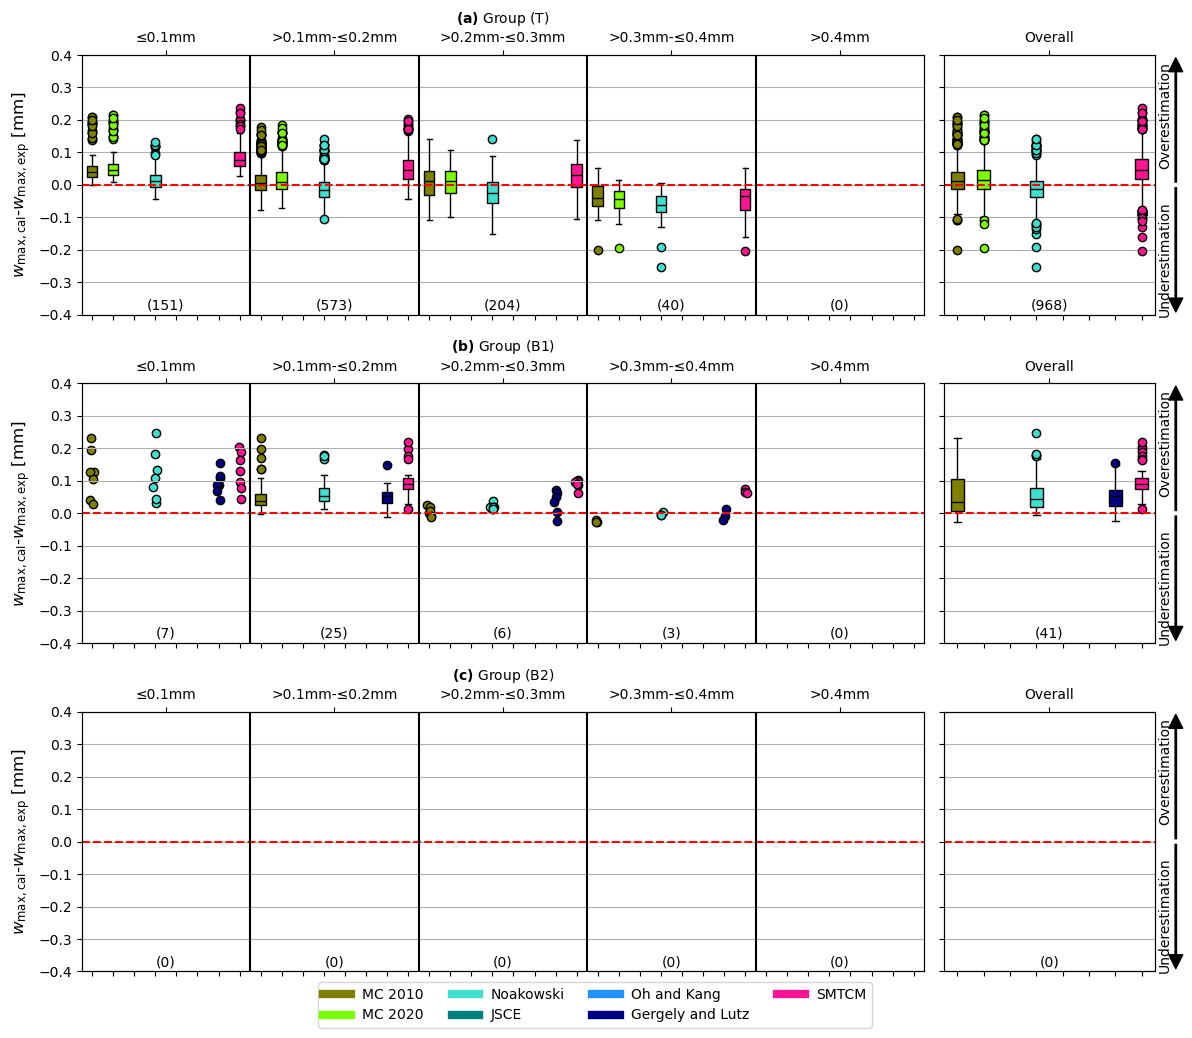

In [188]:
fig,ax = plt.subplots(nrows = 3, ncols = 2, gridspec_kw = {"width_ratios": [4,1]}, figsize=(round(1.3*9),10));
ax2_0 = ax[0,0].twiny();
ax2_1 = ax[1,0].twiny();
ax2_2 = ax[2,0].twiny();

bounds = binchoice_w;
tempvar = "meas_wmax";

# Group A
# ==============================================================================================================================
# Overall error - Group A
# --------------------------------------------------------
ax[0,1].set_ylim(-0.4,0.4);
ax[0,1].yaxis.set_ticklabels([]);

err_A0 = [];
Npoints_A0 = [];
err_A0_art = []; col_A0_art = [];

#list_A0 = ["EN 1992-1-1","NEN-EN 1992-1-1","FprEN 1992-1-1","MC 2010","MC 2020","","Noakowski","","","SMTCM"];
list_A0 = ["MC 2010","MC 2020","","Noakowski","","","","SMTCM"];

df_A0 = func_apply_group_filter(df[df["catf"]==2],hardfilter_A0,softfilter_A0);
wm_A0, wmax_A0, sm_A0, smax_A0, colors_A0 = func_compute_filtered_output_multiple(df_A0,list_A0);

for i in range(len(list_A0)):
    diff = wmax_A0[i]["cwf_wmax"] - wmax_A0[i]["meas_wmax"];
    print(wmax_A0[i]["ELID"].nunique())

    err_A0.append(diff); Npoints_A0.append(len(diff)); 
    err_A0_art.append(diff); err_A0_art.append(diff);
    col_A0_art.append(colors_A0); col_A0_art.append(colors_A0);

bplot = ax[0,1].boxplot(err_A0,patch_artist=True);
#bplot = ax[0,1].boxplot(err_A0,patch_artist=True,positions = [1,2,3,4,5,7,10]);
#viol = ax[0,1].violinplot(err_A0);

for err,patch_box,patch_flier,patch_med,col in \
    zip(err_A0,bplot["boxes"],bplot["fliers"],bplot["medians"],colors_A0):
    #zip(err_A0,bplot["boxes"],bplot["fliers"],bplot["medians"],viol["bodies"],colors_A0):
    if err.shape[0] < plotcutoff_overall:
        patch_box.set_visible(False);
        patch_med.set_visible(False)
        patch_flier.set_visible(False)

        #pc.set_visible(False);
    
    else:
        patch_box.set_facecolor(col);
        patch_med.set_color("k");
        patch_flier.set_markerfacecolor(col);

        #pc.set_facecolor(col);
        
        #for pc in viol["bodies"]:
            #pc.set_edgecolor("k");
            #pc.set_facecolor(col);

for err_A0_art,patch_whis,patch_cap,col in \
    zip(err_A0_art,bplot["whiskers"],bplot["caps"],col_A0_art):
        if err_A0_art.shape[0] < plotcutoff_overall:
            patch_whis.set_visible(False)
            patch_cap.set_visible(False)
    
for i in range(len(list_A0)):
    if err_A0[i].shape[0] < plotcutoff_overall:
        ax[0,1].scatter(1 + i + np.random.uniform(-0.1,0.1,len(err_A0[i])),err_A0[i],zorder=10,c=colors_A0[i],\
                           edgecolors="k");

ax[0,1].set_xticks(np.linspace(1,len(list_A0),len(list_A0)),[],rotation=60,ha="right");
#ax[0,1].set_xticks(np.linspace(1,10,10),[],rotation=60,ha="right");
ax[0,1].axhline(y=0,c="r",linestyle="--");

ax[0,1].text((len(list_A0)+1)/2,-0.35,"("+str(len(err_A0[-1]))+")",horizontalalignment="center",verticalalignment="top");
#ax[0,1].text(10/2,-0.45,len(err_A0[-1]),horizontalalignment="center",verticalalignment="top");

ax0_2_overall = ax[0,1].twiny();
ax0_2_overall.set_xticks([0.5]);
ax0_2_overall.set_xticklabels(["Overall"]);

x0 = 1.1
trans = mtransforms.blended_transform_factory(ax[0,1].transAxes, ax[0,1].transData)
y_tail = 0
y_head = 0.4
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax[0,1].add_patch(arrow1)
ax[0,1].text(1.05,0.05,"Overestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="bottom");
y_tail = 0
y_head = -0.4
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax[0,1].add_patch(arrow1)
ax[0,1].text(1.05,-0.05,"Underestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="top");
ax[0,1].grid(axis="y");

fig.tight_layout();

# Detailed
# --------------------------------------------------------
xlabel = [];
col = []; col_A0_art = [];
err_detailed_A0 = []; err_detailed_A0_art = [];

for i in range(0,len(bounds)+1):
    if i == 0:
        xlabel.append("≤"+str(bounds[0])+"mm");
    elif i == len(bounds):
        xlabel.append(">"+str(bounds[len(bounds)-1])+"mm");
    else:
        xlabel.append(">"+str(bounds[i-1])+"mm-≤"+str(bounds[i])+"mm");

    datastore = [];
    namestore = [];
    
    for j in range(len(list_A0)):
        if i == 0:
            temp = wmax_A0[j][(wmax_A0[j][tempvar] <= bounds[0])];
        elif i == len(bounds):
            temp = wmax_A0[j][(wmax_A0[j][tempvar] > bounds[len(bounds)-1])];
        else:
            temp = wmax_A0[j][((wmax_A0[j][tempvar] > bounds[i-1]) & (wmax_A0[j][tempvar] <= bounds[i]))];
    
        name = str("wmax"+"dataset"+str(i));
        datastore.append(temp);
        namestore.append(name);
    
        col.append(colors_A0[j]);

        err_detailed_A0.append(datastore[j]["cwf_wmax"] - datastore[j]["meas_wmax"]);
        err_detailed_A0_art.append(datastore[j]["cwf_wmax"] - datastore[j]["meas_wmax"]);
        err_detailed_A0_art.append(datastore[j]["cwf_wmax"] - datastore[j]["meas_wmax"]);

        col_A0_art.append(colors_A0[j]); col_A0_art.append(colors_A0[j]);

colcopy = col;



bplot = ax[0,0].boxplot(err_detailed_A0,patch_artist=True,positions=np.linspace(1,40,40));


# positions = [1,2,3,4,5,7,10]
#bplot = ax[0,0].boxplot(err_detailed_A0,patch_artist=True,positions=
#                        [1,2,3,4,5,7,10,
#                         11,12,13,14,15,17,20,
#                         21,22,23,24,25,27,30,
#                         31,32,33,34,35,37,40,
#                         41,42,43,44,45,47,50]);
#viol = ax[0,0].violinplot(err_detailed_A0);

for err,patch_box,patch_flier,patch_med,col in zip(err_detailed_A0,bplot["boxes"],bplot["fliers"],bplot["medians"], col):
    if err.shape[0] < plotcutoff_detail:
        patch_box.set_visible(False);
        patch_flier.set_visible(False);
        patch_med.set_visible(False);
    else:
        patch_box.set_facecolor(col);
        patch_flier.set_markerfacecolor(col);
        patch_med.set_color("k");

for err,patch_whis,patch_cap,col in zip(err_detailed_A0_art,bplot["whiskers"],bplot["caps"], col_A0_art):
    if err.shape[0] < plotcutoff_detail:
        patch_whis.set_visible(False);
        patch_cap.set_visible(False);

ax[0,0].set_ylim(-0.4,0.4);
ax[0,0].set_title("$\\bf{(a)}$ Group (T)");
ax[0,0].axhline(y=0,c="r",linestyle="--");
ax[0,0].set_ylabel("$w_{\\rm{max,cal}}$-$w_{\\rm{max,exp}}$ [mm]");

Ndatpoints = (len(bounds)+1)*(len(list_A0)+1);
ax[0,0].set_xticks(np.linspace(1,Ndatpoints,Ndatpoints),(len(bounds))*[]*(len(list_A0)),rotation=60,ha="right");
ax[0,0].grid(axis="y");

loc_xtick = np.linspace(0.5/(len(bounds)+1),1-(0.5/(len(bounds)+1)),len(bounds)+1);
diff = loc_xtick[1] - loc_xtick[0];

ax2_0.set_xticks(loc_xtick);
ax2_0.set_xticklabels(xlabel);

loc_ax = np.linspace(0.5/(len(bounds)+1) + diff/2,1-(0.5/(len(bounds)+1)) - diff/2,len(bounds));
for xc in loc_ax:
    ax2_0.axvline(x=xc,color="k");

for i in range((len(bounds)+1)*(len(list_A0))):
    if len(err_detailed_A0[i]) < plotcutoff_detail:
        ax[0,0].scatter(1 + i + np.random.uniform(-0.1,0.1,len(err_detailed_A0[i])),err_detailed_A0[i],c=colcopy[i],\
                       edgecolors="k");

for i in range(len(loc_xtick)):
    ax[0,0].text(loc_xtick[i]*(len(bounds)+1)*(len(list_A0)) + 0.5,-0.35,"("+str(len(err_detailed_A0[(i+1)*(len(list_A0))-1]))+")",\
                     horizontalalignment="center",verticalalignment="top");

# Group C
# ==============================================================================================================================
# Overall error - Group C
# --------------------------------------------------------
ax[1,1].set_ylim(-0.4,0.4);
ax[1,1].yaxis.set_ticklabels([]);

err_C = [];
Npoints_C = [];
err_C_art = []; col_C_art = [];


#list_C = ["","","FprEN 1992-1-1","MC 2010","","Oh + Kang","Noakowski","","Gergely + Lutz","SMTCM"];
#list_C = ["","","FprEN 1992-1-1","MC 2010","","","Noakowski","","Gergely + Lutz","SMTCM"];
list_C = ["MC 2010","","","Noakowski","","","Gergely + Lutz","SMTCM"];
df_C = func_apply_group_filter(df[df["catf"] == 2],hardfilter_C,softfilter_C);
wm_C, wmax_C, sm_C, smax_C, colors_C = func_compute_filtered_output_multiple(df_C,list_C);

for i in range(len(list_C)):
    diff = wmax_C[i]["cwf_wmax"] - wmax_C[i]["meas_wmax"];
    
    err_C.append(diff); Npoints_C.append(len(diff)); 
    err_C_art.append(diff); err_C_art.append(diff);
    col_C_art.append(colors_C); col_C_art.append(colors_C);

bplot = ax[1,1].boxplot(err_C,patch_artist=True);
#bplot = ax[1,1].boxplot(err_C,patch_artist=True,positions = [3.5,4.4,6.3,7.2,9.1,10]);
#viol = ax[1,1].violinplot(err_C);

for err,patch_box,patch_flier,patch_med,col in \
    zip(err_C,bplot["boxes"],bplot["fliers"],bplot["medians"],colors_C):
    if err.shape[0] < plotcutoff_overall:
        patch_box.set_visible(False);
        patch_med.set_visible(False)
        patch_flier.set_visible(False)
    else:
        patch_box.set_facecolor(col);
        patch_med.set_color("k");
        patch_flier.set_markerfacecolor(col);

for err_C_art,patch_whis,patch_cap,col in \
    zip(err_C_art,bplot["whiskers"],bplot["caps"],col_C_art):
        if err_C_art.shape[0] < plotcutoff_overall:
            patch_whis.set_visible(False)
            patch_cap.set_visible(False)
    
for i in range(len(list_C)):
    if err_C[i].shape[0] < plotcutoff_overall:
        ax[1,1].scatter(1 + i + np.random.uniform(-0.1,0.1,len(err_C[i])),err_C[i],zorder=10,c=colors_C[i],\
                       edgecolors="k");

ax[1,1].set_xticks(np.linspace(1,len(list_C),len(list_C)),[],rotation=60,ha="right");
#ax[1,1].set_xticks([1.5,2.5,3.5,4.4,5.4,6.3,7.2,8.1,9.1,10],[],rotation=60,ha="right");
ax[1,1].axhline(y=0,c="r",linestyle="--");

ax[1,1].text((len(list_C)+1)/2,-0.35,"("+str(len(err_C[-1]))+")",horizontalalignment="center",verticalalignment="top");
#ax[1,1].text(10/2,-0.45,len(err_C[-1]),horizontalalignment="center",verticalalignment="top");

ax1_2_overall = ax[1,1].twiny();
ax1_2_overall.set_xticks([0.5]);
ax1_2_overall.set_xticklabels(["Overall"]);


x0 = 1.1
trans = mtransforms.blended_transform_factory(ax[1,1].transAxes, ax[1,1].transData)
y_tail = 0
y_head = 0.4
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax[1,1].add_patch(arrow1)
ax[1,1].text(1.05,0.05,"Overestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="bottom");
y_tail = 0
y_head = -0.4
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax[1,1].add_patch(arrow1)
ax[1,1].text(1.05,-0.05,"Underestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="top");
ax[1,1].grid(axis="y");


fig.tight_layout();

# Detailed
# --------------------------------------------------------
xlabel = [];
col = [];
err_detailed_C = []; err_detailed_C_art = []; col_C_art = [];

#for i in range(len(bounds)+1):
#for i in range(1,len(bounds)+1):
for i in range(0,len(bounds)+1):
    if i == 0:
        xlabel.append("≤"+str(bounds[0])+"mm");
    elif i == len(bounds):
        xlabel.append(">"+str(bounds[len(bounds)-1])+"mm");
    else:
        xlabel.append(">"+str(bounds[i-1])+"mm-≤"+str(bounds[i])+"mm");

    datastore = [];
    namestore = [];
    
    for j in range(len(list_C)):
        if i == 0:
            temp = wmax_C[j][(wmax_C[j][tempvar] <= bounds[0])];
        elif i == len(bounds):
            temp = wmax_C[j][(wmax_C[j][tempvar] > bounds[len(bounds)-1])];
        else:
            temp = wmax_C[j][((wmax_C[j][tempvar] > bounds[i-1]) & (wmax_C[j][tempvar] <= bounds[i]))];
    
        name = str("wmax"+"dataset"+str(i));
        datastore.append(temp);
        namestore.append(name);
    
        col.append(colors_C[j]);

        err_detailed_C.append(datastore[j]["cwf_wmax"] - datastore[j]["meas_wmax"]);
        err_detailed_C_art.append(datastore[j]["cwf_wmax"] - datastore[j]["meas_wmax"]);
        err_detailed_C_art.append(datastore[j]["cwf_wmax"] - datastore[j]["meas_wmax"]);

        col_C_art.append(colors_C[j]); col_C_art.append(colors_C[j]);

colcopy = col;

bplot = ax[1,0].boxplot(err_detailed_C,patch_artist=True);

#bplot = ax[1,0].boxplot(err_detailed_C,patch_artist=True,positions = [
#     3.5,4.4,6.3,7.2,9.1,10,
#     13.5,14.4,16.3,17.2,19.1,20,
#     23.5,24.4,26.3,27.2,29.1,30,
#     33.5,34.4,36.3,37.2,39.1,40,
#     43.5,44.4,46.3,47.2,49.1,50
#]);


#positions = [3.5,4.4,6.3,7.2,9.1,10]);

#viol = ax[1,0].violinplot(err_detailed_C);
for err,patch_box,patch_flier,patch_med,col in zip(err_detailed_C,bplot["boxes"],bplot["fliers"],bplot["medians"], col):
    if err.shape[0] < plotcutoff_detail:
        patch_box.set_visible(False);
        patch_flier.set_visible(False);
        patch_med.set_visible(False);
    else:
        patch_box.set_facecolor(col);
        patch_med.set_color("k");
        patch_flier.set_markerfacecolor(col);

for err,patch_whis,patch_cap,col in zip(err_detailed_C_art,bplot["whiskers"],bplot["caps"], col_C_art):
    if err.shape[0] < plotcutoff_detail:
        patch_whis.set_visible(False);
        patch_cap.set_visible(False);

ax[1,0].set_title("$\\bf{(b)}$ Group (B1)");
ax[1,0].axhline(y=0,c="r",linestyle="--");
ax[1,0].set_ylim(-0.4,0.4);
ax[1,0].set_ylabel("$w_{\\rm{max,cal}}$-$w_{\\rm{max,exp}}$ [mm]");
ax[1,0].grid(axis="y");

Ndatpoints = (len(bounds)+1)*(len(list_C));
ax[1,0].set_xticks(np.linspace(1,Ndatpoints,Ndatpoints),(len(bounds))*[]*len(list_C),rotation=60,ha="right");

loc_xtick = np.linspace(0.5/(len(bounds)+1),1-(0.5/(len(bounds)+1)),len(bounds)+1);
diff = loc_xtick[1] - loc_xtick[0];

ax2_1.set_xticks(loc_xtick);
ax2_1.set_xticklabels(xlabel);

loc_ax = np.linspace(0.5/(len(bounds)+1) + diff/2,1-(0.5/(len(bounds)+1)) - diff/2,len(bounds));
for xc in loc_ax:
    ax2_1.axvline(x=xc,color="k");

for i in range((len(bounds)+1)*(len(list_C))):
    if len(err_detailed_C[i]) < plotcutoff_detail:
        ax[1,0].scatter(1 + i + np.random.uniform(-0.1,0.1,len(err_detailed_C[i])),err_detailed_C[i],c=colcopy[i],\
                       edgecolors="k");

for i in range(len(loc_xtick)):
    ax[1,0].text(loc_xtick[i]*(len(bounds)+1)*(len(list_C)) + 0.5,-0.35,"("+str(len(err_detailed_C[(i+1)*(len(list_C))-1]))+")",\
                     horizontalalignment="center",verticalalignment="top");

# Group D
# ==============================================================================================================================
# Overall error - Group D
ax[2,1].set_ylim(-0.4,0.4);
ax[2,1].yaxis.set_ticklabels([]);

err_D = [];
Npoints_D = [];
err_D_art = []; col_D_art = [];

df_D = func_apply_group_filter(df[df["catf"] == 2],hardfilter_D,softfilter_D);
wm_D, wmax_D, sm_D, smax_D, colors_D = func_compute_filtered_output_multiple(df_D,list_D);

for i in range(len(list_D)):
    diff = wmax_D[i]["cwf_wmax"] - wmax_D[i]["meas_wmax"];
    
    err_D.append(diff); Npoints_D.append(len(diff)); 
    err_D_art.append(diff); err_D_art.append(diff);
    col_D_art.append(colors_D); col_D_art.append(colors_D);

bplot = ax[2,1].boxplot(err_D,patch_artist=True);
#viol = ax[2,1].violinplot(err_D);

for err,patch_box,patch_flier,patch_med,col in \
    zip(err_D,bplot["boxes"],bplot["fliers"],bplot["medians"],colors_D):
    if err.shape[0] < plotcutoff_overall:
        patch_box.set_visible(False);
        patch_med.set_visible(False)
        patch_flier.set_visible(False)
    else:
        patch_box.set_facecolor(col);
        patch_med.set_color("k");
        patch_flier.set_markerfacecolor(col);

for err_D_art,patch_whis,patch_cap,col in \
    zip(err_D_art,bplot["whiskers"],bplot["caps"],col_D_art):
        if err_D_art.shape[0] < plotcutoff_overall:
            patch_whis.set_visible(False)
            patch_cap.set_visible(False)
    
for i in range(len(list_D)):
    if err_D[i].shape[0] < plotcutoff_overall:
        ax[2,1].scatter(1 + i + np.random.uniform(-0.1,0.1,len(err_D[i])),err_D[i],zorder=10,c=colors_D[i],edgecolors="k");

ax[2,1].set_xticks(np.linspace(1,len(list_D),len(list_D)),[],rotation=60,ha="right");
ax[2,1].axhline(y=0,c="r",linestyle="--");

ax[2,1].text((len(list_D)+1)/2,-0.35,"("+str(len(err_D[-1]))+")",horizontalalignment="center",verticalalignment="top");

ax2_2_overall = ax[2,1].twiny();
ax2_2_overall.set_xticks([0.5]);
ax2_2_overall.set_xticklabels(["Overall"]);

x0 = 1.1
trans = mtransforms.blended_transform_factory(ax[2,1].transAxes, ax[2,1].transData)
y_tail = 0
y_head = 0.4
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax[2,1].add_patch(arrow1)
ax[2,1].text(1.05,0.05,"Overestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="bottom");
y_tail = 0
y_head = -0.4
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax[2,1].add_patch(arrow1)
ax[2,1].text(1.05,-0.05,"Underestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="top");
ax[2,1].grid(axis="y");

# Detailed
# --------------------------------------------------------
xlabel = [];
col = []; col_D_art = [];
err_detailed_D = []; err_detailed_D_art = [];

for i in range(0,len(bounds)+1):
    if i == 0:
        xlabel.append("≤"+str(bounds[0])+"mm");
    elif i == len(bounds):
        xlabel.append(">"+str(bounds[len(bounds)-1])+"mm");
    else:
        xlabel.append(">"+str(bounds[i-1])+"mm-≤"+str(bounds[i])+"mm");

    datastore = [];
    namestore = [];
    
    for j in range(len(list_D)):
        if i == 0:
            temp = wmax_D[j][(wmax_D[j][tempvar] <= bounds[0])];
        elif i == len(bounds):
            temp = wmax_D[j][(wmax_D[j][tempvar] > bounds[len(bounds)-1])];
        else:
            temp = wmax_D[j][((wmax_D[j][tempvar] > bounds[i-1]) & (wmax_D[j][tempvar] <= bounds[i]))];
    
        name = str("wmax"+"dataset"+str(i));
        datastore.append(temp);
        namestore.append(name);
    
        col.append(colors_D[j]);

        err_detailed_D.append(datastore[j]["cwf_wmax"] - datastore[j]["meas_wmax"]);
        err_detailed_D_art.append(datastore[j]["cwf_wmax"] - datastore[j]["meas_wmax"]);
        err_detailed_D_art.append(datastore[j]["cwf_wmax"] - datastore[j]["meas_wmax"]);

        col_D_art.append(colors_D[j]); col_D_art.append(colors_D[j]);

colcopy = col;

bplot = ax[2,0].boxplot(err_detailed_D,patch_artist=True);
#viol = ax[2,0].violinplot(err_detailed_D);

for err,patch_box,patch_flier,patch_med,col in zip(err_detailed_D,bplot["boxes"], bplot["fliers"],bplot["medians"], col):
    if err.shape[0] < plotcutoff_detail:
        patch_box.set_visible(False);
        patch_flier.set_visible(False);
        patch_med.set_visible(False);
    else:
        patch_box.set_facecolor(col);
        patch_med.set_color("k");
        patch_flier.set_markerfacecolor(col);

for err,patch_whis,patch_cap,col in zip(err_detailed_D_art,bplot["whiskers"],bplot["caps"], col_D_art):
    if err.shape[0] < plotcutoff_detail:
        patch_whis.set_visible(False);
        patch_cap.set_visible(False);

ax[2,0].set_title("$\\bf{(c)}$ Group (B2)");
ax[2,0].axhline(y=0,c="r",linestyle="--");
ax[2,0].set_ylim(-0.4,0.4);
ax[2,0].set_ylabel("$w_{\\rm{max,cal}}$-$w_{\\rm{max,exp}}$ [mm]");
ax[2,0].grid(axis="y");

Ndatpoints = (len(bounds)+1)*(len(list_D));
ax[2,0].set_xticks(np.linspace(1,Ndatpoints,Ndatpoints),(len(bounds))*[]*len(list_D),rotation=60,ha="right");

loc_xtick = np.linspace(0.5/(len(bounds)+1),1-(0.5/(len(bounds)+1)),len(bounds)+1);
diff = loc_xtick[1] - loc_xtick[0];

ax2_2.set_xticks(loc_xtick);
ax2_2.set_xticklabels(xlabel);

loc_ax = np.linspace(0.5/(len(bounds)+1) + diff/2,1-(0.5/(len(bounds)+1)) - diff/2,len(bounds));
for xc in loc_ax:
    ax2_2.axvline(x=xc,color="k");

for i in range((len(bounds)+1)*(len(list_D))):
    if len(err_detailed_D[i]) < plotcutoff_detail:
        ax[2,0].scatter(1 + i + np.random.uniform(-0.1,0.1,len(err_detailed_D[i])),err_detailed_D[i],c=colcopy[i],edgecolors="k");

#for i in range((len(bounds)+1)*(len(list_D))):
#    ax[2,0].text(1 + diff/2 + diff*i*(len(bounds)+1),-0.45,len(err_detailed_D[i]),horizontalalignment="center",verticalalignment="top");

for i in range(len(loc_xtick)):
    ax[2,0].text(loc_xtick[i]*(len(bounds)+1)*(len(list_D)) + 0.5,-0.35,"("+str(len(err_detailed_D[(i+1)*(len(list_D))-1]))+")",\
                     horizontalalignment="center",verticalalignment="top");

fig.tight_layout();


#ax[0,0].text(-2.5,-0.55,"(a)")
#ax[1,0].text(-2.5*(7/7),-0.55,"(b)")
#ax[2,0].text(-2.5*(10/10),-0.55,"(c)")


# Create legend
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
legend_elements = [
                   Line2D([0], [0], color='olive', lw=6, label='MC 2010'),
                   Line2D([0], [0], color='lawngreen', lw=6, label='MC 2020'),
                   Line2D([0], [0], color='turquoise', lw=6, label='Noakowski'),
                   Line2D([0], [0], color='teal', lw=6, label='JSCE'),
                   Line2D([0], [0], color='dodgerblue', lw=6, label='Oh and Kang'),
                   Line2D([0], [0], color='navy', lw=6, label='Gergely and Lutz'),
                   #Line2D([0], [0], color='blueviolet', lw=6, label='Frosch'),
                   Line2D([0], [0], color='deeppink', lw=6, label='SMTCM')
                  ];
fig.legend(handles=legend_elements, loc="lower center",ncol=4,bbox_to_anchor=(0.5,-0.04));
#plt.savefig(Path(motherpath/r"1_st_Journal_Paper\Figures\Python\w_summarized.svg"));
plt.savefig(Path(motherpath/r"1_st_Journal_Paper\Figures\SVG\w_imposed_deformations.svg"),bbox_inches='tight');

### Figure paper - External forces / imposed - compacted!

Number of datapoints 112
Number of tested elements 45
data_shape (112, 213)
meas_wmax.shape (112,)
dfwaxfiltered (112, 15)
wmax_add.shape (112, 15)
meas_wmax.shape (112,)
dfwaxfiltered (112, 15)
wmax_add.shape (112, 15)
meas_wmax.shape (112,)
dfwaxfiltered (0, 15)
wmax_add.shape (0, 15)
meas_wmax.shape (112,)
dfwaxfiltered (112, 15)
wmax_add.shape (112, 15)
meas_wmax.shape (112,)
dfwaxfiltered (112, 15)
wmax_add.shape (112, 15)
meas_wmax.shape (112,)
dfwaxfiltered (0, 15)
wmax_add.shape (0, 15)
meas_wmax.shape (112,)
dfwaxfiltered (0, 15)
wmax_add.shape (0, 15)
(112,)
meas_wmax.shape (112,)
dfwaxfiltered (112, 15)
wmax_add.shape (112, 15)
45
45
0
45
45
0
0
45
Number of datapoints 968
Number of tested elements 105
data_shape (968, 213)
meas_wmax.shape (968,)
dfwaxfiltered (968, 15)
wmax_add.shape (968, 15)
meas_wmax.shape (968,)
dfwaxfiltered (968, 15)
wmax_add.shape (968, 15)
meas_wmax.shape (968,)
dfwaxfiltered (0, 15)
wmax_add.shape (0, 15)
meas_wmax.shape (968,)
dfwaxfiltered (968, 

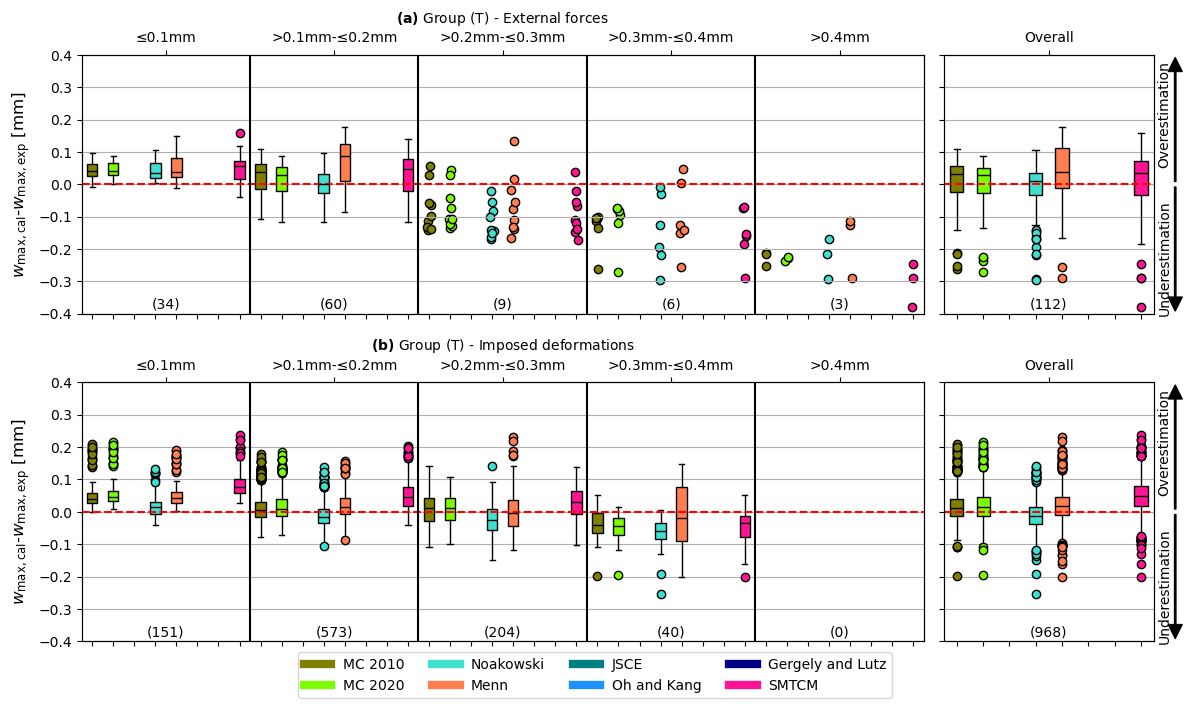

In [189]:
fig,ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw = {"width_ratios": [4,1]}, figsize=(round(1.3*9),6.7));
ax2_0 = ax[0,0].twiny();
ax2_1 = ax[1,0].twiny();

bounds = binchoice_w;
tempvar = "meas_wmax";

# Group A - EXTERNAL FORCES
# ==============================================================================================================================
# Overall error - Group A
# --------------------------------------------------------
ax[0,1].set_ylim(-0.4,0.4);
ax[0,1].yaxis.set_ticklabels([]);

err_A0 = [];
Npoints_A0 = [];
err_A0_art = []; col_A0_art = [];

#list_A0 = ["EN 1992-1-1","NEN-EN 1992-1-1","FprEN 1992-1-1","MC 2010","MC 2020","","Noakowski","","","SMTCM"];
list_A0 = ["MC 2010","MC 2020","","Noakowski","Menn","","","SMTCM"];

df_A0 = func_apply_group_filter(df[df["catf"]==1],hardfilter_A0,softfilter_A0);
wm_A0, wmax_A0, sm_A0, smax_A0, colors_A0 = func_compute_filtered_output_multiple(df_A0,list_A0);

for i in range(len(list_A0)):
    diff = wmax_A0[i]["cwf_wmax"] - wmax_A0[i]["meas_wmax"];
    print(wmax_A0[i]["ELID"].nunique())

    err_A0.append(diff); Npoints_A0.append(len(diff)); 
    err_A0_art.append(diff); err_A0_art.append(diff);
    col_A0_art.append(colors_A0); col_A0_art.append(colors_A0);

bplot = ax[0,1].boxplot(err_A0,patch_artist=True);
#bplot = ax[0,1].boxplot(err_A0,patch_artist=True,positions = [1,2,3,4,5,7,10]);
#viol = ax[0,1].violinplot(err_A0);

for err,patch_box,patch_flier,patch_med,col in \
    zip(err_A0,bplot["boxes"],bplot["fliers"],bplot["medians"],colors_A0):
    #zip(err_A0,bplot["boxes"],bplot["fliers"],bplot["medians"],viol["bodies"],colors_A0):
    if err.shape[0] < plotcutoff_overall:
        patch_box.set_visible(False);
        patch_med.set_visible(False)
        patch_flier.set_visible(False)

        #pc.set_visible(False);
    
    else:
        patch_box.set_facecolor(col);
        patch_med.set_color("k");
        patch_flier.set_markerfacecolor(col);

        #pc.set_facecolor(col);
        
        #for pc in viol["bodies"]:
            #pc.set_edgecolor("k");
            #pc.set_facecolor(col);

for err_A0_art,patch_whis,patch_cap,col in \
    zip(err_A0_art,bplot["whiskers"],bplot["caps"],col_A0_art):
        if err_A0_art.shape[0] < plotcutoff_overall:
            patch_whis.set_visible(False)
            patch_cap.set_visible(False)
    
for i in range(len(list_A0)):
    if err_A0[i].shape[0] < plotcutoff_overall:
        ax[0,1].scatter(1 + i + np.random.uniform(-0.1,0.1,len(err_A0[i])),err_A0[i],zorder=10,c=colors_A0[i],\
                           edgecolors="k");

ax[0,1].set_xticks(np.linspace(1,len(list_A0),len(list_A0)),[],rotation=60,ha="right");
#ax[0,1].set_xticks(np.linspace(1,10,10),[],rotation=60,ha="right");
ax[0,1].axhline(y=0,c="r",linestyle="--");

ax[0,1].text((len(list_A0)+1)/2,-0.35,"("+str(len(err_A0[-1]))+")",horizontalalignment="center",verticalalignment="top");
#ax[0,1].text(10/2,-0.45,len(err_A0[-1]),horizontalalignment="center",verticalalignment="top");

ax0_2_overall = ax[0,1].twiny();
ax0_2_overall.set_xticks([0.5]);
ax0_2_overall.set_xticklabels(["Overall"]);

x0 = 1.1
trans = mtransforms.blended_transform_factory(ax[0,1].transAxes, ax[0,1].transData)
y_tail = 0
y_head = 0.4
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax[0,1].add_patch(arrow1)
ax[0,1].text(1.05,0.05,"Overestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="bottom");
y_tail = 0
y_head = -0.4
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax[0,1].add_patch(arrow1)
ax[0,1].text(1.05,-0.05,"Underestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="top");
ax[0,1].grid(axis="y");

fig.tight_layout();

# Detailed
# --------------------------------------------------------
xlabel = [];
col = []; col_A0_art = [];
err_detailed_A0 = []; err_detailed_A0_art = [];

for i in range(0,len(bounds)+1):
    if i == 0:
        xlabel.append("≤"+str(bounds[0])+"mm");
    elif i == len(bounds):
        xlabel.append(">"+str(bounds[len(bounds)-1])+"mm");
    else:
        xlabel.append(">"+str(bounds[i-1])+"mm-≤"+str(bounds[i])+"mm");

    datastore = [];
    namestore = [];
    
    for j in range(len(list_A0)):
        if i == 0:
            temp = wmax_A0[j][(wmax_A0[j][tempvar] <= bounds[0])];
        elif i == len(bounds):
            temp = wmax_A0[j][(wmax_A0[j][tempvar] > bounds[len(bounds)-1])];
        else:
            temp = wmax_A0[j][((wmax_A0[j][tempvar] > bounds[i-1]) & (wmax_A0[j][tempvar] <= bounds[i]))];
    
        name = str("wmax"+"dataset"+str(i));
        datastore.append(temp);
        namestore.append(name);
    
        col.append(colors_A0[j]);

        err_detailed_A0.append(datastore[j]["cwf_wmax"] - datastore[j]["meas_wmax"]);
        err_detailed_A0_art.append(datastore[j]["cwf_wmax"] - datastore[j]["meas_wmax"]);
        err_detailed_A0_art.append(datastore[j]["cwf_wmax"] - datastore[j]["meas_wmax"]);

        col_A0_art.append(colors_A0[j]); col_A0_art.append(colors_A0[j]);

colcopy = col;



bplot = ax[0,0].boxplot(err_detailed_A0,patch_artist=True,positions=np.linspace(1,40,40));


for err,patch_box,patch_flier,patch_med,col in zip(err_detailed_A0,bplot["boxes"],bplot["fliers"],bplot["medians"], col):
    if err.shape[0] < plotcutoff_detail:
        patch_box.set_visible(False);
        patch_flier.set_visible(False);
        patch_med.set_visible(False);
    else:
        patch_box.set_facecolor(col);
        patch_flier.set_markerfacecolor(col);
        patch_med.set_color("k");

for err,patch_whis,patch_cap,col in zip(err_detailed_A0_art,bplot["whiskers"],bplot["caps"], col_A0_art):
    if err.shape[0] < plotcutoff_detail:
        patch_whis.set_visible(False);
        patch_cap.set_visible(False);

ax[0,0].set_ylim(-0.4,0.4);
ax[0,0].set_title("$\\bf{(a)}$ Group (T) - External forces");
ax[0,0].axhline(y=0,c="r",linestyle="--");
ax[0,0].set_ylabel("$w_{\\rm{max,cal}}$-$w_{\\rm{max,exp}}$ [mm]");

Ndatpoints = (len(bounds)+1)*(len(list_A0)+1);
ax[0,0].set_xticks(np.linspace(1,Ndatpoints,Ndatpoints),(len(bounds))*[]*(len(list_A0)),rotation=60,ha="right");
ax[0,0].grid(axis="y");

loc_xtick = np.linspace(0.5/(len(bounds)+1),1-(0.5/(len(bounds)+1)),len(bounds)+1);
diff = loc_xtick[1] - loc_xtick[0];

ax2_0.set_xticks(loc_xtick);
ax2_0.set_xticklabels(xlabel);

loc_ax = np.linspace(0.5/(len(bounds)+1) + diff/2,1-(0.5/(len(bounds)+1)) - diff/2,len(bounds));
for xc in loc_ax:
    ax2_0.axvline(x=xc,color="k");

for i in range((len(bounds)+1)*(len(list_A0))):
    if len(err_detailed_A0[i]) < plotcutoff_detail:
        ax[0,0].scatter(1 + i + np.random.uniform(-0.1,0.1,len(err_detailed_A0[i])),err_detailed_A0[i],c=colcopy[i],\
                       edgecolors="k");

for i in range(len(loc_xtick)):
    ax[0,0].text(loc_xtick[i]*(len(bounds)+1)*(len(list_A0)) + 0.5,-0.35,"("+str(len(err_detailed_A0[(i+1)*(len(list_A0))-1]))+")",\
                     horizontalalignment="center",verticalalignment="top");

# Group B - IMPOSED DEFORMATIONS
# ==============================================================================================================================
# Overall error - Group A
# --------------------------------------------------------

ax[1,1].set_ylim(-0.4,0.4);
ax[1,1].yaxis.set_ticklabels([]);

err_A0 = [];
Npoints_A0 = [];
err_A0_art = []; col_A0_art = [];

#list_A0 = ["EN 1992-1-1","NEN-EN 1992-1-1","FprEN 1992-1-1","MC 2010","MC 2020","","Noakowski","","","SMTCM"];
list_A0 = ["MC 2010","MC 2020","","Noakowski","Menn","","","SMTCM"];

df_A0 = func_apply_group_filter(df[df["catf"]==2],hardfilter_A0,softfilter_A0);
wm_A0, wmax_A0, sm_A0, smax_A0, colors_A0 = func_compute_filtered_output_multiple(df_A0,list_A0);

for i in range(len(list_A0)):
    diff = wmax_A0[i]["cwf_wmax"] - wmax_A0[i]["meas_wmax"];
    print(wmax_A0[i]["ELID"].nunique())

    err_A0.append(diff); Npoints_A0.append(len(diff)); 
    err_A0_art.append(diff); err_A0_art.append(diff);
    col_A0_art.append(colors_A0); col_A0_art.append(colors_A0);

bplot = ax[1,1].boxplot(err_A0,patch_artist=True);
#bplot = ax[0,1].boxplot(err_A0,patch_artist=True,positions = [1,2,3,4,5,7,10]);
#viol = ax[0,1].violinplot(err_A0);

for err,patch_box,patch_flier,patch_med,col in \
    zip(err_A0,bplot["boxes"],bplot["fliers"],bplot["medians"],colors_A0):
    #zip(err_A0,bplot["boxes"],bplot["fliers"],bplot["medians"],viol["bodies"],colors_A0):
    if err.shape[0] < plotcutoff_overall:
        patch_box.set_visible(False);
        patch_med.set_visible(False)
        patch_flier.set_visible(False)

        #pc.set_visible(False);
    
    else:
        patch_box.set_facecolor(col);
        patch_med.set_color("k");
        patch_flier.set_markerfacecolor(col);

        #pc.set_facecolor(col);
        
        #for pc in viol["bodies"]:
            #pc.set_edgecolor("k");
            #pc.set_facecolor(col);

for err_A0_art,patch_whis,patch_cap,col in \
    zip(err_A0_art,bplot["whiskers"],bplot["caps"],col_A0_art):
        if err_A0_art.shape[0] < plotcutoff_overall:
            patch_whis.set_visible(False)
            patch_cap.set_visible(False)
    
for i in range(len(list_A0)):
    if err_A0[i].shape[0] < plotcutoff_overall:
        ax[1,1].scatter(1 + i + np.random.uniform(-0.1,0.1,len(err_A0[i])),err_A0[i],zorder=10,c=colors_A0[i],\
                           edgecolors="k");

ax[1,1].set_xticks(np.linspace(1,len(list_A0),len(list_A0)),[],rotation=60,ha="right");
#ax[0,1].set_xticks(np.linspace(1,10,10),[],rotation=60,ha="right");
ax[1,1].axhline(y=0,c="r",linestyle="--");

ax[1,1].text((len(list_A0)+1)/2,-0.35,"("+str(len(err_A0[-1]))+")",horizontalalignment="center",verticalalignment="top");
#ax[0,1].text(10/2,-0.45,len(err_A0[-1]),horizontalalignment="center",verticalalignment="top");

ax0_2_overall = ax[1,1].twiny();
ax0_2_overall.set_xticks([0.5]);
ax0_2_overall.set_xticklabels(["Overall"]);

x0 = 1.1
trans = mtransforms.blended_transform_factory(ax[1,1].transAxes, ax[1,1].transData)
y_tail = 0
y_head = 0.4
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax[1,1].add_patch(arrow1)
ax[1,1].text(1.05,0.05,"Overestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="bottom");
y_tail = 0
y_head = -0.4
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax[1,1].add_patch(arrow1)
ax[1,1].text(1.05,-0.05,"Underestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="top");
ax[1,1].grid(axis="y");

fig.tight_layout();

# Detailed
# --------------------------------------------------------
xlabel = [];
col = []; col_A0_art = [];
err_detailed_A0 = []; err_detailed_A0_art = [];

for i in range(0,len(bounds)+1):
    if i == 0:
        xlabel.append("≤"+str(bounds[0])+"mm");
    elif i == len(bounds):
        xlabel.append(">"+str(bounds[len(bounds)-1])+"mm");
    else:
        xlabel.append(">"+str(bounds[i-1])+"mm-≤"+str(bounds[i])+"mm");

    datastore = [];
    namestore = [];
    
    for j in range(len(list_A0)):
        if i == 0:
            temp = wmax_A0[j][(wmax_A0[j][tempvar] <= bounds[0])];
        elif i == len(bounds):
            temp = wmax_A0[j][(wmax_A0[j][tempvar] > bounds[len(bounds)-1])];
        else:
            temp = wmax_A0[j][((wmax_A0[j][tempvar] > bounds[i-1]) & (wmax_A0[j][tempvar] <= bounds[i]))];
    
        name = str("wmax"+"dataset"+str(i));
        datastore.append(temp);
        namestore.append(name);
    
        col.append(colors_A0[j]);

        err_detailed_A0.append(datastore[j]["cwf_wmax"] - datastore[j]["meas_wmax"]);
        err_detailed_A0_art.append(datastore[j]["cwf_wmax"] - datastore[j]["meas_wmax"]);
        err_detailed_A0_art.append(datastore[j]["cwf_wmax"] - datastore[j]["meas_wmax"]);

        col_A0_art.append(colors_A0[j]); col_A0_art.append(colors_A0[j]);

colcopy = col;



bplot = ax[1,0].boxplot(err_detailed_A0,patch_artist=True,positions=np.linspace(1,40,40));


for err,patch_box,patch_flier,patch_med,col in zip(err_detailed_A0,bplot["boxes"],bplot["fliers"],bplot["medians"], col):
    if err.shape[0] < plotcutoff_detail:
        patch_box.set_visible(False);
        patch_flier.set_visible(False);
        patch_med.set_visible(False);
    else:
        patch_box.set_facecolor(col);
        patch_flier.set_markerfacecolor(col);
        patch_med.set_color("k");

for err,patch_whis,patch_cap,col in zip(err_detailed_A0_art,bplot["whiskers"],bplot["caps"], col_A0_art):
    if err.shape[0] < plotcutoff_detail:
        patch_whis.set_visible(False);
        patch_cap.set_visible(False);

ax[1,0].set_ylim(-0.4,0.4);
ax[1,0].set_title("$\\bf{(b)}$ Group (T) - Imposed deformations");
ax[1,0].axhline(y=0,c="r",linestyle="--");
ax[1,0].set_ylabel("$w_{\\rm{max,cal}}$-$w_{\\rm{max,exp}}$ [mm]");

Ndatpoints = (len(bounds)+1)*(len(list_A0)+1);
ax[1,0].set_xticks(np.linspace(1,Ndatpoints,Ndatpoints),(len(bounds))*[]*(len(list_A0)),rotation=60,ha="right");
ax[1,0].grid(axis="y");

loc_xtick = np.linspace(0.5/(len(bounds)+1),1-(0.5/(len(bounds)+1)),len(bounds)+1);
diff = loc_xtick[1] - loc_xtick[0];

ax2_1.set_xticks(loc_xtick);
ax2_1.set_xticklabels(xlabel);

loc_ax = np.linspace(0.5/(len(bounds)+1) + diff/2,1-(0.5/(len(bounds)+1)) - diff/2,len(bounds));
for xc in loc_ax:
    ax2_1.axvline(x=xc,color="k");

for i in range((len(bounds)+1)*(len(list_A0))):
    if len(err_detailed_A0[i]) < plotcutoff_detail:
        ax[1,0].scatter(1 + i + np.random.uniform(-0.1,0.1,len(err_detailed_A0[i])),err_detailed_A0[i],c=colcopy[i],\
                       edgecolors="k");

for i in range(len(loc_xtick)):
    ax[1,0].text(loc_xtick[i]*(len(bounds)+1)*(len(list_A0)) + 0.5,-0.35,"("+str(len(err_detailed_A0[(i+1)*(len(list_A0))-1]))+")",\
                     horizontalalignment="center",verticalalignment="top");


# Create legend
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
legend_elements = [
                   Line2D([0], [0], color='olive', lw=6, label='MC 2010'),
                   Line2D([0], [0], color='lawngreen', lw=6, label='MC 2020'),
                   Line2D([0], [0], color='turquoise', lw=6, label='Noakowski'),
                   Line2D([0], [0], color='coral', lw=6, label='Menn'),
                   Line2D([0], [0], color='teal', lw=6, label='JSCE'),
                   Line2D([0], [0], color='dodgerblue', lw=6, label='Oh and Kang'),
                   Line2D([0], [0], color='navy', lw=6, label='Gergely and Lutz'),
                   #Line2D([0], [0], color='blueviolet', lw=6, label='Frosch'),
                   Line2D([0], [0], color='deeppink', lw=6, label='SMTCM')
                  ];

fig.legend(handles=legend_elements, loc="lower center",ncol=4,bbox_to_anchor=(0.5,-0.06));
fig.tight_layout();

plt.savefig(Path(motherpath/r"1_st_Journal_Paper\Figures\SVG\external_imposed.svg"),bbox_inches='tight');

#### figure paper - slabs

Number of datapoints 170
Number of tested elements 41
data_shape (170, 213)
meas_wmax.shape (170,)
dfwaxfiltered (170, 15)
wmax_add.shape (170, 15)
meas_wmax.shape (170,)
dfwaxfiltered (170, 15)
wmax_add.shape (170, 15)
meas_wmax.shape (170,)
dfwaxfiltered (170, 15)
wmax_add.shape (170, 15)
meas_wmax.shape (170,)
dfwaxfiltered (170, 15)
wmax_add.shape (170, 15)
meas_wmax.shape (170,)
dfwaxfiltered (0, 15)
wmax_add.shape (0, 15)
meas_wmax.shape (170,)
dfwaxfiltered (170, 15)
wmax_add.shape (170, 15)
meas_wmax.shape (170,)
dfwaxfiltered (170, 15)
wmax_add.shape (170, 15)
(170,)
meas_wmax.shape (170,)
dfwaxfiltered (170, 15)
wmax_add.shape (170, 15)
Number of datapoints 44
Number of tested elements 11
data_shape (44, 213)
meas_wmax.shape (44,)
dfwaxfiltered (44, 15)
wmax_add.shape (44, 15)
meas_wmax.shape (44,)
dfwaxfiltered (44, 15)
wmax_add.shape (44, 15)
meas_wmax.shape (44,)
dfwaxfiltered (44, 15)
wmax_add.shape (44, 15)
meas_wmax.shape (44,)
dfwaxfiltered (44, 15)
wmax_add.shape (44,

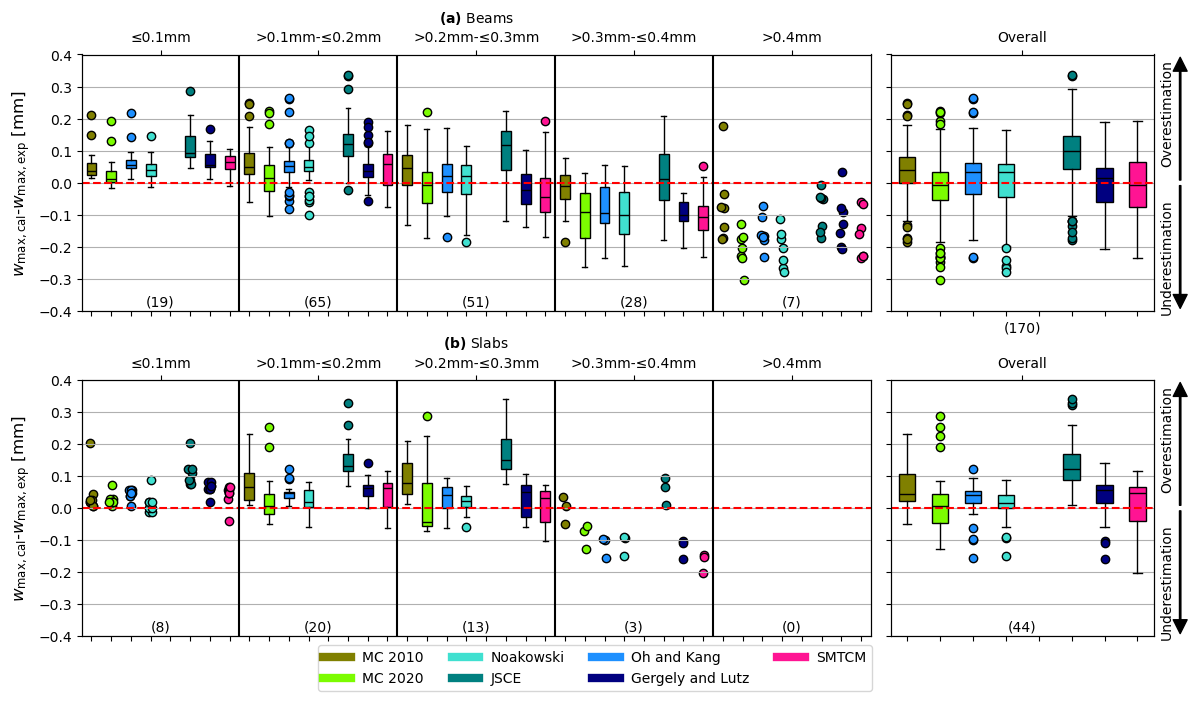

In [194]:

fig,ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw = {"width_ratios": [3,1]}, figsize=(round(1.3*9),6.7));
ax2_0 = ax[0,0].twiny();
ax2_2 = ax[1,0].twiny();

bounds = binchoice_w;
tempvar = "meas_wmax";


# Group - No Slabs
# ==============================================================================================================================
# Overall error - Group D
ax[0,1].set_ylim(-0.4,0.4);
ax[0,1].yaxis.set_ticklabels([]);

err_D = [];
Npoints_D = [];
err_D_art = []; col_D_art = [];


#df_D = func_apply_group_filter(df[df["h"] > 200],hardfilter_D,softfilter_D);
df_D = func_apply_group_filter(df[df["slab"] != 1],hardfilter_D,softfilter_D);
wm_D, wmax_D, sm_D, smax_D, colors_D = func_compute_filtered_output_multiple(df_D,list_D);

for i in range(len(list_D)):
    diff = wmax_D[i]["cwf_wmax"] - wmax_D[i]["meas_wmax"];
    
    err_D.append(diff); Npoints_D.append(len(diff)); 
    err_D_art.append(diff); err_D_art.append(diff);
    col_D_art.append(colors_D); col_D_art.append(colors_D);

bplot = ax[0,1].boxplot(err_D,patch_artist=True);
#viol = ax[2,1].violinplot(err_D);

for err,patch_box,patch_flier,patch_med,col in \
    zip(err_D,bplot["boxes"],bplot["fliers"],bplot["medians"],colors_D):
    if err.shape[0] < plotcutoff_overall:
        patch_box.set_visible(False);
        patch_med.set_visible(False)
        patch_flier.set_visible(False)
    else:
        patch_box.set_facecolor(col);
        patch_med.set_color("k");
        patch_flier.set_markerfacecolor(col);

for err_D_art,patch_whis,patch_cap,col in \
    zip(err_D_art,bplot["whiskers"],bplot["caps"],col_D_art):
        if err_D_art.shape[0] < plotcutoff_overall:
            patch_whis.set_visible(False)
            patch_cap.set_visible(False)
    
for i in range(len(list_D)):
    if err_D[i].shape[0] < plotcutoff_overall:
        ax[0,1].scatter(1 + i + np.random.uniform(-0.1,0.1,len(err_D[i])),err_D[i],zorder=10,c=colors_D[i],edgecolors="k");

ax[0,1].set_xticks(np.linspace(1,len(list_D),len(list_D)),[],rotation=60,ha="right");
ax[0,1].axhline(y=0,c="r",linestyle="--");

ax[0,1].text((len(list_D)+1)/2,-0.43,"("+str(len(err_D[-1]))+")",horizontalalignment="center",verticalalignment="top");

ax0_2_overall = ax[0,1].twiny();
ax0_2_overall.set_xticks([0.5]);
ax0_2_overall.set_xticklabels(["Overall"]);

x0 = 1.1
trans = mtransforms.blended_transform_factory(ax[0,1].transAxes, ax[0,1].transData)
y_tail = 0
y_head = 0.4
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax[0,1].add_patch(arrow1)
ax[0,1].text(1.05,0.05,"Overestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="bottom");
y_tail = 0
y_head = -0.4
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax[0,1].add_patch(arrow1)
ax[0,1].text(1.05,-0.05,"Underestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="top");
ax[0,1].grid(axis="y");

# Detailed
# --------------------------------------------------------
xlabel = [];
col = []; col_D_art = [];
err_detailed_D = []; err_detailed_D_art = [];

for i in range(0,len(bounds)+1):
    if i == 0:
        xlabel.append("≤"+str(bounds[0])+"mm");
    elif i == len(bounds):
        xlabel.append(">"+str(bounds[len(bounds)-1])+"mm");
    else:
        xlabel.append(">"+str(bounds[i-1])+"mm-≤"+str(bounds[i])+"mm");

    datastore = [];
    namestore = [];
    
    for j in range(len(list_D)):
        if i == 0:
            temp = wmax_D[j][(wmax_D[j][tempvar] <= bounds[0])];
        elif i == len(bounds):
            temp = wmax_D[j][(wmax_D[j][tempvar] > bounds[len(bounds)-1])];
        else:
            temp = wmax_D[j][((wmax_D[j][tempvar] > bounds[i-1]) & (wmax_D[j][tempvar] <= bounds[i]))];
    
        name = str("wmax"+"dataset"+str(i));
        datastore.append(temp);
        namestore.append(name);
    
        col.append(colors_D[j]);

        err_detailed_D.append(datastore[j]["cwf_wmax"] - datastore[j]["meas_wmax"]);
        err_detailed_D_art.append(datastore[j]["cwf_wmax"] - datastore[j]["meas_wmax"]);
        err_detailed_D_art.append(datastore[j]["cwf_wmax"] - datastore[j]["meas_wmax"]);

        col_D_art.append(colors_D[j]); col_D_art.append(colors_D[j]);

colcopy = col;

bplot = ax[0,0].boxplot(err_detailed_D,patch_artist=True);
#viol = ax[2,0].violinplot(err_detailed_D);

for err,patch_box,patch_flier,patch_med,col in zip(err_detailed_D,bplot["boxes"], bplot["fliers"],bplot["medians"], col):
    if err.shape[0] < plotcutoff_detail:
        patch_box.set_visible(False);
        patch_flier.set_visible(False);
        patch_med.set_visible(False);
    else:
        patch_box.set_facecolor(col);
        patch_med.set_color("k");
        patch_flier.set_markerfacecolor(col);

for err,patch_whis,patch_cap,col in zip(err_detailed_D_art,bplot["whiskers"],bplot["caps"], col_D_art):
    if err.shape[0] < plotcutoff_detail:
        patch_whis.set_visible(False);
        patch_cap.set_visible(False);

ax[0,0].set_title("$\\bf{(a)}$ Beams");
ax[0,0].axhline(y=0,c="r",linestyle="--");
ax[0,0].set_ylim(-0.4,0.4);
ax[0,0].set_ylabel("$w_{\\rm{max,cal}}$-$w_{\\rm{max,exp}}$ [mm]");
ax[0,0].grid(axis="y");

Ndatpoints = (len(bounds)+1)*(len(list_D));
ax[0,0].set_xticks(np.linspace(1,Ndatpoints,Ndatpoints),(len(bounds))*[]*len(list_D),rotation=60,ha="right");

loc_xtick = np.linspace(0.5/(len(bounds)+1),1-(0.5/(len(bounds)+1)),len(bounds)+1);
diff = loc_xtick[1] - loc_xtick[0];

ax2_0.set_xticks(loc_xtick);
ax2_0.set_xticklabels(xlabel);

loc_ax = np.linspace(0.5/(len(bounds)+1) + diff/2,1-(0.5/(len(bounds)+1)) - diff/2,len(bounds));
for xc in loc_ax:
    ax2_0.axvline(x=xc,color="k");

for i in range((len(bounds)+1)*(len(list_D))):
    if len(err_detailed_D[i]) < plotcutoff_detail:
        ax[0,0].scatter(1 + i + np.random.uniform(-0.1,0.1,len(err_detailed_D[i])),err_detailed_D[i],c=colcopy[i],edgecolors="k");

#for i in range((len(bounds)+1)*(len(list_D))):
#    ax[2,0].text(1 + diff/2 + diff*i*(len(bounds)+1),-0.45,len(err_detailed_D[i]),horizontalalignment="center",verticalalignment="top");

for i in range(len(loc_xtick)):
    ax[0,0].text(loc_xtick[i]*(len(bounds)+1)*(len(list_D)) + 0.5,-0.35,"("+str(len(err_detailed_D[(i+1)*(len(list_D))-1]))+")",\
                     horizontalalignment="center",verticalalignment="top");

# Group - Slabs
# ==============================================================================================================================
# Overall error - Group D
ax[1,1].set_ylim(-0.4,0.4);
ax[1,1].yaxis.set_ticklabels([]);

err_D = [];
Npoints_D = [];
err_D_art = []; col_D_art = [];

#df_D = func_apply_group_filter(df[df["h"] <= 200],hardfilter_D,softfilter_D);
df_D = func_apply_group_filter(df[df["slab"] == 1],hardfilter_D,softfilter_D);
wm_D, wmax_D, sm_D, smax_D, colors_D = func_compute_filtered_output_multiple(df_D,list_D);

for i in range(len(list_D)):
    diff = wmax_D[i]["cwf_wmax"] - wmax_D[i]["meas_wmax"];
    
    err_D.append(diff); Npoints_D.append(len(diff)); 
    err_D_art.append(diff); err_D_art.append(diff);
    col_D_art.append(colors_D); col_D_art.append(colors_D);

bplot = ax[1,1].boxplot(err_D,patch_artist=True);
#viol = ax[2,1].violinplot(err_D);

for err,patch_box,patch_flier,patch_med,col in \
    zip(err_D,bplot["boxes"],bplot["fliers"],bplot["medians"],colors_D):
    if err.shape[0] < plotcutoff_overall:
        patch_box.set_visible(False);
        patch_med.set_visible(False)
        patch_flier.set_visible(False)
    else:
        patch_box.set_facecolor(col);
        patch_med.set_color("k");
        patch_flier.set_markerfacecolor(col);

for err_D_art,patch_whis,patch_cap,col in \
    zip(err_D_art,bplot["whiskers"],bplot["caps"],col_D_art):
        if err_D_art.shape[0] < plotcutoff_overall:
            patch_whis.set_visible(False)
            patch_cap.set_visible(False)
    
for i in range(len(list_D)):
    if err_D[i].shape[0] < plotcutoff_overall:
        ax[1,1].scatter(1 + i + np.random.uniform(-0.1,0.1,len(err_D[i])),err_D[i],zorder=10,c=colors_D[i],edgecolors="k");

ax[1,1].set_xticks(np.linspace(1,len(list_D),len(list_D)),[],rotation=60,ha="right");
ax[1,1].axhline(y=0,c="r",linestyle="--");

ax[1,1].text((len(list_D)+1)/2,-0.35,"("+str(len(err_D[-1]))+")",horizontalalignment="center",verticalalignment="top");

ax2_2_overall = ax[1,1].twiny();
ax2_2_overall.set_xticks([0.5]);
ax2_2_overall.set_xticklabels(["Overall"]);

x0 = 1.1
trans = mtransforms.blended_transform_factory(ax[1,1].transAxes, ax[1,1].transData)
y_tail = 0
y_head = 0.4
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax[1,1].add_patch(arrow1)
ax[1,1].text(1.05,0.05,"Overestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="bottom");
y_tail = 0
y_head = -0.4
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax[1,1].add_patch(arrow1)
ax[1,1].text(1.05,-0.05,"Underestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="top");
ax[1,1].grid(axis="y");

# Detailed
# --------------------------------------------------------
xlabel = [];
col = []; col_D_art = [];
err_detailed_D = []; err_detailed_D_art = [];

for i in range(0,len(bounds)+1):
    if i == 0:
        xlabel.append("≤"+str(bounds[0])+"mm");
    elif i == len(bounds):
        xlabel.append(">"+str(bounds[len(bounds)-1])+"mm");
    else:
        xlabel.append(">"+str(bounds[i-1])+"mm-≤"+str(bounds[i])+"mm");

    datastore = [];
    namestore = [];
    
    for j in range(len(list_D)):
        if i == 0:
            temp = wmax_D[j][(wmax_D[j][tempvar] <= bounds[0])];
        elif i == len(bounds):
            temp = wmax_D[j][(wmax_D[j][tempvar] > bounds[len(bounds)-1])];
        else:
            temp = wmax_D[j][((wmax_D[j][tempvar] > bounds[i-1]) & (wmax_D[j][tempvar] <= bounds[i]))];
    
        name = str("wmax"+"dataset"+str(i));
        datastore.append(temp);
        namestore.append(name);
    
        col.append(colors_D[j]);

        err_detailed_D.append(datastore[j]["cwf_wmax"] - datastore[j]["meas_wmax"]);
        err_detailed_D_art.append(datastore[j]["cwf_wmax"] - datastore[j]["meas_wmax"]);
        err_detailed_D_art.append(datastore[j]["cwf_wmax"] - datastore[j]["meas_wmax"]);

        col_D_art.append(colors_D[j]); col_D_art.append(colors_D[j]);

colcopy = col;

bplot = ax[1,0].boxplot(err_detailed_D,patch_artist=True);
#viol = ax[2,0].violinplot(err_detailed_D);

for err,patch_box,patch_flier,patch_med,col in zip(err_detailed_D,bplot["boxes"], bplot["fliers"],bplot["medians"], col):
    if err.shape[0] < plotcutoff_detail:
        patch_box.set_visible(False);
        patch_flier.set_visible(False);
        patch_med.set_visible(False);
    else:
        patch_box.set_facecolor(col);
        patch_med.set_color("k");
        patch_flier.set_markerfacecolor(col);

for err,patch_whis,patch_cap,col in zip(err_detailed_D_art,bplot["whiskers"],bplot["caps"], col_D_art):
    if err.shape[0] < plotcutoff_detail:
        patch_whis.set_visible(False);
        patch_cap.set_visible(False);

ax[1,0].set_title("$\\bf{(b)}$ Slabs");
ax[1,0].axhline(y=0,c="r",linestyle="--");
ax[1,0].set_ylim(-0.4,0.4);
ax[1,0].set_ylabel("$w_{\\rm{max,cal}}$-$w_{\\rm{max,exp}}$ [mm]");
ax[1,0].grid(axis="y");

Ndatpoints = (len(bounds)+1)*(len(list_D));
ax[1,0].set_xticks(np.linspace(1,Ndatpoints,Ndatpoints),(len(bounds))*[]*len(list_D),rotation=60,ha="right");

loc_xtick = np.linspace(0.5/(len(bounds)+1),1-(0.5/(len(bounds)+1)),len(bounds)+1);
diff = loc_xtick[1] - loc_xtick[0];

ax2_2.set_xticks(loc_xtick);
ax2_2.set_xticklabels(xlabel);

loc_ax = np.linspace(0.5/(len(bounds)+1) + diff/2,1-(0.5/(len(bounds)+1)) - diff/2,len(bounds));
for xc in loc_ax:
    ax2_2.axvline(x=xc,color="k");

for i in range((len(bounds)+1)*(len(list_D))):
    if len(err_detailed_D[i]) < plotcutoff_detail:
        ax[1,0].scatter(1 + i + np.random.uniform(-0.1,0.1,len(err_detailed_D[i])),err_detailed_D[i],c=colcopy[i],edgecolors="k");

#for i in range((len(bounds)+1)*(len(list_D))):
#    ax[2,0].text(1 + diff/2 + diff*i*(len(bounds)+1),-0.45,len(err_detailed_D[i]),horizontalalignment="center",verticalalignment="top");

for i in range(len(loc_xtick)):
    ax[1,0].text(loc_xtick[i]*(len(bounds)+1)*(len(list_D)) + 0.5,-0.35,"("+str(len(err_detailed_D[(i+1)*(len(list_D))-1]))+")",\
                     horizontalalignment="center",verticalalignment="top");

fig.tight_layout();




# Create legend
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
legend_elements = [
                   Line2D([0], [0], color='olive', lw=6, label='MC 2010'),
                   Line2D([0], [0], color='lawngreen', lw=6, label='MC 2020'),
                   Line2D([0], [0], color='turquoise', lw=6, label='Noakowski'),
                   Line2D([0], [0], color='teal', lw=6, label='JSCE'),
                   Line2D([0], [0], color='dodgerblue', lw=6, label='Oh and Kang'),
                   Line2D([0], [0], color='navy', lw=6, label='Gergely and Lutz'),
                   #Line2D([0], [0], color='blueviolet', lw=6, label='Frosch'),
                   Line2D([0], [0], color='deeppink', lw=6, label='SMTCM')
                  ];
fig.legend(handles=legend_elements, loc="lower center",ncol=4,bbox_to_anchor=(0.5,-0.05));
#plt.savefig(Path(motherpath/r"1_st_Journal_Paper\Figures\Python\w_summarized.svg"));
plt.savefig(Path(motherpath/r"1_st_Journal_Paper\Figures\SVG\beams_versus_slabs.svg"),bbox_inches='tight');

### Figure paper - ratio wmax/wk

In [ ]:
ratio_wmax_wk = \
    pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\wk_wmax\Data_Ncrack_ratio.csv");

In [ ]:
plt.plot(ratio_wmax_wk["Ncrack"],ratio_wmax_wk["ratio"],"or",mfc="none");
plt.xlim([0,16]);
plt.ylim([0.4,1.2]);
plt.ylabel("$w_{\\rm{max}}$/$w_{\\rm{k}}$");

xtemp = np.linspace(2,14,15);
a,b = np.polyfit(ratio_wmax_wk["Ncrack"],ratio_wmax_wk["ratio"],1);

plt.axhline(y=1,xmin = 2/16, xmax = 14/16,linestyle="--",color="b",label="$w_{\\rm{max}}$/$w_{\\rm{k}}$ - Assumed");
plt.plot(xtemp,a*xtemp+b,c="r",linestyle="--",label="$w_{\\rm{max}}$/$w_{\\rm{k}}$ - Based on data");
plt.xlabel("Number of cracks");

plt.legend(loc="lower left");
plt.grid();
plt.title("$w_{\\rm{max}}$/$w_{\\rm{k}}$ versus number of cracks");

plt.savefig(Path(motherpath/r"1_st_Journal_Paper\Figures\SVG\wmax_versus_wk.svg"),bbox_inches='tight');

In [ ]:
#no_hor_shrink = \
#    pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Jupyter_Notebook\Data_exported\filt_2nd\uniform\Results_database_no_hordijk_initshrink.csv");

#no_hor_no_shrink = \
#    pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Jupyter_Notebook\Data_exported\filt_2nd\uniform\Results_database_no_hordijk_no_initshrink.csv");


shrink_w_001a = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Shrinkage\shrink_wmax_001a.csv");
shrink_w_001b = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Shrinkage\shrink_wmax_001b.csv");
shrink_w_002 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Shrinkage\shrink_wmax_002.csv");
shrink_w_006 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Shrinkage\shrink_wmax_006.csv");
shrink_w_007 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Shrinkage\shrink_wmax_007.csv");
shrink_w_012 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Shrinkage\shrink_wmax_012.csv");
shrink_w_038 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Shrinkage\shrink_wmax_038.csv");
shrink_w_047 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Shrinkage\shrink_wmax_047.csv");
shrink_w_053 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Shrinkage\shrink_wmax_053.csv");
shrink_w_095 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Shrinkage\shrink_wmax_095.csv");

no_shrink_w_001a = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Shrinkage\no_shrink_wmax_001a.csv");
no_shrink_w_001b = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Shrinkage\no_shrink_wmax_001b.csv");
no_shrink_w_002 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Shrinkage\no_shrink_wmax_002.csv");
no_shrink_w_006 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Shrinkage\no_shrink_wmax_006.csv");
no_shrink_w_007 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Shrinkage\no_shrink_wmax_007.csv");
no_shrink_w_012 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Shrinkage\no_shrink_wmax_012.csv");
no_shrink_w_038 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Shrinkage\no_shrink_wmax_038.csv");
no_shrink_w_047 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Shrinkage\no_shrink_wmax_047.csv");
no_shrink_w_053 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Shrinkage\no_shrink_wmax_053.csv");
no_shrink_w_095 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Shrinkage\no_shrink_wmax_095.csv");

### Figure paper - Effect of common targets

In [196]:
#no_common_targets = \
    #pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Jupyter_Notebook\Data_exported\filt_2nd\no_uniform\Results_database_no_hordijk_no_initshrink.csv");

#no_common_targets = \
#    pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Common_targ\Data_no_common_targ_group_B1.csv");


common_targets_w_001a = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Common_targ\common_wmax_001a.csv");
common_targets_w_001b = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Common_targ\common_wmax_001b.csv");
common_targets_w_002 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Common_targ\common_wmax_002.csv");
common_targets_w_006 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Common_targ\common_wmax_006.csv");
common_targets_w_007 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Common_targ\common_wmax_007.csv");
common_targets_w_012 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Common_targ\common_wmax_012.csv");
common_targets_w_019 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Common_targ\common_wmax_019.csv");

common_targets_wm_019 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Common_targ\common_wm_019.csv");

common_targets_w_038 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Common_targ\common_wmax_038.csv");
common_targets_w_047 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Common_targ\common_wmax_047.csv");
common_targets_w_053 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Common_targ\common_wmax_053.csv");
common_targets_w_095 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Common_targ\common_wmax_095.csv");


no_common_targets_w_001a = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Common_targ\no_common_wmax_001a.csv");
no_common_targets_w_001b = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Common_targ\no_common_wmax_001b.csv");
no_common_targets_w_002 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Common_targ\no_common_wmax_002.csv");
no_common_targets_w_006 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Common_targ\no_common_wmax_006.csv");
no_common_targets_w_007 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Common_targ\no_common_wmax_007.csv");
no_common_targets_w_012 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Common_targ\no_common_wmax_012.csv");
no_common_targets_w_019 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Common_targ\no_common_wmax_019.csv");

no_common_targets_wm_019 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Common_targ\no_common_wm_019.csv");

no_common_targets_w_038 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Common_targ\no_common_wmax_038.csv");
no_common_targets_w_047 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Common_targ\no_common_wmax_047.csv");
no_common_targets_w_053 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Common_targ\no_common_wmax_053.csv");
no_common_targets_w_095 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Common_targ\no_common_wmax_095.csv");


In [197]:

common_targets_s_001a = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Common_targ\common_smax_001a.csv");
common_targets_s_001b = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Common_targ\common_smax_001b.csv");
common_targets_s_002 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Common_targ\common_smax_002.csv");
common_targets_s_006 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Common_targ\common_smax_006.csv");
common_targets_s_007 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Common_targ\common_smax_007.csv");
common_targets_s_012 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Common_targ\common_smax_012.csv");
common_targets_s_019 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Common_targ\common_smax_019.csv");

common_targets_sm_019 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Common_targ\common_sm_019.csv");

common_targets_s_038 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Common_targ\common_smax_038.csv");
common_targets_s_047 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Common_targ\common_smax_047.csv");
common_targets_s_053 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Common_targ\common_smax_053.csv");
common_targets_s_095 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Common_targ\common_smax_095.csv");

no_common_targets_s_001a = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Common_targ\no_common_smax_001a.csv");
no_common_targets_s_001b = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Common_targ\no_common_smax_001b.csv");
no_common_targets_s_002 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Common_targ\no_common_smax_002.csv");
no_common_targets_s_006 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Common_targ\no_common_smax_006.csv");
no_common_targets_s_007 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Common_targ\no_common_smax_007.csv");
no_common_targets_s_012 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Common_targ\no_common_smax_012.csv");
no_common_targets_s_019 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Common_targ\no_common_smax_019.csv");

no_common_targets_sm_019 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Common_targ\no_common_sm_019.csv");

no_common_targets_s_038 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Common_targ\no_common_smax_038.csv");
no_common_targets_s_047 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Common_targ\no_common_smax_047.csv");
no_common_targets_s_053 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Common_targ\no_common_smax_053.csv");
no_common_targets_s_095 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Common_targ\no_common_smax_095.csv");


0      -0.103731
1      -0.106658
2      -0.026731
3       0.021342
4      -0.162807
          ...   
1499    0.095437
1500    0.088953
1501    0.076067
1502    0.066418
1503    0.060917
Length: 1504, dtype: float64


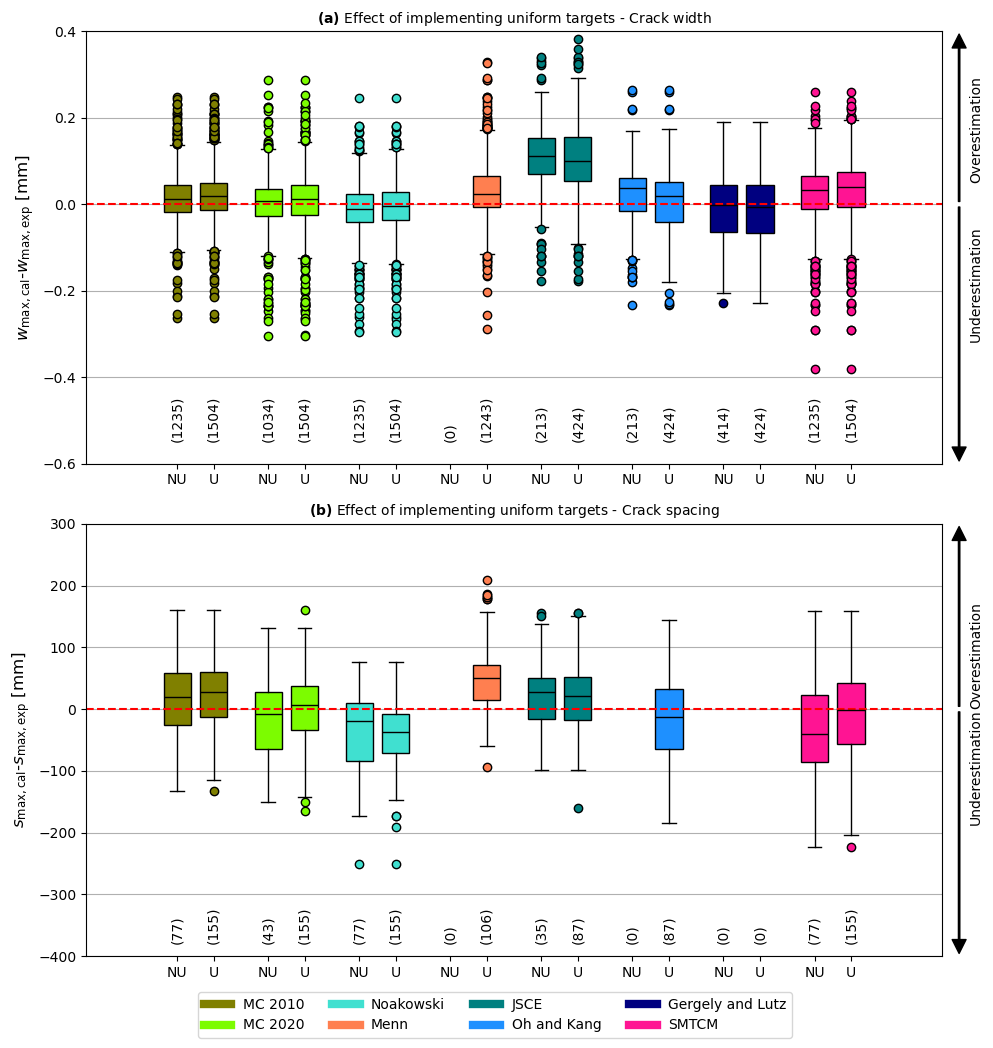

In [198]:
fig,ax = plt.subplots(nrows = 2,ncols = 1,figsize=(10,10));

#fig.suptitle("Effect of implementing uniform targets")

ax1 = ax[0];
ax2 = ax[1];
dx = 0.2
dxL = 0.5;

ax1.set_title("$\\bf{(a)}$ Effect of implementing uniform targets - Crack width");

"""
# wmax - 001a
# ==================================================================
diff_no_common = no_common_targets_w_001a["wmax_001a"]-no_common_targets_w_001a["meas_wmax"]
diff_no_common = diff_no_common[~np.isnan(diff_no_common)]

diff_common = common_targets_w_001a["wmax_001a"]-common_targets_w_001a["meas_wmax"]
diff_common = diff_common[~np.isnan(diff_common)]

bplot = ax1.boxplot([diff_no_common,diff_common],positions=[dxL,dxL+dx],patch_artist=True);
for err,patch_box,patch_med,patch_flier in zip([diff_no_common,diff_common],bplot["boxes"],bplot["medians"],bplot["fliers"]):
    patch_box.set_facecolor("salmon");
    patch_flier.set_markerfacecolor("salmon");
    patch_med.set_color("k")

#ax1.set_ylim(-0.5,0.8);
ax1.set_xticks(
        [dxL,dxL+dx],labels=["NU","U"]
)
templencommon = len(common_targets_w_007["wmax_007"]-common_targets_w_007["meas_wmax"]);
templennocommon = len(no_common_targets_w_007["wmax_007"]-no_common_targets_w_007["meas_wmax"]);
ax1.text(dxL,-0.55,"("+str(templennocommon)+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);
ax1.text(dxL+dx,-0.55,"("+str(templencommon)+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);

# wmax - 001b
# ==================================================================
diff_no_common = no_common_targets_w_001b["wmax_001b"]-no_common_targets_w_001b["meas_wmax"]
diff_no_common = diff_no_common[~np.isnan(diff_no_common)]

diff_common = common_targets_w_001b["wmax_001b"]-common_targets_w_001b["meas_wmax"]
diff_common = diff_common[~np.isnan(diff_common)]

bplot = ax1.boxplot([diff_no_common,diff_common],positions=[2*dxL,2*dxL+dx],patch_artist=True);
for err,patch_box,patch_med,patch_flier in zip([diff_no_common,diff_common],bplot["boxes"],bplot["medians"],bplot["fliers"]):
    patch_box.set_facecolor("sienna");
    patch_flier.set_markerfacecolor("sienna");
    patch_med.set_color("k")

#ax1.set_ylim(-0.5,0.8);
ax1.set_xticks(
        [2*dxL,2*dxL+dx],labels=["NU","U"]
)
ax1.text(2*dxL,-0.55,"("+str(templennocommon)+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);
ax1.text(2*dxL+dx,-0.55,"("+str(templencommon)+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);

# wmax - 002
# ==================================================================
diff_no_common = no_common_targets_w_002["wmax_002"]-no_common_targets_w_002["meas_wmax"]
diff_no_common = diff_no_common[~np.isnan(diff_no_common)]

diff_common = common_targets_w_002["wmax_002"]-common_targets_w_002["meas_wmax"]
diff_common = diff_common[~np.isnan(diff_common)]

bplot = ax1.boxplot([diff_no_common,diff_common],positions=[3*dxL,3*dxL+dx],patch_artist=True);
for err,patch_box,patch_med,patch_flier in zip([diff_no_common,diff_common],bplot["boxes"],bplot["medians"],bplot["fliers"]):
    patch_box.set_facecolor("sandybrown");
    patch_flier.set_markerfacecolor("sandybrown");
    patch_med.set_color("k")

#ax1.set_ylim(-0.5,0.8);
ax1.set_xticks(
        [3*dxL,3*dxL+dx],labels=["NU","U"]
)
ax1.text(3*dxL,-0.55,"("+str(len(diff_no_common))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);
ax1.text(3*dxL+dx,-0.55,"("+str(len(diff_common))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);
"""

# wmax - 006
# ==================================================================
diff_no_common = no_common_targets_w_006["wmax_006"]-no_common_targets_w_006["meas_wmax"]
diff_no_common = diff_no_common[~np.isnan(diff_no_common)]

diff_common = common_targets_w_006["wmax_006"]-common_targets_w_006["meas_wmax"]
diff_common = diff_common[~np.isnan(diff_common)]

bplot = ax1.boxplot([diff_no_common,diff_common],positions=[4*dxL,4*dxL+dx],patch_artist=True);
for err,patch_box,patch_med,patch_flier in zip([diff_no_common,diff_common],bplot["boxes"],bplot["medians"],bplot["fliers"]):
    patch_box.set_facecolor("olive");
    patch_flier.set_markerfacecolor("olive");
    patch_med.set_color("k")

#ax1.set_ylim(-0.5,0.8);
ax1.set_xticks(
        [4*dxL,4*dxL+dx],labels=["NU","U"]
)
ax1.text(4*dxL,-0.55,"("+str(len(diff_no_common))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);
ax1.text(4*dxL+dx,-0.55,"("+str(len(diff_common))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);

# wmax - 007
# ==================================================================
diff_no_common = no_common_targets_w_007["wmax_007"]-no_common_targets_w_007["meas_wmax"]
diff_no_common = diff_no_common[~np.isnan(diff_no_common)]

diff_common = common_targets_w_007["wmax_007"]-common_targets_w_007["meas_wmax"]
diff_common = diff_common[~np.isnan(diff_common)]

bplot = ax1.boxplot([diff_no_common,diff_common],positions=[5*dxL,5*dxL+dx],patch_artist=True);
for err,patch_box,patch_med,patch_flier in zip([diff_no_common,diff_common],bplot["boxes"],bplot["medians"],bplot["fliers"]):
    patch_box.set_facecolor("lawngreen");
    patch_flier.set_markerfacecolor("lawngreen");
    patch_med.set_color("k")

#ax1.set_ylim(-0.5,0.8);
ax1.set_xticks(
        [5*dxL,5*dxL+dx],labels=["NU","U"]
)
ax1.text(5*dxL,-0.55,"("+str(len(diff_no_common))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);
ax1.text(5*dxL+dx,-0.55,"("+str(len(diff_common))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);

# wmax - 012
# ==================================================================
diff_no_common = no_common_targets_w_012["wmax_012"]-no_common_targets_w_012["meas_wmax"]
diff_no_common = diff_no_common[~np.isnan(diff_no_common)]

diff_common = common_targets_w_012["wmax_012"]-common_targets_w_012["meas_wmax"]
diff_common = diff_common[~np.isnan(diff_common)]

bplot = ax1.boxplot([diff_no_common,diff_common],positions=[6*dxL,6*dxL+dx],patch_artist=True);
for err,patch_box,patch_med,patch_flier in zip([diff_no_common,diff_common],bplot["boxes"],bplot["medians"],bplot["fliers"]):
    patch_box.set_facecolor("turquoise");
    patch_flier.set_markerfacecolor("turquoise");
    patch_med.set_color("k")

#ax1.set_ylim(-0.5,0.8);
ax1.set_xticks(
        [6*dxL,6*dxL+dx],labels=["NU","U"]
)

"""
templencommon = len(common_targets_w_095["wmax_095"]-common_targets_w_095["meas_wmax"]);
templennocommon = len(no_common_targets_w_095["wmax_095"]-no_common_targets_w_095["meas_wmax"]);
ax1.text(6*dxL,-0.55,"("+str(templennocommon)+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);
ax1.text(6*dxL+dx,-0.55,"("+str(templencommon)+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);
"""

ax1.text(6*dxL,-0.55,"("+str(len(diff_no_common))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);
ax1.text(6*dxL+dx,-0.55,"("+str(len(diff_common))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);


# wmax - 019
# ==================================================================
diff_no_common = no_common_targets_w_019["wmax_019"]-no_common_targets_w_019["meas_wmax"]
#diff_no_common = diff_no_common[~np.isnan(diff_no_common)]

diff_common = common_targets_w_019["wmax_019"]-common_targets_w_019["meas_wmax"]
diff_common = diff_common[~np.isnan(diff_common)]

bplot = ax1.boxplot([diff_no_common,diff_common],positions=[7*dxL,7*dxL+dx],patch_artist=True);
for err,patch_box,patch_med,patch_flier in zip([diff_no_common,diff_common],bplot["boxes"],bplot["medians"],bplot["fliers"]):
    patch_box.set_facecolor("coral");
    patch_flier.set_markerfacecolor("coral");
    patch_med.set_color("k")

#ax1.set_ylim(-0.5,0.8);
ax1.set_xticks(
        [7*dxL,7*dxL+dx],labels=["NU","U"]
)

ax1.text(7*dxL,-0.55,"("+str(len(diff_no_common))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);
ax1.text(7*dxL+dx,-0.55,"("+str(len(diff_common))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);



# wmax - 038
# ==================================================================
diff_no_common = no_common_targets_w_038["wmax_038"]-no_common_targets_w_038["meas_wmax"]
diff_no_common = diff_no_common[~np.isnan(diff_no_common)]

diff_common = common_targets_w_038["wmax_038"]-common_targets_w_038["meas_wmax"]
diff_common = diff_common[~np.isnan(diff_common)]

bplot = ax1.boxplot([diff_no_common,diff_common],positions=[8*dxL,8*dxL+dx],patch_artist=True);
for err,patch_box,patch_med,patch_flier in zip([diff_no_common,diff_common],bplot["boxes"],bplot["medians"],bplot["fliers"]):
    patch_box.set_facecolor("teal");
    patch_flier.set_markerfacecolor("teal");
    patch_med.set_color("k")

#ax1.set_ylim(-0.5,0.8);
ax1.set_xticks(
        [8*dxL,8*dxL+dx],labels=["NU","U"]
)
ax1.text(8*dxL,-0.55,"("+str(len(diff_no_common))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);
ax1.text(8*dxL+dx,-0.55,"("+str(len(diff_common))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);

# wmax - 047
# ==================================================================
diff_no_common = no_common_targets_w_047["wmax_047"]-no_common_targets_w_047["meas_wmax"]
diff_no_common = diff_no_common[~np.isnan(diff_no_common)]

diff_common = common_targets_w_047["wmax_047"]-common_targets_w_047["meas_wmax"]
diff_common = diff_common[~np.isnan(diff_common)]

bplot = ax1.boxplot([diff_no_common,diff_common],positions=[9*dxL,9*dxL+dx],patch_artist=True);
for err,patch_box,patch_med,patch_flier in zip([diff_no_common,diff_common],bplot["boxes"],bplot["medians"],bplot["fliers"]):
    patch_box.set_facecolor("dodgerblue");
    patch_flier.set_markerfacecolor("dodgerblue");
    patch_med.set_color("k")

#ax1.set_ylim(-0.5,0.8);
ax1.set_xticks(
        [9*dxL,9*dxL+dx],labels=["NU","U"]
)
ax1.text(9*dxL,-0.55,"("+str(len(diff_no_common))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);
ax1.text(9*dxL+dx,-0.55,"("+str(len(diff_common))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);

# wmax - 053
# ==================================================================
diff_no_common = no_common_targets_w_053["wmax_053"]-no_common_targets_w_053["meas_wmax"]
diff_no_common = diff_no_common[~np.isnan(diff_no_common)]

diff_common = common_targets_w_053["wmax_053"]-common_targets_w_053["meas_wmax"]
diff_common = diff_common[~np.isnan(diff_common)]

bplot = ax1.boxplot([diff_no_common,diff_common],positions=[10*dxL,10*dxL+dx],patch_artist=True);
for err,patch_box,patch_med,patch_flier in zip([diff_no_common,diff_common],bplot["boxes"],bplot["medians"],bplot["fliers"]):
    patch_box.set_facecolor("navy");
    patch_flier.set_markerfacecolor("navy");
    patch_med.set_color("k")

#ax1.set_ylim(-0.5,0.8);
ax1.set_xticks(
        [10*dxL,10*dxL+dx],labels=["NU","U"]
)
ax1.text(10*dxL,-0.55,"("+str(len(diff_no_common))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);
ax1.text(10*dxL+dx,-0.55,"("+str(len(diff_common))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);

# wmax - 095
# ==================================================================
diff_no_common = no_common_targets_w_095["wmax_095"]-no_common_targets_w_095["meas_wmax"]
diff_no_common = diff_no_common[~np.isnan(diff_no_common)]

diff_common = common_targets_w_095["wmax_095"]-common_targets_w_095["meas_wmax"]
diff_common = diff_common[~np.isnan(diff_common)]

bplot = ax1.boxplot([diff_no_common,diff_common],positions=[11*dxL,11*dxL+dx],patch_artist=True);
for err,patch_box,patch_med,patch_flier in zip([diff_no_common,diff_common],bplot["boxes"],bplot["medians"],bplot["fliers"]):
    patch_box.set_facecolor("deeppink");
    patch_flier.set_markerfacecolor("deeppink");
    patch_med.set_color("k")

ax1.set_ylim(-0.6,0.4);
ax1.set_xticks(
        [11*dxL,11*dxL+dx],labels=["NU","U"]
)
ax1.text(11*dxL,-0.55,"("+str(len(diff_no_common))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);
ax1.text(11*dxL+dx,-0.55,"("+str(len(diff_common))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);

print(diff_common)

ax1.set_ylabel("$w_{\\rm{max,cal}}$-$w_{\\rm{max,exp}}$ [mm]");
ax1.axhline(y=0,c="r",linestyle="--");

"""
ax1.set_xticks(
 [dxL,dxL+dx,2*dxL,2*dxL+dx,3*dxL,3*dxL+dx,4*dxL,4*dxL+dx,5*dxL,5*dxL+dx,6*dxL,6*dxL+dx,7*dxL,7*dxL+dx,8*dxL,8*dxL+dx,9*dxL,9*dxL+dx,10*dxL,10*dxL+dx],
    labels=["NU","U","NU","U","NU","U","NU","U","NU","U","NU","U","NU","U","NU","U","NU","U","NU","U"]
)
"""
ax1.set_xticks(
 [4*dxL,4*dxL+dx,5*dxL,5*dxL+dx,6*dxL,6*dxL+dx,7*dxL,7*dxL+dx,8*dxL,8*dxL+dx,9*dxL,9*dxL+dx,10*dxL,10*dxL+dx,11*dxL,11*dxL+dx],
    labels=["NU","U","NU","U","NU","U","NU","U","NU","U","NU","U","NU","U","NU","U"]
)


x0 = 1.02
trans = mtransforms.blended_transform_factory(ax1.transAxes, ax1.transData)
y_tail = 0
y_head = 0.4
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax1.add_patch(arrow1)
ax1.text(1.04,0.05,"Overestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="bottom");
y_tail = 0
y_head = -0.6
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax1.add_patch(arrow1)
ax1.text(1.04,-0.05,"Underestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="top");
ax1.grid(axis="y");

# =================================================================================================

ax2.set_title("$\\bf{(b)}$ Effect of implementing uniform targets - Crack spacing");

"""
# wmax - 001a
# ==================================================================
diff_no_common = no_common_targets_s_001a["smax_001a"]-no_common_targets_s_001a["meas_smax"]
diff_no_common = diff_no_common[~np.isnan(diff_no_common)]

diff_common = common_targets_s_001a["smax_001a"]-common_targets_s_001a["meas_smax"]
diff_common = diff_common[~np.isnan(diff_common)]

bplot = ax2.boxplot([diff_no_common,diff_common],positions=[dxL,dxL+dx],patch_artist=True);
for err,patch_box,patch_med,patch_flier in zip([diff_no_common,diff_common],bplot["boxes"],bplot["medians"],bplot["fliers"]):
    patch_box.set_facecolor("salmon");
    patch_flier.set_markerfacecolor("salmon");
    patch_med.set_color("k")

ax2.text(dxL,-380,"("+str(len(diff_no_common))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);
ax2.text(dxL+dx,-380,"("+str(len(diff_common))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);

# wmax - 001b
# ==================================================================
diff_no_common = no_common_targets_s_001b["smax_001b"]-no_common_targets_s_001b["meas_smax"]
diff_no_common = diff_no_common[~np.isnan(diff_no_common)]

diff_common = common_targets_s_001b["smax_001b"]-common_targets_s_001b["meas_smax"]
diff_common = diff_common[~np.isnan(diff_common)]

bplot = ax2.boxplot([diff_no_common,diff_common],positions=[2*dxL,2*dxL+dx],patch_artist=True);
for err,patch_box,patch_med,patch_flier in zip([diff_no_common,diff_common],bplot["boxes"],bplot["medians"],bplot["fliers"]):
    patch_box.set_facecolor("sienna");
    patch_flier.set_markerfacecolor("sienna");
    patch_med.set_color("k")

ax2.text(2*dxL,-380,"("+str(len(diff_no_common))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);
ax2.text(2*dxL+dx,-380,"("+str(len(diff_common))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);

# wmax - 002
# ==================================================================
diff_no_common = no_common_targets_s_002["smax_002"]-no_common_targets_s_002["meas_smax"]
#diff_no_common = diff_no_common[~np.isnan(diff_no_common)]

diff_common = common_targets_s_002["smax_002"]-common_targets_s_002["meas_smax"]
diff_common = diff_common[~np.isnan(diff_common)]

bplot = ax2.boxplot([diff_no_common,diff_common],positions=[3*dxL,3*dxL+dx],patch_artist=True);
for err,patch_box,patch_med,patch_flier in zip([diff_no_common,diff_common],bplot["boxes"],bplot["medians"],bplot["fliers"]):
    patch_box.set_facecolor("sandybrown");
    patch_flier.set_markerfacecolor("sandybrown");
    patch_med.set_color("k")

ax2.text(3*dxL,-380,"("+str(len(diff_no_common))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);
ax2.text(3*dxL+dx,-380,"("+str(len(diff_common))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);
"""

# wmax - 006
# ==================================================================
diff_no_common = no_common_targets_s_006["smax_006"]-no_common_targets_s_006["meas_smax"]
diff_no_common = diff_no_common[~np.isnan(diff_no_common)]

diff_common = common_targets_s_006["smax_006"]-common_targets_s_006["meas_smax"]
diff_common = diff_common[~np.isnan(diff_common)]

bplot = ax2.boxplot([diff_no_common,diff_common],positions=[4*dxL,4*dxL+dx],patch_artist=True);
for err,patch_box,patch_med,patch_flier in zip([diff_no_common,diff_common],bplot["boxes"],bplot["medians"],bplot["fliers"]):
    patch_box.set_facecolor("olive");
    patch_flier.set_markerfacecolor("olive");
    patch_med.set_color("k")

ax2.text(4*dxL,-380,"("+str(len(diff_no_common))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);
ax2.text(4*dxL+dx,-380,"("+str(len(diff_common))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);

# wmax - 007
# ==================================================================
diff_no_common = no_common_targets_s_007["smax_007"]-no_common_targets_s_007["meas_smax"]
diff_no_common = diff_no_common[~np.isnan(diff_no_common)]

diff_common = common_targets_s_007["smax_007"]-common_targets_s_007["meas_smax"]
diff_common = diff_common[~np.isnan(diff_common)]

bplot = ax2.boxplot([diff_no_common,diff_common],positions=[5*dxL,5*dxL+dx],patch_artist=True);
for err,patch_box,patch_med,patch_flier in zip([diff_no_common,diff_common],bplot["boxes"],bplot["medians"],bplot["fliers"]):
    patch_box.set_facecolor("lawngreen");
    patch_flier.set_markerfacecolor("lawngreen");
    patch_med.set_color("k")

ax2.text(5*dxL,-380,"("+str(len(diff_no_common))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);
ax2.text(5*dxL+dx,-380,"("+str(len(diff_common))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);

# wmax - 012
# ==================================================================
diff_no_common = no_common_targets_s_012["smax_012"]-no_common_targets_s_012["meas_smax"]
#diff_no_common = diff_no_common[~np.isnan(diff_no_common)]

diff_common = common_targets_s_012["smax_012"]-common_targets_s_012["meas_smax"]
diff_common = diff_common[~np.isnan(diff_common)]

bplot = ax2.boxplot([diff_no_common,diff_common],positions=[6*dxL,6*dxL+dx],patch_artist=True);
for err,patch_box,patch_med,patch_flier in zip([diff_no_common,diff_common],bplot["boxes"],bplot["medians"],bplot["fliers"]):
    patch_box.set_facecolor("turquoise");
    patch_flier.set_markerfacecolor("turquoise");
    patch_med.set_color("k")

"""
templencommon = len(common_targets_s_095["smax_095"]-common_targets_s_095["meas_smax"]);
templennocommon = len(diff_no_common);
ax2.text(6*dxL,-380,"("+str(templennocommon)+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);
ax2.text(6*dxL+dx,-380,"("+str(templencommon)+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);
"""

ax2.text(6*dxL,-380,"("+str(len(diff_no_common))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);
ax2.text(6*dxL+dx,-380,"("+str(len(diff_common))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);

# wmax - 019
# ==================================================================
diff_no_common = no_common_targets_s_019["smax_019"]-no_common_targets_s_019["meas_smax"]
#diff_no_common = diff_no_common[~np.isnan(diff_no_common)]

diff_common = common_targets_s_019["smax_019"]-common_targets_s_019["meas_smax"]
#diff_common = diff_common[~np.isnan(diff_common)]

bplot = ax2.boxplot([diff_no_common,diff_common],positions=[7*dxL,7*dxL+dx],patch_artist=True);
for err,patch_box,patch_med,patch_flier in zip([diff_no_common,diff_common],bplot["boxes"],bplot["medians"],bplot["fliers"]):
    patch_box.set_facecolor("coral");
    patch_flier.set_markerfacecolor("coral");
    patch_med.set_color("k")

"""
templencommon = len(common_targets_s_095["smax_095"]-common_targets_s_095["meas_smax"]);
templennocommon = len(diff_no_common);
ax2.text(6*dxL,-380,"("+str(templennocommon)+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);
ax2.text(6*dxL+dx,-380,"("+str(templencommon)+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);
"""

ax2.text(7*dxL,-380,"("+str(len(diff_no_common))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);
ax2.text(7*dxL+dx,-380,"("+str(len(diff_common))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);




# wmax - 038
# ==================================================================
diff_no_common = no_common_targets_s_038["smax_038"]-no_common_targets_s_038["meas_smax"]
diff_no_common = diff_no_common[~np.isnan(diff_no_common)]

diff_common = common_targets_s_038["smax_038"]-common_targets_s_038["meas_smax"]
diff_common = diff_common[~np.isnan(diff_common)]

bplot = ax2.boxplot([diff_no_common,diff_common],positions=[8*dxL,8*dxL+dx],patch_artist=True);
for err,patch_box,patch_med,patch_flier in zip([diff_no_common,diff_common],bplot["boxes"],bplot["medians"],bplot["fliers"]):
    patch_box.set_facecolor("teal");
    patch_flier.set_markerfacecolor("teal");
    patch_med.set_color("k")

ax2.text(8*dxL,-380,"("+str(len(diff_no_common))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);
ax2.text(8*dxL+dx,-380,"("+str(len(diff_common))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);

# wmax - 047
# ==================================================================
diff_no_common = no_common_targets_s_047["smax_047"]-no_common_targets_s_047["meas_smax"]
#diff_no_common = diff_no_common[~np.isnan(diff_no_common)]

diff_common = common_targets_s_047["smax_047"]-common_targets_s_047["meas_smax"]
diff_common = diff_common[~np.isnan(diff_common)]

bplot = ax2.boxplot([diff_no_common,diff_common],positions=[9*dxL,9*dxL+dx],patch_artist=True);
for err,patch_box,patch_med,patch_flier in zip([diff_no_common,diff_common],bplot["boxes"],bplot["medians"],bplot["fliers"]):
    patch_box.set_facecolor("dodgerblue");
    patch_flier.set_markerfacecolor("dodgerblue");
    patch_med.set_color("k")

ax2.text(9*dxL,-380,"("+str(len(diff_no_common))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);
ax2.text(9*dxL+dx,-380,"("+str(len(diff_common))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);

# wmax - 053
# ==================================================================
diff_no_common = no_common_targets_s_053["smax_053"]-no_common_targets_s_053["meas_smax"]
#diff_no_common = diff_no_common[~np.isnan(diff_no_common)]

diff_common = common_targets_s_053["smax_053"]-common_targets_s_053["meas_smax"]
#diff_common = diff_common[~np.isnan(diff_common)]

bplot = ax2.boxplot([diff_no_common,diff_common],positions=[10*dxL,10*dxL+dx],patch_artist=True);
for err,patch_box,patch_med,patch_flier in zip([diff_no_common,diff_common],bplot["boxes"],bplot["medians"],bplot["fliers"]):
    patch_box.set_facecolor("navy");
    patch_flier.set_markerfacecolor("navy");
    patch_med.set_color("k")

ax2.text(10*dxL,-380,"("+str(len(diff_no_common))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);
ax2.text(10*dxL+dx,-380,"("+str(len(diff_common))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);

# wmax - 095
# ==================================================================
diff_no_common = no_common_targets_s_095["smax_095"]-no_common_targets_s_095["meas_smax"]
diff_no_common = diff_no_common[~np.isnan(diff_no_common)]

diff_common = common_targets_s_095["smax_095"]-common_targets_s_095["meas_smax"]
diff_common = diff_common[~np.isnan(diff_common)]

bplot = ax2.boxplot([diff_no_common,diff_common],positions=[11*dxL,11*dxL+dx],patch_artist=True);
for err,patch_box,patch_med,patch_flier in zip([diff_no_common,diff_common],bplot["boxes"],bplot["medians"],bplot["fliers"]):
    patch_box.set_facecolor("deeppink");
    patch_flier.set_markerfacecolor("deeppink");
    patch_med.set_color("k")

ax2.text(11*dxL,-380,"("+str(len(diff_no_common))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);
ax2.text(11*dxL+dx,-380,"("+str(len(diff_common))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);

ax2.set_ylabel("$s_{\\rm{max,cal}}$-$s_{\\rm{max,exp}}$ [mm]");
ax2.axhline(y=0,c="r",linestyle="--");

"""
ax2.set_xticks(
 [dxL,dxL+dx,2*dxL,2*dxL+dx,3*dxL,3*dxL+dx,4*dxL,4*dxL+dx,5*dxL,5*dxL+dx,6*dxL,6*dxL+dx,7*dxL,7*dxL+dx,8*dxL,8*dxL+dx,9*dxL,9*dxL+dx,10*dxL,10*dxL+dx],
    labels=["NU","U","NU","U","NU","U","NU","U","NU","U","NU","U","NU","U","NU","U","NU","U","NU","U"]
);
"""

ax2.set_xticks(
 [4*dxL,4*dxL+dx,5*dxL,5*dxL+dx,6*dxL,6*dxL+dx,7*dxL,7*dxL+dx,8*dxL,8*dxL+dx,9*dxL,9*dxL+dx,10*dxL,10*dxL+dx,11*dxL,11*dxL+dx],
    labels=["NU","U","NU","U","NU","U","NU","U","NU","U","NU","U","NU","U","NU","U"]
);

ax2.set_ylim(-400,300);

x0 = 1.02
trans = mtransforms.blended_transform_factory(ax2.transAxes, ax2.transData)
y_tail = 0
y_head = 300
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax2.add_patch(arrow1)
ax2.text(1.04,0.05,"Overestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="bottom");
y_tail = 0
y_head = -400
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax2.add_patch(arrow1)
ax2.text(1.04,-0.05,"Underestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="top");
ax2.grid(axis="y");



#==================================================================================================

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
legend_elements = [
                   Line2D([0], [0], color='olive', lw=6, label='MC 2010'),
                   Line2D([0], [0], color='lawngreen', lw=6, label='MC 2020'),
                   Line2D([0], [0], color='turquoise', lw=6, label='Noakowski'),
                   Line2D([0], [0], color='coral', lw=6, label='Menn'),
                   Line2D([0], [0], color='teal', lw=6, label='JSCE'),
                   Line2D([0], [0], color='dodgerblue', lw=6, label='Oh and Kang'),
                   Line2D([0], [0], color='navy', lw=6, label='Gergely and Lutz'),
                   #Line2D([0], [0], color='blueviolet', lw=6, label='Frosch'),
                   Line2D([0], [0], color='deeppink', lw=6, label='SMTCM')
                  ];
fig.legend(handles=legend_elements, loc="lower center",ncol=4,bbox_to_anchor=(0.5,-0.05));

fig.tight_layout();
#ax1.text(-0.5,-0.65,"(a)")
#ax2.text(-0.5,-550,"(b)")

plt.savefig(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Figures\SVG\no_uniform.svg",bbox_inches='tight')


### Figure paper - Performance of formula Menn

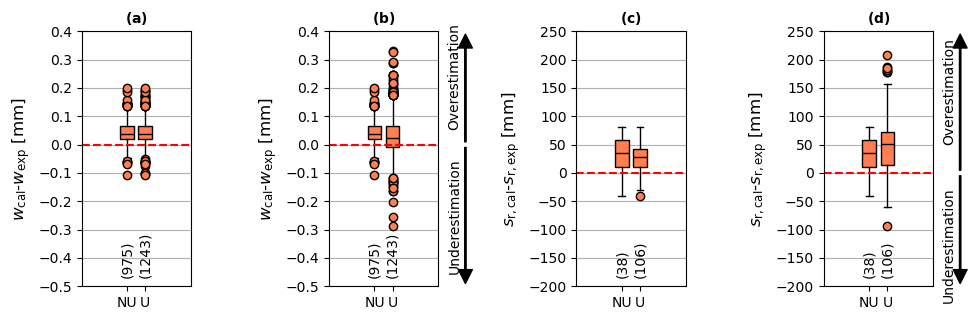

In [203]:
#fig,ax = plt.subplots(nrows = 1,ncols = 4,figsize=(10,3.3));

fig,ax = plt.subplots(nrows = 1,ncols = 4,figsize=(10,3.3),gridspec_kw = {"width_ratios": [1,1,1,1]});

ax1 = ax[0];
ax2 = ax[1];
ax3 = ax[2];
ax4 = ax[3];


# Conversion only from wmax to wm in the data side
# ====================================================================================

diff_no_common_wm = no_common_targets_wm_019["wm_019"] - no_common_targets_wm_019["meas_wm"];
diff_common_wm = common_targets_wm_019["wm_019"] - common_targets_wm_019["meas_wm"];

bplot = ax1.boxplot([diff_no_common_wm,diff_common_wm],positions=[1,1.2],patch_artist=True);
for err,patch_box,patch_med,patch_flier in zip([diff_no_common_wm,diff_common_wm],bplot["boxes"],bplot["medians"],bplot["fliers"]):
    patch_box.set_facecolor("coral");
    patch_flier.set_markerfacecolor("coral");
    patch_med.set_color("k")

ax1.text(1,-0.47,"("+str(len(diff_no_common_wm))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);
ax1.text(1.2,-0.47,"("+str(len(diff_common_wm))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);

ax1.set_ylim(-0.5,0.4);
ax1.grid(axis="y");

ax1.set_xticks(
 [1,1.2],
    labels=["NU","U"]);

ax1.set_title("$\\bf{(a)}$");
ax1.axhline(y=0,c="r",linestyle="--");
ax1.set_ylabel("$w_{\\rm{cal}}$-$w_{\\rm{exp}}$ [mm]");

# And now step from no conversion at all towards conversion
# ====================================================================================

diff_no_common_wm = no_common_targets_wm_019["wm_019"] - no_common_targets_wm_019["meas_wm"];
diff_common_wmax = common_targets_w_019["wmax_019"] - common_targets_w_019["meas_wmax"];

bplot = ax2.boxplot([diff_no_common_wm,diff_common_wmax],positions=[1,1.2],patch_artist=True);
for err,patch_box,patch_med,patch_flier in zip([diff_no_common_wm,diff_common_wmax],bplot["boxes"],bplot["medians"],bplot["fliers"]):
    patch_box.set_facecolor("coral");
    patch_flier.set_markerfacecolor("coral");
    patch_med.set_color("k")

ax2.text(1,-0.47,"("+str(len(diff_no_common_wm))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);
ax2.text(1.2,-0.47,"("+str(len(diff_common_wmax))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);

ax2.set_ylim(-0.5,0.4);
ax2.grid(axis="y");

ax2.set_xticks(
 [1,1.2],
    labels=["NU","U"]);

ax2.set_title("$\\bf{(b)}$");
ax2.axhline(y=0,c="r",linestyle="--");
ax2.set_ylabel("$w_{\\rm{cal}}$-$w_{\\rm{exp}}$ [mm]");

x0 = 1.25
trans = mtransforms.blended_transform_factory(ax2.transAxes, ax2.transData)
y_tail = 0
y_head = 0.4
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax2.add_patch(arrow1)
ax2.text(1.15,0.05,"Overestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="bottom");
y_tail = 0
y_head = -0.5
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax2.add_patch(arrow1)
ax2.text(1.15,-0.05,"Underestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="top");

# Conversion only from smax to sm in the data side
# ====================================================================================

diff_no_common_sm = no_common_targets_sm_019["sm_019"] - no_common_targets_sm_019["meas_sm"];
diff_common_sm = common_targets_sm_019["sm_019"] - common_targets_sm_019["meas_sm"];

bplot = ax3.boxplot([diff_no_common_sm,diff_common_sm],positions=[1,1.2],patch_artist=True);
for err,patch_box,patch_med,patch_flier in zip([diff_no_common_sm,diff_common_sm],bplot["boxes"],bplot["medians"],bplot["fliers"]):
    patch_box.set_facecolor("coral");
    patch_flier.set_markerfacecolor("coral");
    patch_med.set_color("k")

ax3.text(1,-185,"("+str(len(diff_no_common_sm))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);
ax3.text(1.2,-185,"("+str(len(diff_common_sm))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);

ax3.set_ylim(-200,250);
ax3.grid(axis="y");

ax3.set_xticks(
 [1,1.2],
    labels=["NU","U"]);

ax3.set_title("$\\bf{(c)}$");
ax3.axhline(y=0,c="r",linestyle="--");

ax3.set_ylabel("$s_{\\rm{r,cal}}$-$s_{\\rm{r,exp}}$ [mm]");

# And now step from no conversion at all towards conversion
# ====================================================================================

diff_no_common_sm = no_common_targets_sm_019["sm_019"] - no_common_targets_sm_019["meas_sm"];
diff_common_smax = common_targets_s_019["smax_019"] - common_targets_s_019["meas_smax"];

bplot = ax4.boxplot([diff_no_common_sm,diff_common_smax],positions=[1,1.2],patch_artist=True);
for err,patch_box,patch_med,patch_flier in zip([diff_no_common_sm,diff_common_smax],bplot["boxes"],bplot["medians"],bplot["fliers"]):
    patch_box.set_facecolor("coral");
    patch_flier.set_markerfacecolor("coral");
    patch_med.set_color("k")

ax4.text(1,-185,"("+str(len(diff_no_common_sm))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);
ax4.text(1.2,-185,"("+str(len(diff_common_smax))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);

ax4.set_ylim(-200,250);
ax4.grid(axis="y");

ax4.set_xticks(
 [1,1.2],
    labels=["NU","U"]);

ax4.set_title("$\\bf{(d)}$");
ax4.axhline(y=0,c="r",linestyle="--");

ax4.set_ylabel("$s_{\\rm{r,cal}}$-$s_{\\rm{r,exp}}$ [mm]");

x0 = 1.25
trans = mtransforms.blended_transform_factory(ax4.transAxes, ax4.transData)
y_tail = 0
y_head = 250
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax4.add_patch(arrow1)
ax4.text(1.15,50,"Overestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="bottom");
y_tail = 0
y_head = -200
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax4.add_patch(arrow1)
ax4.text(1.15,-25,"Underestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="top");

fig.tight_layout();

"""
# Create legend
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
legend_elements = [
                   Line2D([0], [0], color='olive', lw=6, label='MC 2010'),
                   Line2D([0], [0], color='lawngreen', lw=6, label='MC 2020'),
                   Line2D([0], [0], color='turquoise', lw=6, label='Noakowski'),
                   Line2D([0], [0], color='coral', lw=6, label='Menn'),
                   Line2D([0], [0], color='teal', lw=6, label='JSCE'),
                   Line2D([0], [0], color='dodgerblue', lw=6, label='Oh and Kang'),
                   Line2D([0], [0], color='navy', lw=6, label='Gergely and Lutz'),
                   #Line2D([0], [0], color='blueviolet', lw=6, label='Frosch'),
                   Line2D([0], [0], color='deeppink', lw=6, label='SMTCM')
                  ];
fig.legend(handles=legend_elements, loc="lower center",ncol=4,bbox_to_anchor=(0.5,-0.09));
"""

plt.savefig(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Figures\SVG\Menn_detailed.svg",bbox_inches='tight')

### Figure paper Slabs

In [ ]:
#normal_data = \
#    pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Slabs\Results_database_no_hordijk_no_initshrink_all.csv");

#slab_data = \
#    pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Slabs\Results_database_no_hordijk_no_initshrink_slab.csv");



slab_w_001a = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Slabs\slab_wmax_001a.csv");
slab_w_001b = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Slabs\slab_wmax_001b.csv");
slab_w_002 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Slabs\slab_wmax_002.csv");
slab_w_006 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Slabs\slab_wmax_006.csv");
slab_w_007 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Slabs\slab_wmax_007.csv");
slab_w_012 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Slabs\slab_wmax_012.csv");
slab_w_038 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Slabs\slab_wmax_038.csv");
slab_w_047 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Slabs\slab_wmax_047.csv");
slab_w_053 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Slabs\slab_wmax_053.csv");
slab_w_095 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Slabs\slab_wmax_095.csv");

no_slab_w_001a = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Slabs\no_slab_wmax_001a.csv");
no_slab_w_001b = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Slabs\no_slab_wmax_001b.csv");
no_slab_w_002 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Slabs\no_slab_wmax_002.csv");
no_slab_w_006 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Slabs\no_slab_wmax_006.csv");
no_slab_w_007 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Slabs\no_slab_wmax_007.csv");
no_slab_w_012 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Slabs\no_slab_wmax_012.csv");
no_slab_w_038 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Slabs\no_slab_wmax_038.csv");
no_slab_w_047 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Slabs\no_slab_wmax_047.csv");
no_slab_w_053 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Slabs\no_slab_wmax_053.csv");
no_slab_w_095 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\Slabs\no_slab_wmax_095.csv");

In [ ]:
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize=(10,5));

ax1 = ax;
#ax2 = ax[1];
dx = 0.2
dxL = 0.5;

# wmax - 001a
# ==================================================================
diff_no_slab = no_slab_w_001a["wmax_001a"]-no_slab_w_001a["meas_wmax"]
diff_no_slab = diff_no_slab[~np.isnan(diff_no_slab)]

diff_slab = slab_w_001a["wmax_001a"]-slab_w_001a["meas_wmax"]
diff_slab = diff_slab[~np.isnan(diff_slab)]

bplot = ax1.boxplot([diff_no_slab,diff_slab],positions=[dxL,dxL+dx],patch_artist=True);
for err,patch_box,patch_med,patch_flier in zip([diff_no_slab,diff_slab],bplot["boxes"],bplot["medians"],bplot["fliers"]):
    patch_box.set_facecolor("salmon");
    patch_flier.set_markerfacecolor("salmon");
    patch_med.set_color("k")

ax1.text(1*dxL,-0.38,"("+str(len(diff_no_slab))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);
ax1.text(1*dxL+dx,-0.38,"("+str(len(diff_slab))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);

# wmax - 001b
# ==================================================================
diff_no_slab = no_slab_w_001b["wmax_001b"]-no_slab_w_001b["meas_wmax"]
diff_no_slab = diff_no_slab[~np.isnan(diff_no_slab)]

diff_slab = slab_w_001b["wmax_001b"]-slab_w_001b["meas_wmax"]
diff_slab = diff_slab[~np.isnan(diff_slab)]

bplot = ax1.boxplot([diff_no_slab,diff_slab],positions=[2*dxL,2*dxL+dx],patch_artist=True);
for err,patch_box,patch_med,patch_flier in zip([diff_no_slab,diff_slab],bplot["boxes"],bplot["medians"],bplot["fliers"]):
    patch_box.set_facecolor("sienna");
    patch_flier.set_markerfacecolor("sienna");
    patch_med.set_color("k")

ax1.text(2*dxL,-0.38,"("+str(len(diff_no_slab))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);
ax1.text(2*dxL+dx,-0.38,"("+str(len(diff_slab))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);

# wmax - 002
# ==================================================================
diff_no_slab = no_slab_w_002["wmax_002"]-no_slab_w_002["meas_wmax"]
diff_no_slab = diff_no_slab[~np.isnan(diff_no_slab)]

diff_slab = slab_w_002["wmax_002"]-slab_w_002["meas_wmax"]
diff_slab = diff_slab[~np.isnan(diff_slab)]

bplot = ax1.boxplot([diff_no_slab,diff_slab],positions=[3*dxL,3*dxL+dx],patch_artist=True);
for err,patch_box,patch_med,patch_flier in zip([diff_no_slab,diff_slab],bplot["boxes"],bplot["medians"],bplot["fliers"]):
    patch_box.set_facecolor("sandybrown");
    patch_flier.set_markerfacecolor("sandybrown");
    patch_med.set_color("k")

ax1.text(3*dxL,-0.38,"("+str(len(diff_no_slab))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);
ax1.text(3*dxL+dx,-0.38,"("+str(len(diff_slab))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);

# wmax - 006
# ==================================================================
diff_no_slab = no_slab_w_006["wmax_006"]-no_slab_w_006["meas_wmax"]
diff_no_slab = diff_no_slab[~np.isnan(diff_no_slab)]

diff_slab = slab_w_006["wmax_006"]-slab_w_006["meas_wmax"]
diff_slab = diff_slab[~np.isnan(diff_slab)]

bplot = ax1.boxplot([diff_no_slab,diff_slab],positions=[4*dxL,4*dxL+dx],patch_artist=True);
for err,patch_box,patch_med,patch_flier in zip([diff_no_slab,diff_slab],bplot["boxes"],bplot["medians"],bplot["fliers"]):
    patch_box.set_facecolor("olive");
    patch_flier.set_markerfacecolor("olive");
    patch_med.set_color("k")

ax1.text(4*dxL,-0.38,"("+str(len(diff_no_slab))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);
ax1.text(4*dxL+dx,-0.38,"("+str(len(diff_slab))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);

# wmax - 007
# ==================================================================
diff_no_slab = no_slab_w_007["wmax_007"]-no_slab_w_007["meas_wmax"]
diff_no_slab = diff_no_slab[~np.isnan(diff_no_slab)]

diff_slab = slab_w_007["wmax_007"]-slab_w_007["meas_wmax"]
diff_slab = diff_slab[~np.isnan(diff_slab)]

bplot = ax1.boxplot([diff_no_slab,diff_slab],positions=[5*dxL,5*dxL+dx],patch_artist=True);
for err,patch_box,patch_med,patch_flier in zip([diff_no_slab,diff_slab],bplot["boxes"],bplot["medians"],bplot["fliers"]):
    patch_box.set_facecolor("lawngreen");
    patch_flier.set_markerfacecolor("lawngreen");
    patch_med.set_color("k")

len007 = len(diff_slab);

ax1.text(5*dxL,-0.38,"("+str(len(diff_no_slab))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);
ax1.text(5*dxL+dx,-0.38,"("+str(len(diff_slab))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);

# wmax - 012
# ==================================================================
diff_no_slab = no_slab_w_012["wmax_012"]-no_slab_w_012["meas_wmax"]
diff_no_slab = diff_no_slab[~np.isnan(diff_no_slab)]

diff_slab = slab_w_012["wmax_012"]-slab_w_012["meas_wmax"]
diff_slab = diff_slab[~np.isnan(diff_slab)]

bplot = ax1.boxplot([diff_no_slab,diff_slab],positions=[6*dxL,6*dxL+dx],patch_artist=True);
for err,patch_box,patch_med,patch_flier in zip([diff_no_slab,diff_slab],bplot["boxes"],bplot["medians"],bplot["fliers"]):
    patch_box.set_facecolor("turquoise");
    patch_flier.set_markerfacecolor("turquoise");
    patch_med.set_color("k")

ax1.text(6*dxL,-0.38,"("+str(len(diff_no_slab))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);
ax1.text(6*dxL+dx,-0.38,"("+str(len007)+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);

# wmax - 038
# ==================================================================
diff_no_slab = no_slab_w_038["wmax_038"]-no_slab_w_038["meas_wmax"]
diff_no_slab = diff_no_slab[~np.isnan(diff_no_slab)]

diff_slab = slab_w_038["wmax_038"]-slab_w_038["meas_wmax"]
diff_slab = diff_slab[~np.isnan(diff_slab)]

bplot = ax1.boxplot([diff_no_slab,diff_slab],positions=[7*dxL,7*dxL+dx],patch_artist=True);
for err,patch_box,patch_med,patch_flier in zip([diff_no_slab,diff_slab],bplot["boxes"],bplot["medians"],bplot["fliers"]):
    patch_box.set_facecolor("teal");
    patch_flier.set_markerfacecolor("teal");
    patch_med.set_color("k")

ax1.text(7*dxL,-0.38,"("+str(len(diff_no_slab))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);
ax1.text(7*dxL+dx,-0.38,"("+str(len(diff_slab))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);

# wmax - 047
# ==================================================================
diff_no_slab = no_slab_w_047["wmax_047"]-no_slab_w_047["meas_wmax"]
diff_no_slab = diff_no_slab[~np.isnan(diff_no_slab)]

diff_slab = slab_w_047["wmax_047"]-slab_w_047["meas_wmax"]
diff_slab = diff_slab[~np.isnan(diff_slab)]

bplot = ax1.boxplot([diff_no_slab,diff_slab],positions=[8*dxL,8*dxL+dx],patch_artist=True);
for err,patch_box,patch_med,patch_flier in zip([diff_no_slab,diff_slab],bplot["boxes"],bplot["medians"],bplot["fliers"]):
    patch_box.set_facecolor("dodgerblue");
    patch_flier.set_markerfacecolor("dodgerblue");
    patch_med.set_color("k")

ax1.text(8*dxL,-0.38,"("+str(len(diff_no_slab))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);
ax1.text(8*dxL+dx,-0.38,"("+str(len(diff_slab))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);

# wmax - 053
# ==================================================================
diff_no_slab = no_slab_w_053["wmax_053"]-no_slab_w_053["meas_wmax"]
diff_no_slab = diff_no_slab[~np.isnan(diff_no_slab)]

diff_slab = slab_w_053["wmax_053"]-slab_w_053["meas_wmax"]
diff_slab = diff_slab[~np.isnan(diff_slab)]

bplot = ax1.boxplot([diff_no_slab,diff_slab],positions=[9*dxL,9*dxL+dx],patch_artist=True);
for err,patch_box,patch_med,patch_flier in zip([diff_no_slab,diff_slab],bplot["boxes"],bplot["medians"],bplot["fliers"]):
    patch_box.set_facecolor("navy");
    patch_flier.set_markerfacecolor("navy");
    patch_med.set_color("k")

ax1.text(9*dxL,-0.38,"("+str(len(diff_no_slab))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);
ax1.text(9*dxL+dx,-0.38,"("+str(len(diff_slab))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);

# wmax - 095
# ==================================================================
diff_no_slab = no_slab_w_095["wmax_095"]-no_slab_w_095["meas_wmax"]
diff_no_slab = diff_no_slab[~np.isnan(diff_no_slab)]

diff_slab = slab_w_095["wmax_095"]-slab_w_095["meas_wmax"]
diff_slab = diff_slab[~np.isnan(diff_slab)]

bplot = ax1.boxplot([diff_no_slab,diff_slab],positions=[10*dxL,10*dxL+dx],patch_artist=True);
for err,patch_box,patch_med,patch_flier in zip([diff_no_slab,diff_slab],bplot["boxes"],bplot["medians"],bplot["fliers"]):
    patch_box.set_facecolor("deeppink");
    patch_flier.set_markerfacecolor("deeppink");
    patch_med.set_color("k")

ax1.text(10*dxL,-0.38,"("+str(len(diff_no_slab))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);
ax1.text(10*dxL+dx,-0.38,"("+str(len(diff_slab))+")",horizontalalignment="center",verticalalignment="bottom",rotation = 90);

fig.tight_layout();

ax1.set_xticks(
 [dxL,dxL+dx,2*dxL,2*dxL+dx,3*dxL,3*dxL+dx,4*dxL,4*dxL+dx,5*dxL,5*dxL+dx,6*dxL,6*dxL+dx,7*dxL,7*dxL+dx,8*dxL,8*dxL+dx,9*dxL,9*dxL+dx,10*dxL,10*dxL+dx],
    labels=["no slab","slab","no slab","slab","no slab","slab","no slab","slab","no slab","slab","no slab","slab","no slab","slab","no slab","slab","no slab","slab","no slab","slab"], rotation=90
);

ax1.set_ylabel("$w_{\\rm{max,cal}}$-$w_{\\rm{max,exp}}$ [mm]");
ax1.axhline(y=0,c="r",linestyle="--");
ax1.set_ylim(-0.4,0.5);
#ax1.grid();

ax1.set_ylabel("$w_{\\rm{max,cal}}$-$w_{\\rm{max,exp}}$ [mm]");
ax1.axhline(y=0,c="r",linestyle="--");

x0 = 1.02
trans = mtransforms.blended_transform_factory(ax1.transAxes, ax1.transData)
y_tail = 0
y_head = 0.5
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax1.add_patch(arrow1)
ax1.text(1.04,0.05,"Overestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="bottom");
y_tail = 0
y_head = -0.4
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax1.add_patch(arrow1)
ax1.text(1.04,-0.05,"Underestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="top");
ax1.grid(axis="y");

legend_elements = [Line2D([0], [0], color='salmon', lw=6, label='EN 1992-1-1 (2004)'),
                   Line2D([0], [0], color='sienna', lw=6, label='NEN-EN 1992-1-1 (2020)'),
                   Line2D([0], [0], color='sandybrown', lw=6, label='EN 1992-1-1 (2023)'),
                   Line2D([0], [0], color='olive', lw=6, label='MC 2010'),
                   Line2D([0], [0], color='lawngreen', lw=6, label='MC 2020'),
                   Line2D([0], [0], color='turquoise', lw=6, label='Noakowski'),
                   Line2D([0], [0], color='teal', lw=6, label='JSCE'),
                   Line2D([0], [0], color='dodgerblue', lw=6, label='Oh and Kang'),
                   Line2D([0], [0], color='navy', lw=6, label='Gergely and Lutz'),
                   #Line2D([0], [0], color='blueviolet', lw=6, label='Frosch'),
                   Line2D([0], [0], color='deeppink', lw=6, label='SMTCM')
                  ];
fig.legend(handles=legend_elements, loc="lower center",ncol=5,bbox_to_anchor=(0.5,-0.2));
plt.title("Difference in performance of selected formulas for slabs and beams")

plt.savefig(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Figures\SVG\slabs_beams.svg",bbox_inches='tight')

### Figure - Paper external forces and imposed deformations

In [ ]:
for_001a = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\catf\for_wmax_001a.csv");
imp_001a = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\catf\imp_wmax_001a.csv");

for_001b = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\catf\for_wmax_001b.csv");
imp_001b = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\catf\imp_wmax_001b.csv");

for_002 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\catf\for_wmax_002.csv");
imp_002 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\catf\imp_wmax_002.csv");

for_006 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\catf\for_wmax_006.csv");
imp_006 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\catf\imp_wmax_006.csv");

for_007 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\catf\for_wmax_007.csv");
imp_007 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\catf\imp_wmax_007.csv");

for_012 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\catf\for_wmax_012.csv");
imp_012 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\catf\imp_wmax_012.csv");

for_038 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\catf\for_wmax_038.csv");
imp_038 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\catf\imp_wmax_038.csv");

for_047 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\catf\for_wmax_047.csv");
imp_047 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\catf\imp_wmax_047.csv");

for_053 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\catf\for_wmax_053.csv");
imp_053 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\catf\imp_wmax_053.csv");

for_095 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\catf\for_wmax_095.csv");
imp_095 = \
        pd.read_csv(r"C:\Users\20210065\OneDrive - TU Eindhoven\60_Publications\1_st_Journal_Paper\Calculations\catf\imp_wmax_095.csv");

#### Onderstaand: nieuwe versie v.d. figuur

In [ ]:
fig,ax = plt.subplots(nrows = 3, ncols = 1, gridspec_kw = {"width_ratios": [1]}, figsize=(round(1.3*5),10));

ax1 = ax[0]; # T
ax2 = ax[1]; # B1
ax3 = ax[2]; # B2

# Tension - T
# ==============================================================================================

err_A0 = [];
Npoints_A0 = [];
err_A0_art = []; col_A0_art = [];

for i in range(len(list_A0)):
    diff = wmax_A0[i]["cwf_wmax"] - wmax_A0[i]["meas_wmax"];
    print(wmax_A0[i]["ELID"].nunique())

    err_A0.append(diff); Npoints_A0.append(len(diff)); 
    err_A0_art.append(diff); err_A0_art.append(diff);
    col_A0_art.append(colors_A0); col_A0_art.append(colors_A0);

bplot = ax1.boxplot(err_A0,patch_artist=True);
#bplot = ax[0,1].boxplot(err_A0,patch_artist=True,positions = [1,2,3,4,5,7,10]);
#viol = ax[0,1].violinplot(err_A0);

for err,patch_box,patch_flier,patch_med,col in \
    zip(err_A0,bplot["boxes"],bplot["fliers"],bplot["medians"],colors_A0):
    #zip(err_A0,bplot["boxes"],bplot["fliers"],bplot["medians"],viol["bodies"],colors_A0):
    if err.shape[0] < plotcutoff_overall:
        patch_box.set_visible(False);
        patch_med.set_visible(False)
        patch_flier.set_visible(False)

        #pc.set_visible(False);
    
    else:
        patch_box.set_facecolor(col);
        patch_med.set_color("k");
        patch_flier.set_markerfacecolor(col);

        #pc.set_facecolor(col);
        
        #for pc in viol["bodies"]:
            #pc.set_edgecolor("k");
            #pc.set_facecolor(col);

for err_A0_art,patch_whis,patch_cap,col in \
    zip(err_A0_art,bplot["whiskers"],bplot["caps"],col_A0_art):
        if err_A0_art.shape[0] < plotcutoff_overall:
            patch_whis.set_visible(False)
            patch_cap.set_visible(False)
    
for i in range(len(list_A0)):
    if err_A0[i].shape[0] < plotcutoff_overall:
        ax1.scatter(1 + i + np.random.uniform(-0.1,0.1,len(err_A0[i])),err_A0[i],zorder=10,c=colors_A0[i],\
                           edgecolors="k");

ax1.set_xticks(np.linspace(1,len(list_A0),len(list_A0)),[],rotation=60,ha="right");
#ax[0,1].set_xticks(np.linspace(1,10,10),[],rotation=60,ha="right");
ax1.axhline(y=0,c="r",linestyle="--");

ax1.text(len(list_A0)/2,-0.43,"("+str(len(err_A0[-1]))+")",horizontalalignment="center",verticalalignment="top");
#ax[0,1].text(10/2,-0.45,len(err_A0[-1]),horizontalalignment="center",verticalalignment="top");

ax1.set_ylim(-0.5,0.8);
ax1.set_title("Group T");
ax1.axhline(y=0,c="r",linestyle="--");
ax1.set_ylabel("$w_{\\rm{max,cal}}$-$w_{\\rm{max,exp}}$ [mm]");

x0 = 1.1
trans = mtransforms.blended_transform_factory(ax1.transAxes, ax1.transData)
y_tail = 0
y_head = 0.8
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax1.add_patch(arrow1)
ax1.text(1.05,0.05,"Overestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="bottom");
y_tail = 0
y_head = -0.5
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax1.add_patch(arrow1)
ax1.text(1.05,-0.05,"Underestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="top");
ax1.grid(axis="y");

# Tension - B1
# ==============================================================================================

err_C = [];
Npoints_C = [];
err_C_art = []; col_C_art = [];

for i in range(len(list_C)):
    diff = wmax_C[i]["cwf_wmax"] - wmax_C[i]["meas_wmax"];
    print(wmax_C[i]["ELID"].nunique())

    err_C.append(diff); Npoints_C.append(len(diff)); 
    err_C_art.append(diff); err_C_art.append(diff);
    col_C_art.append(colors_C); col_C_art.append(colors_C);

bplot = ax2.boxplot(err_C,patch_artist=True);
#bplot = ax[0,1].boxplot(err_A0,patch_artist=True,positions = [1,2,3,4,5,7,10]);
#viol = ax[0,1].violinplot(err_A0);

for err,patch_box,patch_flier,patch_med,col in \
    zip(err_C,bplot["boxes"],bplot["fliers"],bplot["medians"],colors_C):
    #zip(err_A0,bplot["boxes"],bplot["fliers"],bplot["medians"],viol["bodies"],colors_A0):
    if err.shape[0] < plotcutoff_overall:
        patch_box.set_visible(False);
        patch_med.set_visible(False)
        patch_flier.set_visible(False)

        #pc.set_visible(False);
    
    else:
        patch_box.set_facecolor(col);
        patch_med.set_color("k");
        patch_flier.set_markerfacecolor(col);

        #pc.set_facecolor(col);
        
        #for pc in viol["bodies"]:
            #pc.set_edgecolor("k");
            #pc.set_facecolor(col);

for err_C_art,patch_whis,patch_cap,col in \
    zip(err_C_art,bplot["whiskers"],bplot["caps"],col_C_art):
        if err_C_art.shape[0] < plotcutoff_overall:
            patch_whis.set_visible(False)
            patch_cap.set_visible(False)
    
for i in range(len(list_C)):
    if err_C[i].shape[0] < plotcutoff_overall:
        ax2.scatter(1 + i + np.random.uniform(-0.1,0.1,len(err_C[i])),err_C[i],zorder=10,c=colors_C[i],\
                           edgecolors="k");

ax2.set_xticks(np.linspace(1,len(list_C),len(list_C)),[],rotation=60,ha="right");
#ax[0,1].set_xticks(np.linspace(1,10,10),[],rotation=60,ha="right");
ax2.axhline(y=0,c="r",linestyle="--");

ax2.text(len(list_C)/2,-0.43,"("+str(len(err_C[-1]))+")",horizontalalignment="center",verticalalignment="top");
#ax[0,1].text(10/2,-0.45,len(err_A0[-1]),horizontalalignment="center",verticalalignment="top");

ax2.set_ylim(-0.5,0.8);
ax2.set_title("Group B1");
ax2.axhline(y=0,c="r",linestyle="--");
ax2.set_ylabel("$w_{\\rm{max,cal}}$-$w_{\\rm{max,exp}}$ [mm]");

x0 = 1.1
trans = mtransforms.blended_transform_factory(ax2.transAxes, ax2.transData)
y_tail = 0
y_head = 0.8
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax2.add_patch(arrow1)
ax2.text(1.05,0.05,"Overestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="bottom");
y_tail = 0
y_head = -0.5
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax2.add_patch(arrow1)
ax2.text(1.05,-0.05,"Underestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="top");
ax2.grid(axis="y");

# Tension - B2
# ==============================================================================================

err_D = [];
Npoints_D = [];
err_D_art = []; col_D_art = [];

for i in range(len(list_D)):
    diff = wmax_D[i]["cwf_wmax"] - wmax_D[i]["meas_wmax"];
    print(wmax_D[i]["ELID"].nunique())

    err_D.append(diff); Npoints_D.append(len(diff)); 
    err_D_art.append(diff); err_D_art.append(diff);
    col_D_art.append(colors_D); col_D_art.append(colors_D);

bplot = ax3.boxplot(err_D,patch_artist=True);
#bplot = ax[0,1].boxplot(err_A0,patch_artist=True,positions = [1,2,3,4,5,7,10]);
#viol = ax[0,1].violinplot(err_A0);

for err,patch_box,patch_flier,patch_med,col in \
    zip(err_D,bplot["boxes"],bplot["fliers"],bplot["medians"],colors_D):
    #zip(err_A0,bplot["boxes"],bplot["fliers"],bplot["medians"],viol["bodies"],colors_A0):
    if err.shape[0] < plotcutoff_overall:
        patch_box.set_visible(False);
        patch_med.set_visible(False)
        patch_flier.set_visible(False)

        #pc.set_visible(False);
    
    else:
        patch_box.set_facecolor(col);
        patch_med.set_color("k");
        patch_flier.set_markerfacecolor(col);

        #pc.set_facecolor(col);
        
        #for pc in viol["bodies"]:
            #pc.set_edgecolor("k");
            #pc.set_facecolor(col);

for err_D_art,patch_whis,patch_cap,col in \
    zip(err_D_art,bplot["whiskers"],bplot["caps"],col_D_art):
        if err_D_art.shape[0] < plotcutoff_overall:
            patch_whis.set_visible(False)
            patch_cap.set_visible(False)
    
for i in range(len(list_D)):
    if err_D[i].shape[0] < plotcutoff_overall:
        ax3.scatter(1 + i + np.random.uniform(-0.1,0.1,len(err_D[i])),err_D[i],zorder=10,c=colors_D[i],\
                           edgecolors="k");

ax3.set_xticks(np.linspace(1,len(list_D),len(list_D)),[],rotation=60,ha="right");
#ax[0,1].set_xticks(np.linspace(1,10,10),[],rotation=60,ha="right");
ax3.axhline(y=0,c="r",linestyle="--");

ax3.text(len(list_D)/2,-0.43,"("+str(len(err_D[-1]))+")",horizontalalignment="center",verticalalignment="top");
#ax[0,1].text(10/2,-0.45,len(err_A0[-1]),horizontalalignment="center",verticalalignment="top");

ax3.set_ylim(-0.5,0.8);
ax3.set_title("Group B2");
ax3.axhline(y=0,c="r",linestyle="--");
ax3.set_ylabel("$w_{\\rm{max,cal}}$-$w_{\\rm{max,exp}}$ [mm]");

x0 = 1.1
trans = mtransforms.blended_transform_factory(ax3.transAxes, ax3.transData)
y_tail = 0
y_head = 0.8
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax3.add_patch(arrow1)
ax3.text(1.05,0.05,"Overestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="bottom");
y_tail = 0
y_head = -0.5
arrow1 = mpatches.FancyArrowPatch((x0, y_tail), (x0, y_head), arrowstyle=arrow_style, transform=trans,color="k")
arrow1.set_clip_on(False)
ax3.add_patch(arrow1)
ax3.text(1.05,-0.05,"Underestimation",transform=trans,rotation=90,horizontalalignment="center",verticalalignment="top");
ax3.grid(axis="y");

In [ ]:
fig,ax = plt.subplots(nrows = 6, ncols = 2, gridspec_kw = {"width_ratios": [1,1]}, figsize=(round(1.3*5),10));
fig.tight_layout();

# ===================================================
# External froces + CFS
ax1 = [0,0]; # External forces + CFS - T
ax2 = [1,0]; # External forces + CFS - B1
ax3 = [2,0]; # External forces + CFS - B2
# ===================================================

ax1.set_ylim(-0.5,0.8);
ax1.yaxis.set_ticklabels([]);

err_A0 = [];
Npoints_A0 = [];
err_A0_art = []; col_A0_art = [];

list_A0 = ["EN 1992-1-1","NEN-EN 1992-1-1","FprEN 1992-1-1","MC 2010","MC 2020","","Noakowski","","","SMTCM"];

df_A0 = func_apply_group_filter(df,hardfilter_A0,softfilter_A0);
wm_A0, wmax_A0, sm_A0, smax_A0, colors_A0 = func_compute_filtered_output_multiple(df_A0,list_A0);

for i in range(len(list_A0)):
    diff = wmax_A0[i]["cwf_wmax"] - wmax_A0[i]["meas_wmax"];
    print(wmax_A0[i]["ELID"].nunique())

    err_A0.append(diff); Npoints_A0.append(len(diff)); 
    err_A0_art.append(diff); err_A0_art.append(diff);
    col_A0_art.append(colors_A0); col_A0_art.append(colors_A0);

bplot = ax1.boxplot(err_A0,patch_artist=True);

for err,patch_box,patch_flier,patch_med,col in \
    zip(err_A0,bplot["boxes"],bplot["fliers"],bplot["medians"],colors_A0):
    if err.shape[0] < plotcutoff_overall:
        patch_box.set_visible(False);
        patch_med.set_visible(False)
        patch_flier.set_visible(False)

    else:
        patch_box.set_facecolor(col);
        patch_med.set_color("k");
        patch_flier.set_markerfacecolor(col);

for err_A0_art,patch_whis,patch_cap,col in \
    zip(err_A0_art,bplot["whiskers"],bplot["caps"],col_A0_art):
        if err_A0_art.shape[0] < plotcutoff_overall:
            patch_whis.set_visible(False)
            patch_cap.set_visible(False)
    
for i in range(len(list_A0)):
    if err_A0[i].shape[0] < plotcutoff_overall:
        ax1.scatter(1 + i + np.random.uniform(-0.1,0.1,len(err_A0[i])),err_A0[i],zorder=10,c=colors_A0[i],\
                           edgecolors="k");

ax1.set_xticks(np.linspace(1,len(list_A0),len(list_A0)),[],rotation=60,ha="right");
ax1.axhline(y=0,c="r",linestyle="--");

ax1.text(len(list_A0)/2,-0.43,"("+str(len(err_A0[-1]))+")",horizontalalignment="center",verticalalignment="top");

# External forces + SCS
ax4 = [3,0]; # External forces + SCS - T
ax5 = [4,0]; # External forces + SCS - B1
ax6 = [5,0]; # External forces + SCS - B2

### Temp export - wmax

This temporary environment is to export dataset for uniform targets

In [ ]:
dftemp1 = df[(df["epsin"] == str("1a")) | ((df["epsin"] == str(2)) & (df["locw"] == 2))]
dftemp2 = df[(df["epsin"] == str(2)) & (df["locw"] == 2)]
dftemp3 = df[(df["epsin"] == str(2))]

In [ ]:
wm_001a, wmax_001a, sm_001a, smax_001a, colors = \
    func_compute_filtered_output_multiple(dftemp1,["EN 1992-1-1"]);

In [ ]:
wm_001b, wmax_001b, sm_001b, smax_001b, colors = \
    func_compute_filtered_output_multiple(dftemp1,["NEN-EN 1992-1-1"]);

In [ ]:
wm_002, wmax_002, sm_002, smax_002, colors = \
    func_compute_filtered_output_multiple(df,["FprEN 1992-1-1"]);

In [ ]:
wm_006, wmax_006, sm_006, smax_006, colors = \
    func_compute_filtered_output_multiple(df,["MC 2010"]);

In [ ]:
wm_007, wmax_007, sm_007, smax_007, colors = \
    func_compute_filtered_output_multiple(dftemp1,["MC 2020"]);

In [ ]:
wm_012, wmax_012, sm_012, smax_012, colors = \
    func_compute_filtered_output_multiple(df,["Noakowski"]);

In [ ]:
wm_019, wmax_019, sm_019, smax_019, colors = \
    func_compute_filtered_output_multiple(df,["Menn"]);

In [ ]:
wm_038, wmax_038, sm_038, smax_038, colors = \
    func_compute_filtered_output_multiple(dftemp2,["JSCE"]);

In [ ]:
#wm_047, wmax_047, sm_047, smax_047, colors = \
#    func_compute_filtered_output_multiple(dftemp3,["Oh + Kang"]);
wm_047, wmax_047, sm_047, smax_047, colors = \
    func_compute_filtered_output_multiple(dftemp2,["Oh + Kang"]);

In [ ]:
wm_053, wmax_053, sm_053, smax_053, colors = \
    func_compute_filtered_output_multiple(dftemp3,["Gergely + Lutz"]);

In [ ]:
wm_095, wmax_095, sm_095, smax_095, colors = \
    func_compute_filtered_output_multiple(df,["SMTCM"]);